In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
#import uproot
import uproot3
from scipy import optimize as op

In [2]:
#Gain access to functions used to change some of the aspects regarding arrays and the things in them
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Bin\ Conversions.ipynb

#Gain Access to functions used to work with momentum binning
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Momentum\ Bins.ipynb

#Gain Access to functions used to work with Fitting Functions
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Fitting\ Functions.ipynb

#Gain Access to functions used for TH2s 
#uproot or uproo4
#%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/TH2\ Functions.ipynb
#uproot3
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/TH2\ Functions-uproot3.ipynb

#Gain Access to functions for taking discrete derivatives of lists of data
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Derivatives.ipynb

*Bin Conversions*
Available Functions:
Note: All functions return new arrays rather than altering the previous array
	New_Merged_Size(array_,merge_size_) returns what the size of the new merged array will be
	Merge_Bin_Edges(edges_,merge_size) merges the bin edges 
	Merge_Bins(array_,merge_size_) adds together every <merge_size_> values in an array
	Merge_Vals(yarray_,merge_size_) adds together every <merge_size_> ybin together in an array
	Merge_Bins(xarray_,merge_size_) averages every <merge_size_> xbins together in an array
	Count_Non_Zero(array_) counts the number of nonzero values in an array
	Count_Zero(array_) counts the number of zeros in an array
	Remove_Zeros(array_) remove zeros from an array
	Remove_Zeros_Y(yarray_) removes zero values from yarray
	Remove_Zeros_X(xarray_,yarray_) removes xbins where the corresponding y value was zero
	Count_InBounds(yarray_,low_,high_) counts the number of values that fall between bounds (or equal to)
	Count_OutBounds(yarray_,low_,high_) co

In [3]:
#date="06-13-2022"
date="09-26-2023"
#dir="/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_e16/06-13-2022"
dir="/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_e16/"+date
#root_file=dir+"/exp_fid_ele_e16_"+date"_13866481.root"
root_file=dir+"/exp_e16_clas6_fid_pip_"+date+".root"
file=uproot3.open(root_file)

#0-> pid | 1->event selection all 
fid_pip_sel = 1

In [5]:
layer_1='Fiducial'
if fid_pip_sel == 1:
    layer_2 = 'Fid Event pip Selection'
    layer_3 = 'Fid Event pip mall Selection'
    layer_4 = ['Fid Event pip mall sec'+str(sec+1)+' Selection' for sec in range(6)]
    hist_name = ['Fid_pip_event_sec'+str(sec+1)+'_cut_no-weight_mall' for sec in range(6)]
if fid_pip_sel == 0:
    layer_2 = 'Fid pip PID Cuts'
    layer_3 = 'Fid pip pid Cut'
    layer_4 = ['Fid pip pid sec'+str(sec+1)+' Cut' for sec in range(6)]
    hist_name = ['Fid_pip_pid_sec'+str(sec+1)+'_cut_no-weight' for sec in range(6)]

In [6]:
fid_pip_hist = [file[layer_1][layer_2][layer_3][layer_4[sec]][hist_name[sec]] for sec in range(6)] 

In [7]:
#Extract Bin Inf
fid_pip_xbins = Center_Xbins(fid_pip_hist[0])
fid_pip_ybins = Center_Ybins(fid_pip_hist[0])
#Extract Zvals
fid_pip_zvals_xy = [XY_Values(fid_pip_hist[sec]) for sec in range(6)]
fid_pip_zvals_yx = [YX_Values(fid_pip_hist[sec]) for sec in range(6)]
#Determining Cell Merging 
_fid_pip_xmerge=5
_fid_pip_ymerge=2
_fid_pip_xname="phi (deg)"
_fid_pip_yname="theta (deg)"
#Merge -> No Zeros
fid_pip_x = Merge_Bins(fid_pip_xbins,_fid_pip_xmerge)
fid_pip_y = Merge_Bins(fid_pip_ybins,_fid_pip_ymerge)
print(len(fid_pip_x))
print(len(fid_pip_y))
fid_pip_xedges = Merge_Bin_Edges(XEdges_2d(fid_pip_hist[0]),_fid_pip_xmerge)
fid_pip_yedges = Merge_Bin_Edges(YEdges_2d(fid_pip_hist[0]),_fid_pip_ymerge)
fid_pip_z_xy=[Merge_Z(fid_pip_zvals_xy[sec],_fid_pip_xmerge,_fid_pip_ymerge) for sec in range(6)]
fid_pip_z_yx=[Merge_Z(fid_pip_zvals_yx[sec],_fid_pip_ymerge,_fid_pip_xmerge) for sec in range(6)]



80
150


In [8]:
dumb1_x= np.zeros((6,len(fid_pip_x)*len(fid_pip_y)))
dumb1_y= np.zeros((6,len(fid_pip_x)*len(fid_pip_y)))
dense1 = np.zeros((6,len(fid_pip_x)*len(fid_pip_y)))
dumb2_x= np.zeros((6,len(fid_pip_x)*len(fid_pip_y)))
dumb2_y= np.zeros((6,len(fid_pip_x)*len(fid_pip_y)))
dense2 = np.zeros((6,len(fid_pip_x)*len(fid_pip_y)))
for sec in range(6):
    for i in range(len(fid_pip_x)):
        for j in range(len(fid_pip_y)):
            dumb1_x[sec][i+j*len(fid_pip_x)]+=fid_pip_x[i]
            dumb1_y[sec][i+j*len(fid_pip_x)]+=fid_pip_y[j]
            dense1[sec][i+j*len(fid_pip_x)]+=fid_pip_z_xy[sec][i][j]
            dumb2_x[sec][j+i*len(fid_pip_y)]+=fid_pip_y[j]
            dumb2_y[sec][j+i*len(fid_pip_y)]+=fid_pip_x[i]
            dense2[sec][j+i*len(fid_pip_y)]+=fid_pip_z_yx[sec][j][i]

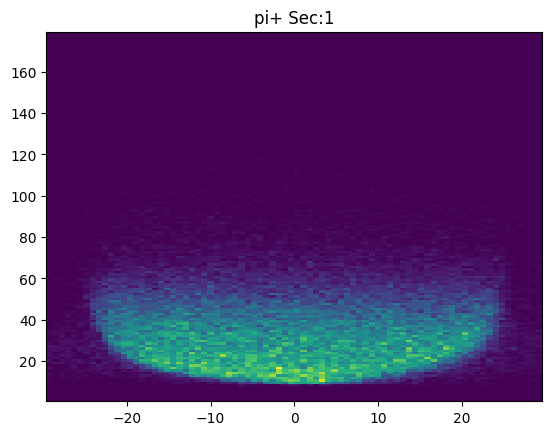

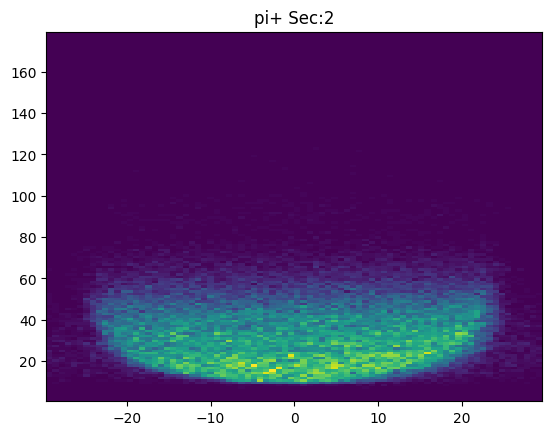

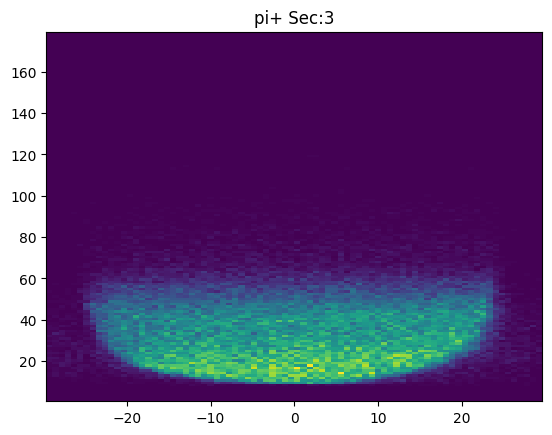

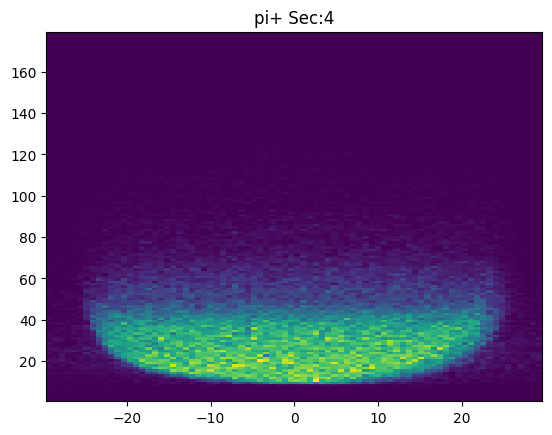

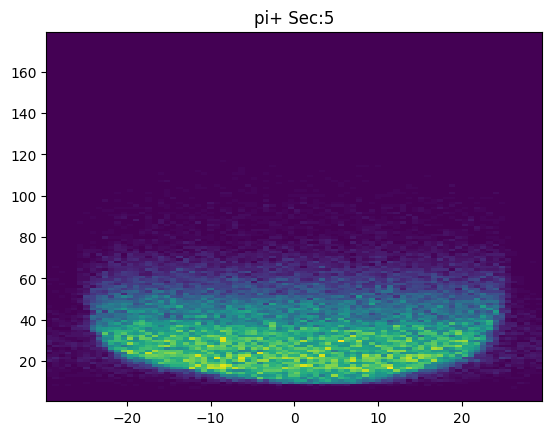

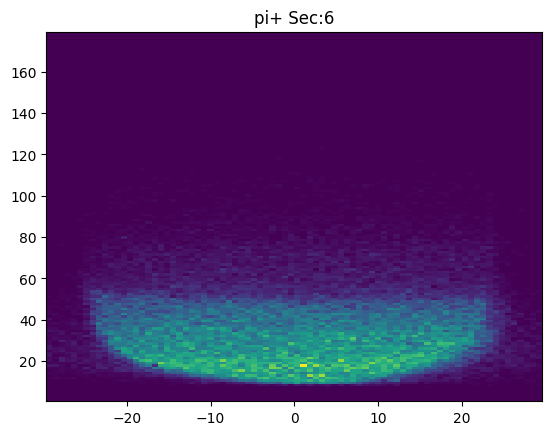

In [9]:
for sec in range(6):
    plt.hist2d(dumb1_x[sec], dumb1_y[sec], bins=(len(fid_pip_x), len(fid_pip_y)), weights=dense1[sec])
    plt.title("pi+ Sec:{}".format(sec+1))
    plt.show()

In [10]:
#Y slices will be needed
fid_pip_fit_x = [[Remove_Zeros_X(fid_pip_x,fid_pip_z_yx[sec][ybin]) for ybin in range(len(fid_pip_y))] for sec in range(6)]
fid_pip_fit_y = [[Remove_Zeros_Y(fid_pip_z_yx[sec][ybin]) for ybin in range(len(fid_pip_y))] for sec in range(6)]


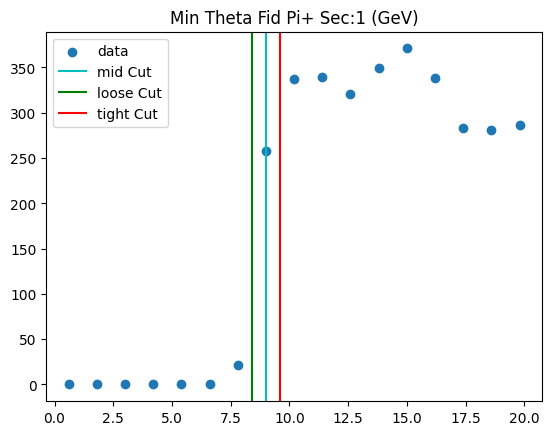

9.0


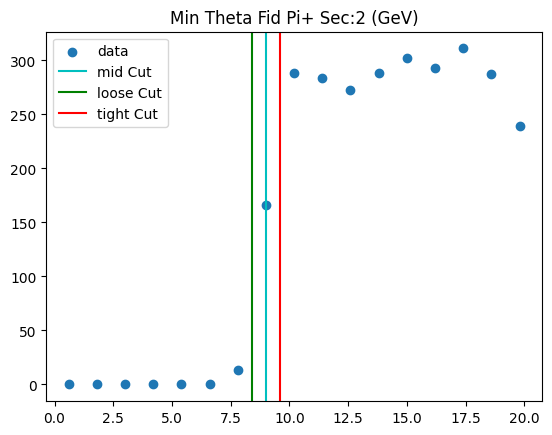

9.0


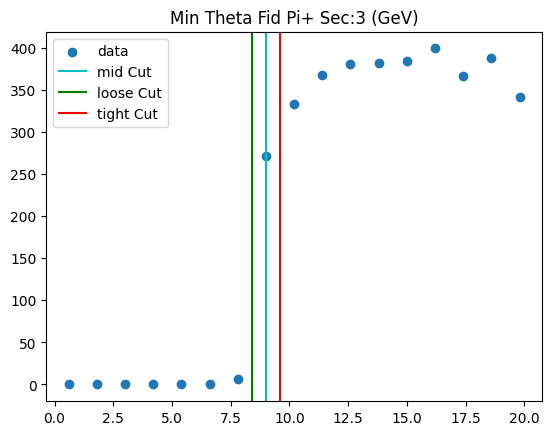

9.0


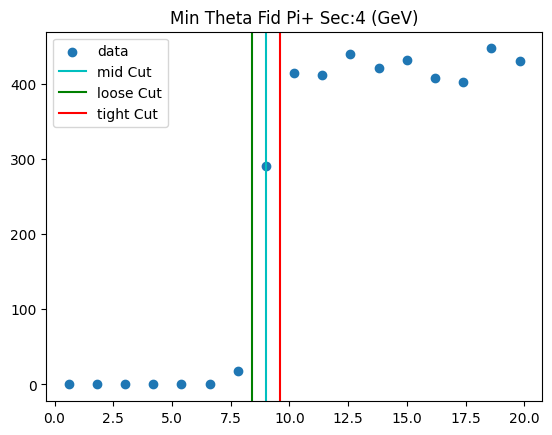

9.0


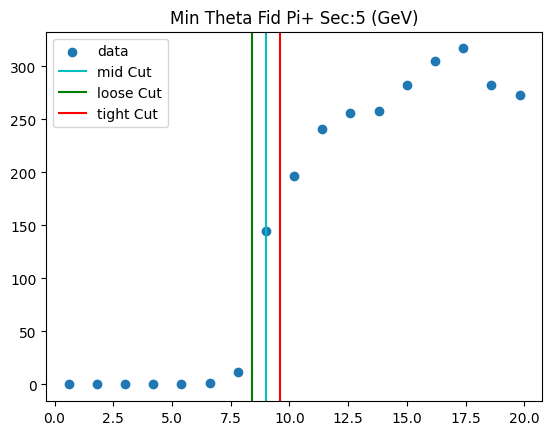

9.0


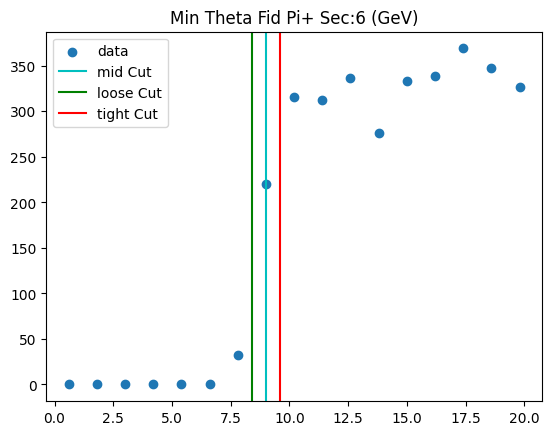

9.0


In [30]:
min_theta_y = np.array([[ Bounds_on_X_From_Y(fid_pip_fit_y[sec][theta_bin],fid_pip_fit_x[sec][theta_bin],-2.0,2.0).sum() for theta_bin in range(len(fid_pip_y))] for sec in range(6)])
#Part 1: Minimum Theta
ini_c1 = 12.0
ini_c2 = 25.0
ini_pshift = 0.36


min_frac = 0.95
low_frac = 0.8
top_frac = 0.99

#theta = [fid_ele_y[theta_bin] for theta_bin in range(len(fid_ele_y))]

if fid_pip_sel == 1:
    ini_skew = 10
    ini_loc = 36
    ini_scale=7
    ini_norm = 300
else:
    ini_skew = 10
    ini_loc = 36
    ini_scale=7
    ini_norm = 200000

min_theta_fit = np.zeros((6,4))
min_theta_vals = np.zeros((6))
min_theta_fit_low = np.zeros((6,4))
min_theta_vals_low = np.zeros((6))
min_theta_fit_top = np.zeros((6,4))
min_theta_vals_top = np.zeros((6))

par_bounds = [[0.0,0.0,0.0,0.0],[100.0,100.0,100.0,np.inf]]

for sec in range(6):
    ini_pars= [ini_skew,ini_loc,ini_scale,ini_norm]
    if min_theta_y[sec].sum() >100:
        xvals = Bounds_on_Y(fid_pip_y,0,20)
        yvals = Bounds_on_X_From_Y(min_theta_y[sec],fid_pip_y,0,20)
        plt.scatter(xvals,yvals,label="data")
        for i in range(len(xvals)-2):
            if yvals[i] ==0 and yvals[i+1] >0 and yvals[i+2] > 6*yvals[i+1]:
                if yvals[i+2]>100:
                    min_theta_vals[sec] = xvals[i+2]
                    min_theta_vals_low[sec] = xvals[i+2]-(xvals[i+2]-xvals[i+1])/2
                    min_theta_vals_top[sec] = xvals[i+2]+(xvals[i+2]-xvals[i+1])/2
                else:
                    min_theta_vals[sec] = xvals[i+3]
                    min_theta_vals_low[sec] = xvals[i+3]-(xvals[i+2]-xvals[i+1])/2
                    min_theta_vals_top[sec] = xvals[i+3]+(xvals[i+2]-xvals[i+1])/2
        plt.axvline(x = min_theta_vals[sec], color = 'c', label = 'mid Cut')
        plt.axvline(x = min_theta_vals_low[sec], color = 'g', label = 'loose Cut')
        plt.axvline(x = min_theta_vals_top[sec], color = 'r', label = 'tight Cut')
        #try:
        #    pars, pars_cov = op.curve_fit(skew_norm,xvals,yvals,p0=ini_pars,bounds=par_bounds,maxfev=5000)
        #    cont_x = np.linspace(xvals[0],xvals[len(xvals)-1],400)
        #    plt.plot(cont_x, skew_norm(cont_x,pars[0],pars[1],pars[2],pars[3]),label="fit")
        #    for i in range(4):
        #        ini_pars[i] = pars[i]
        #        min_theta_fit[sec][i] = pars[i]
        ##    print(pars)
         #   max_y = np.amax(skew_norm(cont_x,pars[0],pars[1],pars[2],pars[3]))
         #   max_x = cont_x[np.argmax(skew_norm(cont_x,pars[0],pars[1],pars[2],pars[3]))]
         #   plt.axvline(x = cont_x[np.argmax(skew_norm(cont_x,pars[0],pars[1],pars[2],pars[3]))], color = 'b', label = 'Skew Max')#

        #    for i in range(len(cont_x)-1):
        #        if skew_norm(cont_x[i],pars[0],pars[1],pars[2],pars[3]) <=min_frac*max_y and skew_norm(cont_x[i+1],pars[0],pars[1],pars[2],pars[3]) > min_frac*max_y:
        #            min_theta_vals[sec] = cont_x[i]
        #            plt.axvline(x = cont_x[i], color = 'c', label = 'Middle Cut')
        #        if skew_norm(cont_x[i],pars[0],pars[1],pars[2],pars[3]) <=low_frac*max_y and skew_norm(cont_x[i+1],pars[0],pars[1],pars[2],pars[3]) > low_frac*max_y:
        #            min_theta_vals_low[sec] = cont_x[i]
        #            plt.axvline(x = cont_x[i], color = 'g', label = 'Low Cut')
        #        if skew_norm(cont_x[i],pars[0],pars[1],pars[2],pars[3]) <=top_frac*max_y and skew_norm(cont_x[i+1],pars[0],pars[1],pars[2],pars[3]) > top_frac*max_y:
        #            min_theta_vals_top[sec] = cont_x[i]
        #            plt.axvline(x = cont_x[i], color = 'r', label = 'Top Cut')
        #except RuntimeError:
        #    print("Runtime Error")
        plt.legend()
        plt.title("Min Theta Fid Pi+ Sec:{} (GeV)".format(sec+1))
        plt.show()
    print(min_theta_vals[sec])                                                                                                                 
   

==========Sec  1 ===============
...........Theta: 10.2 ............
Binning| Sec: 0  Ybin: 8
Sum of plot 1201.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 1078.0
max at  76.0
initial max 600.0
initial guesses: [76.0, 0.0, 10.0, 2.0]
fit bounds [-10.0, 10.0]
(array([59.05476029,  0.92960405,  6.09249375,  2.12109623]), array([[13.37841875,  0.07588098, -0.43973972, -1.39230097],
       [ 0.07588098,  0.11175172,  0.02254004, -0.02807648],
       [-0.43973972,  0.02254004,  0.16233803, -0.04451903],
       [-1.39230097, -0.02807648, -0.04451903,  0.30400009]]))
[59.05476029  0.92960405  6.09249375  2.12109623]
[59.05476029  0.92960405  6.09249375  2.12109623]
New Bounds for next fit: [-16.771491241364657, 18.63069933391995]


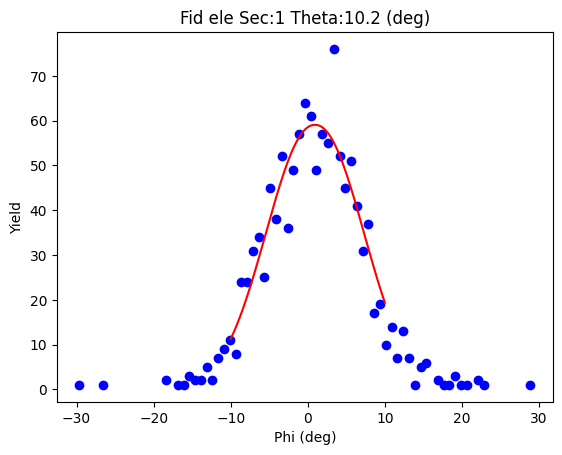

...........Theta: 11.4 ............
Binning| Sec: 0  Ybin: 9
Sum of plot 1482.0
Initial Bounds: [-16.771491241364657, 18.63069933391995]
Sum of initial fit area: 1446.0
max at  65.0
initial max 59.054760293606215
initial guesses: [65.0, 0.9296040462776467, 6.092493749496516, 2.1210962252533077]
fit bounds [-16.771491241364657, 18.63069933391995]
(array([56.17717075,  0.51238948,  7.69998343,  2.77245129]), array([[ 2.59227722e+00,  2.98080936e-04, -1.68093711e-01,
        -2.72663009e-01],
       [ 2.98080936e-04,  3.87731347e-02,  5.40336335e-05,
        -1.51156702e-04],
       [-1.68093711e-01,  5.40336335e-05,  3.52224059e-02,
         1.36853899e-02],
       [-2.72663009e-01, -1.51156702e-04,  1.36853899e-02,
         7.62623865e-02]]))
[56.17717075  0.51238948  7.69998343  2.77245129]
[56.17717075  0.51238948  7.69998343  2.77245129]
New Bounds for next fit: [-18.37761066829946, 19.40238963325671]


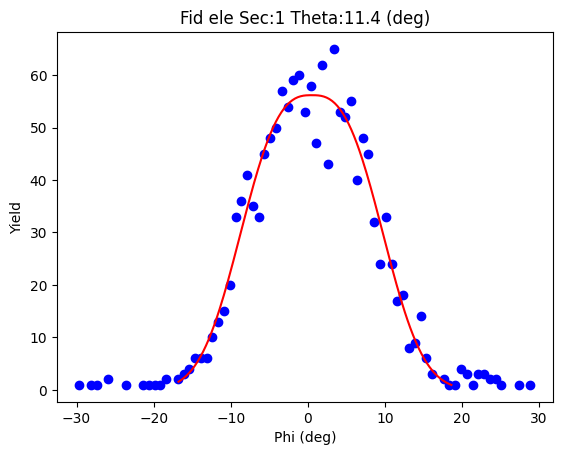

...........Theta: 12.6 ............
Binning| Sec: 0  Ybin: 10
Sum of plot 1822.0
Initial Bounds: [-18.37761066829946, 19.40238963325671]
Sum of initial fit area: 1794.0
max at  69.0
initial max 56.17717074725156
initial guesses: [69.0, 0.5123894824786256, 7.699983432480271, 2.7724512919400883]
fit bounds [-18.37761066829946, 19.40238963325671]
(array([54.96924519, -0.4413107 ,  9.45404424,  4.22573128]), array([[ 3.53203610e+00, -8.98116597e-04, -1.87991947e-01,
        -6.38963430e-01],
       [-8.98116597e-04,  8.22051869e-02, -1.24289136e-04,
         8.36675370e-04],
       [-1.87991947e-01, -1.24289136e-04,  5.83993805e-02,
         1.26777512e-02],
       [-6.38963430e-01,  8.36675370e-04,  1.26777512e-02,
         4.17317899e-01]]))
[54.96924519 -0.4413107   9.45404424  4.22573128]
[54.96924519 -0.4413107   9.45404424  4.22573128]
New Bounds for next fit: [-19.631828317923947, 18.74920692532467]


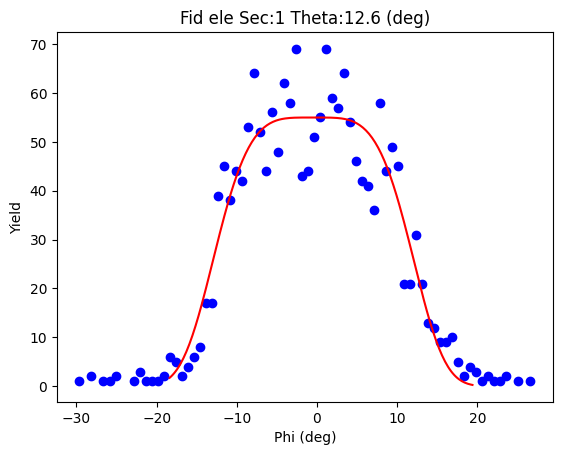

...........Theta: 13.8 ............
Binning| Sec: 0  Ybin: 11
Sum of plot 2084.0
Initial Bounds: [-19.631828317923947, 18.74920692532467]
Sum of initial fit area: 2030.0
max at  71.0
initial max 54.96924518758709
initial guesses: [71.0, -0.44131069629963887, 9.454044244931987, 4.225731282871035]
fit bounds [-19.631828317923947, 18.74920692532467]
(array([57.68483609, -0.72075241, 10.00801645,  5.73281115]), array([[ 2.06927957e+00, -4.52893373e-05, -8.09899101e-02,
        -5.13700186e-01],
       [-4.52893373e-05,  4.48308930e-02, -6.76424421e-06,
         7.08466065e-05],
       [-8.09899101e-02, -6.76424421e-06,  2.89691304e-02,
        -2.80026228e-03],
       [-5.13700186e-01,  7.08466065e-05, -2.80026228e-03,
         5.85679092e-01]]))
[57.68483609 -0.72075241 10.00801645  5.73281115]
[57.68483609 -0.72075241 10.00801645  5.73281115]
New Bounds for next fit: [-19.194539429064843, 17.753034609523855]


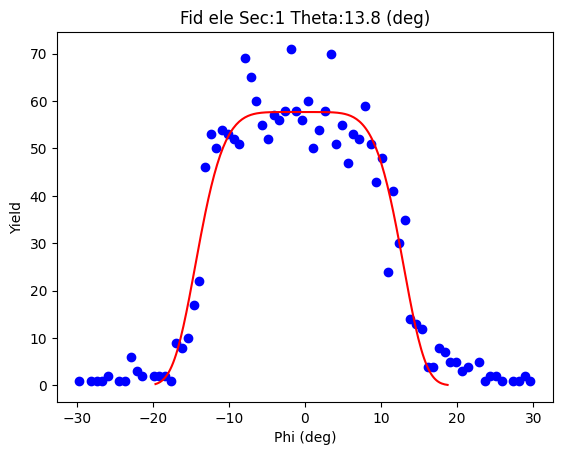

...........Theta: 15.0 ............
Binning| Sec: 0  Ybin: 12
Sum of plot 2276.0
Initial Bounds: [-19.194539429064843, 17.753034609523855]
Sum of initial fit area: 2207.0
max at  68.0
initial max 57.68483609333984
initial guesses: [68.0, -0.7207524097704952, 10.00801645131883, 5.732811147158387]
fit bounds [-19.194539429064843, 17.753034609523855]
(array([55.14107773, -0.5240397 , 11.57004921,  5.74299954]), array([[ 1.82571557e+00,  2.65500041e-03, -6.94287717e-02,
        -5.49558376e-01],
       [ 2.65500041e-03,  5.96909098e-02,  1.15924070e-03,
        -5.67585028e-03],
       [-6.94287717e-02,  1.15924070e-03,  4.15750799e-02,
        -3.22563183e-02],
       [-5.49558376e-01, -5.67585028e-03, -3.22563183e-02,
         7.23126595e-01]]))
[55.14107773 -0.5240397  11.57004921  5.74299954]
[55.14107773 -0.5240397  11.57004921  5.74299954]
New Bounds for next fit: [-21.871090444608246, 20.823011053736234]


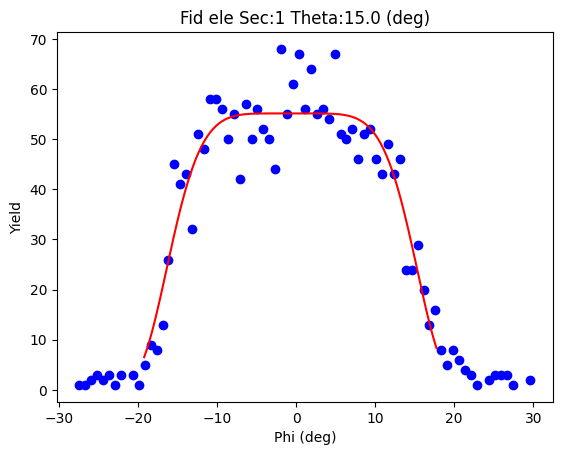

...........Theta: 16.2 ............
Binning| Sec: 0  Ybin: 13
Sum of plot 2499.0
Initial Bounds: [-21.871090444608246, 20.823011053736234]
Sum of initial fit area: 2441.0
max at  81.0
initial max 55.14107772564119
initial guesses: [81.0, -0.5240396954360075, 11.570049212327085, 5.742999537441987]
fit bounds [-21.871090444608246, 20.823011053736234]
(array([54.4428839 , -0.40321844, 12.72641512,  6.85077274]), array([[ 1.80606768e+00, -1.05920548e-04, -7.56990298e-02,
        -6.06927189e-01],
       [-1.05920548e-04,  6.60147557e-02, -3.61233095e-05,
         2.82895240e-04],
       [-7.56990298e-02, -3.61233095e-05,  4.16533434e-02,
        -2.15958889e-02],
       [-6.06927189e-01,  2.82895240e-04, -2.15958889e-02,
         1.06657861e+00]]))
[54.4428839  -0.40321844 12.72641512  6.85077274]
[54.4428839  -0.40321844 12.72641512  6.85077274]
New Bounds for next fit: [-22.89554338448443, 22.08910651256004]


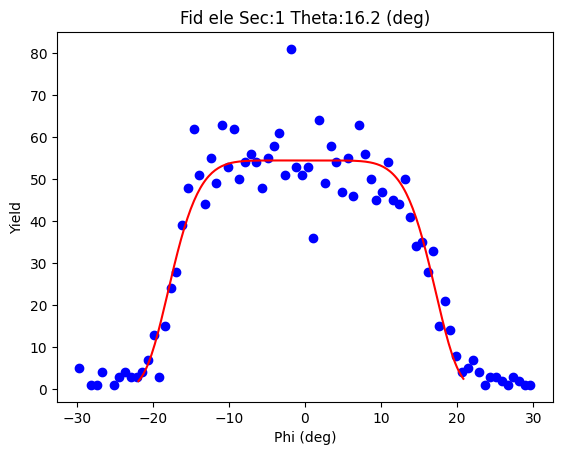

...........Theta: 17.4 ............
Binning| Sec: 0  Ybin: 14
Sum of plot 2434.0
Initial Bounds: [-22.89554338448443, 22.08910651256004]
Sum of initial fit area: 2392.0
max at  64.0
initial max 54.44288390429894
initial guesses: [64.0, -0.4032184359621934, 12.726415116495282, 6.850772735560772]
fit bounds [-22.89554338448443, 22.08910651256004]
(array([50.98512444, -0.40334078, 13.03083605,  9.31779189]), array([[ 1.23652288e+00,  1.07811731e-05, -4.26210380e-02,
        -6.10265499e-01],
       [ 1.07811731e-05,  4.56304392e-02,  2.93665197e-06,
        -4.98661387e-05],
       [-4.26210380e-02,  2.93665197e-06,  2.73110669e-02,
        -3.32672307e-02],
       [-6.10265499e-01, -4.98661387e-05, -3.32672307e-02,
         2.07873719e+00]]))
[50.98512444 -0.40334078 13.03083605  9.31779189]
[50.98512444 -0.40334078 13.03083605  9.31779189]
New Bounds for next fit: [-22.11374166398518, 21.307060104712477]


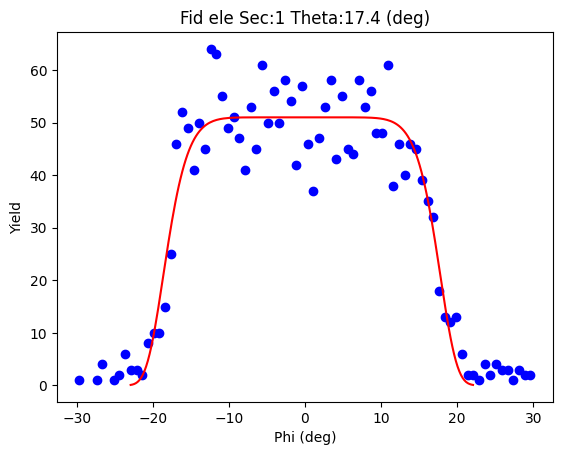

...........Theta: 18.6 ............
Binning| Sec: 0  Ybin: 15
Sum of plot 2521.0
Initial Bounds: [-22.11374166398518, 21.307060104712477]
Sum of initial fit area: 2437.0
max at  66.0
initial max 50.985124444396725
initial guesses: [66.0, -0.4033407796363509, 13.030836051595312, 9.317791888652662]
fit bounds [-22.11374166398518, 21.307060104712477]
(array([48.70320331, -0.3037512 , 13.85395314, 12.        ]), array([[ 1.27883262e+00,  4.23874930e-04, -3.45545366e-02,
        -9.26535723e-01],
       [ 4.23874930e-04,  5.03271485e-02,  2.31245999e-04,
        -4.03863526e-03],
       [-3.45545366e-02,  2.31245999e-04,  3.03347798e-02,
        -9.59384087e-02],
       [-9.26535723e-01, -4.03863526e-03, -9.59384087e-02,
         5.65077084e+00]]))
[48.70320331 -0.3037512  13.85395314 12.        ]
[48.70320331 -0.3037512  13.85395314 12.        ]
New Bounds for next fit: [-22.555245732357626, 21.947743336329516]


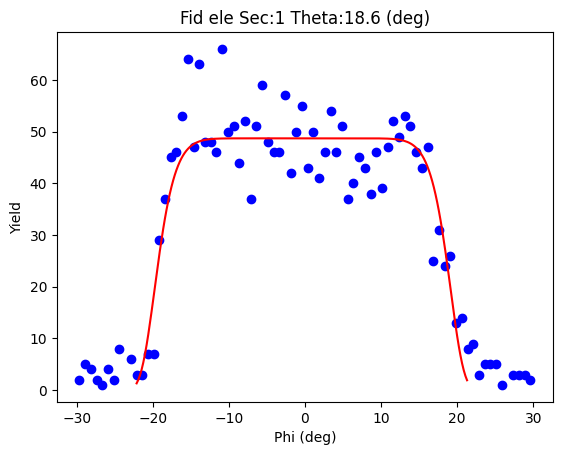

...........Theta: 19.8 ............
Binning| Sec: 0  Ybin: 16
Sum of plot 2598.0
Initial Bounds: [-22.555245732357626, 21.947743336329516]
Sum of initial fit area: 2542.0
max at  62.0
initial max 48.703203305133684
initial guesses: [62.0, -0.30375119801405553, 13.853953142271179, 11.999999999999998]
fit bounds [-22.555245732357626, 21.947743336329516]
(array([49.25426739, -0.24903995, 14.30793129, 12.        ]), array([[ 1.35549262e+00,  7.17484435e-04, -3.77077993e-02,
        -9.66365173e-01],
       [ 7.17484435e-04,  5.55679835e-02,  3.93309592e-04,
        -6.71888277e-03],
       [-3.77077993e-02,  3.93309592e-04,  3.33970416e-02,
        -1.00079466e-01],
       [-9.66365173e-01, -6.71888277e-03, -1.00079466e-01,
         5.81167320e+00]]))
[49.25426739 -0.24903995 14.30793129 12.        ]
[49.25426739 -0.24903995 14.30793129 12.        ]
New Bounds for next fit: [-23.229690429340227, 22.731610534881337]


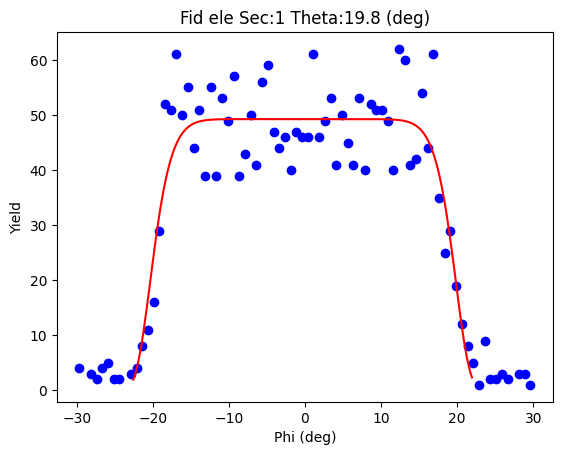

...........Theta: 21.0 ............
Binning| Sec: 0  Ybin: 17
Sum of plot 2578.0
Initial Bounds: [-23.229690429340227, 22.731610534881337]
Sum of initial fit area: 2526.0
max at  66.0
initial max 49.25426739254172
initial guesses: [66.0, -0.24903994722944484, 14.307931292735814, 11.999999999999998]
fit bounds [-23.229690429340227, 22.731610534881337]
(array([47.39664821, -0.23211313, 14.75235817, 12.        ]), array([[ 9.85770506e-01,  5.46572253e-04, -2.96878013e-02,
        -7.25836750e-01],
       [ 5.46572253e-04,  4.63093623e-02,  3.13305842e-04,
        -5.27150277e-03],
       [-2.96878013e-02,  3.13305842e-04,  2.77310142e-02,
        -7.82805123e-02],
       [-7.25836750e-01, -5.27150277e-03, -7.82805123e-02,
         4.51964228e+00]]))
[47.39664821 -0.23211313 14.75235817 12.        ]
[47.39664821 -0.23211313 14.75235817 12.        ]
New Bounds for next fit: [-23.926578799304128, 23.46235254083056]


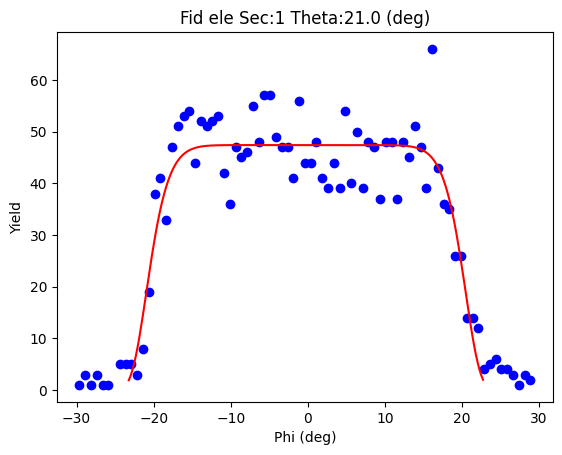

...........Theta: 22.2 ............
Binning| Sec: 0  Ybin: 18
Sum of plot 2701.0
Initial Bounds: [-23.926578799304128, 23.46235254083056]
Sum of initial fit area: 2665.0
max at  69.0
initial max 47.39664821370114
initial guesses: [69.0, -0.23211312923678368, 14.75235816711619, 11.99999999999961]
fit bounds [-23.926578799304128, 23.46235254083056]
(array([48.85685302,  0.12686187, 15.10184064, 12.        ]), array([[ 1.09092656e+00,  1.50076156e-03, -3.27578011e-02,
        -7.76097838e-01],
       [ 1.50076156e-03,  5.06535850e-02,  8.48116538e-04,
        -1.39975231e-02],
       [-3.27578011e-02,  8.48116538e-04,  3.02953896e-02,
        -8.29064544e-02],
       [-7.76097838e-01, -1.39975231e-02, -8.29064544e-02,
         4.68504991e+00]]))
[48.85685302  0.12686187 15.10184064 12.        ]
[48.85685302  0.12686187 15.10184064 12.        ]
New Bounds for next fit: [-24.128924263818696, 24.382647999369603]


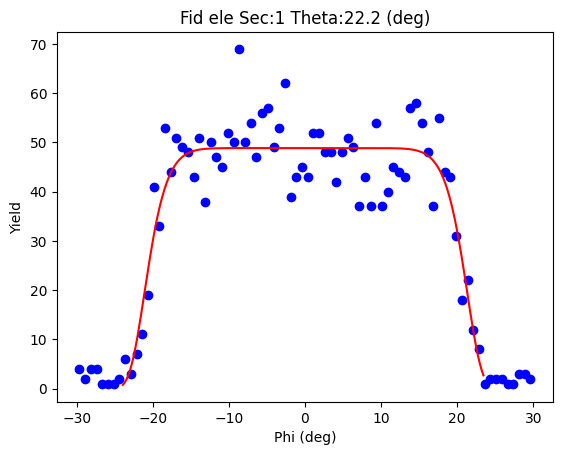

...........Theta: 23.4 ............
Binning| Sec: 0  Ybin: 19
Sum of plot 2644.0
Initial Bounds: [-24.128924263818696, 24.382647999369603]
Sum of initial fit area: 2611.0
max at  63.0
initial max 48.85685301999595
initial guesses: [63.0, 0.12686186777545266, 15.101840641643422, 11.999999999999943]
fit bounds [-24.128924263818696, 24.382647999369603]
(array([46.61310543, -0.11623901, 15.51778826, 12.        ]), array([[ 1.13436381e+00, -1.29682000e-03, -3.71965016e-02,
        -8.39015595e-01],
       [-1.29682000e-03,  6.08783176e-02, -7.55495632e-04,
         1.24797233e-02],
       [-3.71965016e-02, -7.55495632e-04,  3.62360532e-02,
        -9.24313451e-02],
       [-8.39015595e-01,  1.24797233e-02, -9.24313451e-02,
         5.28058488e+00]]))
[46.61310543 -0.11623901 15.51778826 12.        ]
[46.61310543 -0.11623901 15.51778826 12.        ]
New Bounds for next fit: [-25.04009842809449, 24.807620413768042]


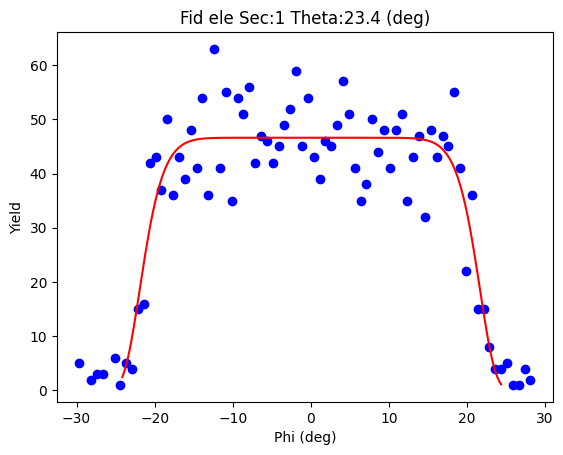

...........Theta: 24.6 ............
Binning| Sec: 0  Ybin: 20
Sum of plot 2674.0
Initial Bounds: [-25.04009842809449, 24.807620413768042]
Sum of initial fit area: 2636.0
max at  61.0
initial max 46.613105426408005
initial guesses: [61.0, -0.11623900716322276, 15.517788255040537, 11.999999999999888]
fit bounds [-25.04009842809449, 24.807620413768042]
(array([46.27914263,  0.2451876 , 15.79484941, 12.        ]), array([[ 9.95212952e-01,  5.91580400e-04, -3.37896881e-02,
        -7.37375259e-01],
       [ 5.91580400e-04,  5.59551663e-02,  3.41470588e-04,
        -5.66653308e-03],
       [-3.37896881e-02,  3.41470588e-04,  3.31878175e-02,
        -8.03854757e-02],
       [-7.37375259e-01, -5.66653308e-03, -8.03854757e-02,
         4.65517422e+00]]))
[46.27914263  0.2451876  15.79484941 12.        ]
[46.27914263  0.2451876  15.79484941 12.        ]
New Bounds for next fit: [-25.123672946516695, 25.614048144952253]


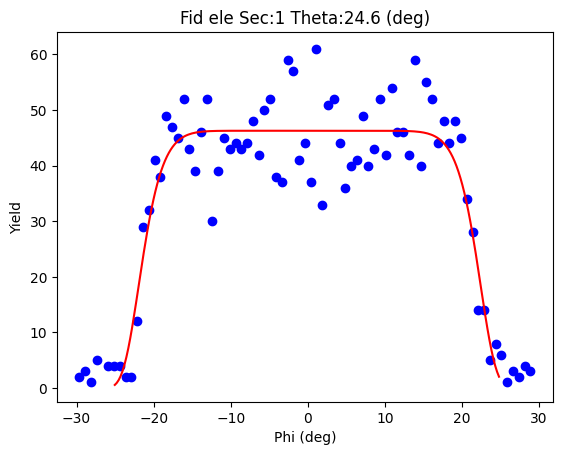

...........Theta: 25.8 ............
Binning| Sec: 0  Ybin: 21
Sum of plot 2676.0
Initial Bounds: [-25.123672946516695, 25.614048144952253]
Sum of initial fit area: 2631.0
max at  64.0
initial max 46.279142629115995
initial guesses: [64.0, 0.24518759921777797, 15.794849408023444, 11.999999999998918]
fit bounds [-25.123672946516695, 25.614048144952253]
(array([45.2027558 ,  0.52789837, 16.140253  , 12.        ]), array([[ 1.16396242e+00,  6.07677904e-04, -4.07346416e-02,
        -8.91551932e-01],
       [ 6.07677904e-04,  7.17945537e-02,  3.87036571e-04,
        -6.07416254e-03],
       [-4.07346416e-02,  3.87036571e-04,  4.27999882e-02,
        -1.06283041e-01],
       [-8.91551932e-01, -6.07416254e-03, -1.06283041e-01,
         5.79389251e+00]]))
[45.2027558   0.52789837 16.140253   12.        ]
[45.2027558   0.52789837 16.140253   12.        ]
New Bounds for next fit: [-25.39573135729688, 26.45152808847252]


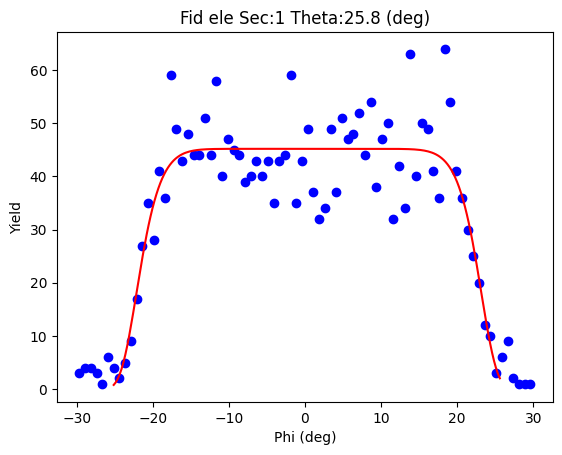

...........Theta: 27.0 ............
Binning| Sec: 0  Ybin: 22
Sum of plot 2578.0
Initial Bounds: [-25.39573135729688, 26.45152808847252]
Sum of initial fit area: 2548.0
max at  56.0
initial max 45.202755798871316
initial guesses: [56.0, 0.5278983655878198, 16.140253002067734, 11.999999999999888]
fit bounds [-25.39573135729688, 26.45152808847252]
(array([42.923085  ,  0.36451627, 16.4866223 , 12.        ]), array([[ 1.09208599e+00, -2.67181853e-05, -4.20776621e-02,
        -8.67882683e-01],
       [-2.67181853e-05,  7.76223634e-02, -1.68202019e-05,
         2.72915205e-04],
       [-4.20776621e-02, -1.68202019e-05,  4.59070762e-02,
        -1.03529570e-01],
       [-8.67882683e-01,  2.72915205e-04, -1.03529570e-01,
         5.88816702e+00]]))
[42.923085    0.36451627 16.4866223  12.        ]
[42.923085    0.36451627 16.4866223  12.        ]
New Bounds for next fit: [-26.115433689099536, 26.84446622349726]


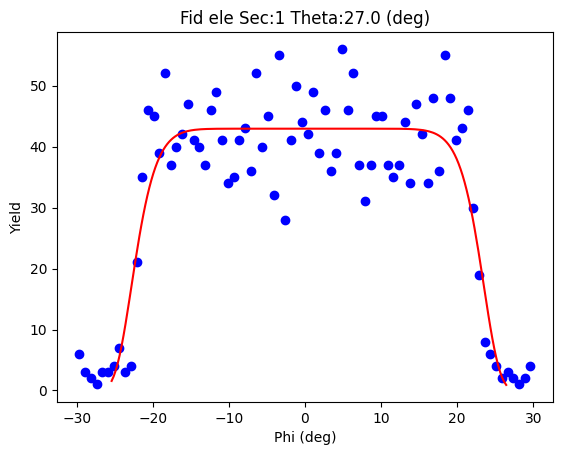

...........Theta: 28.2 ............
Binning| Sec: 0  Ybin: 23
Sum of plot 2663.0
Initial Bounds: [-26.115433689099536, 26.84446622349726]
Sum of initial fit area: 2643.0
max at  60.0
initial max 42.923085001604754
initial guesses: [60.0, 0.36451626719886127, 16.486622295775874, 11.999999999999998]
fit bounds [-26.115433689099536, 26.84446622349726]
(array([44.07059185,  0.2106686 , 16.65836112, 12.        ]), array([[ 1.20446480e+00, -1.37863986e-04, -4.66739289e-02,
        -9.17762409e-01],
       [-1.37863986e-04,  8.26734546e-02, -7.38465268e-05,
         1.30529130e-03],
       [-4.66739289e-02, -7.38465268e-05,  4.85522665e-02,
        -1.00416007e-01],
       [-9.17762409e-01,  1.30529130e-03, -1.00416007e-01,
         6.01515108e+00]]))
[44.07059185  0.2106686  16.65836112 12.        ]
[44.07059185  0.2106686  16.65836112 12.        ]
New Bounds for next fit: [-26.54511926192182, 26.966456469183782]


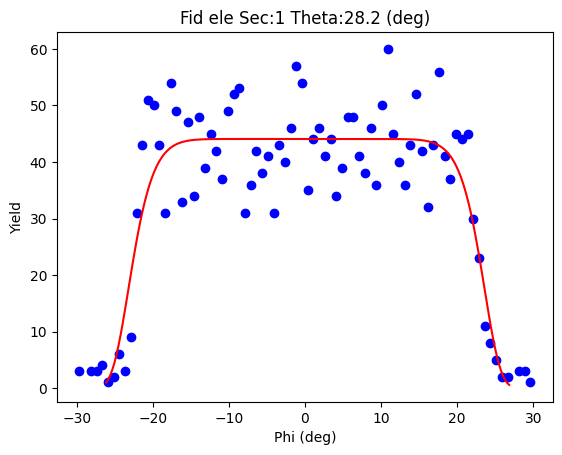

...........Theta: 29.4 ............
Binning| Sec: 0  Ybin: 24
Sum of plot 2699.0
Initial Bounds: [-26.54511926192182, 26.966456469183782]
Sum of initial fit area: 2676.0
max at  62.0
initial max 44.070591854694044
initial guesses: [62.0, 0.21066860363098255, 16.65836111825247, 11.999999999999998]
fit bounds [-26.54511926192182, 26.966456469183782]
(array([44.3205212 ,  0.13076984, 16.73565821, 12.        ]), array([[ 9.58800506e-01, -2.35422948e-04, -3.69252427e-02,
        -7.29217448e-01],
       [-2.35422948e-04,  6.57220524e-02, -1.32005126e-04,
         2.25120916e-03],
       [-3.69252427e-02, -1.32005126e-04,  3.86604835e-02,
        -8.11014553e-02],
       [-7.29217448e-01,  2.25120916e-03, -8.11014553e-02,
         4.76182676e+00]]))
[44.3205212   0.13076984 16.73565821 12.        ]
[44.3205212   0.13076984 16.73565821 12.        ]
New Bounds for next fit: [-26.749168575222033, 27.010708248641922]


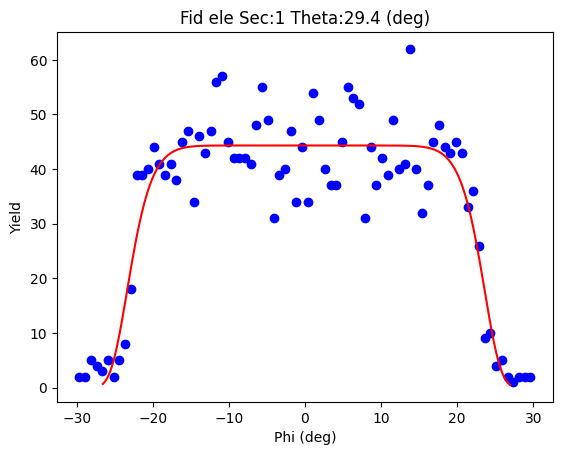

...........Theta: 30.6 ............
Binning| Sec: 0  Ybin: 25
Sum of plot 2578.0
Initial Bounds: [-26.749168575222033, 27.010708248641922]
Sum of initial fit area: 2561.0
max at  58.0
initial max 44.32052119963407
initial guesses: [58.0, 0.13076983670994607, 16.73565821168904, 11.999999999999998]
fit bounds [-26.749168575222033, 27.010708248641922]
(array([42.41694848,  0.61623079, 16.75263619, 12.        ]), array([[ 9.08416114e-01,  3.11208529e-04, -3.66502758e-02,
        -7.20927445e-01],
       [ 3.11208529e-04,  6.81184310e-02,  1.78886824e-04,
        -3.08797834e-03],
       [-3.66502758e-02,  1.78886824e-04,  4.00521481e-02,
        -8.34918939e-02],
       [-7.20927445e-01, -3.08797834e-03, -8.34918939e-02,
         4.91634768e+00]]))
[42.41694848  0.61623079 16.75263619 12.        ]
[42.41694848  0.61623079 16.75263619 12.        ]
New Bounds for next fit: [-26.29097675324132, 27.523438339462135]


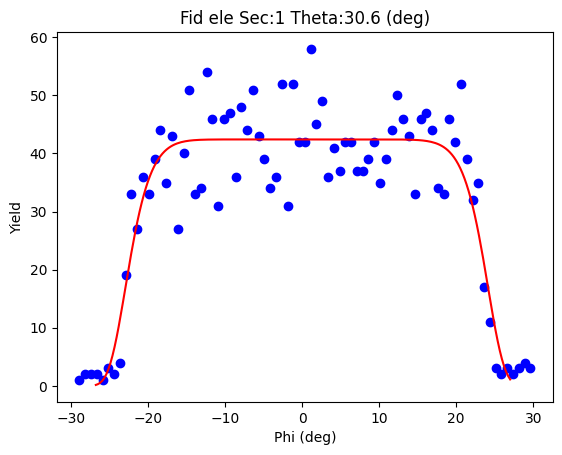

...........Theta: 31.8 ............
Binning| Sec: 0  Ybin: 26
Sum of plot 2646.0
Initial Bounds: [-26.29097675324132, 27.523438339462135]
Sum of initial fit area: 2628.0
max at  54.0
initial max 42.416948476305926
initial guesses: [54.0, 0.616230793110409, 16.752636186354895, 11.999999999999998]
fit bounds [-26.29097675324132, 27.523438339462135]
(array([42.90712174,  0.36329076, 17.01483369, 12.        ]), array([[ 7.72024006e-01, -1.99000406e-03, -2.91315969e-02,
        -6.32045718e-01],
       [-1.99000406e-03,  5.94305656e-02, -1.54198774e-03,
         2.16499406e-02],
       [-2.91315969e-02, -1.54198774e-03,  3.58091354e-02,
        -9.25198516e-02],
       [-6.32045718e-01,  2.16499406e-02, -9.25198516e-02,
         4.38020062e+00]]))
[42.90712174  0.36329076 17.01483369 12.        ]
[42.90712174  0.36329076 17.01483369 12.        ]
New Bounds for next fit: [-26.965044694102023, 27.69162621751295]


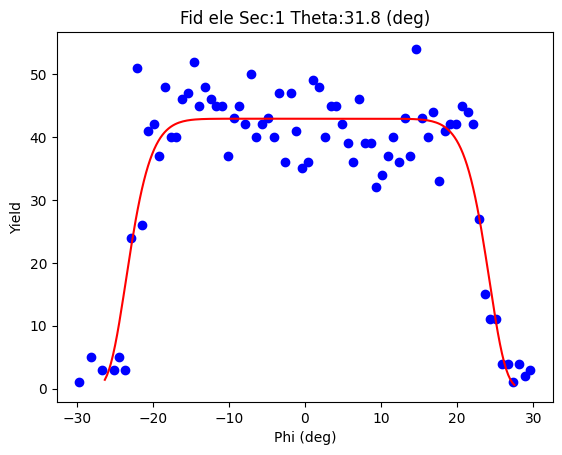

...........Theta: 33.0 ............
Binning| Sec: 0  Ybin: 27
Sum of plot 2582.0
Initial Bounds: [-26.965044694102023, 27.69162621751295]
Sum of initial fit area: 2571.0
max at  61.0
initial max 42.9071217413928
initial guesses: [61.0, 0.3632907617054657, 17.01483369023482, 11.999999999999998]
fit bounds [-26.965044694102023, 27.69162621751295]
(array([41.68993839,  0.65589602, 17.12712133, 12.        ]), array([[ 1.10794008e+00,  2.42392047e-04, -4.65840065e-02,
        -8.93496178e-01],
       [ 2.42392047e-04,  8.98549163e-02,  1.43429846e-04,
        -2.43893712e-03],
       [-4.65840065e-02,  1.43429846e-04,  5.27985826e-02,
        -1.06878889e-01],
       [-8.93496178e-01, -2.43893712e-03, -1.06878889e-01,
         6.19459838e+00]]))
[41.68993839  0.65589602 17.12712133 12.        ]
[41.68993839  0.65589602 17.12712133 12.        ]
New Bounds for next fit: [-26.85278996678915, 28.164581998583355]


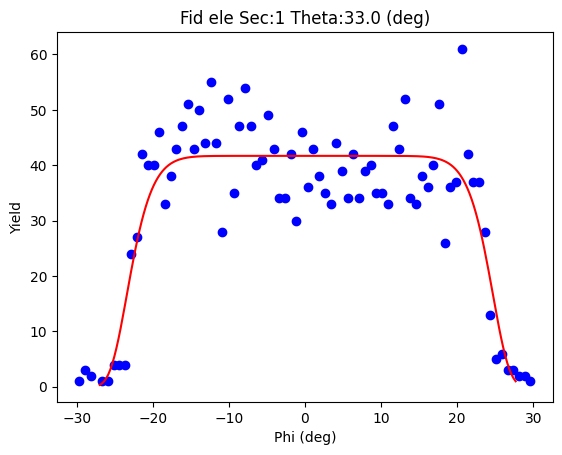

...........Theta: 34.2 ............
Binning| Sec: 0  Ybin: 28
Sum of plot 2413.0
Initial Bounds: [-26.85278996678915, 28.164581998583355]
Sum of initial fit area: 2400.0
max at  50.0
initial max 41.68993839443518
initial guesses: [50.0, 0.6558960158971026, 17.127121327575583, 11.999999999999998]
fit bounds [-26.85278996678915, 28.164581998583355]
(array([38.37865197,  0.46754617, 17.40747797, 12.        ]), array([[ 7.78317600e-01, -1.50542999e-03, -3.07448281e-02,
        -7.40775142e-01],
       [-1.50542999e-03,  8.06608538e-02, -2.12078517e-03,
         2.21690885e-02],
       [-3.07448281e-02, -2.12078517e-03,  5.05428137e-02,
        -1.57409509e-01],
       [-7.40775142e-01,  2.21690885e-02, -1.57409509e-01,
         5.93073371e+00]]))
[38.37865197  0.46754617 17.40747797 12.        ]
[38.37865197  0.46754617 17.40747797 12.        ]
New Bounds for next fit: [-27.491433981576893, 28.426526313641606]


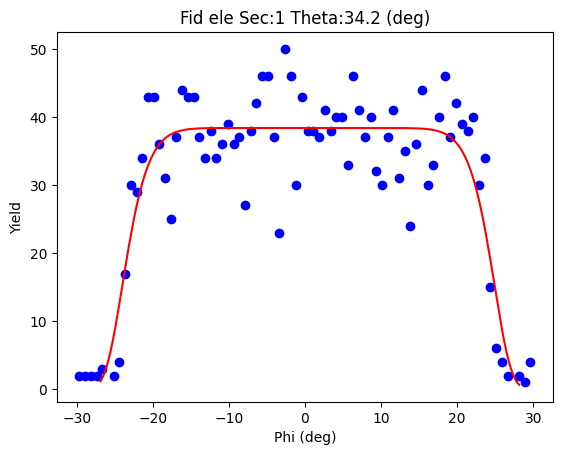

...........Theta: 35.4 ............
Binning| Sec: 0  Ybin: 29
Sum of plot 2320.0
Initial Bounds: [-27.491433981576893, 28.426526313641606]
Sum of initial fit area: 2317.0
max at  50.0
initial max 38.378651966923705
initial guesses: [50.0, 0.46754616603235744, 17.40747796840494, 11.999999999999998]
fit bounds [-27.491433981576893, 28.426526313641606]
(array([36.98535963,  0.32649076, 17.4605681 , 12.        ]), array([[ 9.39378564e-01, -5.62281152e-03, -3.99282348e-02,
        -9.01312914e-01],
       [-5.62281152e-03,  1.13465601e-01, -1.26321209e-02,
         1.04438244e-01],
       [-3.99282348e-02, -1.26321209e-02,  7.07691299e-02,
        -2.15323180e-01],
       [-9.01312914e-01,  1.04438244e-01, -2.15323180e-01,
         7.52015901e+00]]))
[36.98535963  0.32649076 17.4605681  12.        ]
[36.98535963  0.32649076 17.4605681  12.        ]
New Bounds for next fit: [-27.71775997142606, 28.370741493658205]


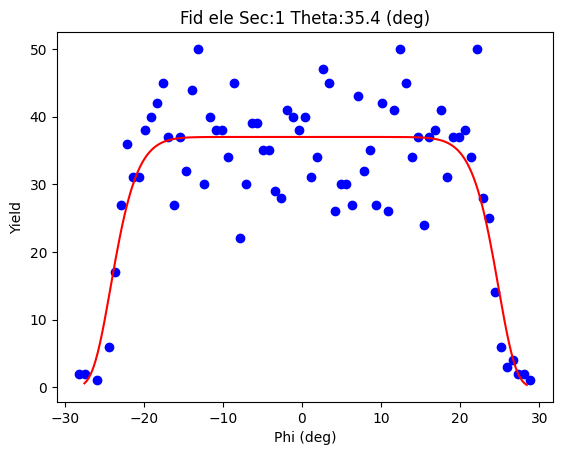

...........Theta: 36.6 ............
Binning| Sec: 0  Ybin: 30
Sum of plot 2280.0
Initial Bounds: [-27.71775997142606, 28.370741493658205]
Sum of initial fit area: 2277.0
max at  52.0
initial max 36.985359632333775
initial guesses: [52.0, 0.32649076111607234, 17.46056809618269, 11.999999999999998]
fit bounds [-27.71775997142606, 28.370741493658205]
(array([36.16169628,  0.57160088, 17.48094186, 12.        ]), array([[ 7.34072137e-01,  9.22848342e-04, -3.24616530e-02,
        -7.27084110e-01],
       [ 9.22848342e-04,  8.47306724e-02,  1.14767807e-03,
        -1.33031162e-02],
       [-3.24616530e-02,  1.14767807e-03,  5.19529660e-02,
        -1.44511176e-01],
       [-7.27084110e-01, -1.33031162e-02, -1.44511176e-01,
         6.06587234e+00]]))
[36.16169628  0.57160088 17.48094186 12.        ]
[36.16169628  0.57160088 17.48094186 12.        ]
New Bounds for next fit: [-27.50537312511931, 28.648574888982456]


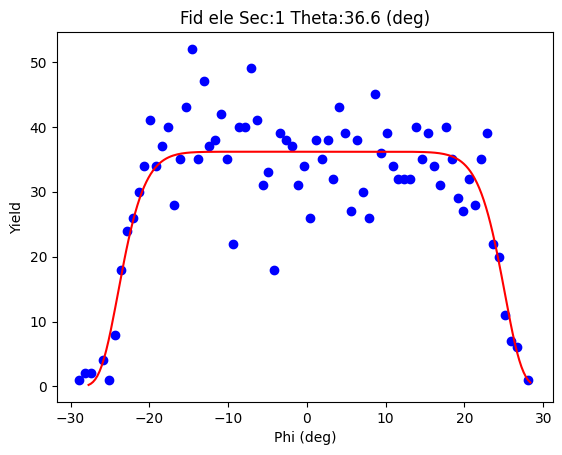

...........Theta: 37.8 ............
Binning| Sec: 0  Ybin: 31
Sum of plot 2257.0
Initial Bounds: [-27.50537312511931, 28.648574888982456]
Sum of initial fit area: 2254.0
max at  52.0
initial max 36.16169627588756
initial guesses: [52.0, 0.5716008819315748, 17.48094186078553, 11.999999999999568]
fit bounds [-27.50537312511931, 28.648574888982456]
(array([35.60058482,  0.25063983, 17.58709115, 12.        ]), array([[ 8.05536735e-01, -2.57644852e-03, -3.80014496e-02,
        -7.90272865e-01],
       [-2.57644852e-03,  9.67965772e-02, -2.91629383e-03,
         3.59249701e-02],
       [-3.80014496e-02, -2.91629383e-03,  5.83823334e-02,
        -1.45916394e-01],
       [-7.90272865e-01,  3.59249701e-02, -1.45916394e-01,
         6.60541951e+00]]))
[35.60058482  0.25063983 17.58709115 12.        ]
[35.60058482  0.25063983 17.58709115 12.        ]
New Bounds for next fit: [-27.99682561707705, 28.49810527395352]


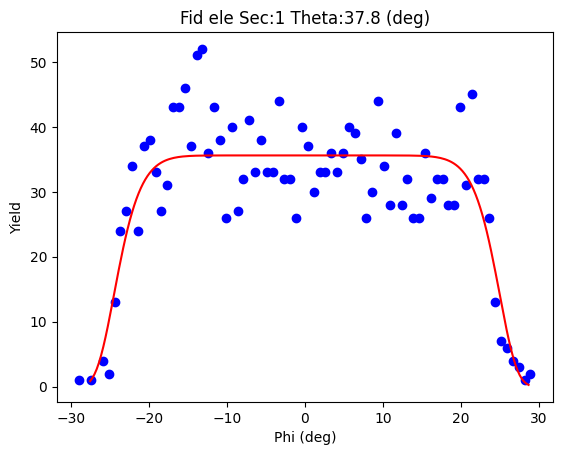

...........Theta: 39.0 ............
Binning| Sec: 0  Ybin: 32
Sum of plot 2112.0
Initial Bounds: [-27.99682561707705, 28.49810527395352]
Sum of initial fit area: 2110.0
max at  44.0
initial max 35.600584819479245
initial guesses: [44.0, 0.2506398284382346, 17.587091153184765, 11.999999999999998]
fit bounds [-27.99682561707705, 28.49810527395352]
(array([33.97157169,  0.18607352, 17.23199274, 12.        ]), array([[ 7.27668234e-01,  7.08284105e-04, -3.71641067e-02,
        -7.28257640e-01],
       [ 7.08284105e-04,  9.02366726e-02,  5.76009355e-04,
        -9.06862784e-03],
       [-3.71641067e-02,  5.76009355e-04,  5.33111818e-02,
        -1.13795660e-01],
       [-7.28257640e-01, -9.06862784e-03, -1.13795660e-01,
         6.23601275e+00]]))
[33.97157169  0.18607352 17.23199274 12.        ]
[33.97157169  0.18607352 17.23199274 12.        ]
New Bounds for next fit: [-27.491051438782318, 27.86319848804148]


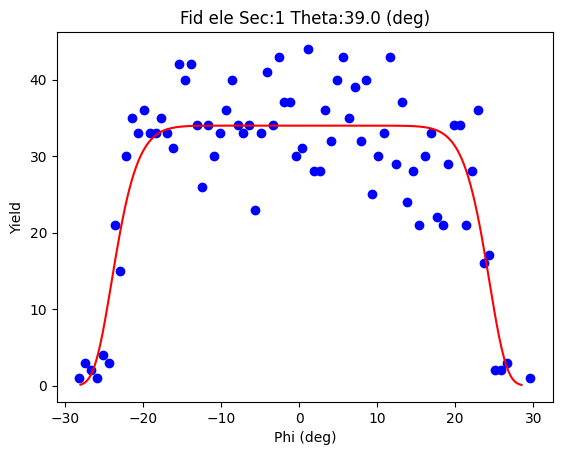

...........Theta: 40.2 ............
Binning| Sec: 0  Ybin: 33
Sum of plot 1983.0
Initial Bounds: [-27.491051438782318, 27.86319848804148]
Sum of initial fit area: 1979.0
max at  41.0
initial max 33.971571688728694
initial guesses: [41.0, 0.18607352462957963, 17.23199274386195, 11.999999999999998]
fit bounds [-27.491051438782318, 27.86319848804148]
(array([31.15429114,  0.29298107, 17.67589416, 12.        ]), array([[ 4.66085267e-01, -2.39053244e-04, -2.54718192e-02,
        -5.23513738e-01],
       [-2.39053244e-04,  7.28054221e-02, -2.55224236e-04,
         3.53518357e-03],
       [-2.54718192e-02, -2.55224236e-04,  4.36719021e-02,
        -1.04226584e-01],
       [-5.23513738e-01,  3.53518357e-03, -1.04226584e-01,
         4.96733401e+00]]))
[31.15429114  0.29298107 17.67589416 12.        ]
[31.15429114  0.29298107 17.67589416 12.        ]
New Bounds for next fit: [-28.097115121733008, 28.683077267411033]


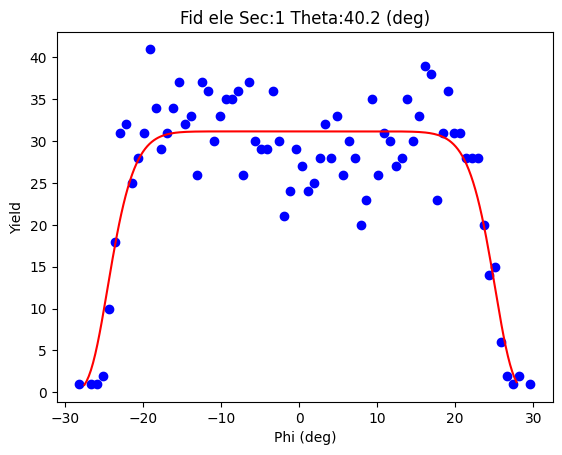

...........Theta: 41.4 ............
Binning| Sec: 0  Ybin: 34
Sum of plot 1851.0
Initial Bounds: [-28.097115121733008, 28.683077267411033]
Sum of initial fit area: 1851.0
max at  41.0
initial max 31.154291141578955
initial guesses: [41.0, 0.29298107283901265, 17.675894164192822, 11.999999999999998]
fit bounds [-28.097115121733008, 28.683077267411033]
(array([29.15030961,  0.03147542, 17.67423673, 12.        ]), array([[ 6.46841700e-01, -3.56833431e-03, -3.64697344e-02,
        -7.82850912e-01],
       [-3.56833431e-03,  1.19327330e-01, -5.82453383e-03,
         6.48299236e-02],
       [-3.64697344e-02, -5.82453383e-03,  7.28095599e-02,
        -1.96096028e-01],
       [-7.82850912e-01,  6.48299236e-02, -1.96096028e-01,
         8.09000851e+00]]))
[29.15030961  0.03147542 17.67423673 12.        ]
[29.15030961  0.03147542 17.67423673 12.        ]
New Bounds for next fit: [-28.355958690988633, 28.418909528682516]


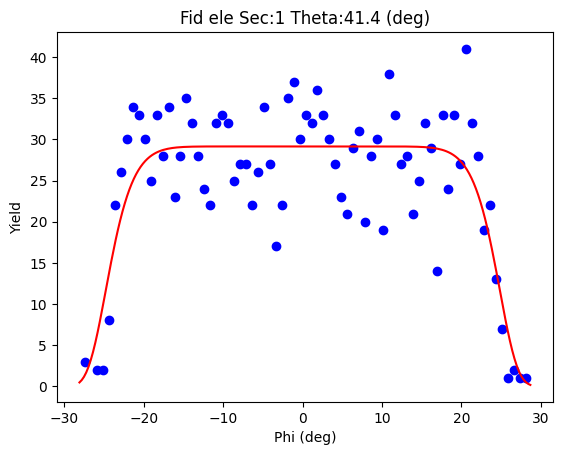

...........Theta: 42.6 ............
Binning| Sec: 0  Ybin: 35
Sum of plot 1864.0
Initial Bounds: [-28.355958690988633, 28.418909528682516]
Sum of initial fit area: 1863.0
max at  46.0
initial max 29.15030960650544
initial guesses: [46.0, 0.03147541884694245, 17.674236729581295, 11.999999999999998]
fit bounds [-28.355958690988633, 28.418909528682516]
(array([29.0683467 ,  0.43172721, 17.82578196, 12.        ]), array([[ 7.67526048e-01,  1.84580115e-03, -4.55066787e-02,
        -9.20758726e-01],
       [ 1.84580115e-03,  1.40297838e-01,  2.11576877e-03,
        -2.91727817e-02],
       [-4.55066787e-02,  2.11576877e-03,  8.40506004e-02,
        -1.97386934e-01],
       [-9.20758726e-01, -2.91727817e-02, -1.97386934e-01,
         9.35647577e+00]]))
[29.0683467   0.43172721 17.82578196 12.        ]
[29.0683467   0.43172721 17.82578196 12.        ]
New Bounds for next fit: [-28.199110919302573, 29.0625653298457]


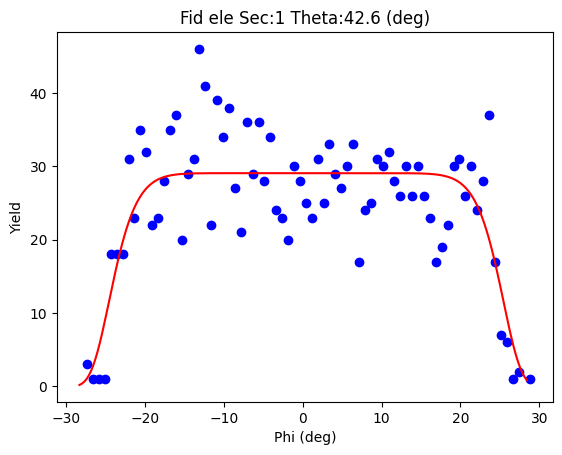

...........Theta: 43.8 ............
Binning| Sec: 0  Ybin: 36
Sum of plot 1732.0
Initial Bounds: [-28.199110919302573, 29.0625653298457]
Sum of initial fit area: 1731.0
max at  40.0
initial max 29.068346700511714
initial guesses: [40.0, 0.4317272052715624, 17.825781957683798, 11.999999999999998]
fit bounds [-28.199110919302573, 29.0625653298457]
(array([27.02706213,  0.36349422, 17.87547371, 12.        ]), array([[ 8.13147260e-01,  1.78198400e-03, -4.17409224e-02,
        -1.13671352e+00],
       [ 1.78198400e-03,  1.92249820e-01, -3.91281518e-03,
        -3.73875703e-03],
       [-4.17409224e-02, -3.91281518e-03,  1.28477028e-01,
        -4.70852763e-01],
       [-1.13671352e+00, -3.73875703e-03, -4.70852763e-01,
         1.35132317e+01]]))
[27.02706213  0.36349422 17.87547371 12.        ]
[27.02706213  0.36349422 17.87547371 12.        ]
New Bounds for next fit: [-28.347156206071965, 29.07414463998544]


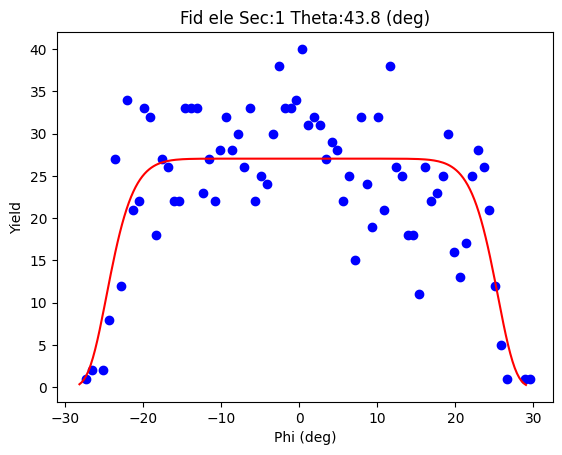

...........Theta: 45.0 ............
Binning| Sec: 0  Ybin: 37
Sum of plot 1666.0
Initial Bounds: [-28.347156206071965, 29.07414463998544]
Sum of initial fit area: 1666.0
max at  39.0
initial max 27.027062127923003
initial guesses: [39.0, 0.3634942169567376, 17.875473713950228, 11.99999999999949]
fit bounds [-28.347156206071965, 29.07414463998544]
(array([25.77455944,  0.45567076, 18.07824373, 12.        ]), array([[ 5.06711543e-01, -4.38241571e-03, -2.71349399e-02,
        -7.46192296e-01],
       [-4.38241571e-03,  1.39764274e-01, -6.25801133e-04,
         5.78282967e-02],
       [-2.71349399e-02, -6.25801133e-04,  9.46245377e-02,
        -3.50353278e-01],
       [-7.46192296e-01,  5.78282967e-02, -3.50353278e-01,
         9.39769134e+00]]))
[25.77455944  0.45567076 18.07824373 12.        ]
[25.77455944  0.45567076 18.07824373 12.        ]
New Bounds for next fit: [-28.58065826247462, 29.4919997726185]


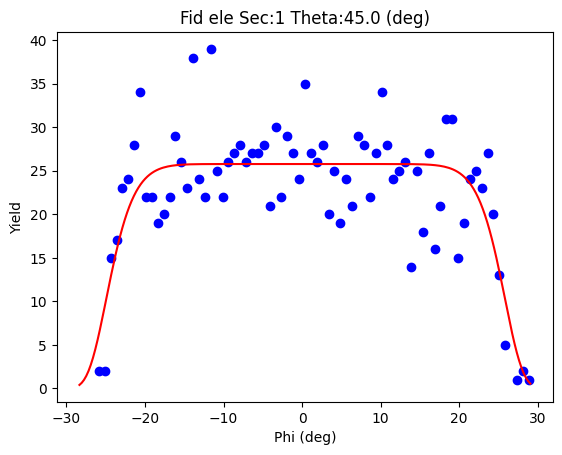

...........Theta: 46.2 ............
Binning| Sec: 0  Ybin: 38
Sum of plot 1489.0
Initial Bounds: [-28.58065826247462, 29.4919997726185]
Sum of initial fit area: 1487.0
max at  33.0
initial max 25.77455943769664
initial guesses: [33.0, 0.45567075507193816, 18.07824373377651, 11.999999999999998]
fit bounds [-28.58065826247462, 29.4919997726185]
(array([22.94762121,  0.43071287, 18.07052584, 12.        ]), array([[ 4.49803890e-01, -5.90205736e-04, -3.16674081e-02,
        -7.02302554e-01],
       [-5.90205736e-04,  1.49366495e-01,  8.51329458e-03,
        -2.79843198e-02],
       [-3.16674081e-02,  8.51329458e-03,  9.45316434e-02,
        -2.80078156e-01],
       [-7.02302554e-01, -2.79843198e-02, -2.80078156e-01,
         9.45299045e+00]]))
[22.94762121  0.43071287 18.07052584 12.        ]
[22.94762121  0.43071287 18.07052584 12.        ]
New Bounds for next fit: [-28.593220079702608, 29.45464581582092]


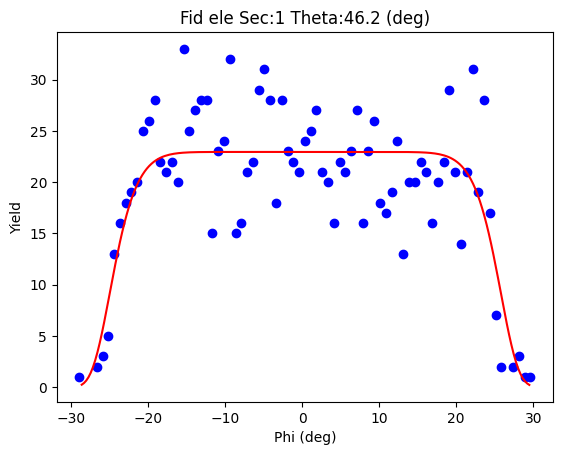

...........Theta: 47.4 ............
Binning| Sec: 0  Ybin: 39
Sum of plot 1430.0
Initial Bounds: [-28.593220079702608, 29.45464581582092]
Sum of initial fit area: 1430.0
max at  37.0
initial max 22.94762120971954
initial guesses: [37.0, 0.43071286805915665, 18.070525844549707, 11.999999999999998]
fit bounds [-28.593220079702608, 29.45464581582092]
(array([22.09803247,  0.23427567, 18.02601335, 12.        ]), array([[ 4.88343494e-01, -4.15590991e-03, -3.54200115e-02,
        -7.95714376e-01],
       [-4.15590991e-03,  1.66912501e-01, -1.11019216e-02,
         1.08394784e-01],
       [-3.54200115e-02, -1.11019216e-02,  1.03774329e-01,
        -3.03895308e-01],
       [-7.95714376e-01,  1.08394784e-01, -3.03895308e-01,
         1.10359656e+01]]))
[22.09803247  0.23427567 18.02601335 12.        ]
[22.09803247  0.23427567 18.02601335 12.        ]
New Bounds for next fit: [-28.718163638127088, 29.186714975691203]


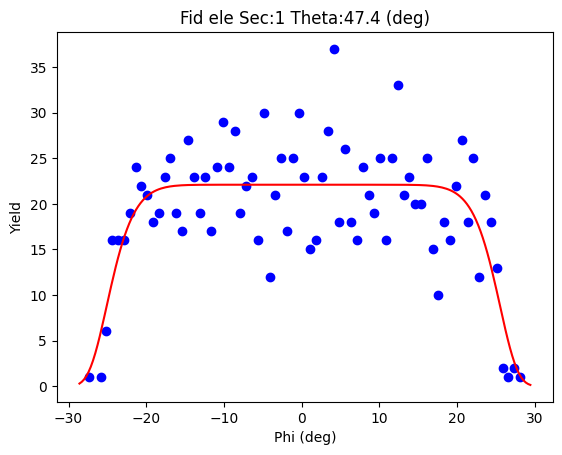

...........Theta: 48.6 ............
Binning| Sec: 0  Ybin: 40
Sum of plot 1309.0
Initial Bounds: [-28.718163638127088, 29.186714975691203]
Sum of initial fit area: 1309.0
max at  32.0
initial max 22.098032466059045
initial guesses: [32.0, 0.2342756687820572, 18.026013349049062, 11.999999999999998]
fit bounds [-28.718163638127088, 29.186714975691203]
(array([20.5368778 , -0.27096218, 17.78434953, 12.        ]), array([[ 5.34355787e-01, -9.93049181e-03, -3.23831064e-02,
        -1.02631267e+00],
       [-9.93049181e-03,  2.19075255e-01, -2.68008909e-02,
         2.72173107e-01],
       [-3.23831064e-02, -2.68008909e-02,  1.46733263e-01,
        -5.94578512e-01],
       [-1.02631267e+00,  2.72173107e-01, -5.94578512e-01,
         1.63239604e+01]]))
[20.5368778  -0.27096218 17.78434953 12.        ]
[20.5368778  -0.27096218 17.78434953 12.        ]
New Bounds for next fit: [-28.835253706360497, 28.29332935411255]


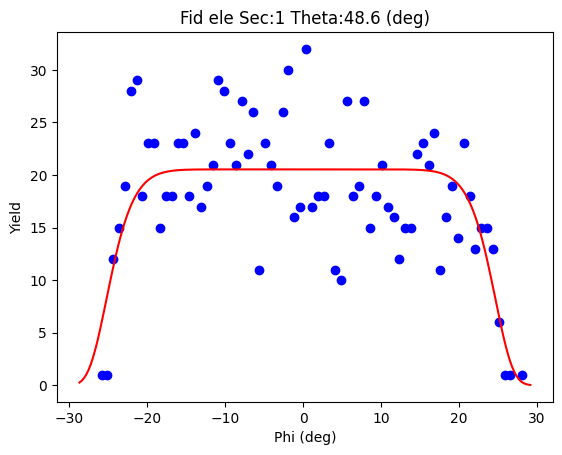

...........Theta: 49.8 ............
Binning| Sec: 0  Ybin: 41
Sum of plot 1213.0
Initial Bounds: [-28.835253706360497, 28.29332935411255]
Sum of initial fit area: 1213.0
max at  30.0
initial max 20.536877801711423
initial guesses: [30.0, -0.27096217612397167, 17.78434953172661, 11.999999999999998]
fit bounds [-28.835253706360497, 28.29332935411255]
(array([18.46466308,  0.06964987, 18.44578847, 12.        ]), array([[ 4.03336080e-01, -5.10351692e-04, -3.74872255e-02,
        -7.77140423e-01],
       [-5.10351692e-04,  2.51785591e-01, -4.79642391e-02,
         1.92984297e-01],
       [-3.74872255e-02, -4.79642391e-02,  1.59898096e-01,
        -4.55212826e-01],
       [-7.77140423e-01,  1.92984297e-01, -4.55212826e-01,
         1.31988096e+01]]))
[18.46466308  0.06964987 18.44578847 12.        ]
[18.46466308  0.06964987 18.44578847 12.        ]
New Bounds for next fit: [-29.55701026392093, 29.696310012694184]


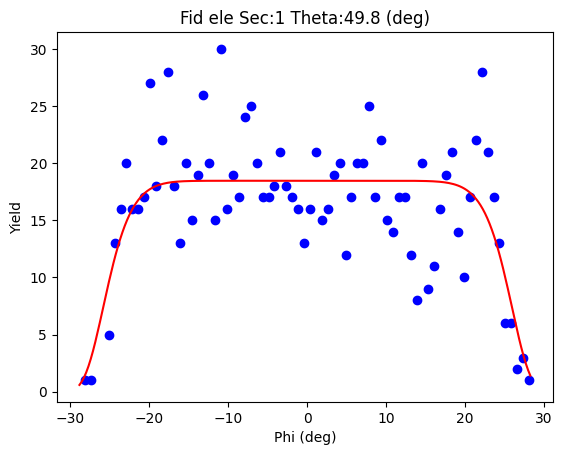

...........Theta: 51.0 ............
Binning| Sec: 0  Ybin: 42
Sum of plot 1078.0
Initial Bounds: [-29.55701026392093, 29.696310012694184]
Sum of initial fit area: 1077.0
max at  26.0
initial max 18.464663082462447
initial guesses: [26.0, 0.06964987438662683, 18.445788469831182, 11.999999999999998]
fit bounds [-29.55701026392093, 29.696310012694184]
(array([16.65861257,  0.06337911, 18.14806147, 12.        ]), array([[ 3.89420958e-01,  1.74830107e-03, -1.71712147e-03,
        -1.16449597e+00],
       [ 1.74830107e-03,  2.83873022e-01,  8.75920532e-03,
        -7.08014256e-02],
       [-1.71712147e-03,  8.75920532e-03,  2.71840418e-01,
        -1.63830727e+00],
       [-1.16449597e+00, -7.08014256e-02, -1.63830727e+00,
         2.69160547e+01]]))
[16.65861257  0.06337911 18.14806147 12.        ]
[16.65861257  0.06337911 18.14806147 12.        ]
New Bounds for next fit: [-29.08508750026061, 29.211845718275487]


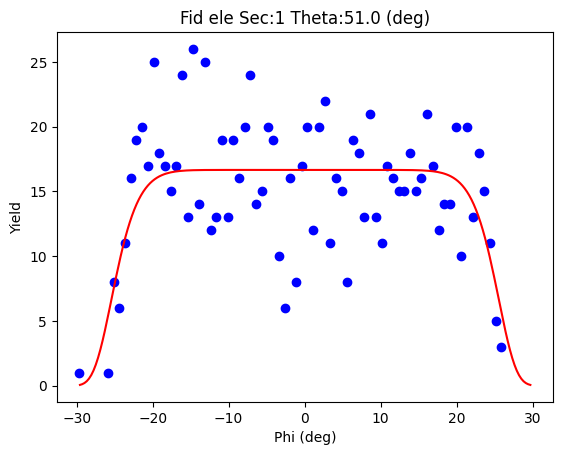

...........Theta: 52.2 ............
Binning| Sec: 0  Ybin: 43
Sum of plot 1036.0
Initial Bounds: [-29.08508750026061, 29.211845718275487]
Sum of initial fit area: 1035.0
max at  29.0
initial max 16.658612573103238
initial guesses: [29.0, 0.06337910900743966, 18.148061468436932, 11.999999999999998]
fit bounds [-29.08508750026061, 29.211845718275487]
(array([16.16929538,  0.02617063, 17.90875444, 12.        ]), array([[ 3.99344105e-01, -3.90626151e-03, -3.03044873e-02,
        -9.79224174e-01],
       [-3.90626151e-03,  2.76049418e-01, -2.88720978e-02,
         1.99763975e-01],
       [-3.03044873e-02, -2.88720978e-02,  1.90989510e-01,
        -7.80360698e-01],
       [-9.79224174e-01,  1.99763975e-01, -7.80360698e-01,
         1.99975334e+01]]))
[16.16929538  0.02617063 17.90875444 12.        ]
[16.16929538  0.02617063 17.90875444 12.        ]
New Bounds for next fit: [-28.737933562141347, 28.790274820719414]


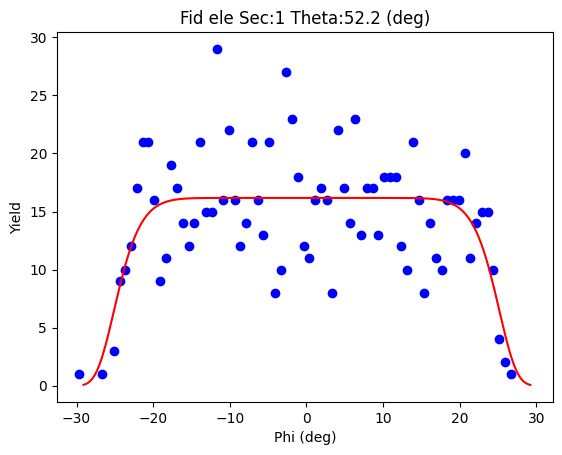

...........Theta: 53.4 ............
Binning| Sec: 0  Ybin: 44
Sum of plot 899.0
Initial Bounds: [-28.737933562141347, 28.790274820719414]
Sum of initial fit area: 897.0
max at  22.0
initial max 16.169295380232956
initial guesses: [22.0, 0.026170629289033, 17.90875444489501, 11.999999999999998]
fit bounds [-28.737933562141347, 28.790274820719414]
(array([13.83378943,  0.37107016, 18.15689148, 12.        ]), array([[ 2.81368416e-01, -1.39798756e-02, -2.09371040e-02,
        -8.33400238e-01],
       [-1.39798756e-02,  3.11468377e-01, -7.85768077e-02,
         6.56395169e-01],
       [-2.09371040e-02, -7.85768077e-02,  2.18044577e-01,
        -9.86797731e-01],
       [-8.33400238e-01,  6.56395169e-01, -9.86797731e-01,
         2.08484545e+01]]))
[13.83378943  0.37107016 18.15689148 12.        ]
[13.83378943  0.37107016 18.15689148 12.        ]
New Bounds for next fit: [-28.79157875511995, 29.53371907084501]


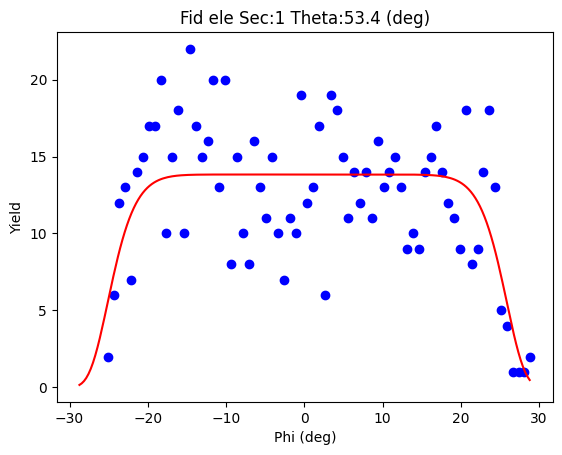

...........Theta: 54.6 ............
Binning| Sec: 0  Ybin: 45
Sum of plot 818.0
Initial Bounds: [-28.79157875511995, 29.53371907084501]
Sum of initial fit area: 818.0
max at  26.0
initial max 13.833789432138763
initial guesses: [26.0, 0.37107015786252795, 18.156891480767385, 11.999999999999998]
fit bounds [-28.79157875511995, 29.53371907084501]
(array([12.84981476, -0.13055962, 17.81732698, 12.        ]), array([[ 2.91852271e-01, -1.34180084e-02, -1.77901582e-02,
        -9.70450428e-01],
       [-1.34180084e-02,  3.64462376e-01, -8.31818089e-02,
         6.92525892e-01],
       [-1.77901582e-02, -8.31818089e-02,  2.80478274e-01,
        -1.41504670e+00],
       [-9.70450428e-01,  6.92525892e-01, -1.41504670e+00,
         2.71816060e+01]]))
[12.84981476 -0.13055962 17.81732698 12.        ]
[12.84981476 -0.13055962 17.81732698 12.        ]
New Bounds for next fit: [-28.747817801060418, 28.486698557802615]


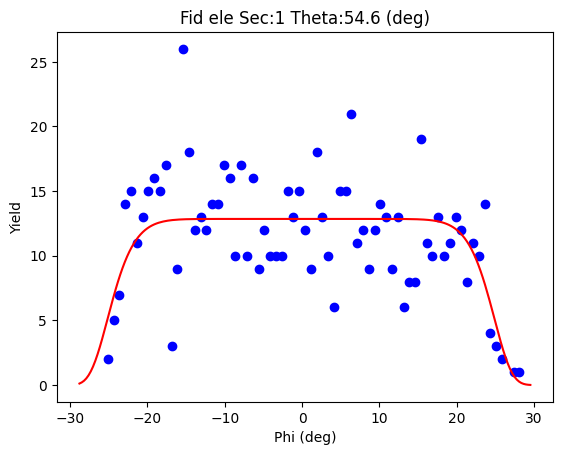

==========Sec  2 ===============
...........Theta: 10.2 ............
Binning| Sec: 1  Ybin: 8
Sum of plot 1103.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 977.0
max at  62.0
initial max 12.849814763143463
initial guesses: [62.0, -0.13055962162889964, 17.817326978473744, 11.999999999999998]
fit bounds [-10.0, 10.0]
(array([47.22973518, -0.2946667 ,  6.20807235,  4.20990958]), array([[ 5.4600997 , -0.01957648, -0.11830102, -1.55885266],
       [-0.01957648,  0.08192534, -0.00741982,  0.03106396],
       [-0.11830102, -0.00741982,  0.07404409, -0.1096192 ],
       [-1.55885266,  0.03106396, -0.1096192 ,  1.47837385]]))
[47.22973518 -0.2946667   6.20807235  4.20990958]
[47.22973518 -0.2946667   6.20807235  4.20990958]
New Bounds for next fit: [-12.91339803283144, 12.324064623368587]


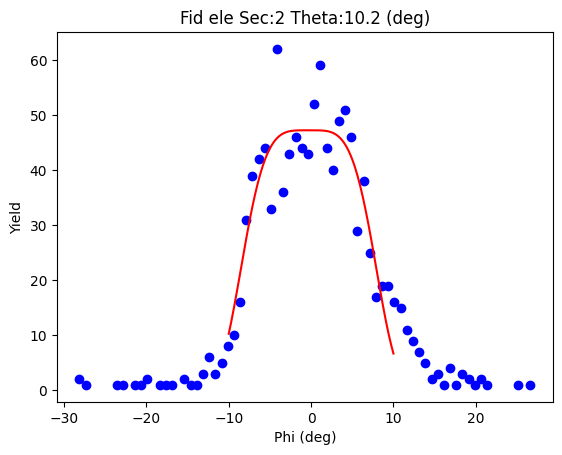

...........Theta: 11.4 ............
Binning| Sec: 1  Ybin: 9
Sum of plot 1424.0
Initial Bounds: [-12.91339803283144, 12.324064623368587]
Sum of initial fit area: 1302.0
max at  58.0
initial max 47.229735176668726
initial guesses: [58.0, -0.2946667047314264, 6.208072349711674, 4.20990958047152]
fit bounds [-12.91339803283144, 12.324064623368587]
(array([49.47025431, -0.20715144,  8.02156565,  3.9066386 ]), array([[ 2.2972341 ,  0.00501003, -0.0509969 , -0.60883314],
       [ 0.00501003,  0.05350573,  0.00259299, -0.00688937],
       [-0.0509969 ,  0.00259299,  0.0551439 , -0.06569735],
       [-0.60883314, -0.00688937, -0.06569735,  0.50038974]]))
[49.47025431 -0.20715144  8.02156565  3.9066386 ]
[49.47025431 -0.20715144  8.02156565  3.9066386 ]
New Bounds for next fit: [-16.977733878466896, 16.563430995768233]


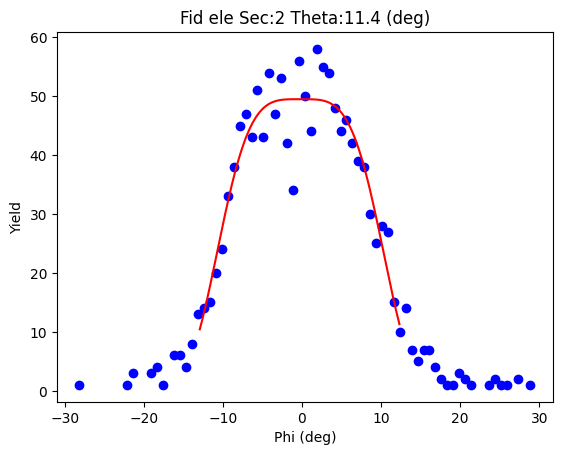

...........Theta: 12.6 ............
Binning| Sec: 1  Ybin: 10
Sum of plot 1659.0
Initial Bounds: [-16.977733878466896, 16.563430995768233]
Sum of initial fit area: 1595.0
max at  60.0
initial max 49.470254305764
initial guesses: [60.0, -0.20715144134933336, 8.021565647826254, 3.9066385986166403]
fit bounds [-16.977733878466896, 16.563430995768233]
(array([48.76847551, -0.25310732,  9.4414619 ,  5.02241243]), array([[ 1.75829074e+00,  4.20175955e-04, -8.50807465e-02,
        -4.56553249e-01],
       [ 4.20175955e-04,  4.96776036e-02,  9.98242874e-05,
        -6.69647727e-04],
       [-8.50807465e-02,  9.98242874e-05,  3.35187690e-02,
        -1.35067211e-03],
       [-4.56553249e-01, -6.69647727e-04, -1.35067211e-03,
         4.82388166e-01]]))
[48.76847551 -0.25310732  9.4414619   5.02241243]
[48.76847551 -0.25310732  9.4414619   5.02241243]
New Bounds for next fit: [-18.350309364483397, 17.844094726600975]


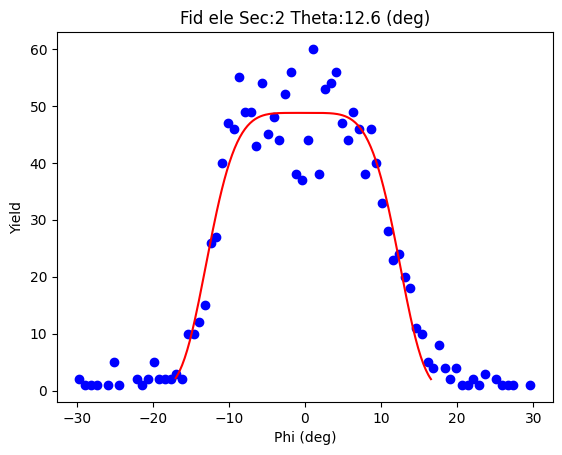

...........Theta: 13.8 ............
Binning| Sec: 1  Ybin: 11
Sum of plot 1952.0
Initial Bounds: [-18.350309364483397, 17.844094726600975]
Sum of initial fit area: 1866.0
max at  68.0
initial max 48.76847551430374
initial guesses: [68.0, -0.2531073189412108, 9.44146189685028, 5.0224124257373415]
fit bounds [-18.350309364483397, 17.844094726600975]
(array([51.91113187, -0.79476834, 10.62661679,  4.30347301]), array([[ 3.9328861 , -0.01788374, -0.19968246, -0.89262103],
       [-0.01788374,  0.13401153, -0.00707911,  0.02320846],
       [-0.19968246, -0.00707911,  0.10040035, -0.02906868],
       [-0.89262103,  0.02320846, -0.02906868,  0.71018394]]))
[51.91113187 -0.79476834 10.62661679  4.30347301]
[51.91113187 -0.79476834 10.62661679  4.30347301]
New Bounds for next fit: [-22.225091599865724, 20.635554914657494]


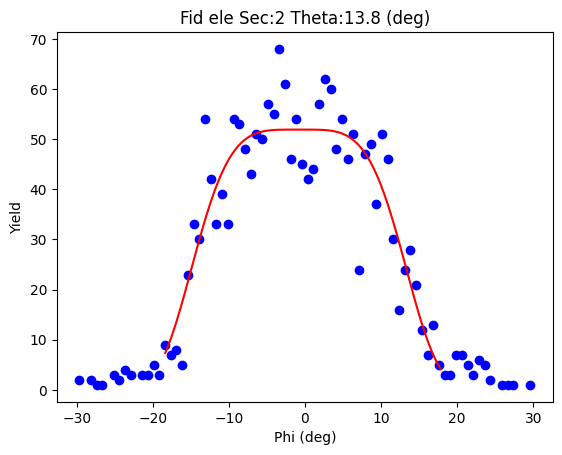

...........Theta: 15.0 ............
Binning| Sec: 1  Ybin: 12
Sum of plot 2095.0
Initial Bounds: [-22.225091599865724, 20.635554914657494]
Sum of initial fit area: 2058.0
max at  72.0
initial max 51.911131869223134
initial guesses: [72.0, -0.794768342604115, 10.626616793867612, 4.3034730070284235]
fit bounds [-22.225091599865724, 20.635554914657494]
(array([50.56890509, -0.54051237, 11.65539758,  5.3228158 ]), array([[ 1.73184192e+00,  1.56292826e-04, -9.68668852e-02,
        -4.51336940e-01],
       [ 1.56292826e-04,  6.80052341e-02,  3.50555721e-05,
        -2.51074180e-04],
       [-9.68668852e-02,  3.50555721e-05,  4.48123317e-02,
        -3.60445742e-04],
       [-4.51336940e-01, -2.51074180e-04, -3.60445742e-04,
         5.07589209e-01]]))
[50.56890509 -0.54051237 11.65539758  5.3228158 ]
[50.56890509 -0.54051237 11.65539758  5.3228158 ]
New Bounds for next fit: [-22.501222536127678, 21.420197802006726]


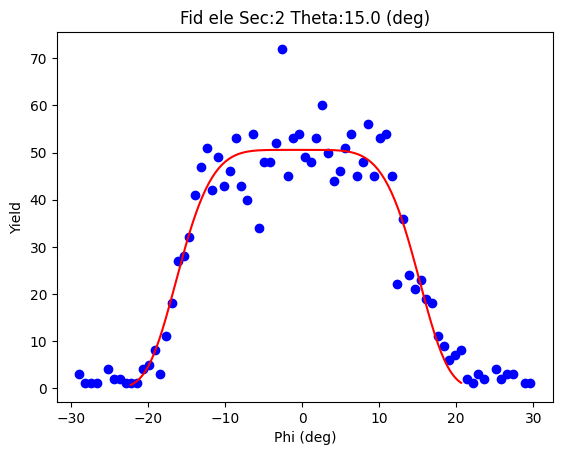

...........Theta: 16.2 ............
Binning| Sec: 1  Ybin: 13
Sum of plot 2312.0
Initial Bounds: [-22.501222536127678, 21.420197802006726]
Sum of initial fit area: 2288.0
max at  70.0
initial max 50.56890509001407
initial guesses: [70.0, -0.5405123670604742, 11.655397578059004, 5.3228158020978915]
fit bounds [-22.501222536127678, 21.420197802006726]
(array([51.46301473, -0.22224305, 12.43149698,  7.82218015]), array([[ 1.33806138e+00,  7.47653227e-06, -5.24620770e-02,
        -5.35847080e-01],
       [ 7.47653227e-06,  4.87073011e-02,  1.78879309e-06,
        -2.41516545e-05],
       [-5.24620770e-02,  1.78879309e-06,  2.97616837e-02,
        -2.01668815e-02],
       [-5.35847080e-01, -2.41516545e-05, -2.01668815e-02,
         1.27439918e+00]]))
[51.46301473 -0.22224305 12.43149698  7.82218015]
[51.46301473 -0.22224305 12.43149698  7.82218015]
New Bounds for next fit: [-21.593438388961616, 21.148952282786972]


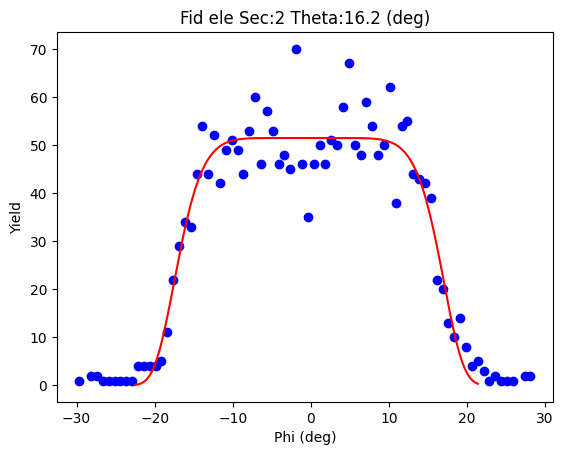

...........Theta: 17.4 ............
Binning| Sec: 1  Ybin: 14
Sum of plot 2469.0
Initial Bounds: [-21.593438388961616, 21.148952282786972]
Sum of initial fit area: 2411.0
max at  72.0
initial max 51.46301472868007
initial guesses: [72.0, -0.22224305308732314, 12.431496978687825, 7.822180152935076]
fit bounds [-21.593438388961616, 21.148952282786972]
(array([52.34167204, -0.36977495, 13.14470831,  6.6885189 ]), array([[ 2.08905702e+00,  5.40057129e-05, -8.87156315e-02,
        -7.50956975e-01],
       [ 5.40057129e-05,  9.02971852e-02,  2.50662001e-05,
        -1.55156595e-04],
       [-8.87156315e-02,  2.50662001e-05,  5.89290412e-02,
        -4.47178766e-02],
       [-7.50956975e-01, -1.55156595e-04, -4.47178766e-02,
         1.35649434e+00]]))
[52.34167204 -0.36977495 13.14470831  6.6885189 ]
[52.34167204 -0.36977495 13.14470831  6.6885189 ]
New Bounds for next fit: [-23.727350793761595, 22.98780089731502]


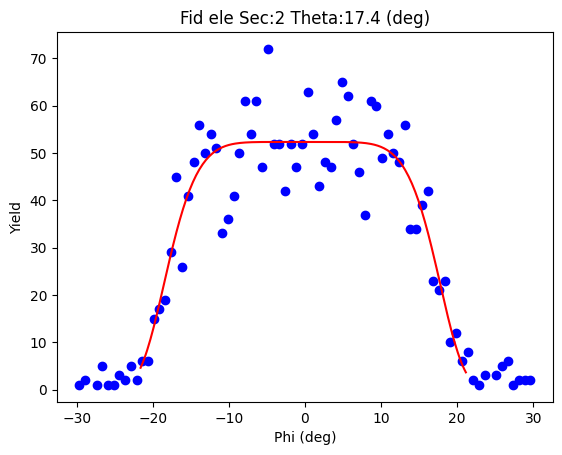

...........Theta: 18.6 ............
Binning| Sec: 1  Ybin: 15
Sum of plot 2487.0
Initial Bounds: [-23.727350793761595, 22.98780089731502]
Sum of initial fit area: 2440.0
max at  65.0
initial max 52.341672042016114
initial guesses: [65.0, -0.36977494822328655, 13.144708313780217, 6.688518903862527]
fit bounds [-23.727350793761595, 22.98780089731502]
(array([49.44702718, -0.30927781, 13.79517714,  8.51923517]), array([[ 1.13821007e+00,  1.30664436e-05, -4.70098633e-02,
        -5.23941238e-01],
       [ 1.30664436e-05,  5.27361486e-02,  4.14114357e-06,
        -5.36193211e-05],
       [-4.70098633e-02,  4.14114357e-06,  3.18893631e-02,
        -2.72491063e-02],
       [-5.23941238e-01, -5.36193211e-05, -2.72491063e-02,
         1.53928175e+00]]))
[49.44702718 -0.30927781 13.79517714  8.51923517]
[49.44702718 -0.30927781 13.79517714  8.51923517]
New Bounds for next fit: [-23.64896363668366, 23.030408017710634]


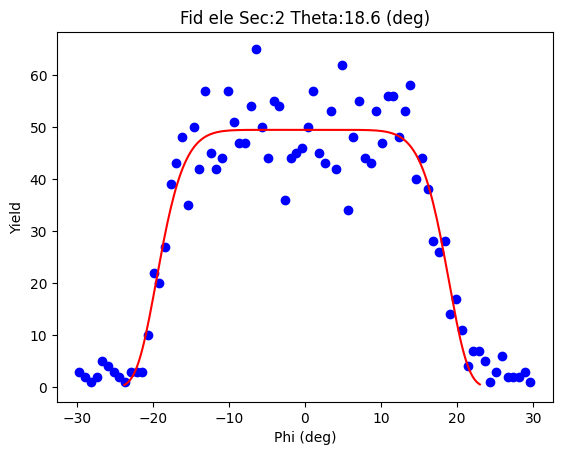

...........Theta: 19.8 ............
Binning| Sec: 1  Ybin: 16
Sum of plot 2499.0
Initial Bounds: [-23.64896363668366, 23.030408017710634]
Sum of initial fit area: 2452.0
max at  61.0
initial max 49.447027180334906
initial guesses: [61.0, -0.3092778094865145, 13.795177141284709, 8.519235165792761]
fit bounds [-23.64896363668366, 23.030408017710634]
(array([47.71192318, -0.23000973, 14.3049275 ,  9.42258558]), array([[ 1.32563384e+00,  1.21057601e-04, -5.25678739e-02,
        -7.12656937e-01],
       [ 1.21057601e-04,  6.68991495e-02,  4.79593952e-05,
        -6.52229124e-04],
       [-5.25678739e-02,  4.79593952e-05,  4.00835092e-02,
        -4.78923510e-02],
       [-7.12656937e-01, -6.52229124e-04, -4.78923510e-02,
         2.66081697e+00]]))
[47.71192318 -0.23000973 14.3049275   9.42258558]
[47.71192318 -0.23000973 14.3049275   9.42258558]
New Bounds for next fit: [-24.019743692994858, 23.55972422773882]


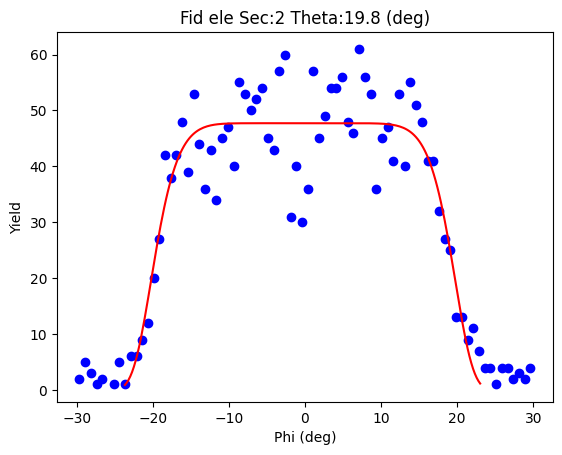

...........Theta: 21.0 ............
Binning| Sec: 1  Ybin: 17
Sum of plot 2552.0
Initial Bounds: [-24.019743692994858, 23.55972422773882]
Sum of initial fit area: 2503.0
max at  59.0
initial max 47.711923180613944
initial guesses: [59.0, -0.23000973262801844, 14.304927496084463, 9.422585575386572]
fit bounds [-24.019743692994858, 23.55972422773882]
(array([47.35705583, -0.05993877, 14.61862545, 10.98175171]), array([[ 1.22584197e+00,  2.66801637e-04, -4.24736286e-02,
        -7.89509824e-01],
       [ 2.66801637e-04,  5.95703541e-02,  1.16292067e-04,
        -1.98085881e-03],
       [-4.24736286e-02,  1.16292067e-04,  3.52414878e-02,
        -6.57548667e-02],
       [-7.89509824e-01, -1.98085881e-03, -6.57548667e-02,
         4.03752743e+00]]))
[47.35705583 -0.05993877 14.61862545 10.98175171]
[47.35705583 -0.05993877 14.61862545 10.98175171]
New Bounds for next fit: [-23.818316941994464, 23.698439405872985]


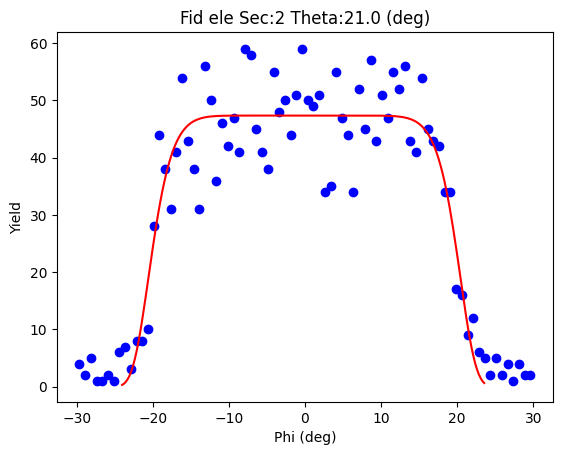

...........Theta: 22.2 ............
Binning| Sec: 1  Ybin: 18
Sum of plot 2591.0
Initial Bounds: [-23.818316941994464, 23.698439405872985]
Sum of initial fit area: 2547.0
max at  69.0
initial max 47.35705582985406
initial guesses: [69.0, -0.0599387680607389, 14.61862545136199, 10.981751707014459]
fit bounds [-23.818316941994464, 23.698439405872985]
(array([ 4.79570718e+01, -2.59644523e-02,  1.48978126e+01,  9.00881250e+00]), array([[ 1.39104724e+00, -9.72981305e-05, -5.77887038e-02,
        -7.26740733e-01],
       [-9.72981305e-05,  7.77592405e-02, -4.90941986e-05,
         5.12421908e-04],
       [-5.77887038e-02, -4.90941986e-05,  4.73591680e-02,
        -5.61189401e-02],
       [-7.26740733e-01,  5.12421908e-04, -5.61189401e-02,
         2.50506869e+00]]))
[ 4.79570718e+01 -2.59644523e-02  1.48978126e+01  9.00881250e+00]
[ 4.79570718e+01 -2.59644523e-02  1.48978126e+01  9.00881250e+00]
New Bounds for next fit: [-24.986815055413324, 24.934886150881738]


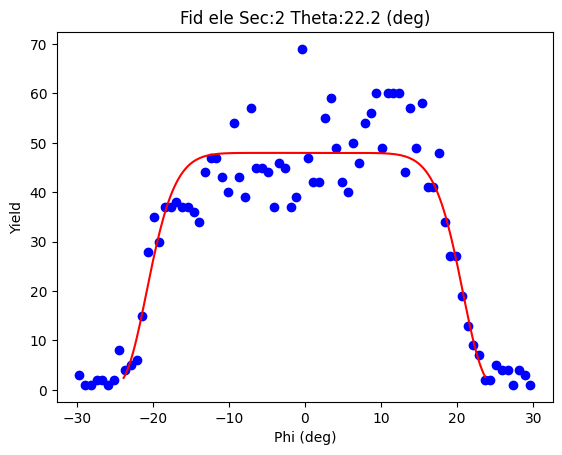

...........Theta: 23.4 ............
Binning| Sec: 1  Ybin: 19
Sum of plot 2606.0
Initial Bounds: [-24.986815055413324, 24.934886150881738]
Sum of initial fit area: 2583.0
max at  67.0
initial max 47.95707184756452
initial guesses: [67.0, -0.02596445226579328, 14.897812574934806, 9.008812498090403]
fit bounds [-24.986815055413324, 24.934886150881738]
(array([46.67017219,  0.20521396, 15.27675261, 12.        ]), array([[ 8.66827944e-01,  3.57224517e-05, -2.92518683e-02,
        -6.20965873e-01],
       [ 3.57224517e-05,  4.45948789e-02,  1.50220943e-05,
        -3.09321424e-04],
       [-2.92518683e-02,  1.50220943e-05,  2.61451744e-02,
        -5.77706265e-02],
       [-6.20965873e-01, -3.09321424e-04, -5.77706265e-02,
         3.83522518e+00]]))
[46.67017219  0.20521396 15.27675261 12.        ]
[46.67017219  0.20521396 15.27675261 12.        ]
New Bounds for next fit: [-24.331506632371976, 24.741934542912]


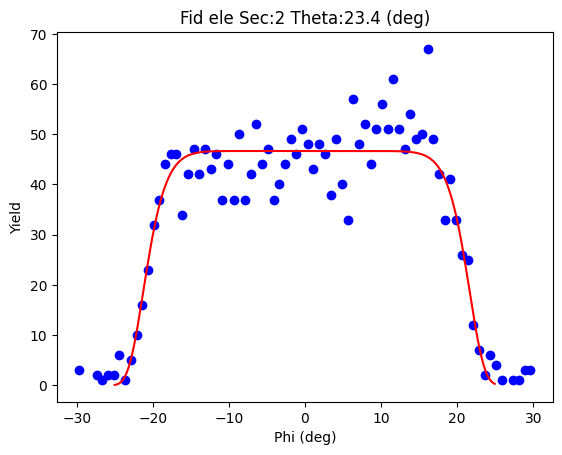

...........Theta: 24.6 ............
Binning| Sec: 1  Ybin: 20
Sum of plot 2321.0
Initial Bounds: [-24.331506632371976, 24.741934542912]
Sum of initial fit area: 2287.0
max at  57.0
initial max 46.67017218998735
initial guesses: [57.0, 0.20521395527001102, 15.276752613696772, 11.999999999999998]
fit bounds [-24.331506632371976, 24.741934542912]
(array([39.83472903,  0.25824623, 15.95066668, 12.        ]), array([[ 9.75906454e-01, -9.35230342e-04, -3.49636029e-02,
        -8.91681657e-01],
       [-9.35230342e-04,  7.70720956e-02, -8.13015914e-04,
         1.14160948e-02],
       [-3.49636029e-02, -8.13015914e-04,  4.74983899e-02,
        -1.50594415e-01],
       [-8.91681657e-01,  1.14160948e-02, -1.50594415e-01,
         6.78501969e+00]]))
[39.83472903  0.25824623 15.95066668 12.        ]
[39.83472903  0.25824623 15.95066668 12.        ]
New Bounds for next fit: [-25.360879860504458, 25.877372315167758]


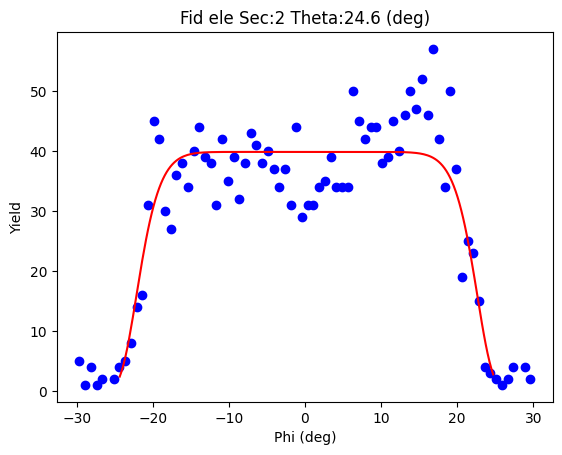

...........Theta: 25.8 ............
Binning| Sec: 1  Ybin: 21
Sum of plot 2288.0
Initial Bounds: [-25.360879860504458, 25.877372315167758]
Sum of initial fit area: 2268.0
max at  51.0
initial max 39.834729025001586
initial guesses: [51.0, 0.25824622733164904, 15.950666676299674, 11.99999999999993]
fit bounds [-25.360879860504458, 25.877372315167758]
(array([38.44599188,  0.37206677, 16.32413199, 12.        ]), array([[ 8.86971921e-01, -3.67573241e-06, -3.83692357e-02,
        -7.78383144e-01],
       [-3.67573241e-06,  7.68720094e-02, -2.33816871e-06,
         4.06288638e-05],
       [-3.83692357e-02, -2.33816871e-06,  4.52328183e-02,
        -9.76179586e-02],
       [-7.78383144e-01,  4.06288638e-05, -9.76179586e-02,
         5.86156728e+00]]))
[38.44599188  0.37206677 16.32413199 12.        ]
[38.44599188  0.37206677 16.32413199 12.        ]
New Bounds for next fit: [-25.846899770848292, 26.591033305473257]


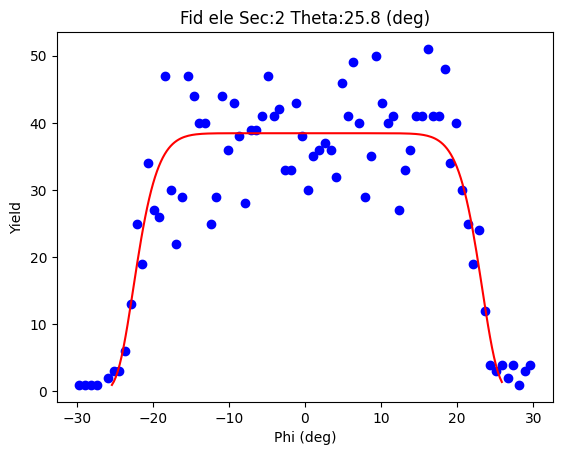

...........Theta: 27.0 ............
Binning| Sec: 1  Ybin: 22
Sum of plot 2425.0
Initial Bounds: [-25.846899770848292, 26.591033305473257]
Sum of initial fit area: 2394.0
max at  60.0
initial max 38.445991878733125
initial guesses: [60.0, 0.37206676731248123, 16.32413199472063, 11.99999999999319]
fit bounds [-25.846899770848292, 26.591033305473257]
(array([41.83722554,  0.2626177 , 16.08337144,  8.57512606]), array([[ 9.57354061e-01, -4.26549423e-04, -5.09032198e-02,
        -5.49073861e-01],
       [-4.26549423e-04,  8.45741414e-02, -2.80460693e-04,
         2.38639350e-03],
       [-5.09032198e-02, -2.80460693e-04,  5.21235905e-02,
        -5.34768406e-02],
       [-5.49073861e-01,  2.38639350e-03, -5.34768406e-02,
         1.98131612e+00]]))
[41.83722554  0.2626177  16.08337144  8.57512606]
[41.83722554  0.2626177  16.08337144  8.57512606]
New Bounds for next fit: [-26.91662728858843, 27.441862691121855]


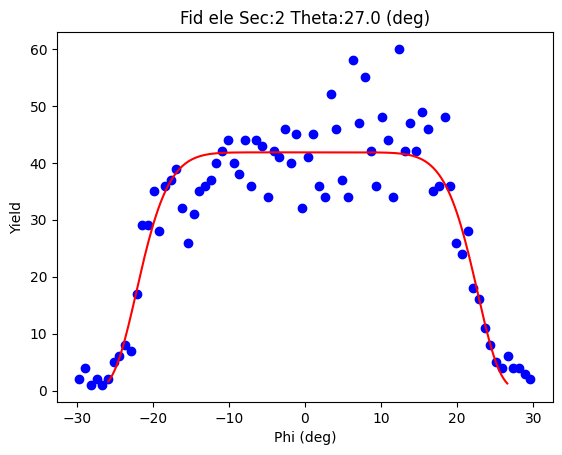

...........Theta: 28.2 ............
Binning| Sec: 1  Ybin: 23
Sum of plot 2574.0
Initial Bounds: [-26.91662728858843, 27.441862691121855]
Sum of initial fit area: 2557.0
max at  57.0
initial max 41.83722553645728
initial guesses: [57.0, 0.2626177012667128, 16.083371444428085, 8.575126061709321]
fit bounds [-26.91662728858843, 27.441862691121855]
(array([42.8925244 ,  0.28171292, 16.45983564, 10.75807196]), array([[ 9.79732696e-01, -7.24462653e-06, -4.35560668e-02,
        -6.75552225e-01],
       [-7.24462653e-06,  7.44987195e-02, -3.24070076e-06,
         5.37440153e-05],
       [-4.35560668e-02, -3.24070076e-06,  4.40126039e-02,
        -6.60254910e-02],
       [-6.75552225e-01,  5.37440153e-05, -6.60254910e-02,
         3.64655127e+00]]))
[42.8925244   0.28171292 16.45983564 10.75807196]
[42.8925244   0.28171292 16.45983564 10.75807196]
New Bounds for next fit: [-26.546483207758165, 27.10990904142922]


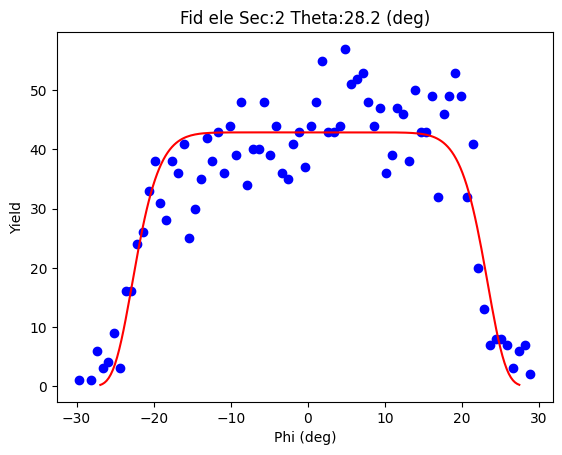

...........Theta: 29.4 ............
Binning| Sec: 1  Ybin: 24
Sum of plot 2559.0
Initial Bounds: [-26.546483207758165, 27.10990904142922]
Sum of initial fit area: 2537.0
max at  60.0
initial max 42.89252440252388
initial guesses: [60.0, 0.2817129168355289, 16.45983563977381, 10.758071960253824]
fit bounds [-26.546483207758165, 27.10990904142922]
(array([42.93737694,  0.20114326, 16.38254012, 12.        ]), array([[ 9.42110582e-01,  2.63218873e-03, -3.41417623e-02,
        -7.66393778e-01],
       [ 2.63218873e-03,  6.80107571e-02,  2.51092765e-03,
        -3.15384426e-02],
       [-3.41417623e-02,  2.51092765e-03,  4.11582670e-02,
        -1.12855012e-01],
       [-7.66393778e-01, -3.15384426e-02, -1.12855012e-01,
         5.33023795e+00]]))
[42.93737694  0.20114326 16.38254012 12.        ]
[42.93737694  0.20114326 16.38254012 12.        ]
New Bounds for next fit: [-26.11163535688105, 26.513921875950746]


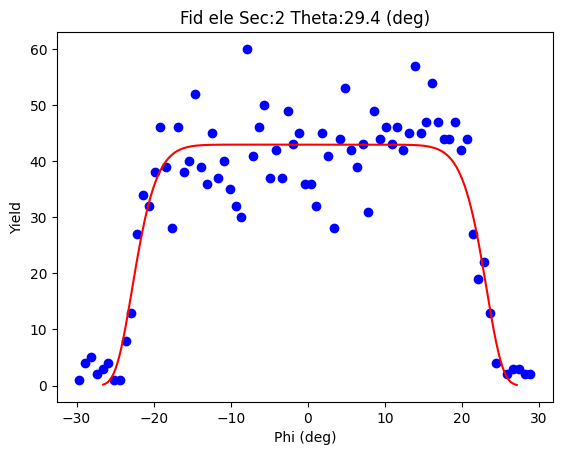

...........Theta: 30.6 ............
Binning| Sec: 1  Ybin: 25
Sum of plot 2440.0
Initial Bounds: [-26.11163535688105, 26.513921875950746]
Sum of initial fit area: 2424.0
max at  50.0
initial max 42.9373769374595
initial guesses: [50.0, 0.20114325953484966, 16.382540122512985, 11.999999999995085]
fit bounds [-26.11163535688105, 26.513921875950746]
(array([40.73804438,  0.55869778, 16.47646957, 12.        ]), array([[ 6.38910690e-01,  4.35951710e-04, -2.61072858e-02,
        -5.32003713e-01],
       [ 4.35951710e-04,  5.03371285e-02,  2.76836514e-04,
        -4.62126151e-03],
       [-2.61072858e-02,  2.76836514e-04,  2.97046353e-02,
        -6.55183652e-02],
       [-5.32003713e-01, -4.62126151e-03, -6.55183652e-02,
         3.79377450e+00]]))
[40.73804438  0.55869778 16.47646957 12.        ]
[40.73804438  0.55869778 16.47646957 12.        ]
New Bounds for next fit: [-25.904945401008575, 27.022340956698528]


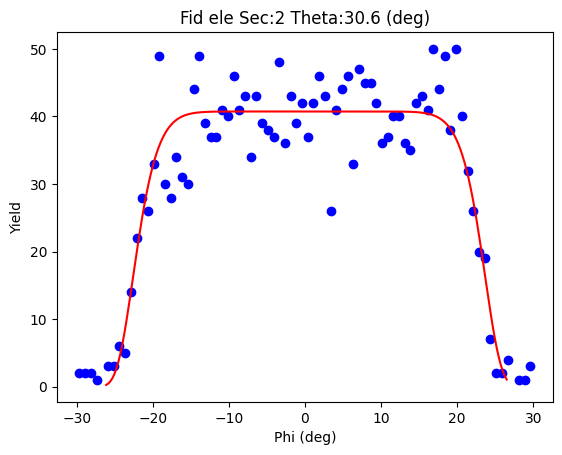

...........Theta: 31.8 ............
Binning| Sec: 1  Ybin: 26
Sum of plot 2368.0
Initial Bounds: [-25.904945401008575, 27.022340956698528]
Sum of initial fit area: 2352.0
max at  53.0
initial max 40.73804438324159
initial guesses: [53.0, 0.5586977778449751, 16.47646956961725, 11.999999999998716]
fit bounds [-25.904945401008575, 27.022340956698528]
(array([39.4471829 ,  0.62476161, 16.53948966, 12.        ]), array([[ 1.03301778e+00,  1.16869239e-04, -4.45380516e-02,
        -8.77292148e-01],
       [ 1.16869239e-04,  8.72159198e-02,  6.65216041e-05,
        -1.21878285e-03],
       [-4.45380516e-02,  6.65216041e-05,  5.11726346e-02,
        -1.05426048e-01],
       [-8.77292148e-01, -1.21878285e-03, -1.05426048e-01,
         6.41658916e+00]]))
[39.4471829   0.62476161 16.53948966 12.        ]
[39.4471829   0.62476161 16.53948966 12.        ]
New Bounds for next fit: [-25.940101146670923, 27.18962436791878]


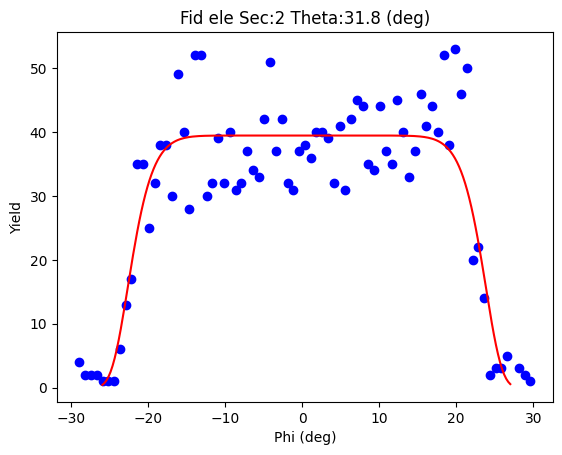

...........Theta: 33.0 ............
Binning| Sec: 1  Ybin: 27
Sum of plot 2441.0
Initial Bounds: [-25.940101146670923, 27.18962436791878]
Sum of initial fit area: 2431.0
max at  60.0
initial max 39.44718289614267
initial guesses: [60.0, 0.6247616106239281, 16.539489664498824, 11.999999999999998]
fit bounds [-25.940101146670923, 27.18962436791878]
(array([40.29278556,  0.42054263, 16.79523022, 12.        ]), array([[ 1.37090311e+00,  4.39563685e-04, -4.73982202e-02,
        -1.26593714e+00],
       [ 4.39563685e-04,  1.21603637e-01,  6.57432542e-04,
        -6.59419025e-03],
       [-4.73982202e-02,  6.57432542e-04,  7.79087485e-02,
        -2.73944846e-01],
       [-1.26593714e+00, -6.59419025e-03, -2.73944846e-01,
         9.81048277e+00]]))
[40.29278556  0.42054263 16.79523022 12.        ]
[40.29278556  0.42054263 16.79523022 12.        ]
New Bounds for next fit: [-26.5550772219703, 27.39616247362339]


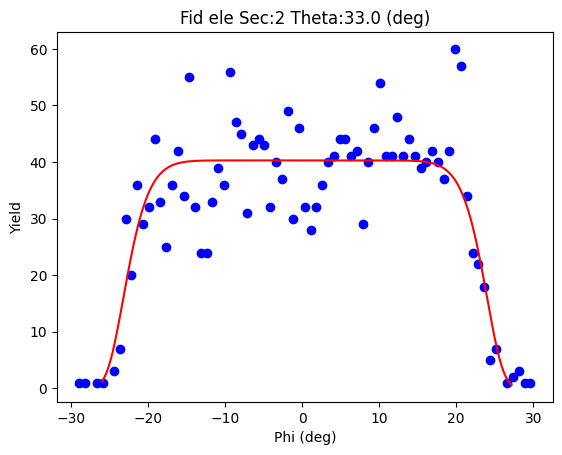

...........Theta: 34.2 ............
Binning| Sec: 1  Ybin: 28
Sum of plot 2304.0
Initial Bounds: [-26.5550772219703, 27.39616247362339]
Sum of initial fit area: 2299.0
max at  55.0
initial max 40.29278555842175
initial guesses: [55.0, 0.42054262582654695, 16.79523021603289, 11.999999999999998]
fit bounds [-26.5550772219703, 27.39616247362339]
(array([37.80183705,  0.08256653, 16.87211801, 12.        ]), array([[ 7.95246645e-01, -5.74890388e-04, -3.59140554e-02,
        -7.12858391e-01],
       [-5.74890388e-04,  7.62847418e-02, -3.99490028e-04,
         6.54818705e-03],
       [-3.59140554e-02, -3.99490028e-04,  4.49950662e-02,
        -9.64160942e-02],
       [-7.12858391e-01,  6.54818705e-03, -9.64160942e-02,
         5.47524467e+00]]))
[37.80183705  0.08256653 16.87211801 12.        ]
[37.80183705  0.08256653 16.87211801 12.        ]
New Bounds for next fit: [-27.016546478512012, 27.18167953022226]


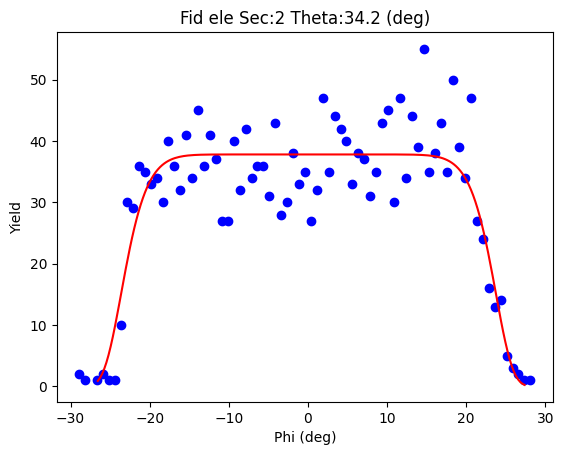

...........Theta: 35.4 ............
Binning| Sec: 1  Ybin: 29
Sum of plot 2258.0
Initial Bounds: [-27.016546478512012, 27.18167953022226]
Sum of initial fit area: 2248.0
max at  48.0
initial max 37.80183704727775
initial guesses: [48.0, 0.08256652585512557, 16.872118013473884, 11.999999999999996]
fit bounds [-27.016546478512012, 27.18167953022226]
(array([36.47657247,  0.40604292, 17.11553445, 12.        ]), array([[ 9.78531467e-01,  8.91707868e-04, -4.60198157e-02,
        -9.15018052e-01],
       [ 8.91707868e-04,  1.03897142e-01,  6.87172588e-04,
        -1.07237193e-02],
       [-4.60198157e-02,  6.87172588e-04,  6.14721917e-02,
        -1.34127820e-01],
       [-9.15018052e-01, -1.07237193e-02, -1.34127820e-01,
         7.30933713e+00]]))
[36.47657247  0.40604292 17.11553445 12.        ]
[36.47657247  0.40604292 17.11553445 12.        ]
New Bounds for next fit: [-27.084032822433247, 27.896118662167755]


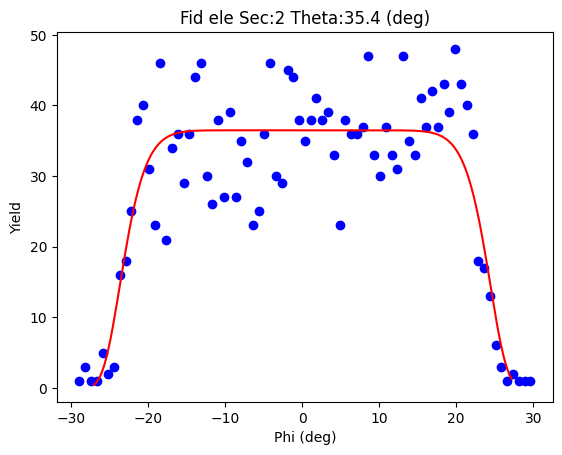

...........Theta: 36.6 ............
Binning| Sec: 1  Ybin: 30
Sum of plot 2102.0
Initial Bounds: [-27.084032822433247, 27.896118662167755]
Sum of initial fit area: 2087.0
max at  51.0
initial max 36.4765724748455
initial guesses: [51.0, 0.4060429198672551, 17.115534447518037, 11.999999999999998]
fit bounds [-27.084032822433247, 27.896118662167755]
(array([33.55061037,  0.38649449, 17.33324122, 12.        ]), array([[ 9.49305052e-01,  2.50484560e-03, -4.35202759e-02,
        -1.01583829e+00],
       [ 2.50484560e-03,  1.32991057e-01,  8.78858294e-03,
        -6.38851171e-02],
       [-4.35202759e-02,  8.78858294e-03,  8.36751412e-02,
        -2.59588961e-01],
       [-1.01583829e+00, -6.38851171e-02, -2.59588961e-01,
         9.33469605e+00]]))
[33.55061037  0.38649449 17.33324122 12.        ]
[33.55061037  0.38649449 17.33324122 12.        ]
New Bounds for next fit: [-27.453250472622, 28.226239448365856]


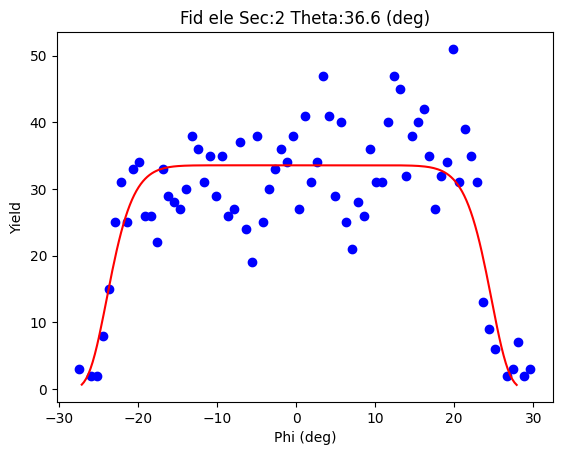

...........Theta: 37.8 ............
Binning| Sec: 1  Ybin: 31
Sum of plot 2185.0
Initial Bounds: [-27.453250472622, 28.226239448365856]
Sum of initial fit area: 2182.0
max at  48.0
initial max 33.55061036528251
initial guesses: [48.0, 0.38649448787192703, 17.3332412157834, 11.999999999999998]
fit bounds [-27.453250472622, 28.226239448365856]
(array([34.42915175,  0.52655395, 17.55978271, 12.        ]), array([[ 6.15436260e-01,  7.10727526e-05, -3.22239506e-02,
        -5.99621811e-01],
       [ 7.10727526e-05,  7.68965357e-02,  5.06419068e-05,
        -8.57259739e-04],
       [-3.22239506e-02,  5.06419068e-05,  4.51401494e-02,
        -8.81165488e-02],
       [-5.99621811e-01, -8.57259739e-04, -8.81165488e-02,
         5.02792515e+00]]))
[34.42915175  0.52655395 17.55978271 12.        ]
[34.42915175  0.52655395 17.55978271 12.        ]
New Bounds for next fit: [-27.677050094842592, 28.730158003687258]


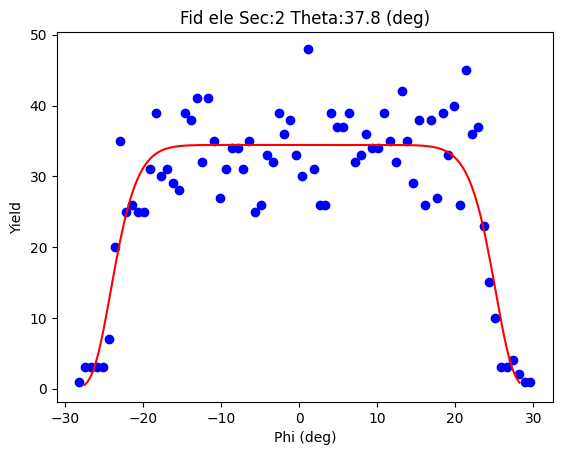

...........Theta: 39.0 ............
Binning| Sec: 1  Ybin: 32
Sum of plot 2136.0
Initial Bounds: [-27.677050094842592, 28.730158003687258]
Sum of initial fit area: 2132.0
max at  51.0
initial max 34.42915175011563
initial guesses: [51.0, 0.5265539544223343, 17.559782707566914, 11.999999999999998]
fit bounds [-27.677050094842592, 28.730158003687258]
(array([34.93285718, -0.04063139, 17.10147811,  9.20583164]), array([[ 7.53358402e-01, -4.47894377e-04, -4.95483889e-02,
        -5.42549376e-01],
       [-4.47894377e-04,  1.02908299e-01, -3.12720971e-04,
         3.23096987e-03],
       [-4.95483889e-02, -3.12720971e-04,  6.19788575e-02,
        -6.01985083e-02],
       [-5.42549376e-01,  3.23096987e-03, -6.01985083e-02,
         2.65097754e+00]]))
[34.93285718 -0.04063139 17.10147811  9.20583164]
[34.93285718 -0.04063139 17.10147811  9.20583164]
New Bounds for next fit: [-28.589894340943193, 28.508631564358613]


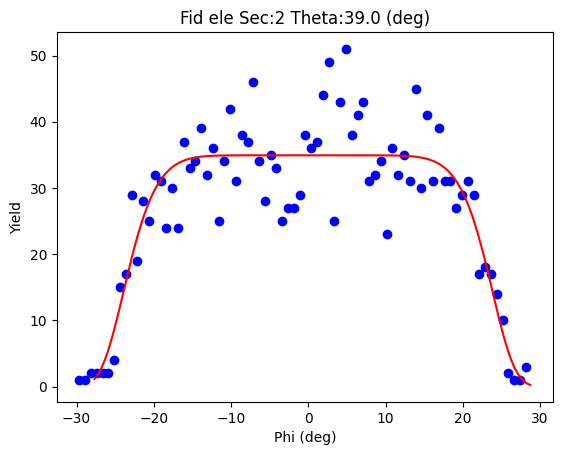

...........Theta: 40.2 ............
Binning| Sec: 1  Ybin: 33
Sum of plot 2133.0
Initial Bounds: [-28.589894340943193, 28.508631564358613]
Sum of initial fit area: 2130.0
max at  48.0
initial max 34.93285717797904
initial guesses: [48.0, -0.04063138829229189, 17.10147811148837, 9.205831638603277]
fit bounds [-28.589894340943193, 28.508631564358613]
(array([34.09428119,  0.41901842, 17.26446058, 12.        ]), array([[ 6.24678165e-01,  1.87441140e-04, -3.24316660e-02,
        -6.15115103e-01],
       [ 1.87441140e-04,  7.69595396e-02,  1.33309193e-04,
        -2.28671343e-03],
       [-3.24316660e-02,  1.33309193e-04,  4.51975531e-02,
        -9.01977346e-02],
       [-6.15115103e-01, -2.28671343e-03, -9.01977346e-02,
         5.21135600e+00]]))
[34.09428119  0.41901842 17.26446058 12.        ]
[34.09428119  0.41901842 17.26446058 12.        ]
New Bounds for next fit: [-27.310254683231587, 28.14829152025035]


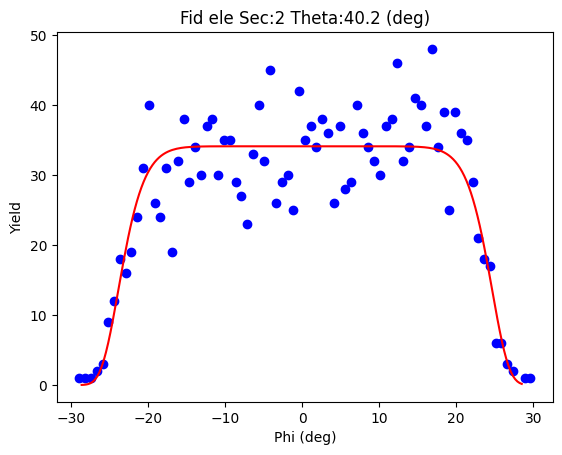

...........Theta: 41.4 ............
Binning| Sec: 1  Ybin: 34
Sum of plot 2078.0
Initial Bounds: [-27.310254683231587, 28.14829152025035]
Sum of initial fit area: 2070.0
max at  44.0
initial max 34.09428119072582
initial guesses: [44.0, 0.4190184185093808, 17.264460579252095, 11.999999999228827]
fit bounds [-27.310254683231587, 28.14829152025035]
(array([33.53444213,  0.8596549 , 17.09121765, 12.        ]), array([[ 6.18040653e-01, -5.75166443e-04, -3.10435968e-02,
        -6.35238414e-01],
       [-5.75166443e-04,  7.76914389e-02, -5.60612569e-04,
         7.95587355e-03],
       [-3.10435968e-02, -5.60612569e-04,  4.62481985e-02,
        -1.06889100e-01],
       [-6.35238414e-01,  7.95587355e-03, -1.06889100e-01,
         5.55589806e+00]]))
[33.53444213  0.8596549  17.09121765 12.        ]
[33.53444213  0.8596549  17.09121765 12.        ]
New Bounds for next fit: [-26.591364475921313, 28.310674269423263]


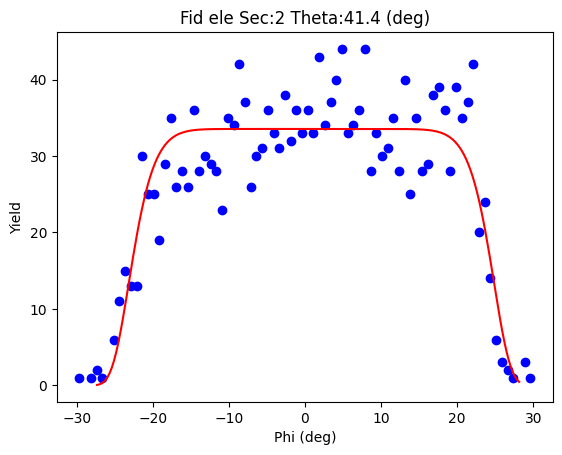

...........Theta: 42.6 ............
Binning| Sec: 1  Ybin: 35
Sum of plot 1898.0
Initial Bounds: [-26.591364475921313, 28.310674269423263]
Sum of initial fit area: 1893.0
max at  42.0
initial max 33.53444213088943
initial guesses: [42.0, 0.859654896750974, 17.091217648756437, 11.999999999999995]
fit bounds [-26.591364475921313, 28.310674269423263]
(array([29.97133355,  0.38666397, 17.58734151, 12.        ]), array([[ 5.22990864e-01,  1.28827520e-03, -2.42537313e-02,
        -6.62525229e-01],
       [ 1.28827520e-03,  9.34519100e-02,  3.60110357e-03,
        -3.00673567e-02],
       [-2.42537313e-02,  3.60110357e-03,  6.09456495e-02,
        -2.18998167e-01],
       [-6.62525229e-01, -3.00673567e-02, -2.18998167e-01,
         6.99633822e+00]]))
[29.97133355  0.38666397 17.58734151 12.        ]
[29.97133355  0.38666397 17.58734151 12.        ]
New Bounds for next fit: [-27.861203580966063, 28.63453152888733]


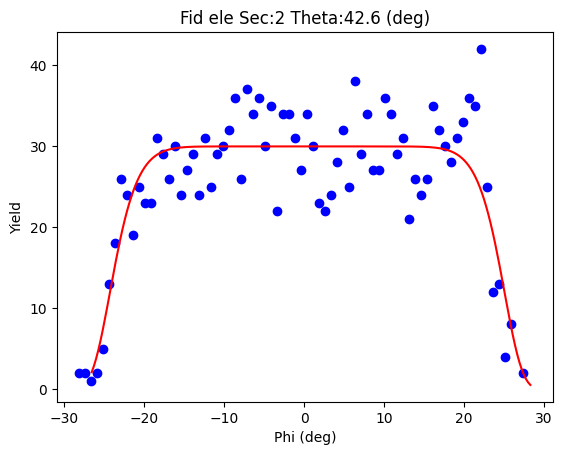

...........Theta: 43.8 ............
Binning| Sec: 1  Ybin: 36
Sum of plot 1800.0
Initial Bounds: [-27.861203580966063, 28.63453152888733]
Sum of initial fit area: 1796.0
max at  42.0
initial max 29.971333548658333
initial guesses: [42.0, 0.38666397396063373, 17.587341509624203, 11.999999999999998]
fit bounds [-27.861203580966063, 28.63453152888733]
(array([28.42496344,  0.69561643, 17.61376951, 12.        ]), array([[ 8.25329830e-01, -3.30906783e-03, -3.73909845e-02,
        -1.13568393e+00],
       [-3.30906783e-03,  1.65147311e-01, -4.76257925e-03,
         5.79518697e-02],
       [-3.73909845e-02, -4.76257925e-03,  1.10417476e-01,
        -4.32013215e-01],
       [-1.13568393e+00,  5.79518697e-02, -4.32013215e-01,
         1.28643911e+01]]))
[28.42496344  0.69561643 17.61376951 12.        ]
[28.42496344  0.69561643 17.61376951 12.        ]
New Bounds for next fit: [-27.59469839665506, 28.985931249405386]


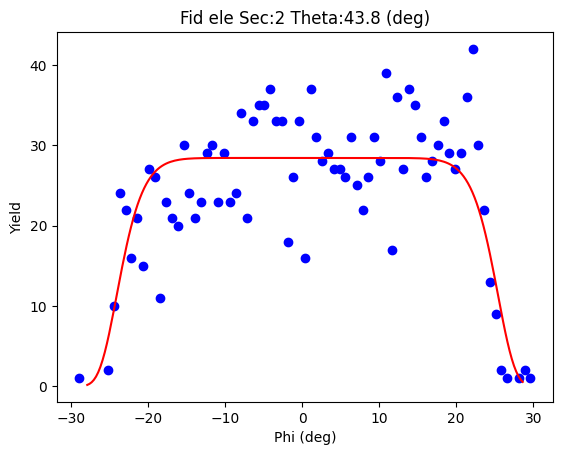

...........Theta: 45.0 ............
Binning| Sec: 1  Ybin: 37
Sum of plot 1747.0
Initial Bounds: [-27.59469839665506, 28.985931249405386]
Sum of initial fit area: 1745.0
max at  40.0
initial max 28.42496343850209
initial guesses: [40.0, 0.6956164263751652, 17.61376950808588, 11.999999999999998]
fit bounds [-27.59469839665506, 28.985931249405386]
(array([27.4476112 ,  0.47349221, 17.70272453, 12.        ]), array([[ 6.98802774e-01, -3.71641216e-03, -4.20810248e-02,
        -8.91477971e-01],
       [-3.71641216e-03,  1.48615621e-01, -9.04355361e-03,
         8.36457996e-02],
       [-4.20810248e-02, -9.04355361e-03,  9.10795315e-02,
        -2.47099567e-01],
       [-8.91477971e-01,  8.36457996e-02, -2.47099567e-01,
         9.81518205e+00]]))
[27.4476112   0.47349221 17.70272453 12.        ]
[27.4476112   0.47349221 17.70272453 12.        ]
New Bounds for next fit: [-27.959697523020843, 28.90668193859735]


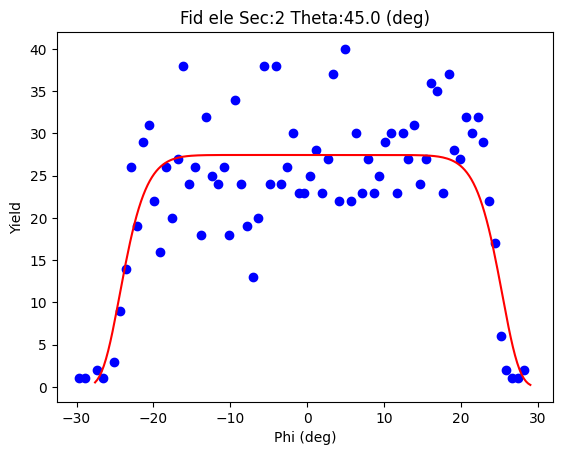

...........Theta: 46.2 ............
Binning| Sec: 1  Ybin: 38
Sum of plot 1614.0
Initial Bounds: [-27.959697523020843, 28.90668193859735]
Sum of initial fit area: 1613.0
max at  41.0
initial max 27.44761120123597
initial guesses: [41.0, 0.4734922077882549, 17.702724534208723, 11.999999999999998]
fit bounds [-27.959697523020843, 28.90668193859735]
(array([25.31375726,  0.87045218, 17.92847827, 12.        ]), array([[ 6.15120438e-01,  1.81255021e-03, -3.45902492e-02,
        -9.13035849e-01],
       [ 1.81255021e-03,  2.30224443e-01,  6.73462858e-02,
        -2.88446318e-01],
       [-3.45902492e-02,  6.73462858e-02,  1.59047892e-01,
        -5.80066523e-01],
       [-9.13035849e-01, -2.88446318e-01, -5.80066523e-01,
         1.22531561e+01]]))
[25.31375726  0.87045218 17.92847827 12.        ]
[25.31375726  0.87045218 17.92847827 12.        ]
New Bounds for next fit: [-27.92533138449913, 29.66623574532307]


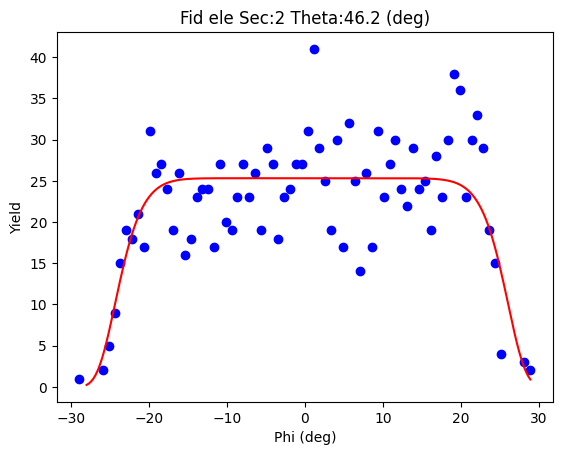

...........Theta: 47.4 ............
Binning| Sec: 1  Ybin: 39
Sum of plot 1497.0
Initial Bounds: [-27.92533138449913, 29.66623574532307]
Sum of initial fit area: 1495.0
max at  35.0
initial max 25.313757262139518
initial guesses: [35.0, 0.8704521804119707, 17.92847826861845, 11.999999999999998]
fit bounds [-27.92533138449913, 29.66623574532307]
(array([23.58379027,  0.11060911, 17.73665032, 12.        ]), array([[ 6.34538433e-01, -7.15395828e-03, -1.26597367e-02,
        -1.25331764e+00],
       [-7.15395828e-03,  2.12357227e-01, -2.22141972e-02,
         1.94266511e-01],
       [-1.26597367e-02, -2.22141972e-02,  1.79570130e-01,
        -1.02033025e+00],
       [-1.25331764e+00,  1.94266511e-01, -1.02033025e+00,
         1.94593159e+01]]))
[23.58379027  0.11060911 17.73665032 12.        ]
[23.58379027  0.11060911 17.73665032 12.        ]
New Bounds for next fit: [-28.377070432700634, 28.598288658579406]


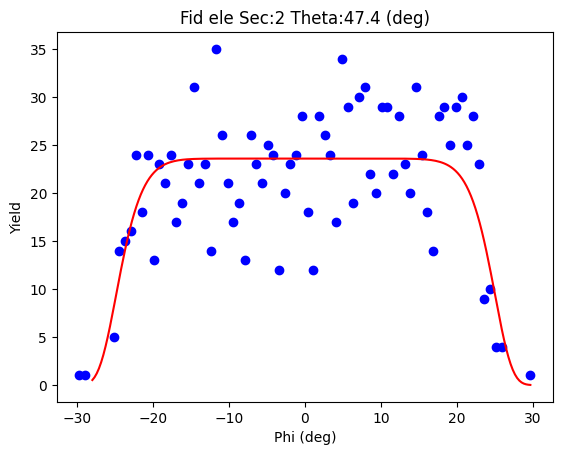

...........Theta: 48.6 ............
Binning| Sec: 1  Ybin: 40
Sum of plot 1408.0
Initial Bounds: [-28.377070432700634, 28.598288658579406]
Sum of initial fit area: 1407.0
max at  31.0
initial max 23.58379027257827
initial guesses: [31.0, 0.11060911293938666, 17.73665031569875, 11.999999999999998]
fit bounds [-28.377070432700634, 28.598288658579406]
(array([22.07883072,  0.33634408, 17.74301872, 12.        ]), array([[ 4.59848376e-01, -3.25210417e-03, -3.13803130e-02,
        -7.74202951e-01],
       [-3.25210417e-03,  1.49204830e-01, -6.25941617e-03,
         7.43955710e-02],
       [-3.13803130e-02, -6.25941617e-03,  9.36916698e-02,
        -2.96501748e-01],
       [-7.74202951e-01,  7.43955710e-02, -2.96501748e-01,
         1.08188760e+01]]))
[22.07883072  0.33634408 17.74301872 12.        ]
[22.07883072  0.33634408 17.74301872 12.        ]
New Bounds for next fit: [-28.161564060946645, 28.8342522211291]


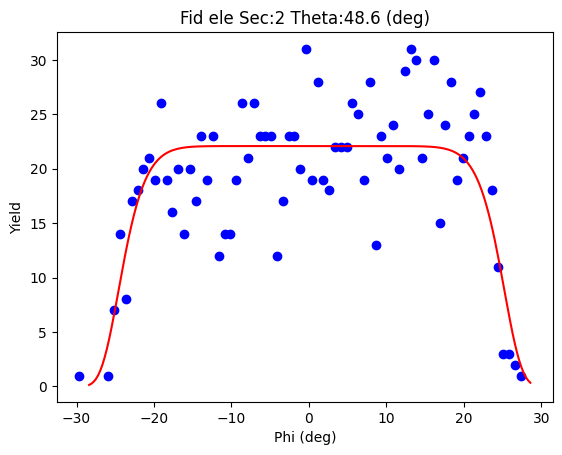

...........Theta: 49.8 ............
Binning| Sec: 1  Ybin: 41
Sum of plot 1262.0
Initial Bounds: [-28.161564060946645, 28.8342522211291]
Sum of initial fit area: 1261.0
max at  31.0
initial max 22.078830716367918
initial guesses: [31.0, 0.3363440800912275, 17.743018718555213, 11.999999999999998]
fit bounds [-28.161564060946645, 28.8342522211291]
(array([19.545832  ,  0.24409377, 18.10079   , 12.        ]), array([[ 4.15502728e-01,  5.51964246e-03, -2.32246581e-02,
        -8.73651169e-01],
       [ 5.51964246e-03,  2.17893894e-01,  3.79456127e-02,
        -2.43224515e-01],
       [-2.32246581e-02,  3.79456127e-02,  1.56424468e-01,
        -6.79593303e-01],
       [-8.73651169e-01, -2.43224515e-01, -6.79593303e-01,
         1.52233521e+01]]))
[19.545832    0.24409377 18.10079    12.        ]
[19.545832    0.24409377 18.10079    12.        ]
New Bounds for next fit: [-28.828447880676578, 29.316635421403888]


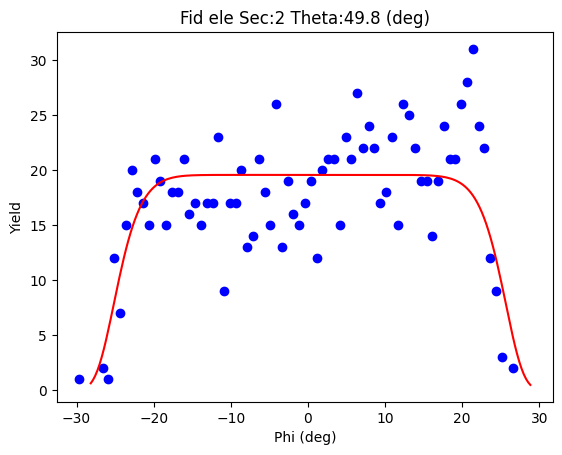

...........Theta: 51.0 ............
Binning| Sec: 1  Ybin: 42
Sum of plot 1159.0
Initial Bounds: [-28.828447880676578, 29.316635421403888]
Sum of initial fit area: 1158.0
max at  28.0
initial max 19.545832000022052
initial guesses: [28.0, 0.24409377036365412, 18.100790000356728, 11.999999999999998]
fit bounds [-28.828447880676578, 29.316635421403888]
(array([18.54536022,  0.63622265, 17.27655274, 12.        ]), array([[ 3.13873252e-01, -6.96910935e-05, -3.01146918e-02,
        -5.66263852e-01],
       [-6.96910935e-05,  1.30802824e-01, -8.53704669e-05,
         1.52990277e-03],
       [-3.01146918e-02, -8.53704669e-05,  7.67107886e-02,
        -1.50434997e-01],
       [-5.66263852e-01,  1.52990277e-03, -1.50434997e-01,
         8.80460321e+00]]))
[18.54536022  0.63622265 17.27655274 12.        ]
[18.54536022  0.63622265 17.27655274 12.        ]
New Bounds for next fit: [-27.11247225457739, 28.384917552137424]


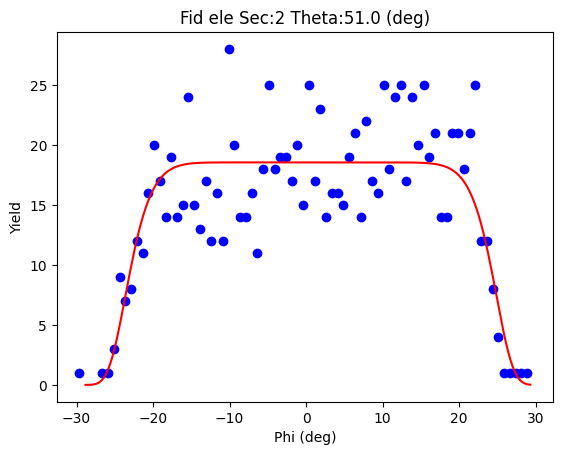

...........Theta: 52.2 ............
Binning| Sec: 1  Ybin: 43
Sum of plot 1045.0
Initial Bounds: [-27.11247225457739, 28.384917552137424]
Sum of initial fit area: 1043.0
max at  27.0
initial max 18.545360219238585
initial guesses: [27.0, 0.6362226487800157, 17.27655274376982, 11.999999999999998]
fit bounds [-27.11247225457739, 28.384917552137424]
(array([16.3084116 ,  0.77947393, 17.84214124, 12.        ]), array([[ 4.74606143e-01,  7.43229652e-03, -3.40891381e-02,
        -1.17908009e+00],
       [ 7.43229652e-03,  3.03642694e-01,  2.49992652e-02,
        -2.55338559e-01],
       [-3.40891381e-02,  2.49992652e-02,  2.08615626e-01,
        -8.84152971e-01],
       [-1.17908009e+00, -2.55338559e-01, -8.84152971e-01,
         2.37914349e+01]]))
[16.3084116   0.77947393 17.84214124 12.        ]
[16.3084116   0.77947393 17.84214124 12.        ]
New Bounds for next fit: [-27.87763961964032, 29.43658748267265]


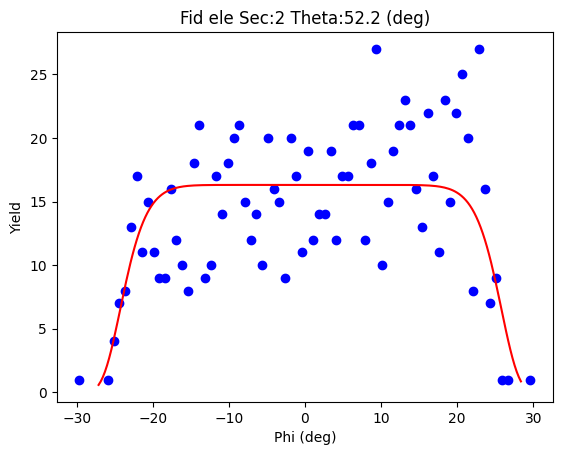

...........Theta: 53.4 ............
Binning| Sec: 1  Ybin: 44
Sum of plot 921.0
Initial Bounds: [-27.87763961964032, 29.43658748267265]
Sum of initial fit area: 921.0
max at  25.0
initial max 16.30841160155223
initial guesses: [25.0, 0.779473931516165, 17.842141242140094, 11.999999999999998]
fit bounds [-27.87763961964032, 29.43658748267265]
(array([14.51124554,  1.49215443, 18.07308425, 12.        ]), array([[ 4.18979282e-01, -2.79700107e-03, -4.65772562e-02,
        -1.12683847e+00],
       [-2.79700107e-03,  5.22932891e-01,  1.68546398e-01,
        -4.34903592e-01],
       [-4.65772562e-02,  1.68546398e-01,  3.33247680e-01,
        -9.74899906e-01],
       [-1.12683847e+00, -4.34903592e-01, -9.74899906e-01,
         2.57604138e+01]]))
[14.51124554  1.49215443 18.07308425 12.        ]
[14.51124554  1.49215443 18.07308425 12.        ]
New Bounds for next fit: [-27.53588770224606, 30.520196555472662]


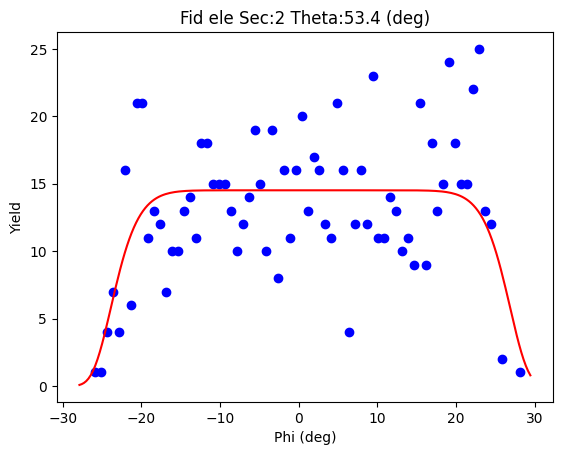

...........Theta: 54.6 ............
Binning| Sec: 1  Ybin: 45
Sum of plot 877.0
Initial Bounds: [-27.53588770224606, 30.520196555472662]
Sum of initial fit area: 877.0
max at  27.0
initial max 14.51124554283874
initial guesses: [27.0, 1.4921544266133016, 18.07308425258344, 11.999999999999998]
fit bounds [-27.53588770224606, 30.520196555472662]
(array([14.32401151,  0.50853613, 17.46047289,  8.33458984]), array([[ 0.2833689 ,  0.00952977, -0.03486748, -0.52178565],
       [ 0.00952977,  0.31524076,  0.05836409, -0.23295492],
       [-0.03486748,  0.05836409,  0.22531696, -0.43864357],
       [-0.52178565, -0.23295492, -0.43864357,  5.93461913]]))
[14.32401151  0.50853613 17.46047289  8.33458984]
[14.32401151  0.50853613 17.46047289  8.33458984]
New Bounds for next fit: [-29.149916094365068, 30.166988348062866]


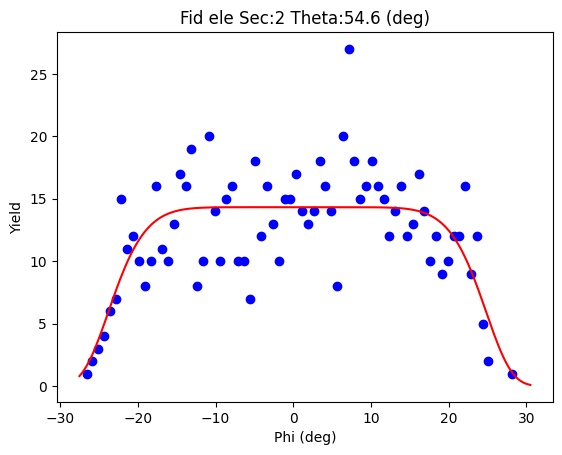

==========Sec  3 ===============
...........Theta: 9.0 ............
Binning| Sec: 2  Ybin: 7
Sum of plot 839.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 774.0
max at  59.0
initial max 14.324011506662096
initial guesses: [59.0, 0.5085361268488973, 17.46047288817868, 8.334589842223151]
fit bounds [-10.0, 10.0]
(array([46.62870614,  0.68796744,  5.15720288,  2.32467722]), array([[ 5.26511469e+00,  1.58049269e-02, -2.74563115e-01,
        -6.30849055e-01],
       [ 1.58049269e-02,  4.90151236e-02,  2.36636754e-03,
        -6.91295103e-03],
       [-2.74563115e-01,  2.36636754e-03,  5.29582769e-02,
         1.38903957e-02],
       [-6.30849055e-01, -6.91295103e-03,  1.38903957e-02,
         1.71948634e-01]]))
[46.62870614  0.68796744  5.15720288  2.32467722]
[46.62870614  0.68796744  5.15720288  2.32467722]
New Bounds for next fit: [-13.380143497511169, 14.75607837192464]


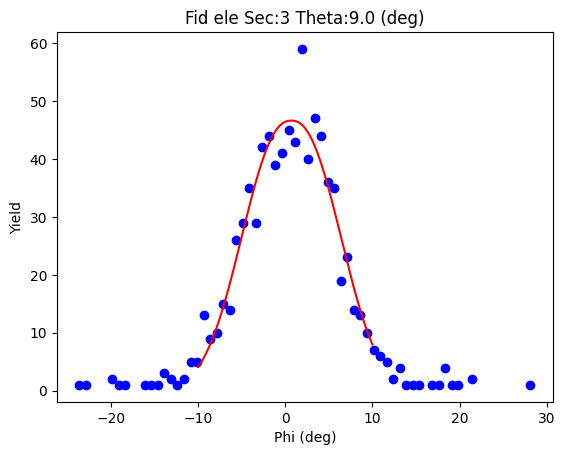

...........Theta: 10.2 ............
Binning| Sec: 2  Ybin: 8
Sum of plot 1345.0
Initial Bounds: [-13.380143497511169, 14.75607837192464]
Sum of initial fit area: 1301.0
max at  68.0
initial max 46.6287061362413
initial guesses: [68.0, 0.687967437206736, 5.157202880730016, 2.324677222161418]
fit bounds [-13.380143497511169, 14.75607837192464]
(array([56.56913502, -0.23032746,  6.84018663,  3.03092322]), array([[ 5.69385758e+00, -6.66609465e-03, -2.91415724e-01,
        -6.82453791e-01],
       [-6.66609465e-03,  6.69368895e-02, -6.51507324e-04,
         3.36214886e-03],
       [-2.91415724e-01, -6.51507324e-04,  5.68871447e-02,
         2.23353266e-02],
       [-6.82453791e-01,  3.36214886e-03,  2.23353266e-02,
         2.29453476e-01]]))
[56.56913502 -0.23032746  6.84018663  3.03092322]
[56.56913502 -0.23032746  6.84018663  3.03092322]
New Bounds for next fit: [-16.240987647204683, 15.78033271979073]


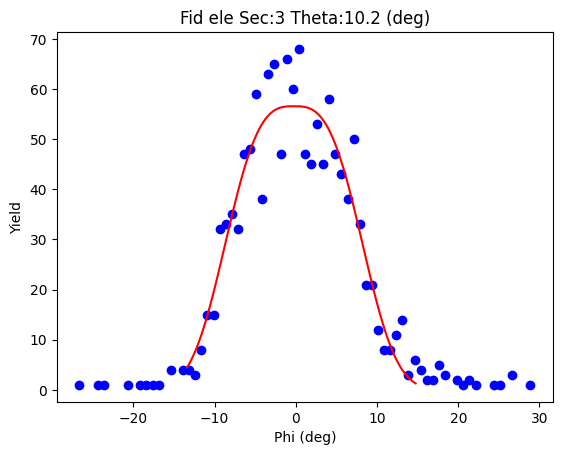

...........Theta: 11.4 ............
Binning| Sec: 2  Ybin: 9
Sum of plot 1811.0
Initial Bounds: [-16.240987647204683, 15.78033271979073]
Sum of initial fit area: 1758.0
max at  71.0
initial max 56.56913501975337
initial guesses: [71.0, -0.2303274637069759, 6.840186633713455, 3.0309232156541746]
fit bounds [-16.240987647204683, 15.78033271979073]
(array([60.68341807, -0.70912962,  8.32484187,  4.83442819]), array([[ 2.78021950e+00, -2.37366671e-04, -1.02652770e-01,
        -5.36343295e-01],
       [-2.37366671e-04,  3.98592244e-02, -2.82208877e-05,
         2.59376717e-04],
       [-1.02652770e-01, -2.82208877e-05,  2.69927648e-02,
         3.39573787e-03],
       [-5.36343295e-01,  2.59376717e-04,  3.39573787e-03,
         4.14420237e-01]]))
[60.68341807 -0.70912962  8.32484187  4.83442819]
[60.68341807 -0.70912962  8.32484187  4.83442819]
New Bounds for next fit: [-16.85580665269693, 15.4375474182224]


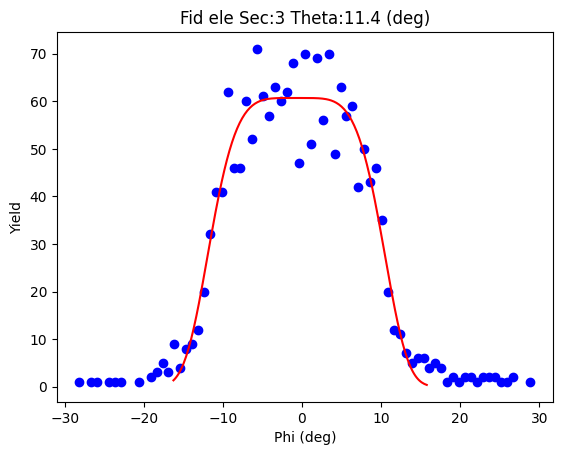

...........Theta: 12.6 ............
Binning| Sec: 2  Ybin: 10
Sum of plot 2169.0
Initial Bounds: [-16.85580665269693, 15.4375474182224]
Sum of initial fit area: 2083.0
max at  75.0
initial max 60.68341806853495
initial guesses: [75.0, -0.7091296172372652, 8.324841868464503, 4.834428188312559]
fit bounds [-16.85580665269693, 15.4375474182224]
(array([62.3541058 , -1.00375267,  9.50877706,  6.51862457]), array([[ 3.32437729e+00, -3.98301418e-03, -9.38972960e-02,
        -9.32628421e-01],
       [-3.98301418e-03,  5.32590922e-02, -9.38572723e-04,
         8.61635173e-03],
       [-9.38972960e-02, -9.38572723e-04,  3.41211079e-02,
        -2.27560578e-02],
       [-9.32628421e-01,  8.61635173e-03, -2.27560578e-02,
         1.30945582e+00]]))
[62.3541058  -1.00375267  9.50877706  6.51862457]
[62.3541058  -1.00375267  9.50877706  6.51862457]
New Bounds for next fit: [-18.001286931665287, 15.993781588355192]


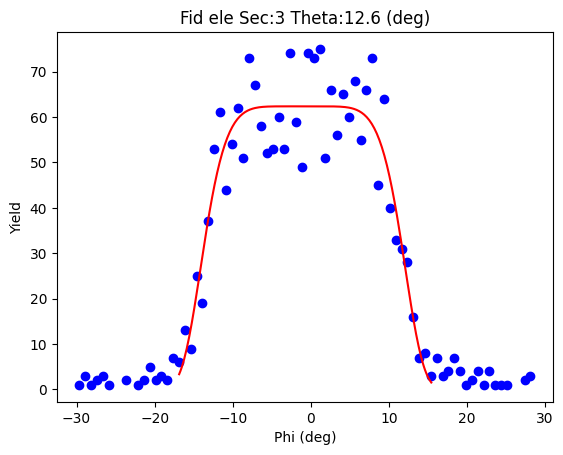

...........Theta: 13.8 ............
Binning| Sec: 2  Ybin: 11
Sum of plot 2491.0
Initial Bounds: [-18.001286931665287, 15.993781588355192]
Sum of initial fit area: 2396.0
max at  87.0
initial max 62.35410579803141
initial guesses: [87.0, -1.0037526716550478, 9.508777060693273, 6.518624569093051]
fit bounds [-18.001286931665287, 15.993781588355192]
(array([63.40304749, -1.03118157, 10.71499945,  7.70660838]), array([[ 2.86305046e+00,  1.55709888e-03, -6.55859007e-02,
        -1.03507795e+00],
       [ 1.55709888e-03,  5.30539474e-02,  5.65178164e-04,
        -5.09538238e-03],
       [-6.55859007e-02,  5.65178164e-04,  3.48364186e-02,
        -6.22942910e-02],
       [-1.03507795e+00, -5.09538238e-03, -6.22942910e-02,
         2.09443569e+00]]))
[63.40304749 -1.03118157 10.71499945  7.70660838]
[63.40304749 -1.03118157 10.71499945  7.70660838]
New Bounds for next fit: [-19.505528416762438, 17.4431652780261]


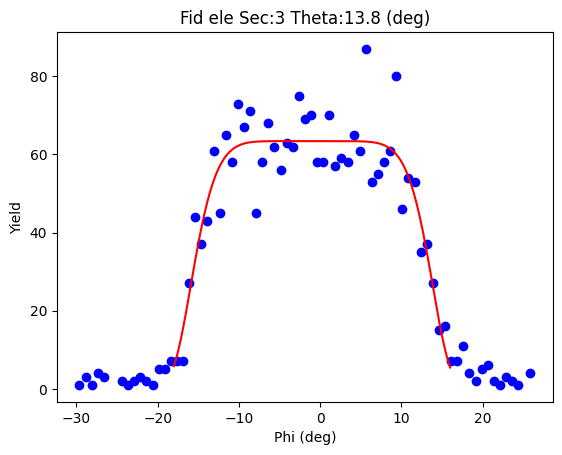

...........Theta: 15.0 ............
Binning| Sec: 2  Ybin: 12
Sum of plot 2675.0
Initial Bounds: [-19.505528416762438, 17.4431652780261]
Sum of initial fit area: 2602.0
max at  78.0
initial max 63.4030474944028
initial guesses: [78.0, -1.0311815693681674, 10.714999449882011, 7.706608379323116]
fit bounds [-19.505528416762438, 17.4431652780261]
(array([62.34579838, -1.08615568, 11.66581527,  9.64552573]), array([[ 1.57849156e+00,  2.12301667e-04, -3.53439737e-02,
        -7.02124578e-01],
       [ 2.12301667e-04,  3.09305762e-02,  7.26607237e-05,
        -1.02131445e-03],
       [-3.53439737e-02,  7.26607237e-05,  1.89667689e-02,
        -4.04976033e-02],
       [-7.02124578e-01, -1.02131445e-03, -4.04976033e-02,
         2.16513526e+00]]))
[62.34579838 -1.08615568 11.66581527  9.64552573]
[62.34579838 -1.08615568 11.66581527  9.64552573]
New Bounds for next fit: [-20.41438624424612, 18.242074882636775]


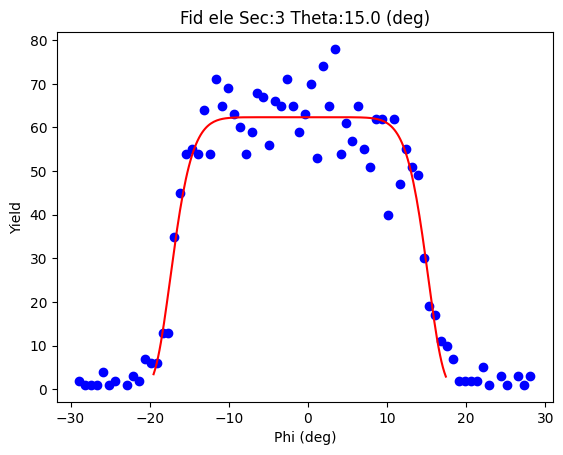

...........Theta: 16.2 ............
Binning| Sec: 2  Ybin: 13
Sum of plot 2917.0
Initial Bounds: [-20.41438624424612, 18.242074882636775]
Sum of initial fit area: 2829.0
max at  87.0
initial max 62.34579838067319
initial guesses: [87.0, -1.0861556808046733, 11.665815273763561, 9.645525725899194]
fit bounds [-20.41438624424612, 18.242074882636775]
(array([63.51861666, -1.11355832, 12.4173423 , 10.65060439]), array([[ 2.06305575e+00,  1.24681562e-04, -4.06565735e-02,
        -1.04182798e+00],
       [ 1.24681562e-04,  4.20076645e-02,  5.17239472e-05,
        -7.52110060e-04],
       [-4.06565735e-02,  5.17239472e-05,  2.61797321e-02,
        -8.12660550e-02],
       [-1.04182798e+00, -7.52110060e-04, -8.12660550e-02,
         3.93000515e+00]]))
[63.51861666 -1.11355832 12.4173423  10.65060439]
[63.51861666 -1.11355832 12.4173423  10.65060439]
New Bounds for next fit: [-21.381829542314954, 19.154712896360344]


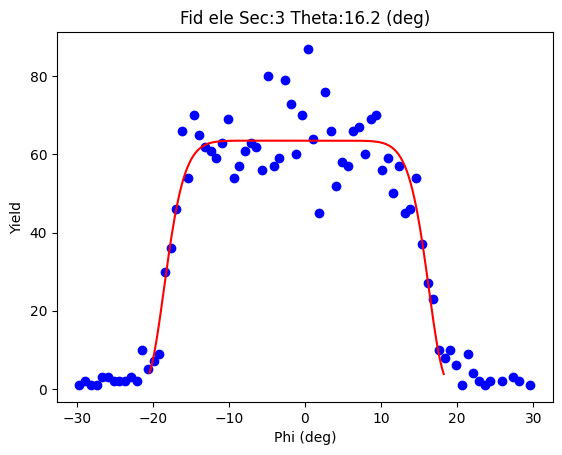

...........Theta: 17.4 ............
Binning| Sec: 2  Ybin: 14
Sum of plot 3041.0
Initial Bounds: [-21.381829542314954, 19.154712896360344]
Sum of initial fit area: 2977.0
max at  87.0
initial max 63.51861665677487
initial guesses: [87.0, -1.1135583229773065, 12.417342301952692, 10.650604387285561]
fit bounds [-21.381829542314954, 19.154712896360344]
(array([61.8901204 , -1.13070235, 13.30833841, 12.        ]), array([[ 2.21396830e+00, -3.78485018e-05, -4.61630442e-02,
        -1.24730514e+00],
       [-3.78485018e-05,  4.95887204e-02, -1.47786130e-05,
         2.78152724e-04],
       [-4.61630442e-02, -1.47786130e-05,  2.96696365e-02,
        -9.21731698e-02],
       [-1.24730514e+00,  2.78152724e-04, -9.21731698e-02,
         5.94221149e+00]]))
[61.8901204  -1.13070235 13.30833841 12.        ]
[61.8901204  -1.13070235 13.30833841 12.        ]
New Bounds for next fit: [-22.505859058433774, 20.244454364338036]


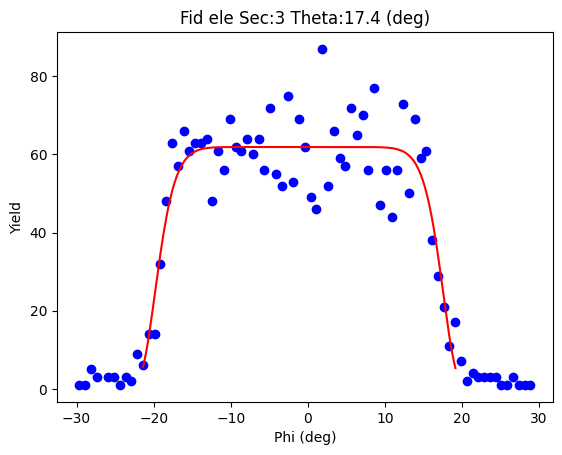

...........Theta: 18.6 ............
Binning| Sec: 2  Ybin: 15
Sum of plot 3103.0
Initial Bounds: [-22.505859058433774, 20.244454364338036]
Sum of initial fit area: 3038.0
max at  75.0
initial max 61.89012040078188
initial guesses: [75.0, -1.13070234704787, 13.30833841435629, 11.999999999999998]
fit bounds [-22.505859058433774, 20.244454364338036]
(array([61.78240135, -0.84829968, 13.6605479 , 11.29370339]), array([[ 1.52021620e+00,  1.08892839e-03, -3.48283233e-02,
        -8.00706633e-01],
       [ 1.08892839e-03,  3.75429051e-02,  4.32010319e-04,
        -7.10090751e-03],
       [-3.48283233e-02,  4.32010319e-04,  2.25415361e-02,
        -5.81503728e-02],
       [-8.00706633e-01, -7.10090751e-03, -5.81503728e-02,
         3.38444354e+00]]))
[61.78240135 -0.84829968 13.6605479  11.29370339]
[61.78240135 -0.84829968 13.6605479  11.29370339]
New Bounds for next fit: [-22.96448133830554, 21.267881982672748]


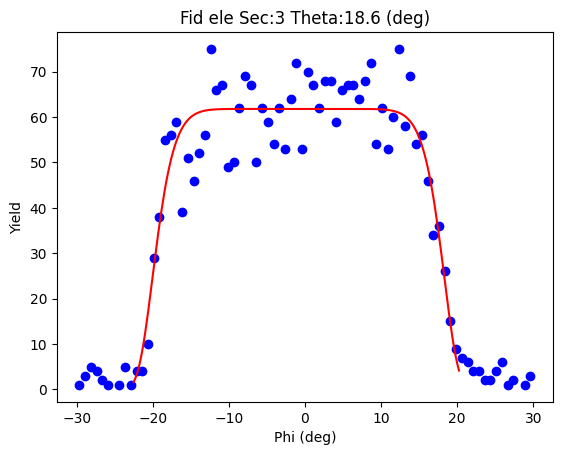

...........Theta: 19.8 ............
Binning| Sec: 2  Ybin: 16
Sum of plot 3108.0
Initial Bounds: [-22.96448133830554, 21.267881982672748]
Sum of initial fit area: 3028.0
max at  76.0
initial max 61.78240134715119
initial guesses: [76.0, -0.848299677816394, 13.660547896878825, 11.293703391931722]
fit bounds [-22.96448133830554, 21.267881982672748]
(array([59.25966233, -0.72324371, 14.1569052 , 12.        ]), array([[ 1.40487785e+00,  1.28802129e-03, -3.27520189e-02,
        -8.22112828e-01],
       [ 1.28802129e-03,  3.88969255e-02,  5.52230583e-04,
        -9.83956317e-03],
       [-3.27520189e-02,  5.52230583e-04,  2.32251429e-02,
        -6.68109282e-02],
       [-8.22112828e-01, -9.83956317e-03, -6.68109282e-02,
         4.08391087e+00]]))
[59.25966233 -0.72324371 14.1569052  12.        ]
[59.25966233 -0.72324371 14.1569052  12.        ]
New Bounds for next fit: [-23.461323974600663, 22.014836562163982]


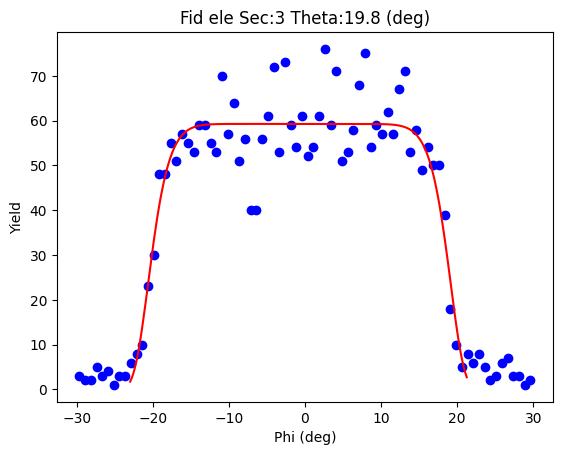

...........Theta: 21.0 ............
Binning| Sec: 2  Ybin: 17
Sum of plot 3130.0
Initial Bounds: [-23.461323974600663, 22.014836562163982]
Sum of initial fit area: 3052.0
max at  75.0
initial max 59.259662331794615
initial guesses: [75.0, -0.7232437062183413, 14.156905195611508, 11.999999999999996]
fit bounds [-23.461323974600663, 22.014836562163982]
(array([59.01868378, -0.560783  , 14.32108617, 12.        ]), array([[ 1.32538406e+00,  4.02197414e-04, -3.22524640e-02,
        -7.66049764e-01],
       [ 4.02197414e-04,  3.76088931e-02,  1.58664108e-04,
        -2.97950811e-03],
       [-3.22524640e-02,  1.58664108e-04,  2.22448348e-02,
        -5.78306594e-02],
       [-7.66049764e-01, -2.97950811e-03, -5.78306594e-02,
         3.78053408e+00]]))
[59.01868378 -0.560783   14.32108617 12.        ]
[59.01868378 -0.560783   14.32108617 12.        ]
New Bounds for next fit: [-23.56256216094415, 22.440996158184152]


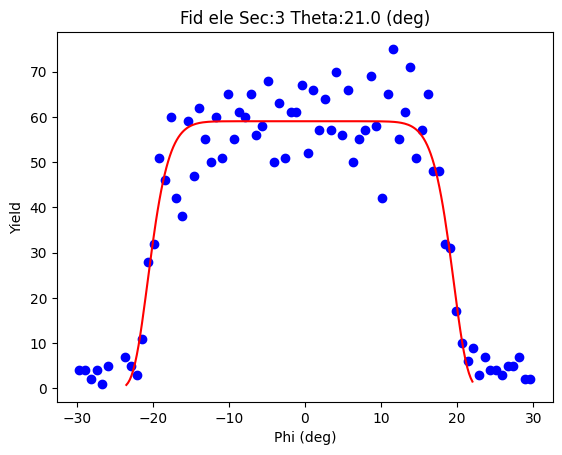

...........Theta: 22.2 ............
Binning| Sec: 2  Ybin: 18
Sum of plot 3177.0
Initial Bounds: [-23.56256216094415, 22.440996158184152]
Sum of initial fit area: 3112.0
max at  77.0
initial max 59.01868378069134
initial guesses: [77.0, -0.5607830013799996, 14.321086171251563, 11.999999999998817]
fit bounds [-23.56256216094415, 22.440996158184152]
(array([58.20577348, -0.27956231, 14.81816109, 12.        ]), array([[ 1.87888766e+00,  6.84980426e-04, -4.54871484e-02,
        -1.13814508e+00],
       [ 6.84980426e-04,  5.92284986e-02,  3.35301532e-04,
        -5.46574030e-03],
       [-4.54871484e-02,  3.35301532e-04,  3.56879273e-02,
        -1.05245456e-01],
       [-1.13814508e+00, -5.46574030e-03, -1.05245456e-01,
         5.80626608e+00]]))
[58.20577348 -0.27956231 14.81816109 12.        ]
[58.20577348 -0.27956231 14.81816109 12.        ]
New Bounds for next fit: [-24.07971719826847, 23.520592572273827]


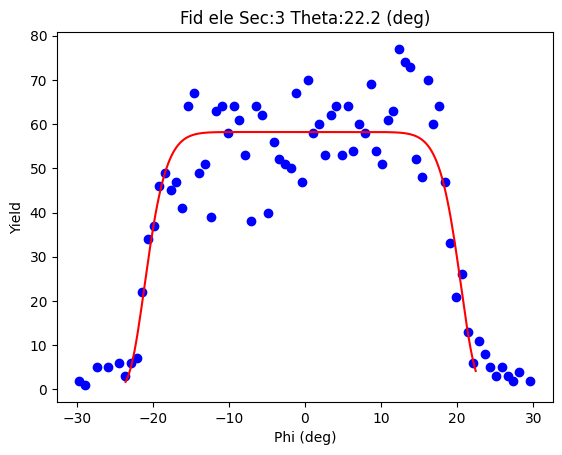

...........Theta: 23.4 ............
Binning| Sec: 2  Ybin: 19
Sum of plot 3183.0
Initial Bounds: [-24.07971719826847, 23.520592572273827]
Sum of initial fit area: 3127.0
max at  69.0
initial max 58.205773477411604
initial guesses: [69.0, -0.27956231299732054, 14.818161092524917, 11.999999999999359]
fit bounds [-24.07971719826847, 23.520592572273827]
(array([56.82637198, -0.40502404, 15.22436234, 12.        ]), array([[ 1.16296858e+00, -1.08597249e-04, -3.03008805e-02,
        -7.12174328e-01],
       [-1.08597249e-04,  4.04227977e-02, -5.29135944e-05,
         8.69648079e-04],
       [-3.03008805e-02, -5.29135944e-05,  2.41627078e-02,
        -6.50802685e-02],
       [-7.12174328e-01,  8.69648079e-04, -6.50802685e-02,
         3.69153754e+00]]))
[56.82637198 -0.40502404 15.22436234 12.        ]
[56.82637198 -0.40502404 15.22436234 12.        ]
New Bounds for next fit: [-24.857598108137942, 24.047550035078046]


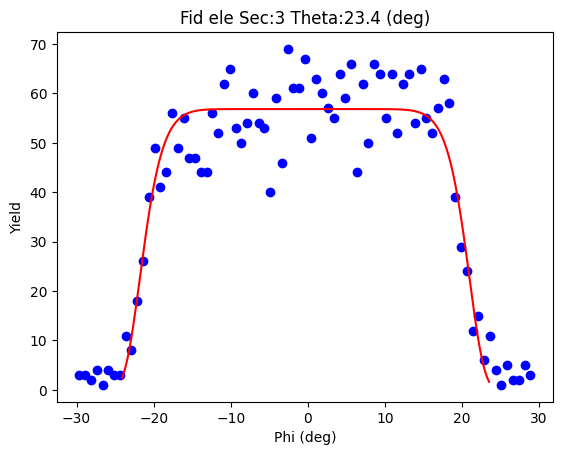

...........Theta: 24.6 ............
Binning| Sec: 2  Ybin: 20
Sum of plot 3055.0
Initial Bounds: [-24.857598108137942, 24.047550035078046]
Sum of initial fit area: 3010.0
max at  71.0
initial max 56.82637197868209
initial guesses: [71.0, -0.4050240365299474, 15.224362339936912, 11.999999999999998]
fit bounds [-24.857598108137942, 24.047550035078046]
(array([54.40597129,  0.08970958, 15.35552109, 10.98181267]), array([[ 1.50596189e+00,  1.27997975e-03, -4.62761894e-02,
        -8.61998293e-01],
       [ 1.27997975e-03,  6.15253962e-02,  6.06553839e-04,
        -8.77100910e-03],
       [-4.62761894e-02,  6.06553839e-04,  3.67691138e-02,
        -7.34096001e-02],
       [-8.61998293e-01, -8.77100910e-03, -7.34096001e-02,
         3.88394153e+00]]))
[54.40597129  0.08970958 15.35552109 10.98181267]
[54.40597129  0.08970958 15.35552109 10.98181267]
New Bounds for next fit: [-24.86626159825554, 25.045680761146095]


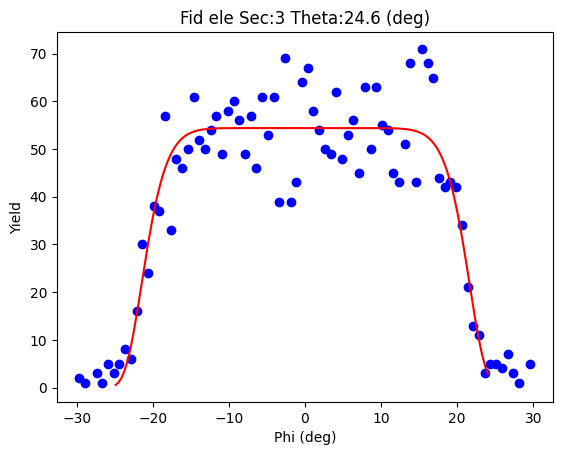

...........Theta: 25.8 ............
Binning| Sec: 2  Ybin: 21
Sum of plot 3037.0
Initial Bounds: [-24.86626159825554, 25.045680761146095]
Sum of initial fit area: 3011.0
max at  71.0
initial max 54.40597128547842
initial guesses: [71.0, 0.0897095814452759, 15.355521089130256, 10.981812670851404]
fit bounds [-24.86626159825554, 25.045680761146095]
(array([52.15262617,  0.10826331, 16.02295668, 12.        ]), array([[ 1.19765964e+00,  5.40541755e-04, -3.50530489e-02,
        -8.08786150e-01],
       [ 5.40541755e-04,  5.49750806e-02,  3.19586877e-04,
        -4.81499864e-03],
       [-3.50530489e-02,  3.19586877e-04,  3.31060110e-02,
        -8.98834440e-02],
       [-8.08786150e-01, -4.81499864e-03, -8.98834440e-02,
         4.60231986e+00]]))
[52.15262617  0.10826331 16.02295668 12.        ]
[52.15262617  0.10826331 16.02295668 12.        ]
New Bounds for next fit: [-25.626971197725705, 25.84349782154216]


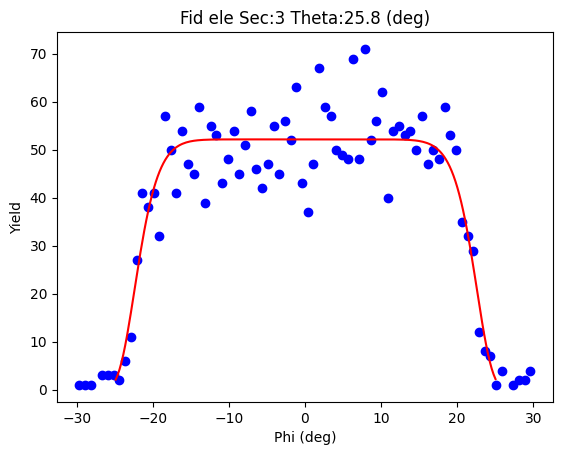

...........Theta: 27.0 ............
Binning| Sec: 2  Ybin: 22
Sum of plot 2894.0
Initial Bounds: [-25.626971197725705, 25.84349782154216]
Sum of initial fit area: 2860.0
max at  71.0
initial max 52.152626166655594
initial guesses: [71.0, 0.10826331190822897, 16.022956680574563, 11.99999999999999]
fit bounds [-25.626971197725705, 25.84349782154216]
(array([49.85172222,  0.40540524, 16.04463908,  9.69250788]), array([[ 1.31675629e+00,  1.73258676e-03, -5.13409214e-02,
        -7.27688176e-01],
       [ 1.73258676e-03,  7.60554600e-02,  9.94605894e-04,
        -1.04222322e-02],
       [-5.13409214e-02,  9.94605894e-04,  4.63361272e-02,
        -6.88911087e-02],
       [-7.27688176e-01, -1.04222322e-02, -6.88911087e-02,
         2.81667862e+00]]))
[49.85172222  0.40540524 16.04463908  9.69250788]
[49.85172222  0.40540524 16.04463908  9.69250788]
New Bounds for next fit: [-26.15738220149521, 26.968192684778742]


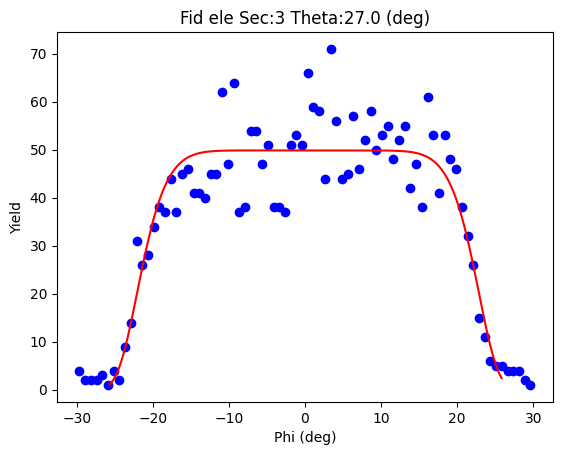

...........Theta: 28.2 ............
Binning| Sec: 2  Ybin: 23
Sum of plot 2973.0
Initial Bounds: [-26.15738220149521, 26.968192684778742]
Sum of initial fit area: 2954.0
max at  68.0
initial max 49.85172221622499
initial guesses: [68.0, 0.4054052416417651, 16.044639081571226, 9.692507877351952]
fit bounds [-26.15738220149521, 26.968192684778742]
(array([50.60956076,  0.19305151, 16.10496208, 12.        ]), array([[ 1.09869439e+00, -3.54356939e-06, -3.61231303e-02,
        -7.24476073e-01],
       [-3.54356939e-06,  5.34119380e-02, -1.28058503e-06,
         2.72445730e-05],
       [-3.61231303e-02, -1.28058503e-06,  3.12947489e-02,
        -6.50741133e-02],
       [-7.24476073e-01,  2.72445730e-05, -6.50741133e-02,
         4.12299236e+00]]))
[50.60956076  0.19305151 16.10496208 12.        ]
[50.60956076  0.19305151 16.10496208 12.        ]
New Bounds for next fit: [-25.67389577520304, 26.059998792494365]


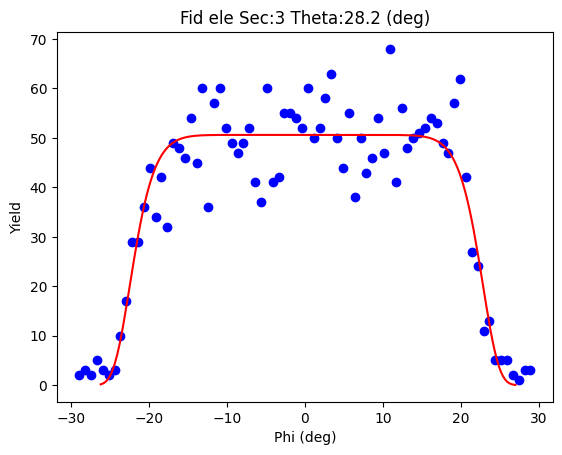

...........Theta: 29.4 ............
Binning| Sec: 2  Ybin: 24
Sum of plot 2902.0
Initial Bounds: [-25.67389577520304, 26.059998792494365]
Sum of initial fit area: 2881.0
max at  70.0
initial max 50.60956075995454
initial guesses: [70.0, 0.19305150864566212, 16.10496207572436, 11.99999999993485]
fit bounds [-25.67389577520304, 26.059998792494365]
(array([48.87216315,  0.28976093, 16.3860399 , 12.        ]), array([[ 1.26616004e+00,  3.34188642e-03, -3.91328060e-02,
        -9.20398408e-01],
       [ 3.34188642e-03,  7.10867353e-02,  2.96509117e-03,
        -3.60118361e-02],
       [-3.91328060e-02,  2.96509117e-03,  4.34847501e-02,
        -1.28137194e-01],
       [-9.20398408e-01, -3.60118361e-02, -1.28137194e-01,
         5.68168121e+00]]))
[48.87216315  0.28976093 16.3860399  12.        ]
[48.87216315  0.28976093 16.3860399  12.        ]
New Bounds for next fit: [-26.02863884913205, 26.60816070838174]


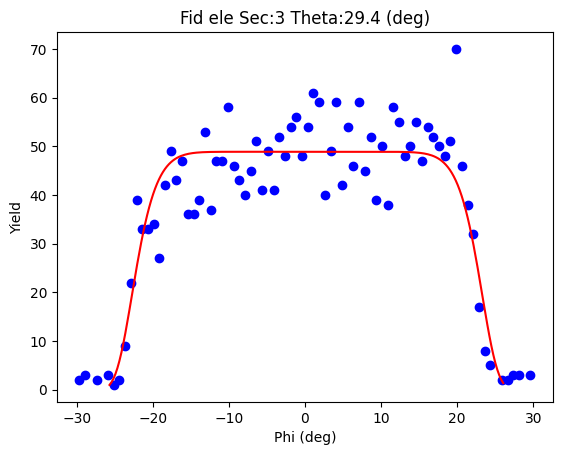

...........Theta: 30.6 ............
Binning| Sec: 2  Ybin: 25
Sum of plot 2913.0
Initial Bounds: [-26.02863884913205, 26.60816070838174]
Sum of initial fit area: 2889.0
max at  64.0
initial max 48.872163151507245
initial guesses: [64.0, 0.2897609296248424, 16.38603990180089, 11.999999999999998]
fit bounds [-26.02863884913205, 26.60816070838174]
(array([47.9682668 ,  0.28829754, 16.70430488, 12.        ]), array([[ 9.27426323e-01,  5.43256819e-04, -3.22849355e-02,
        -6.60783306e-01],
       [ 5.43256819e-04,  5.42463549e-02,  3.14467179e-04,
        -4.98963878e-03],
       [-3.22849355e-02,  3.14467179e-04,  3.21223354e-02,
        -7.24124820e-02],
       [-6.60783306e-01, -4.98963878e-03, -7.24124820e-02,
         4.01753046e+00]]))
[47.9682668   0.28829754 16.70430488 12.        ]
[47.9682668   0.28829754 16.70430488 12.        ]
New Bounds for next fit: [-26.541282787274504, 27.117877875792836]


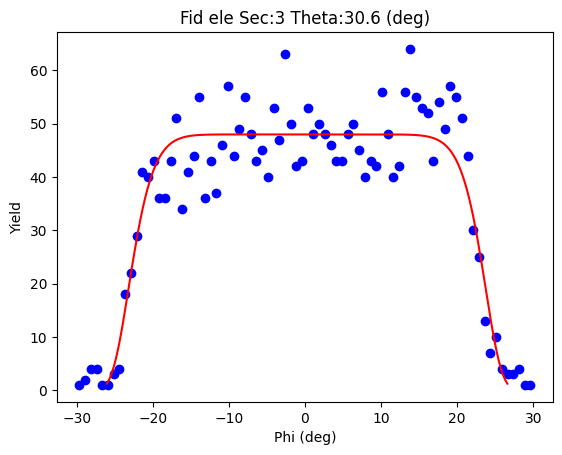

...........Theta: 31.8 ............
Binning| Sec: 2  Ybin: 26
Sum of plot 2805.0
Initial Bounds: [-26.541282787274504, 27.117877875792836]
Sum of initial fit area: 2789.0
max at  64.0
initial max 47.96826679601064
initial guesses: [64.0, 0.28829754425916587, 16.704304880114115, 11.999999999999998]
fit bounds [-26.541282787274504, 27.117877875792836]
(array([46.10556703,  0.42860886, 16.80197074, 12.        ]), array([[ 1.26099219e+00,  8.17749855e-05, -4.67899391e-02,
        -9.23163462e-01],
       [ 8.17749855e-05,  8.05130646e-02,  4.49533751e-05,
        -7.55759961e-04],
       [-4.67899391e-02,  4.49533751e-05,  4.73846213e-02,
        -9.95706497e-02],
       [-9.23163462e-01, -7.55759961e-04, -9.95706497e-02,
         5.79826027e+00]]))
[46.10556703  0.42860886 16.80197074 12.        ]
[46.10556703  0.42860886 16.80197074 12.        ]
New Bounds for next fit: [-26.557837262883922, 27.41505499100635]


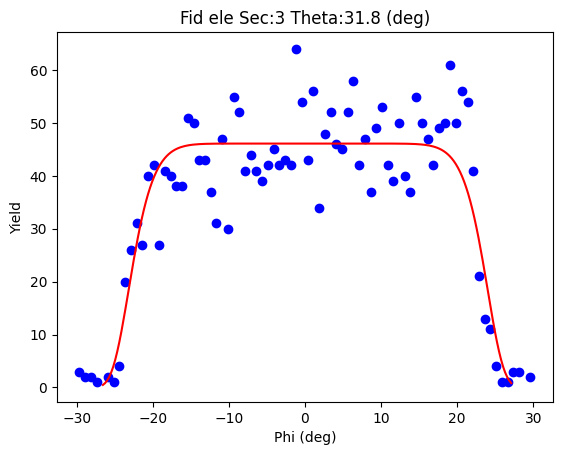

...........Theta: 33.0 ............
Binning| Sec: 2  Ybin: 27
Sum of plot 2796.0
Initial Bounds: [-26.557837262883922, 27.41505499100635]
Sum of initial fit area: 2780.0
max at  64.0
initial max 46.10556703190267
initial guesses: [64.0, 0.4286088640612126, 16.80197074142969, 11.999999999999998]
fit bounds [-26.557837262883922, 27.41505499100635]
(array([46.12777827,  0.36115954, 16.72222087, 12.        ]), array([[ 1.54131898e+00, -1.84313822e-05, -5.71715262e-02,
        -1.12376076e+00],
       [-1.84313822e-05,  9.73274999e-02, -9.67871776e-06,
         1.67962468e-04],
       [-5.71715262e-02, -9.67871776e-06,  5.71918850e-02,
        -1.18649661e-01],
       [-1.12376076e+00,  1.67962468e-04, -1.18649661e-01,
         7.04180609e+00]]))
[46.12777827  0.36115954 16.72222087 12.        ]
[46.12777827  0.36115954 16.72222087 12.        ]
New Bounds for next fit: [-26.497196516938523, 27.219515587291077]


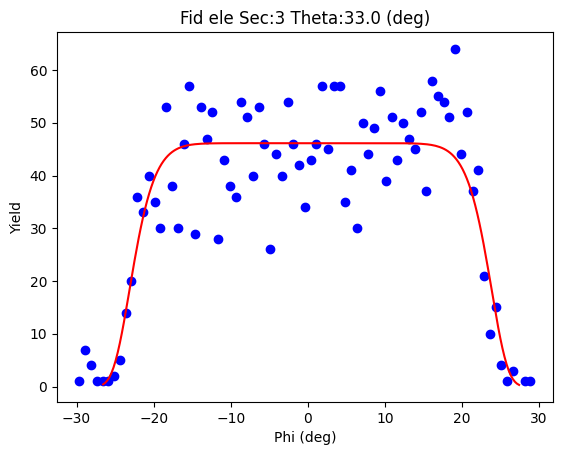

...........Theta: 34.2 ............
Binning| Sec: 2  Ybin: 28
Sum of plot 2770.0
Initial Bounds: [-26.497196516938523, 27.219515587291077]
Sum of initial fit area: 2755.0
max at  57.0
initial max 46.12777826821798
initial guesses: [57.0, 0.3611595351762755, 16.722220867013366, 11.999999999999998]
fit bounds [-26.497196516938523, 27.219515587291077]
(array([44.87549064,  0.14064889, 17.07674505, 12.        ]), array([[ 1.18109967e+00, -8.94036858e-04, -4.41370808e-02,
        -9.09956334e-01],
       [-8.94036858e-04,  8.27480280e-02, -6.04960648e-04,
         8.99076196e-03],
       [-4.41370808e-02, -6.04960648e-04,  4.92987657e-02,
        -1.15088535e-01],
       [-9.09956334e-01,  8.99076196e-03, -1.15088535e-01,
         5.95302331e+00]]))
[44.87549064  0.14064889 17.07674505 12.        ]
[44.87549064  0.14064889 17.07674505 12.        ]
New Bounds for next fit: [-27.28712535119417, 27.568423134422943]


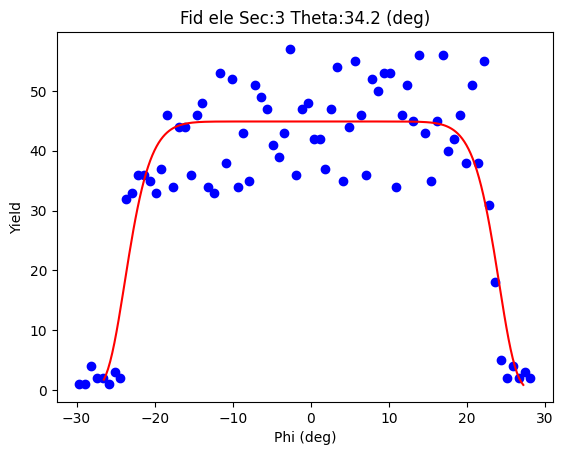

...........Theta: 35.4 ............
Binning| Sec: 2  Ybin: 29
Sum of plot 2668.0
Initial Bounds: [-27.28712535119417, 27.568423134422943]
Sum of initial fit area: 2656.0
max at  61.0
initial max 44.87549064484765
initial guesses: [61.0, 0.14064889161438612, 17.076745050548656, 11.999999999999998]
fit bounds [-27.28712535119417, 27.568423134422943]
(array([43.16553081,  0.14139604, 17.0805108 , 12.        ]), array([[ 1.07997223e+00, -4.59557125e-03, -3.87341107e-02,
        -8.99050623e-01],
       [-4.59557125e-03,  8.43919633e-02, -4.00259847e-03,
         5.19730233e-02],
       [-3.87341107e-02, -4.00259847e-03,  5.17259247e-02,
        -1.50795941e-01],
       [-8.99050623e-01,  5.19730233e-02, -1.50795941e-01,
         6.30816845e+00]]))
[43.16553081  0.14139604 17.0805108  12.        ]
[43.16553081  0.14139604 17.0805108  12.        ]
New Bounds for next fit: [-27.29242655192649, 27.57521863463584]


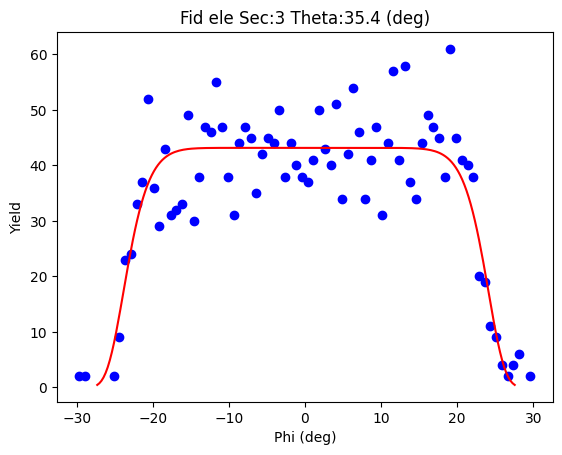

...........Theta: 36.6 ............
Binning| Sec: 2  Ybin: 30
Sum of plot 2748.0
Initial Bounds: [-27.29242655192649, 27.57521863463584]
Sum of initial fit area: 2732.0
max at  58.0
initial max 43.16553081466069
initial guesses: [58.0, 0.1413960413546755, 17.080510800477825, 11.999999999982892]
fit bounds [-27.29242655192649, 27.57521863463584]
(array([44.65678667,  0.2194246 , 16.98498703, 12.        ]), array([[ 9.65202258e-01, -6.37654084e-04, -3.70442212e-02,
        -7.33795686e-01],
       [-6.37654084e-04,  6.72641184e-02, -3.84176095e-04,
         6.18511387e-03],
       [-3.70442212e-02, -3.84176095e-04,  3.97095416e-02,
        -8.53278321e-02],
       [-7.33795686e-01,  6.18511387e-03, -8.53278321e-02,
         4.77582106e+00]]))
[44.65678667  0.2194246  16.98498703 12.        ]
[44.65678667  0.2194246  16.98498703 12.        ]
New Bounds for next fit: [-27.060972707906284, 27.49982190117881]


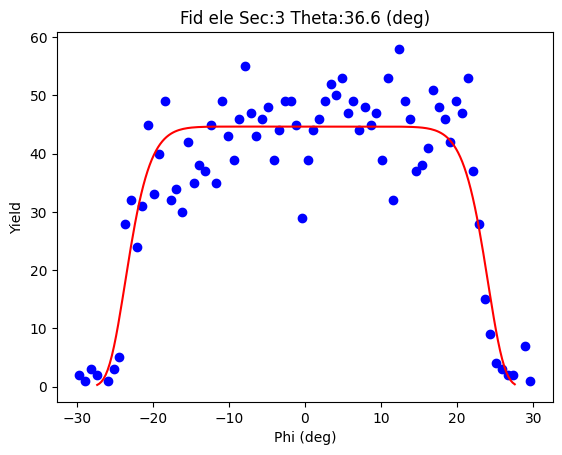

...........Theta: 37.8 ............
Binning| Sec: 2  Ybin: 31
Sum of plot 2764.0
Initial Bounds: [-27.060972707906284, 27.49982190117881]
Sum of initial fit area: 2759.0
max at  58.0
initial max 44.65678666580152
initial guesses: [58.0, 0.21942459663626274, 16.98498702531411, 11.999999999999998]
fit bounds [-27.060972707906284, 27.49982190117881]
(array([44.81302567,  0.11901901, 17.06175946, 12.        ]), array([[ 8.01121646e-01, -2.23645818e-03, -2.89364773e-02,
        -6.25812281e-01],
       [-2.23645818e-03,  5.74457370e-02, -2.02085558e-03,
         2.51180662e-02],
       [-2.89364773e-02, -2.02085558e-03,  3.47465082e-02,
        -9.14160851e-02],
       [-6.25812281e-01,  2.51180662e-02, -9.14160851e-02,
         4.16852640e+00]]))
[44.81302567  0.11901901 17.06175946 12.        ]
[44.81302567  0.11901901 17.06175946 12.        ]
New Bounds for next fit: [-27.28468616702581, 27.52272419069248]


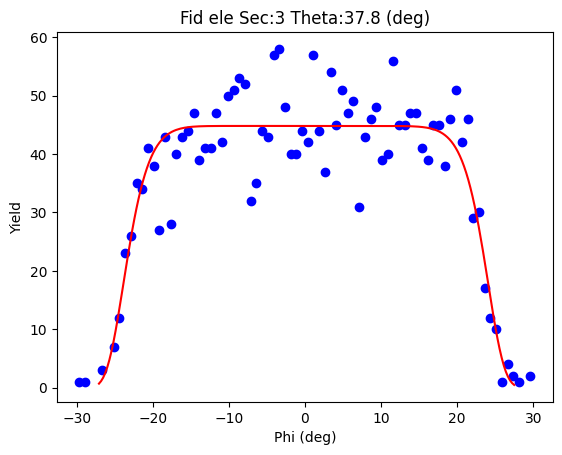

...........Theta: 39.0 ............
Binning| Sec: 2  Ybin: 32
Sum of plot 2840.0
Initial Bounds: [-27.28468616702581, 27.52272419069248]
Sum of initial fit area: 2831.0
max at  64.0
initial max 44.81302567483395
initial guesses: [64.0, 0.11901901183333281, 17.0617594645775, 11.999999999950907]
fit bounds [-27.28468616702581, 27.52272419069248]
(array([45.53788183,  0.15861058, 17.29147782, 12.        ]), array([[ 1.27310060e+00, -1.50522507e-03, -4.51453015e-02,
        -9.95037452e-01],
       [-1.50522507e-03,  8.97150066e-02, -1.15560002e-03,
         1.56395336e-02],
       [-4.51453015e-02, -1.15560002e-03,  5.44202709e-02,
        -1.44370842e-01],
       [-9.95037452e-01,  1.56395336e-02, -1.44370842e-01,
         6.53131439e+00]]))
[45.53788183  0.15861058 17.29147782 12.        ]
[45.53788183  0.15861058 17.29147782 12.        ]
New Bounds for next fit: [-27.61405619241843, 27.93127735415289]


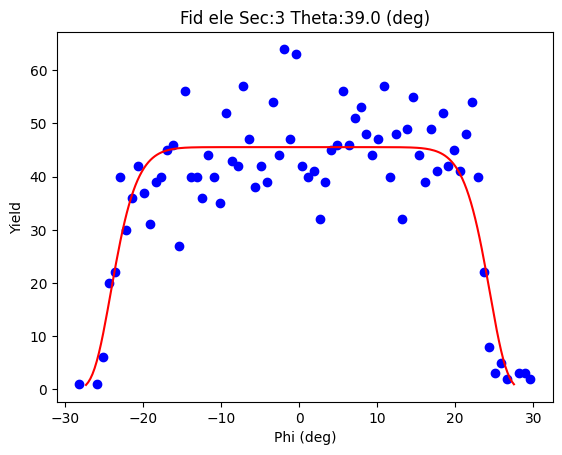

...........Theta: 40.2 ............
Binning| Sec: 2  Ybin: 33
Sum of plot 2767.0
Initial Bounds: [-27.61405619241843, 27.93127735415289]
Sum of initial fit area: 2761.0
max at  54.0
initial max 45.53788183153268
initial guesses: [54.0, 0.15861058086722862, 17.29147781598041, 11.999999999999998]
fit bounds [-27.61405619241843, 27.93127735415289]
(array([44.52488432,  0.56088314, 17.17577999, 12.        ]), array([[ 9.14834282e-01,  2.07363800e-04, -3.61779563e-02,
        -6.89870393e-01],
       [ 2.07363800e-04,  6.54085882e-02,  1.12611738e-04,
        -1.93867871e-03],
       [-3.61779563e-02,  1.12611738e-04,  3.84150998e-02,
        -7.70906483e-02],
       [-6.89870393e-01, -1.93867871e-03, -7.70906483e-02,
         4.47567570e+00]]))
[44.52488432  0.56088314 17.17577999 12.        ]
[44.52488432  0.56088314 17.17577999 12.        ]
New Bounds for next fit: [-27.025955839317692, 28.14772212302105]


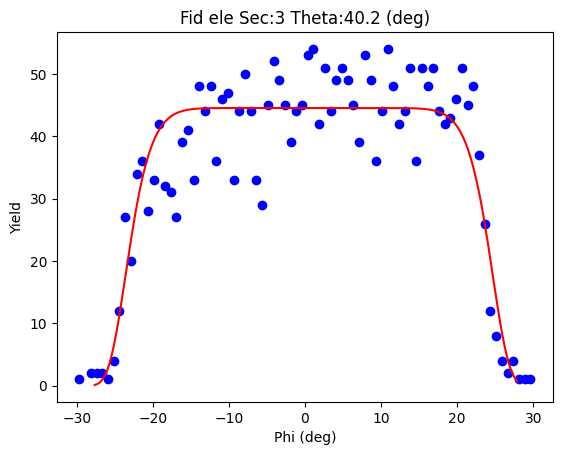

...........Theta: 41.4 ............
Binning| Sec: 2  Ybin: 34
Sum of plot 2752.0
Initial Bounds: [-27.025955839317692, 28.14772212302105]
Sum of initial fit area: 2746.0
max at  57.0
initial max 44.52488431976476
initial guesses: [57.0, 0.560883141851679, 17.175779990805292, 11.99999999999781]
fit bounds [-27.025955839317692, 28.14772212302105]
(array([43.93944511,  0.38954405, 17.3711308 , 12.        ]), array([[ 8.54896905e-01, -2.95535221e-03, -3.15887549e-02,
        -6.84953871e-01],
       [-2.95535221e-03,  6.68155197e-02, -3.04889473e-03,
         3.51687279e-02],
       [-3.15887549e-02, -3.04889473e-03,  4.06792458e-02,
        -1.09917278e-01],
       [-6.84953871e-01,  3.51687279e-02, -1.09917278e-01,
         4.68544880e+00]]))
[43.93944511  0.38954405 17.3711308  12.        ]
[43.93944511  0.38954405 17.3711308  12.        ]
New Bounds for next fit: [-27.511057188706314, 28.290145282349325]


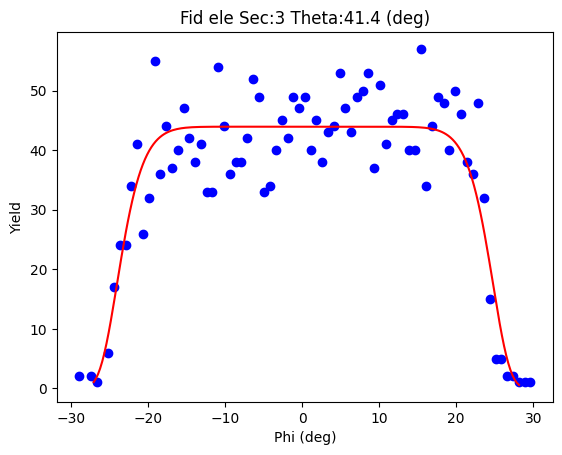

...........Theta: 42.6 ............
Binning| Sec: 2  Ybin: 35
Sum of plot 2594.0
Initial Bounds: [-27.511057188706314, 28.290145282349325]
Sum of initial fit area: 2589.0
max at  58.0
initial max 43.93944511110432
initial guesses: [58.0, 0.3895440468215073, 17.37113080479197, 11.999999999999998]
fit bounds [-27.511057188706314, 28.290145282349325]
(array([41.34376632,  0.60693461, 17.37767833, 12.        ]), array([[ 1.13702188e+00,  7.33140495e-04, -4.83898849e-02,
        -9.31500931e-01],
       [ 7.33140495e-04,  9.67134126e-02,  4.78792698e-04,
        -7.63014427e-03],
       [-4.83898849e-02,  4.78792698e-04,  5.70310855e-02,
        -1.18353425e-01],
       [-9.31500931e-01, -7.63014427e-03, -1.18353425e-01,
         6.53980631e+00]]))
[41.34376632  0.60693461 17.37767833 12.        ]
[41.34376632  0.60693461 17.37767833 12.        ]
New Bounds for next fit: [-27.304182919628715, 28.51805213820508]


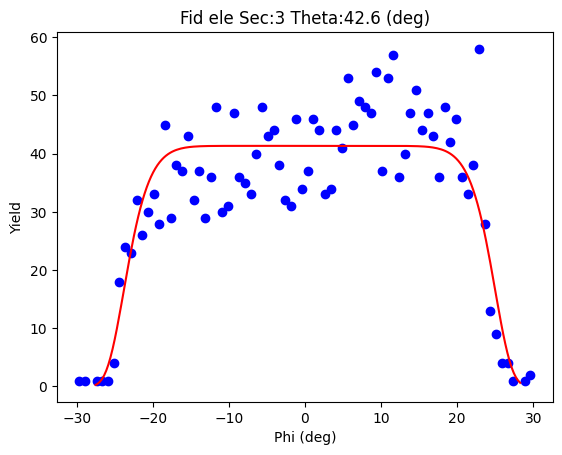

...........Theta: 43.8 ............
Binning| Sec: 2  Ybin: 36
Sum of plot 2548.0
Initial Bounds: [-27.304182919628715, 28.51805213820508]
Sum of initial fit area: 2543.0
max at  56.0
initial max 41.34376632251666
initial guesses: [56.0, 0.6069346092881822, 17.377678330649964, 11.999999999999998]
fit bounds [-27.304182919628715, 28.51805213820508]
(array([39.87486824,  0.23698506, 17.78048912, 12.        ]), array([[ 1.05345088e+00, -5.46148923e-03, -3.87221084e-02,
        -9.92566903e-01],
       [-5.46148923e-03,  1.06608929e-01, -6.12784514e-03,
         7.05460256e-02],
       [-3.87221084e-02, -6.12784514e-03,  6.76275200e-02,
        -2.24707809e-01],
       [-9.92566903e-01,  7.05460256e-02, -2.24707809e-01,
         7.75489359e+00]]))
[39.87486824  0.23698506 17.78048912 12.        ]
[39.87486824  0.23698506 17.78048912 12.        ]
New Bounds for next fit: [-28.32110607673207, 28.795076195031434]


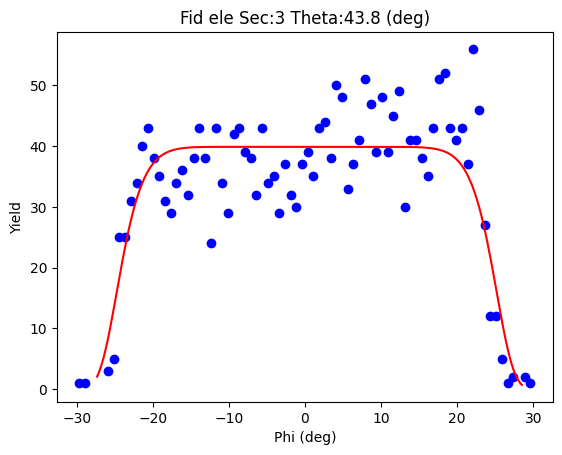

...........Theta: 45.0 ............
Binning| Sec: 2  Ybin: 37
Sum of plot 2317.0
Initial Bounds: [-28.32110607673207, 28.795076195031434]
Sum of initial fit area: 2314.0
max at  48.0
initial max 39.87486823609076
initial guesses: [48.0, 0.23698505914968018, 17.780489118093627, 11.999999999999998]
fit bounds [-28.32110607673207, 28.795076195031434]
(array([36.30873598,  0.13801775, 17.70925851, 12.        ]), array([[ 7.05570109e-01, -1.18070553e-03, -3.39301227e-02,
        -6.68571164e-01],
       [-1.18070553e-03,  8.14212742e-02, -1.10654966e-03,
         1.50977479e-02],
       [-3.39301227e-02, -1.10654966e-03,  4.84838731e-02,
        -1.08442130e-01],
       [-6.68571164e-01,  1.50977479e-02, -1.08442130e-01,
         5.40369234e+00]]))
[36.30873598  0.13801775 17.70925851 12.        ]
[36.30873598  0.13801775 17.70925851 12.        ]
New Bounds for next fit: [-28.305666510975264, 28.581702005448754]


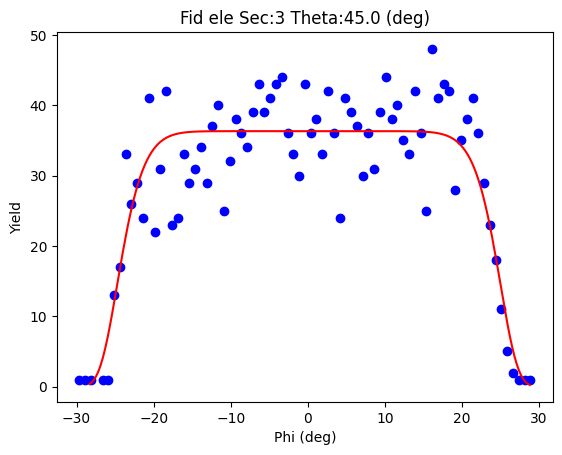

...........Theta: 46.2 ............
Binning| Sec: 2  Ybin: 38
Sum of plot 2229.0
Initial Bounds: [-28.305666510975264, 28.581702005448754]
Sum of initial fit area: 2227.0
max at  50.0
initial max 36.30873597728872
initial guesses: [50.0, 0.13801774723674484, 17.709258508394853, 11.999999999999998]
fit bounds [-28.305666510975264, 28.581702005448754]
(array([34.63689697,  0.09110921, 17.94526874, 12.        ]), array([[ 8.59510837e-01, -5.42325524e-03, -3.97444324e-02,
        -8.85323808e-01],
       [-5.42325524e-03,  1.27205441e-01, -1.55904958e-02,
         1.16448812e-01],
       [-3.97444324e-02, -1.55904958e-02,  7.97907362e-02,
        -2.40979859e-01],
       [-8.85323808e-01,  1.16448812e-01, -2.40979859e-01,
         7.92798351e+00]]))
[34.63689697  0.09110921 17.94526874 12.        ]
[34.63689697  0.09110921 17.94526874 12.        ]
New Bounds for next fit: [-28.73164232731603, 28.91386074144711]


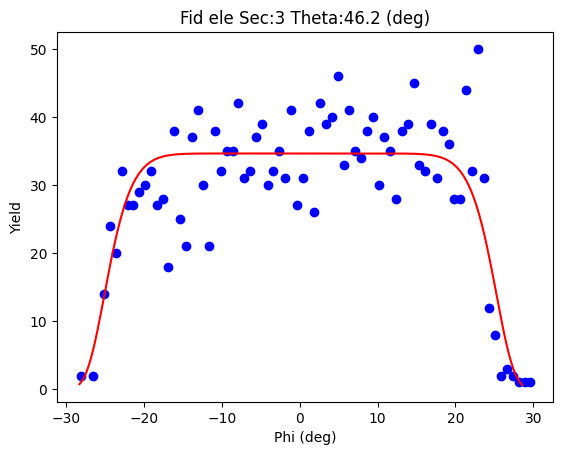

...........Theta: 47.4 ............
Binning| Sec: 2  Ybin: 39
Sum of plot 2163.0
Initial Bounds: [-28.73164232731603, 28.91386074144711]
Sum of initial fit area: 2163.0
max at  48.0
initial max 34.636896973601154
initial guesses: [48.0, 0.09110920706553777, 17.9452687356502, 11.999999999999998]
fit bounds [-28.73164232731603, 28.91386074144711]
(array([33.76671186, -0.27741262, 17.8905224 , 12.        ]), array([[ 6.65900669e-01, -2.10323017e-03, -3.40925581e-02,
        -6.83259790e-01],
       [-2.10323017e-03,  1.01827400e-01, -1.09280236e-02,
         6.46324456e-02],
       [-3.40925581e-02, -1.09280236e-02,  6.22122176e-02,
        -1.59548531e-01],
       [-6.83259790e-01,  6.46324456e-02, -1.59548531e-01,
         6.10494288e+00]]))
[33.76671186 -0.27741262 17.8905224  12.        ]
[33.76671186 -0.27741262 17.8905224  12.        ]
New Bounds for next fit: [-29.01223345076277, 28.4574082198979]


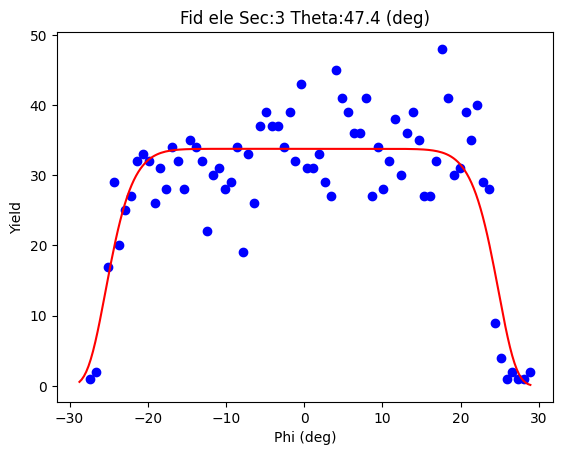

...........Theta: 48.6 ............
Binning| Sec: 2  Ybin: 40
Sum of plot 1912.0
Initial Bounds: [-29.01223345076277, 28.4574082198979]
Sum of initial fit area: 1911.0
max at  45.0
initial max 33.76671185955142
initial guesses: [45.0, -0.2774126154324366, 17.890522400183034, 11.999999999999998]
fit bounds [-29.01223345076277, 28.4574082198979]
(array([30.11659696,  0.47735847, 17.66973192, 12.        ]), array([[ 0.5857476 ,  0.0085638 , -0.02631847, -0.73979459],
       [ 0.0085638 ,  0.11107629,  0.01540118, -0.15877137],
       [-0.02631847,  0.01540118,  0.07185262, -0.26947884],
       [-0.73979459, -0.15877137, -0.26947884,  7.8921907 ]]))
[30.11659696  0.47735847 17.66973192 12.        ]
[30.11659696  0.47735847 17.66973192 12.        ]
New Bounds for next fit: [-27.90284025942599, 28.85755719399823]


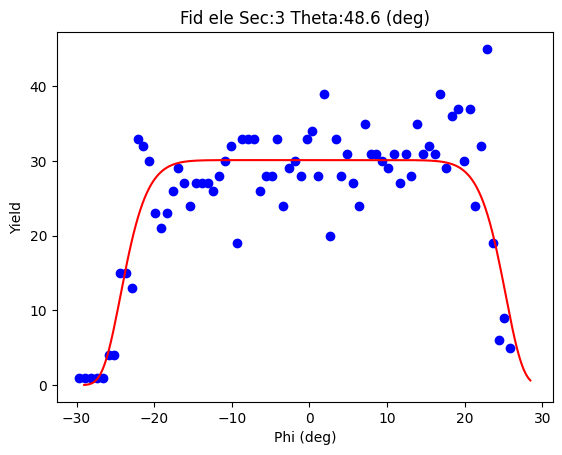

...........Theta: 49.8 ............
Binning| Sec: 2  Ybin: 41
Sum of plot 1702.0
Initial Bounds: [-27.90284025942599, 28.85755719399823]
Sum of initial fit area: 1699.0
max at  37.0
initial max 30.116596958414355
initial guesses: [37.0, 0.47735846728611964, 17.66973192391064, 11.999999999999998]
fit bounds [-27.90284025942599, 28.85755719399823]
(array([26.76449025,  0.6543834 , 17.71521957, 12.        ]), array([[ 5.99557103e-01,  7.92922996e-03, -3.11231333e-02,
        -8.39470695e-01],
       [ 7.92922996e-03,  1.47603428e-01,  2.12990118e-02,
        -1.88734105e-01],
       [-3.11231333e-02,  2.12990118e-02,  9.61409664e-02,
        -3.52906190e-01],
       [-8.39470695e-01, -1.88734105e-01, -3.52906190e-01,
         1.00861547e+01]]))
[26.76449025  0.6543834  17.71521957 12.        ]
[26.76449025  0.6543834  17.71521957 12.        ]
New Bounds for next fit: [-27.79887520872061, 29.107642007958056]


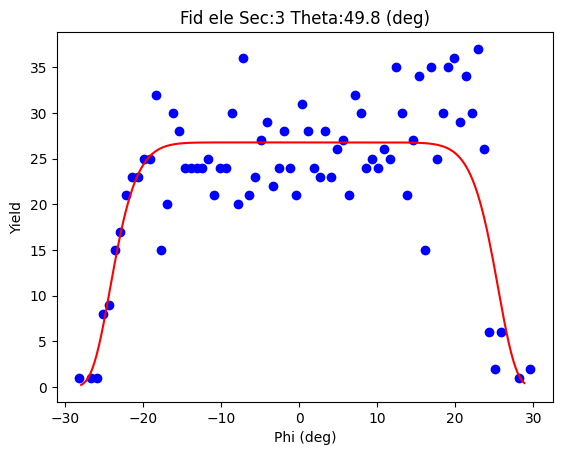

...........Theta: 51.0 ............
Binning| Sec: 2  Ybin: 42
Sum of plot 1592.0
Initial Bounds: [-27.79887520872061, 29.107642007958056]
Sum of initial fit area: 1591.0
max at  34.0
initial max 26.76449025372986
initial guesses: [34.0, 0.6543833996187223, 17.71521957306972, 11.999999999999998]
fit bounds [-27.79887520872061, 29.107642007958056]
(array([25.08525619,  0.25537075, 17.66304284, 12.        ]), array([[ 4.59556683e-01,  1.51791594e-03, -2.88261924e-02,
        -6.67583929e-01],
       [ 1.51791594e-03,  1.12592410e-01,  2.35969515e-03,
        -2.96082089e-02],
       [-2.88261924e-02,  2.35969515e-03,  6.94969707e-02,
        -2.01145778e-01],
       [-6.67583929e-01, -2.96082089e-02, -2.01145778e-01,
         8.08174937e+00]]))
[25.08525619  0.25537075 17.66304284 12.        ]
[25.08525619  0.25537075 17.66304284 12.        ]
New Bounds for next fit: [-28.114084326573273, 28.624825822179577]


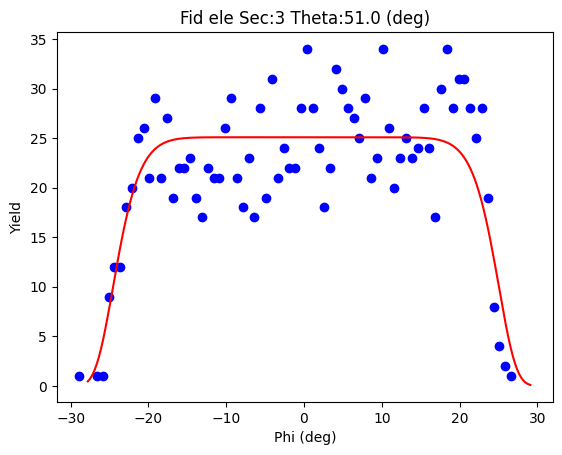

...........Theta: 52.2 ............
Binning| Sec: 2  Ybin: 43
Sum of plot 1508.0
Initial Bounds: [-28.114084326573273, 28.624825822179577]
Sum of initial fit area: 1508.0
max at  31.0
initial max 25.085256186987962
initial guesses: [31.0, 0.2553707478031526, 17.66304284260845, 11.999999999999998]
fit bounds [-28.114084326573273, 28.624825822179577]
(array([23.63973493,  0.47327648, 17.71731104, 12.        ]), array([[ 3.70358677e-01, -8.06945908e-04, -2.51547935e-02,
        -5.64311493e-01],
       [-8.06945908e-04,  1.02897483e-01, -1.69839225e-03,
         1.85097618e-02],
       [-2.51547935e-02, -1.69839225e-03,  6.32804560e-02,
        -1.77106081e-01],
       [-5.64311493e-01,  1.85097618e-02, -1.77106081e-01,
         7.22130503e+00]]))
[23.63973493  0.47327648 17.71731104 12.        ]
[23.63973493  0.47327648 17.71731104 12.        ]
New Bounds for next fit: [-27.983341337124628, 28.92989430246522]


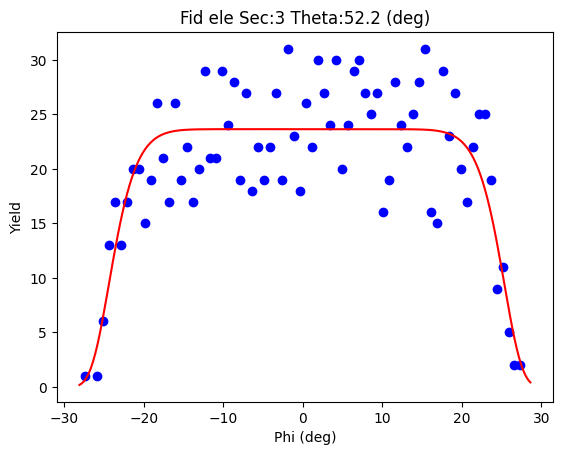

...........Theta: 53.4 ............
Binning| Sec: 2  Ybin: 44
Sum of plot 1266.0
Initial Bounds: [-27.983341337124628, 28.92989430246522]
Sum of initial fit area: 1265.0
max at  33.0
initial max 23.639734933464446
initial guesses: [33.0, 0.47327648267029643, 17.717311044185443, 11.999999999999861]
fit bounds [-27.983341337124628, 28.92989430246522]
(array([19.87352932,  0.81412406, 17.89497438, 12.        ]), array([[ 4.23275596e-01,  2.00360870e-02, -1.26923372e-02,
        -9.30322542e-01],
       [ 2.00360870e-02,  3.08275387e-01,  1.34368778e-01,
        -8.71027237e-01],
       [-1.26923372e-02,  1.34368778e-01,  2.35742108e-01,
        -1.17460440e+00],
       [-9.30322542e-01, -8.71027237e-01, -1.17460440e+00,
         1.80016435e+01]]))
[19.87352932  0.81412406 17.89497438 12.        ]
[19.87352932  0.81412406 17.89497438 12.        ]
New Bounds for next fit: [-27.92784731856318, 29.5560954397071]


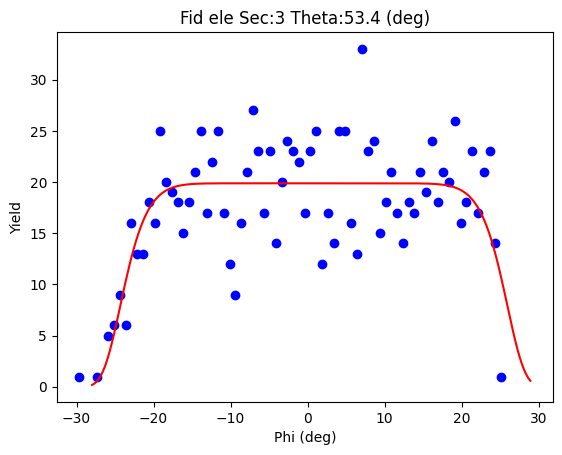

...........Theta: 54.6 ............
Binning| Sec: 2  Ybin: 45
Sum of plot 1224.0
Initial Bounds: [-27.92784731856318, 29.5560954397071]
Sum of initial fit area: 1224.0
max at  30.0
initial max 19.873529324498474
initial guesses: [30.0, 0.8141240605719579, 17.894974384199983, 11.999999999812124]
fit bounds [-27.92784731856318, 29.5560954397071]
(array([19.41788911,  0.55183472, 17.49959534, 12.        ]), array([[ 4.94375821e-01,  3.45675750e-03, -3.81503805e-02,
        -9.31915911e-01],
       [ 3.45675750e-03,  2.07350129e-01,  1.17008236e-02,
        -1.09693238e-01],
       [-3.81503805e-02,  1.17008236e-02,  1.31245249e-01,
        -4.23808299e-01],
       [-9.31915911e-01, -1.09693238e-01, -4.23808299e-01,
         1.48882918e+01]]))
[19.41788911  0.55183472 17.49959534 12.        ]
[19.41788911  0.55183472 17.49959534 12.        ]
New Bounds for next fit: [-27.555099533255063, 28.65876898096595]


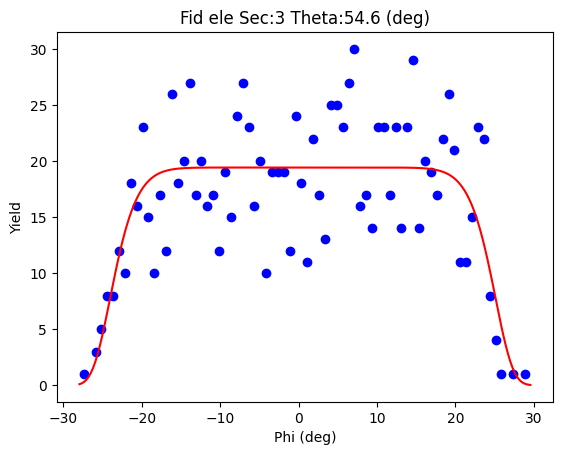

...........Theta: 55.8 ............
Binning| Sec: 2  Ybin: 46
Sum of plot 1113.0
Initial Bounds: [-27.555099533255063, 28.65876898096595]
Sum of initial fit area: 1113.0
max at  25.0
initial max 19.417889107226127
initial guesses: [25.0, 0.5518347238554423, 17.49959534492869, 11.999999999999876]
fit bounds [-27.555099533255063, 28.65876898096595]
(array([17.48268837,  0.40386638, 17.80769633, 12.        ]), array([[ 3.72995844e-01, -6.06275975e-03, -1.80144376e-02,
        -9.26851540e-01],
       [-6.06275975e-03,  2.17807552e-01, -2.22571993e-02,
         2.08505078e-01],
       [-1.80144376e-02, -2.22571993e-02,  1.64485502e-01,
        -8.25724981e-01],
       [-9.26851540e-01,  2.08505078e-01, -8.25724981e-01,
         1.83974114e+01]]))
[17.48268837  0.40386638 17.80769633 12.        ]
[17.48268837  0.40386638 17.80769633 12.        ]
New Bounds for next fit: [-28.197923560868105, 29.005656324093543]


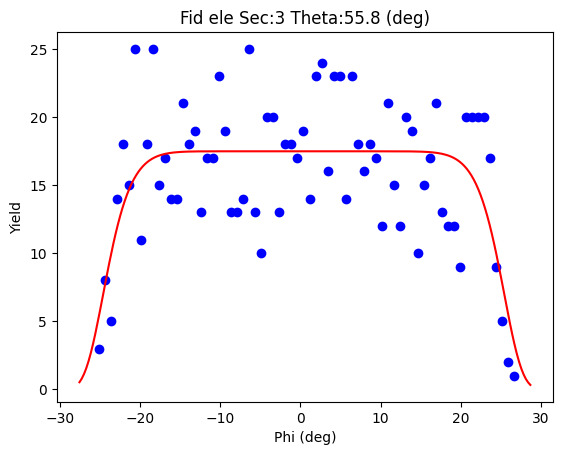

...........Theta: 57.0 ............
Binning| Sec: 2  Ybin: 47
Sum of plot 911.0
Initial Bounds: [-28.197923560868105, 29.005656324093543]
Sum of initial fit area: 910.0
max at  28.0
initial max 17.482688370705986
initial guesses: [28.0, 0.4038663816127195, 17.807696334133084, 11.999999999999998]
fit bounds [-28.197923560868105, 29.005656324093543]
(array([14.09560553,  0.39093925, 18.14022855, 12.        ]), array([[ 3.48841344e-01,  8.03511157e-03, -2.65646656e-02,
        -1.02263953e+00],
       [ 8.03511157e-03,  3.67100164e-01,  7.69360184e-02,
        -4.87433241e-01],
       [-2.65646656e-02,  7.69360184e-02,  2.63577261e-01,
        -1.14705048e+00],
       [-1.02263953e+00, -4.87433241e-01, -1.14705048e+00,
         2.48876519e+01]]))
[14.09560553  0.39093925 18.14022855 12.        ]
[14.09560553  0.39093925 18.14022855 12.        ]
New Bounds for next fit: [-28.74494653559764, 29.52682504183322]


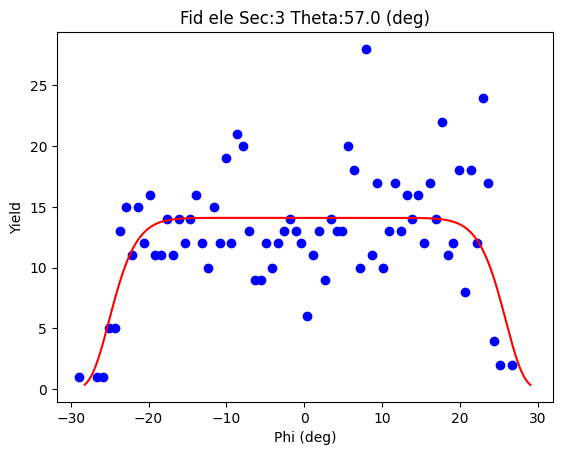

...........Theta: 58.2 ............
Binning| Sec: 2  Ybin: 48
Sum of plot 805.0
Initial Bounds: [-28.74494653559764, 29.52682504183322]
Sum of initial fit area: 805.0
max at  21.0
initial max 14.095605525655996
initial guesses: [21.0, 0.39093925311778827, 18.140228551948635, 11.999999999999998]
fit bounds [-28.74494653559764, 29.52682504183322]
(array([13.75330069,  7.66804354, 22.0260358 ,  3.46609147]), array([[ 0.47617882, -0.33829139, -0.32065233, -0.47736181],
       [-0.33829139,  9.14397785,  7.1943414 ,  0.14876966],
       [-0.32065233,  7.1943414 ,  7.81396896, -0.66417323],
       [-0.47736181,  0.14876966, -0.66417323,  1.37934341]]))
[13.75330069  7.66804354 22.0260358   3.46609147]
[13.75330069  7.66804354 22.0260358   3.46609147]
New Bounds for next fit: [-40.72734252018739, 56.063429609558426]


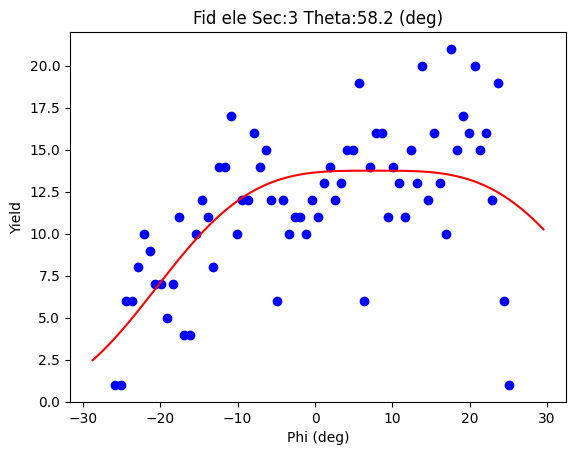

==========Sec  4 ===============
...........Theta: 9.0 ............
Binning| Sec: 3  Ybin: 7
Sum of plot 920.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 843.0
max at  56.0
initial max 13.753300689088796
initial guesses: [56.0, 7.66804354468552, 22.026035803362877, 3.4660914714280637]
fit bounds [-10.0, 10.0]
(array([49.8280746 ,  1.45656875,  5.29895724,  2.45316833]), array([[ 6.83558012,  0.04106633, -0.31656362, -0.81898627],
       [ 0.04106633,  0.06560251,  0.00904911, -0.02077056],
       [-0.31656362,  0.00904911,  0.06741291,  0.0069629 ],
       [-0.81898627, -0.02077056,  0.0069629 ,  0.23650647]]))
[49.8280746   1.45656875  5.29895724  2.45316833]
[49.8280746   1.45656875  5.29895724  2.45316833]
New Bounds for next fit: [-12.509311226280706, 15.422448724877716]


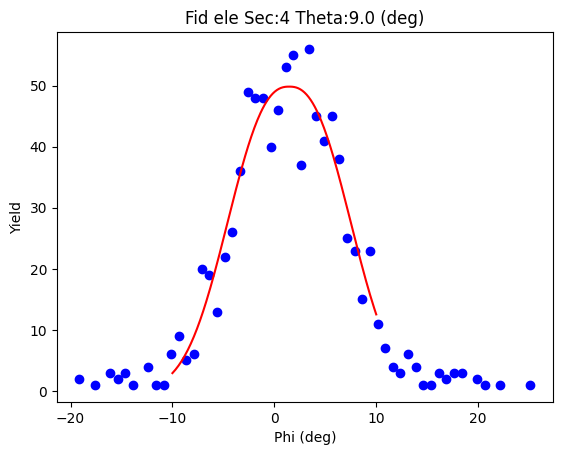

...........Theta: 10.2 ............
Binning| Sec: 3  Ybin: 8
Sum of plot 1636.0
Initial Bounds: [-12.509311226280706, 15.422448724877716]
Sum of initial fit area: 1592.0
max at  94.0
initial max 49.82807459650795
initial guesses: [94.0, 1.4565687492985049, 5.298957244681908, 2.4531683290752078]
fit bounds [-12.509311226280706, 15.422448724877716]
(array([72.0295212 ,  0.52982829,  6.74021625,  2.35184658]), array([[ 6.68678877e+00, -9.58851357e-03, -3.30076831e-01,
        -4.74025061e-01],
       [-9.58851357e-03,  4.44710117e-02, -6.80154299e-04,
         2.42482454e-03],
       [-3.30076831e-01, -6.80154299e-04,  4.68365643e-02,
         1.72224411e-02],
       [-4.74025061e-01,  2.42482454e-03,  1.72224411e-02,
         7.86986128e-02]]))
[72.0295212   0.52982829  6.74021625  2.35184658]
[72.0295212   0.52982829  6.74021625  2.35184658]
New Bounds for next fit: [-17.717506358140383, 18.777162934330157]


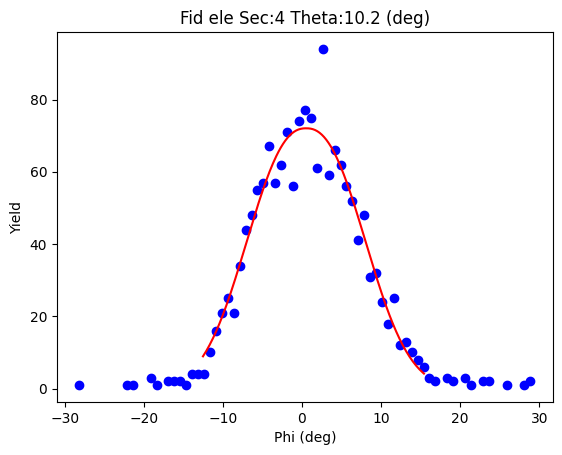

...........Theta: 11.4 ............
Binning| Sec: 3  Ybin: 9
Sum of plot 2083.0
Initial Bounds: [-17.717506358140383, 18.777162934330157]
Sum of initial fit area: 2050.0
max at  84.0
initial max 72.02952119861902
initial guesses: [84.0, 0.5298282880948871, 6.740216247919946, 2.3518465757365195]
fit bounds [-17.717506358140383, 18.777162934330157]
(array([71.5646447 , -0.09327722,  8.48616291,  3.19053032]), array([[ 4.42226235e+00, -8.22425638e-04, -2.16958996e-01,
        -4.32532746e-01],
       [-8.22425638e-04,  5.01593890e-02, -5.87227723e-05,
         3.39429867e-04],
       [-2.16958996e-01, -5.87227723e-05,  4.11443933e-02,
         1.46290429e-02],
       [-4.32532746e-01,  3.39429867e-04,  1.46290429e-02,
         1.24322313e-01]]))
[71.5646447  -0.09327722  8.48616291  3.19053032]
[71.5646447  -0.09327722  8.48616291  3.19053032]
New Bounds for next fit: [-19.46221533341496, 19.275660899807427]


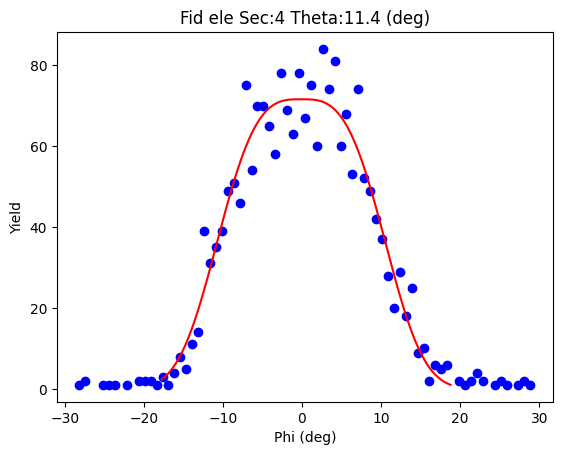

...........Theta: 12.6 ............
Binning| Sec: 3  Ybin: 10
Sum of plot 2534.0
Initial Bounds: [-19.46221533341496, 19.275660899807427]
Sum of initial fit area: 2493.0
max at  84.0
initial max 71.56464470266879
initial guesses: [84.0, -0.09327721680376809, 8.486162914704629, 3.190530320262082]
fit bounds [-19.46221533341496, 19.275660899807427]
(array([71.49473907, -0.33155942, 10.07804845,  4.9735735 ]), array([[ 2.03179636e+00,  2.73600356e-05, -7.46857968e-02,
        -3.45004579e-01],
       [ 2.73600356e-05,  3.04972490e-02,  3.56052797e-06,
        -2.71197951e-05],
       [-7.46857968e-02,  3.56052797e-06,  2.04809762e-02,
         1.45152371e-03],
       [-3.45004579e-01, -2.71197951e-05,  1.45152371e-03,
         2.39658862e-01]]))
[71.49473907 -0.33155942 10.07804845  4.9735735 ]
[71.49473907 -0.33155942 10.07804845  4.9735735 ]
New Bounds for next fit: [-19.706723648331316, 19.043604814916062]


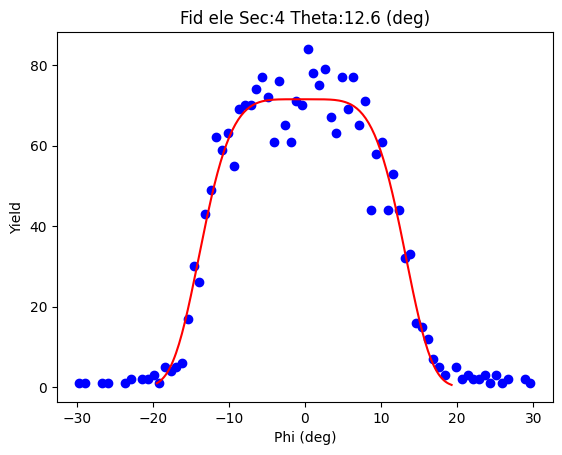

...........Theta: 13.8 ............
Binning| Sec: 3  Ybin: 11
Sum of plot 2835.0
Initial Bounds: [-19.706723648331316, 19.043604814916062]
Sum of initial fit area: 2783.0
max at  82.0
initial max 71.49473907386658
initial guesses: [82.0, -0.3315594167076283, 10.078048453582928, 4.9735734978792605]
fit bounds [-19.706723648331316, 19.043604814916062]
(array([70.07876168, -0.74579646, 11.28894855,  6.70055535]), array([[ 1.61215289e+00, -8.58363950e-04, -4.77324042e-02,
        -4.09610487e-01],
       [-8.58363950e-04,  2.82924334e-02, -1.98279747e-04,
         1.69916015e-03],
       [-4.77324042e-02, -1.98279747e-04,  1.79126364e-02,
        -9.44470768e-03],
       [-4.09610487e-01,  1.69916015e-03, -9.44470768e-03,
         5.34886662e-01]]))
[70.07876168 -0.74579646 11.28894855  6.70055535]
[70.07876168 -0.74579646 11.28894855  6.70055535]
New Bounds for next fit: [-20.797541799610705, 19.30594887039515]


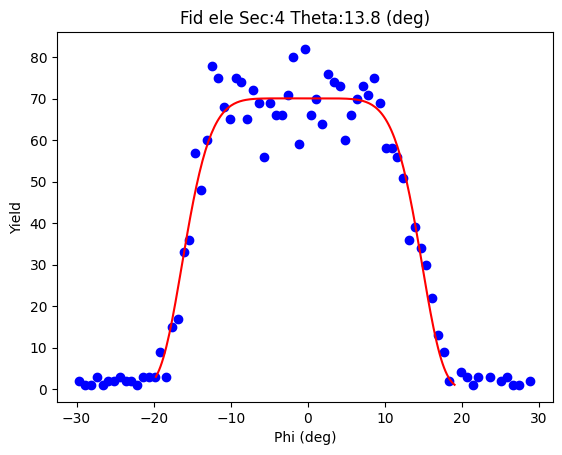

...........Theta: 15.0 ............
Binning| Sec: 3  Ybin: 12
Sum of plot 3082.0
Initial Bounds: [-20.797541799610705, 19.30594887039515]
Sum of initial fit area: 3026.0
max at  88.0
initial max 70.07876168097607
initial guesses: [88.0, -0.7457964646077802, 11.28894855043295, 6.700555345127619]
fit bounds [-20.797541799610705, 19.30594887039515]
(array([69.72468877, -0.74264087, 12.2118401 ,  8.05912888]), array([[ 2.86351432e+00,  2.27826595e-05, -7.70584664e-02,
        -8.93286858e-01],
       [ 2.27826595e-05,  5.40157540e-02,  5.64274153e-06,
        -6.38417333e-05],
       [-7.70584664e-02,  5.64274153e-06,  3.30974866e-02,
        -2.98111867e-02],
       [-8.93286858e-01, -6.38417333e-05, -2.98111867e-02,
         1.68113134e+00]]))
[69.72468877 -0.74264087 12.2118401   8.05912888]
[69.72468877 -0.74264087 12.2118401   8.05912888]
New Bounds for next fit: [-21.616057812928574, 20.13077607592382]


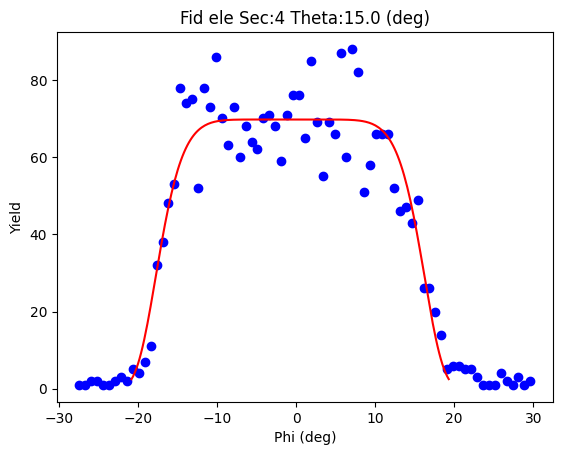

...........Theta: 16.2 ............
Binning| Sec: 3  Ybin: 13
Sum of plot 3442.0
Initial Bounds: [-21.616057812928574, 20.13077607592382]
Sum of initial fit area: 3366.0
max at  89.0
initial max 69.72468877394616
initial guesses: [89.0, -0.7426408685023789, 12.211840104940471, 8.059128880443396]
fit bounds [-21.616057812928574, 20.13077607592382]
(array([72.02146967, -0.67923133, 12.94986045, 11.01347986]), array([[ 1.64952308e+00,  3.41126492e-05, -3.33792486e-02,
        -6.97786912e-01],
       [ 3.41126492e-05,  2.71256786e-02,  8.08862779e-06,
        -1.63802854e-04],
       [-3.33792486e-02,  8.08862779e-06,  1.60151485e-02,
        -3.32289643e-02],
       [-6.97786912e-01, -1.63802854e-04, -3.32289643e-02,
         2.35468479e+00]]))
[72.02146967 -0.67923133 12.94986045 11.01347986]
[72.02146967 -0.67923133 12.94986045 11.01347986]
New Bounds for next fit: [-21.717081159525247, 20.358618506858935]


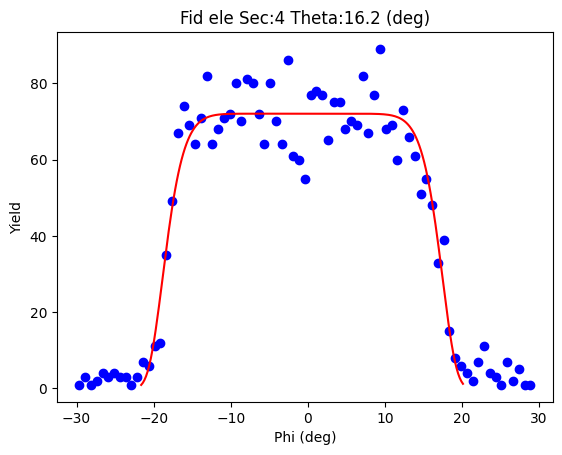

...........Theta: 17.4 ............
Binning| Sec: 3  Ybin: 14
Sum of plot 3488.0
Initial Bounds: [-21.717081159525247, 20.358618506858935]
Sum of initial fit area: 3407.0
max at  90.0
initial max 72.02146966688449
initial guesses: [90.0, -0.6792313263331565, 12.949860451129304, 11.013479863186102]
fit bounds [-21.717081159525247, 20.358618506858935]
(array([70.4952064 , -0.78269356, 13.48514316, 10.1415608 ]), array([[ 2.08558879e+00, -2.60529729e-04, -4.39774352e-02,
        -8.81673003e-01],
       [-2.60529729e-04,  4.16497768e-02, -9.88936839e-05,
         1.25674510e-03],
       [-4.39774352e-02, -9.88936839e-05,  2.57016238e-02,
        -5.92158050e-02],
       [-8.81673003e-01,  1.25674510e-03, -5.92158050e-02,
         2.68495426e+00]]))
[70.4952064  -0.78269356 13.48514316 10.1415608 ]
[70.4952064  -0.78269356 13.48514316 10.1415608 ]
New Bounds for next fit: [-22.952879588630342, 21.38749246143247]


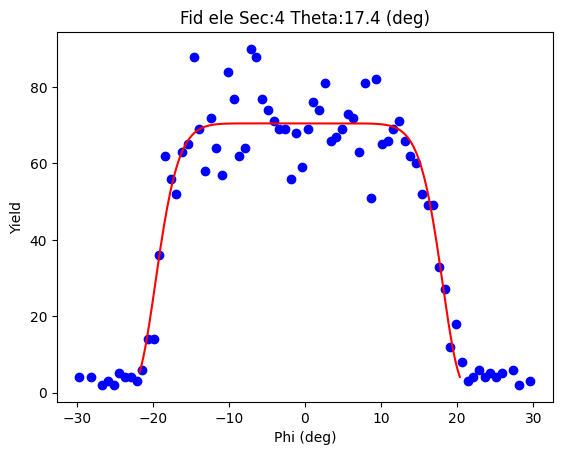

...........Theta: 18.6 ............
Binning| Sec: 3  Ybin: 15
Sum of plot 3651.0
Initial Bounds: [-22.952879588630342, 21.38749246143247]
Sum of initial fit area: 3594.0
max at  91.0
initial max 70.49520640078245
initial guesses: [91.0, -0.7826935635989363, 13.485143158587485, 10.14156080469884]
fit bounds [-22.952879588630342, 21.38749246143247]
(array([70.83845381, -0.58460339, 14.09266964, 10.58267571]), array([[ 2.21862558e+00,  4.30001133e-04, -5.07407471e-02,
        -9.27108777e-01],
       [ 4.30001133e-04,  4.59552567e-02,  1.32841296e-04,
        -2.05272556e-03],
       [-5.07407471e-02,  1.32841296e-04,  2.73989366e-02,
        -5.07209379e-02],
       [-9.27108777e-01, -2.05272556e-03, -5.07209379e-02,
         2.96094379e+00]]))
[70.83845381 -0.58460339 14.09266964 10.58267571]
[70.83845381 -0.58460339 14.09266964 10.58267571]
New Bounds for next fit: [-23.60861772796985, 22.439410951617212]


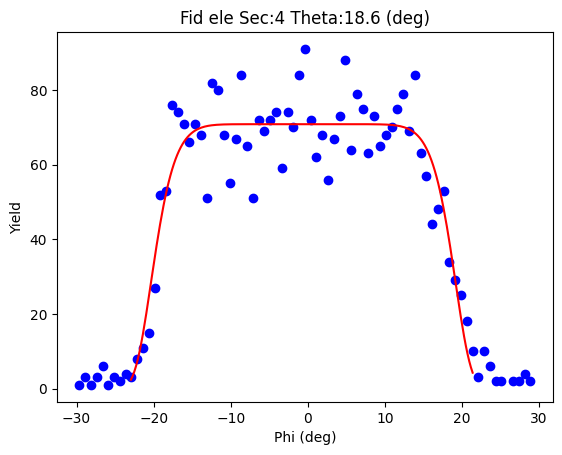

...........Theta: 19.8 ............
Binning| Sec: 3  Ybin: 16
Sum of plot 3694.0
Initial Bounds: [-23.60861772796985, 22.439410951617212]
Sum of initial fit area: 3627.0
max at  93.0
initial max 70.83845381059966
initial guesses: [93.0, -0.5846033881763183, 14.092669640943605, 10.582675711629498]
fit bounds [-23.60861772796985, 22.439410951617212]
(array([69.95767419, -0.77541687, 14.3062007 , 12.        ]), array([[ 2.11914199e+00, -4.17424332e-04, -4.41804740e-02,
        -1.02123960e+00],
       [-4.17424332e-04,  4.26117706e-02, -1.25503165e-04,
         2.52010032e-03],
       [-4.41804740e-02, -1.25503165e-04,  2.50702004e-02,
        -6.16334482e-02],
       [-1.02123960e+00,  2.52010032e-03, -6.16334482e-02,
         4.22575500e+00]]))
[69.95767419 -0.77541687 14.3062007  12.        ]
[69.95767419 -0.77541687 14.3062007  12.        ]
New Bounds for next fit: [-23.753287760656963, 22.202454023978074]


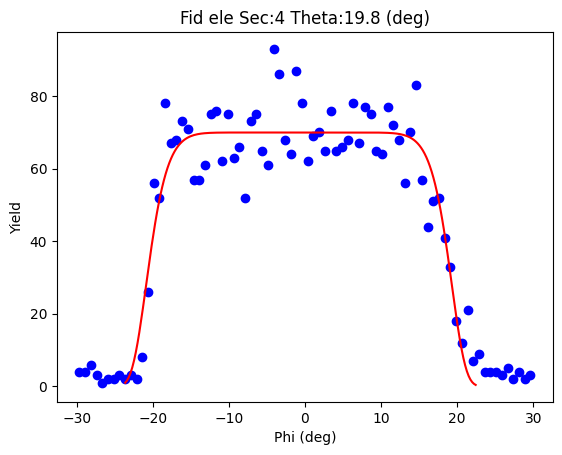

...........Theta: 21.0 ............
Binning| Sec: 3  Ybin: 17
Sum of plot 3852.0
Initial Bounds: [-23.753287760656963, 22.202454023978074]
Sum of initial fit area: 3790.0
max at  88.0
initial max 69.95767418616336
initial guesses: [88.0, -0.7754168683394461, 14.306200698563675, 11.999999999996449]
fit bounds [-23.753287760656963, 22.202454023978074]
(array([70.51808556, -0.55241507, 14.90344734, 12.        ]), array([[ 1.44068043e+00,  5.61181847e-04, -2.99975612e-02,
        -7.04987111e-01],
       [ 5.61181847e-04,  3.11086557e-02,  2.07067697e-04,
        -3.56807126e-03],
       [-2.99975612e-02,  2.07067697e-04,  1.85116259e-02,
        -4.90020376e-02],
       [-7.04987111e-01, -3.56807126e-03, -4.90020376e-02,
         2.93128830e+00]]))
[70.51808556 -0.55241507 14.90344734 12.        ]
[70.51808556 -0.55241507 14.90344734 12.        ]
New Bounds for next fit: [-24.489552255841456, 23.38472211428822]


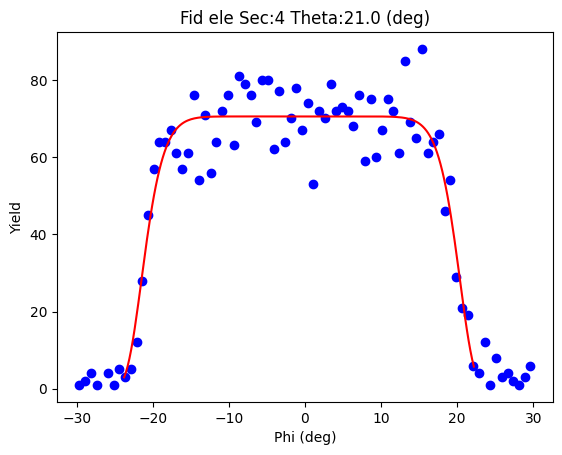

...........Theta: 22.2 ............
Binning| Sec: 3  Ybin: 18
Sum of plot 3748.0
Initial Bounds: [-24.489552255841456, 23.38472211428822]
Sum of initial fit area: 3701.0
max at  85.0
initial max 70.51808555509069
initial guesses: [85.0, -0.5524150707766196, 14.903447335196638, 11.999999999999998]
fit bounds [-24.489552255841456, 23.38472211428822]
(array([67.56047509, -0.66677519, 15.16885197, 12.        ]), array([[ 1.85884908e+00,  1.38832864e-04, -4.24258711e-02,
        -9.29803651e-01],
       [ 1.38832864e-04,  4.50601426e-02,  4.73018900e-05,
        -8.77427045e-04],
       [-4.24258711e-02,  4.73018900e-05,  2.65330256e-02,
        -6.21136347e-02],
       [-9.29803651e-01, -8.77427045e-04, -6.21136347e-02,
         3.98781837e+00]]))
[67.56047509 -0.66677519 15.16885197 12.        ]
[67.56047509 -0.66677519 15.16885197 12.        ]
New Bounds for next fit: [-25.03019141272559, 23.69664102403772]


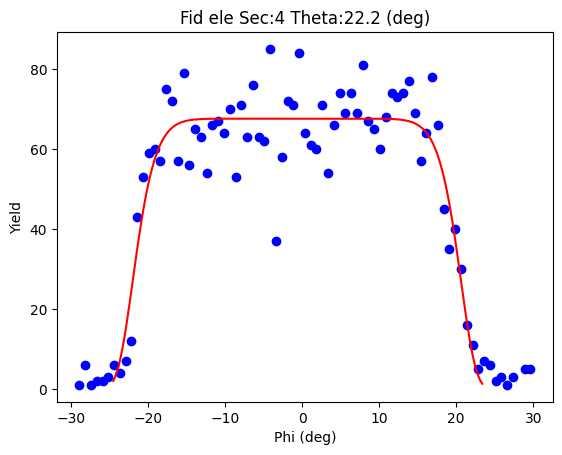

...........Theta: 23.4 ............
Binning| Sec: 3  Ybin: 19
Sum of plot 3771.0
Initial Bounds: [-25.03019141272559, 23.69664102403772]
Sum of initial fit area: 3715.0
max at  79.0
initial max 67.56047508649574
initial guesses: [79.0, -0.6667751943439335, 15.168851968759052, 11.999999999999895]
fit bounds [-25.03019141272559, 23.69664102403772]
(array([66.21119949, -0.62954535, 15.53528491, 12.        ]), array([[ 9.58961370e-01, -3.86141987e-04, -2.24410464e-02,
        -4.95777636e-01],
       [-3.86141987e-04,  2.54716451e-02, -1.51496353e-04,
         2.57488026e-03],
       [-2.24410464e-02, -1.51496353e-04,  1.50944553e-02,
        -3.68603948e-02],
       [-4.95777636e-01,  2.57488026e-03, -3.68603948e-02,
         2.18560594e+00]]))
[66.21119949 -0.62954535 15.53528491 12.        ]
[66.21119949 -0.62954535 15.53528491 12.        ]
New Bounds for next fit: [-25.581506992190754, 24.322416284074336]


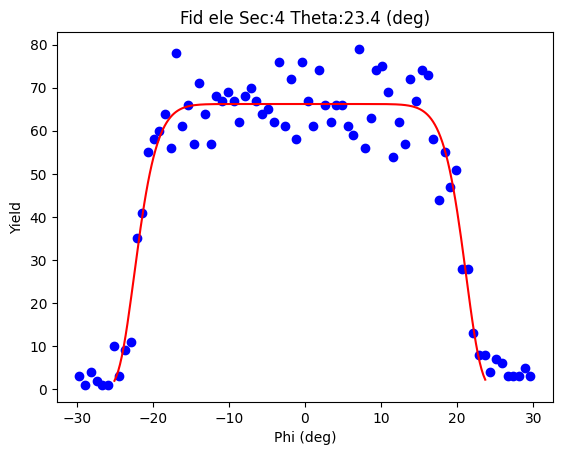

...........Theta: 24.6 ............
Binning| Sec: 3  Ybin: 20
Sum of plot 3647.0
Initial Bounds: [-25.581506992190754, 24.322416284074336]
Sum of initial fit area: 3600.0
max at  84.0
initial max 66.21119949189868
initial guesses: [84.0, -0.6295453540582077, 15.535284913509924, 11.999999999999998]
fit bounds [-25.581506992190754, 24.322416284074336]
(array([63.06146487, -0.42306174, 15.82685324, 11.63441696]), array([[ 1.55369922e+00,  1.18152768e-03, -3.93641135e-02,
        -8.25605421e-01],
       [ 1.18152768e-03,  4.84268583e-02,  5.30957588e-04,
        -7.98567350e-03],
       [-3.93641135e-02,  5.30957588e-04,  2.89634864e-02,
        -6.85157763e-02],
       [-8.25605421e-01, -7.98567350e-03, -6.85157763e-02,
         3.62083423e+00]]))
[63.06146487 -0.42306174 15.82685324 11.63441696]
[63.06146487 -0.42306174 15.82685324 11.63441696]
New Bounds for next fit: [-25.945184066886124, 25.099060595095697]


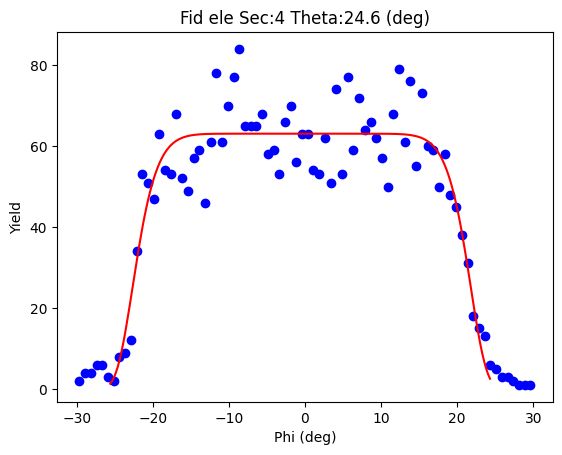

...........Theta: 25.8 ............
Binning| Sec: 3  Ybin: 21
Sum of plot 3787.0
Initial Bounds: [-25.945184066886124, 25.099060595095697]
Sum of initial fit area: 3756.0
max at  85.0
initial max 63.06146487374025
initial guesses: [85.0, -0.42306173589521423, 15.826853241073902, 11.63441696036463]
fit bounds [-25.945184066886124, 25.099060595095697]
(array([65.53373015, -0.2653561 , 15.85084694, 12.        ]), array([[ 1.54617137e+00,  2.69595372e-04, -3.82652973e-02,
        -7.93300499e-01],
       [ 2.69595372e-04,  4.34716543e-02,  9.33448199e-05,
        -1.72199956e-03],
       [-3.82652973e-02,  9.33448199e-05,  2.55466366e-02,
        -5.59412729e-02],
       [-7.93300499e-01, -1.72199956e-03, -5.59412729e-02,
         3.49931026e+00]]))
[65.53373015 -0.2653561  15.85084694 12.        ]
[65.53373015 -0.2653561  15.85084694 12.        ]
New Bounds for next fit: [-25.724156948871254, 25.19344474243598]


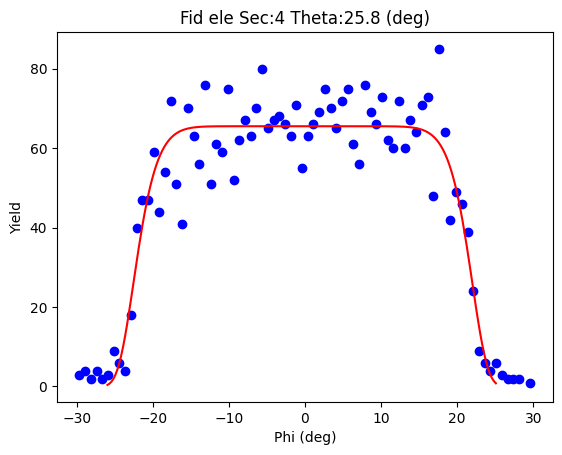

...........Theta: 27.0 ............
Binning| Sec: 3  Ybin: 22
Sum of plot 3764.0
Initial Bounds: [-25.724156948871254, 25.19344474243598]
Sum of initial fit area: 3739.0
max at  80.0
initial max 65.53373015445811
initial guesses: [80.0, -0.26535610321763864, 15.850846936583263, 11.999999999999998]
fit bounds [-25.724156948871254, 25.19344474243598]
(array([63.64866445, -0.28017515, 16.2878261 , 12.        ]), array([[ 1.57948644e+00, -8.25488881e-04, -4.00635813e-02,
        -8.52824584e-01],
       [-8.25488881e-04,  4.99667813e-02, -3.62800774e-04,
         5.78040010e-03],
       [-4.00635813e-02, -3.62800774e-04,  2.96735158e-02,
        -7.05454136e-02],
       [-8.52824584e-01,  5.78040010e-03, -7.05454136e-02,
         3.92027069e+00]]))
[63.64866445 -0.28017515 16.2878261  12.        ]
[63.64866445 -0.28017515 16.2878261  12.        ]
New Bounds for next fit: [-26.4408290614381, 25.880478768206395]


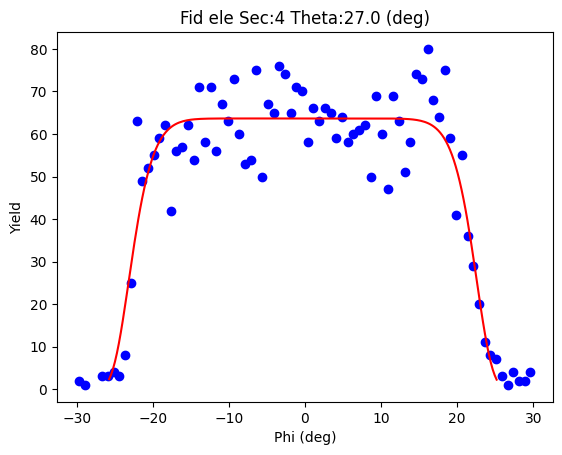

...........Theta: 28.2 ............
Binning| Sec: 3  Ybin: 23
Sum of plot 3809.0
Initial Bounds: [-26.4408290614381, 25.880478768206395]
Sum of initial fit area: 3784.0
max at  80.0
initial max 63.6486644459123
initial guesses: [80.0, -0.28017514661585263, 16.287826102994476, 11.999999999999908]
fit bounds [-26.4408290614381, 25.880478768206395]
(array([63.29162654, -0.28766682, 16.57891295, 12.        ]), array([[ 1.45066300e+00, -4.10751103e-04, -3.84889214e-02,
        -7.76381805e-01],
       [-4.10751103e-04,  4.79025082e-02, -1.67298415e-04,
         2.79376271e-03],
       [-3.84889214e-02, -1.67298415e-04,  2.82417256e-02,
        -6.13050113e-02],
       [-7.76381805e-01,  2.79376271e-03, -6.13050113e-02,
         3.55961864e+00]]))
[63.29162654 -0.28766682 16.57891295 12.        ]
[63.29162654 -0.28766682 16.57891295 12.        ]
New Bounds for next fit: [-26.91584919309464, 26.340515546283168]


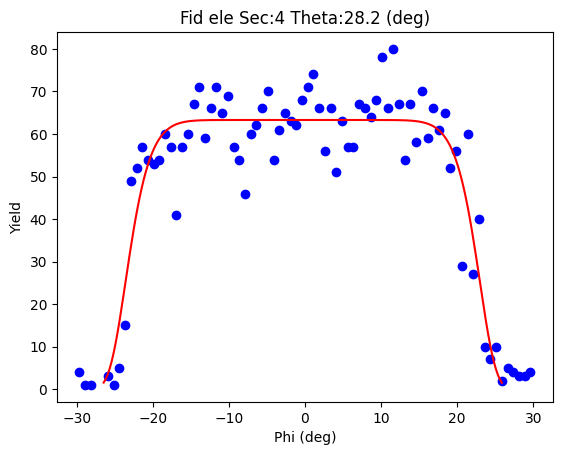

...........Theta: 29.4 ............
Binning| Sec: 3  Ybin: 24
Sum of plot 3796.0
Initial Bounds: [-26.91584919309464, 26.340515546283168]
Sum of initial fit area: 3774.0
max at  82.0
initial max 63.29162654410358
initial guesses: [82.0, -0.28766682340573546, 16.578912946460292, 11.999999999999355]
fit bounds [-26.91584919309464, 26.340515546283168]
(array([63.19930175, -0.26510119, 16.57337115, 12.        ]), array([[ 1.35760982e+00, -3.44160834e-04, -3.61015651e-02,
        -7.27083555e-01],
       [-3.44160834e-04,  4.49213093e-02, -1.39422935e-04,
         2.33907431e-03],
       [-3.61015651e-02, -1.39422935e-04,  2.64740559e-02,
        -5.72523162e-02],
       [-7.27083555e-01,  2.33907431e-03, -5.72523162e-02,
         3.33697179e+00]]))
[63.19930175 -0.26510119 16.57337115 12.        ]
[63.19930175 -0.26510119 16.57337115 12.        ]
New Bounds for next fit: [-26.884382623703978, 26.354180233823556]


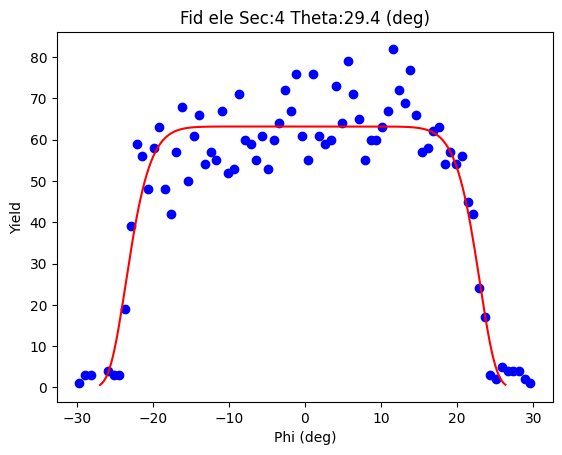

...........Theta: 30.6 ............
Binning| Sec: 3  Ybin: 25
Sum of plot 3769.0
Initial Bounds: [-26.884382623703978, 26.354180233823556]
Sum of initial fit area: 3742.0
max at  85.0
initial max 63.19930175137615
initial guesses: [85.0, -0.2651011949402094, 16.573371151579675, 11.999999999999998]
fit bounds [-26.884382623703978, 26.354180233823556]
(array([62.20215849, -0.10369505, 16.70348876, 12.        ]), array([[ 1.59422730e+00,  1.87404460e-03, -4.17783510e-02,
        -8.88174205e-01],
       [ 1.87404460e-03,  5.58308887e-02,  9.12059061e-04,
        -1.36837229e-02],
       [-4.17783510e-02,  9.12059061e-04,  3.33418560e-02,
        -8.14198547e-02],
       [-8.88174205e-01, -1.36837229e-02, -8.14198547e-02,
         4.20464221e+00]]))
[62.20215849 -0.10369505 16.70348876 12.        ]
[62.20215849 -0.10369505 16.70348876 12.        ]
New Bounds for next fit: [-26.9319645674386, 26.72457447081823]


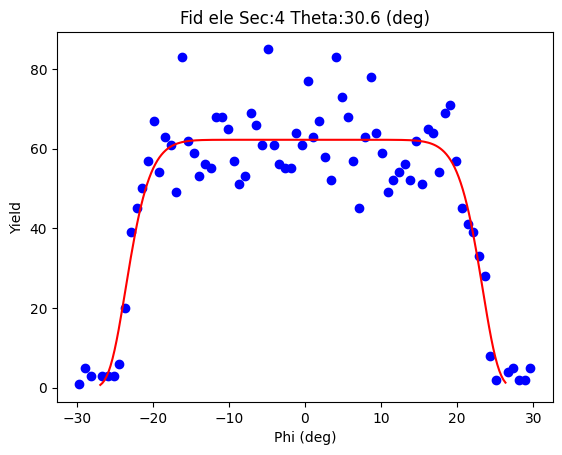

...........Theta: 31.8 ............
Binning| Sec: 3  Ybin: 26
Sum of plot 3791.0
Initial Bounds: [-26.9319645674386, 26.72457447081823]
Sum of initial fit area: 3781.0
max at  82.0
initial max 62.20215849028523
initial guesses: [82.0, -0.1036950483101866, 16.703488758140256, 11.999999999999998]
fit bounds [-26.9319645674386, 26.72457447081823]
(array([62.18459804, -0.07798325, 16.90454408, 12.        ]), array([[ 1.32145804e+00, -3.58032337e-03, -3.27371489e-02,
        -7.62208502e-01],
       [-3.58032337e-03,  4.85701809e-02, -2.11108284e-03,
         2.79523741e-02],
       [-3.27371489e-02, -2.11108284e-03,  2.97129216e-02,
        -8.63395049e-02],
       [-7.62208502e-01,  2.79523741e-02, -8.63395049e-02,
         3.70392406e+00]]))
[62.18459804 -0.07798325 16.90454408 12.        ]
[62.18459804 -0.07798325 16.90454408 12.        ]
New Bounds for next fit: [-27.229177309767195, 27.07321080360969]


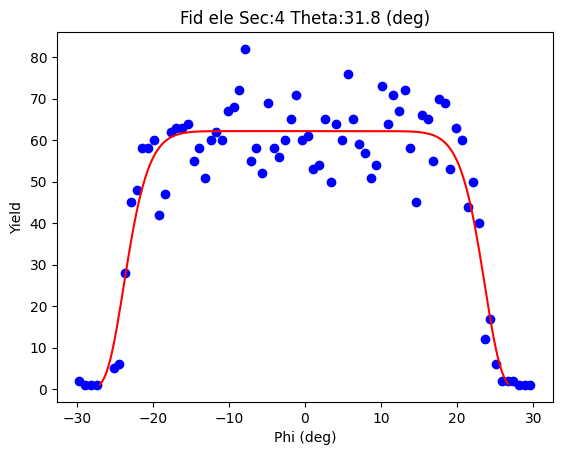

...........Theta: 33.0 ............
Binning| Sec: 3  Ybin: 27
Sum of plot 3673.0
Initial Bounds: [-27.229177309767195, 27.07321080360969]
Sum of initial fit area: 3660.0
max at  79.0
initial max 62.18459804250913
initial guesses: [79.0, -0.07798325307875106, 16.90454408073628, 11.999999999999979]
fit bounds [-27.229177309767195, 27.07321080360969]
(array([59.96283705, -0.140383  , 16.97367508, 12.        ]), array([[ 1.59139253e+00, -1.62274978e-04, -4.60147530e-02,
        -8.93651468e-01],
       [-1.62274978e-04,  6.12844494e-02, -6.75314750e-05,
         1.14313238e-03],
       [-4.60147530e-02, -6.75314750e-05,  3.60316511e-02,
        -7.40996518e-02],
       [-8.93651468e-01,  1.14313238e-03, -7.40996518e-02,
         4.31062927e+00]]))
[59.96283705 -0.140383   16.97367508 12.        ]
[59.96283705 -0.140383   16.97367508 12.        ]
New Bounds for next fit: [-27.402611646431886, 27.121845652062007]


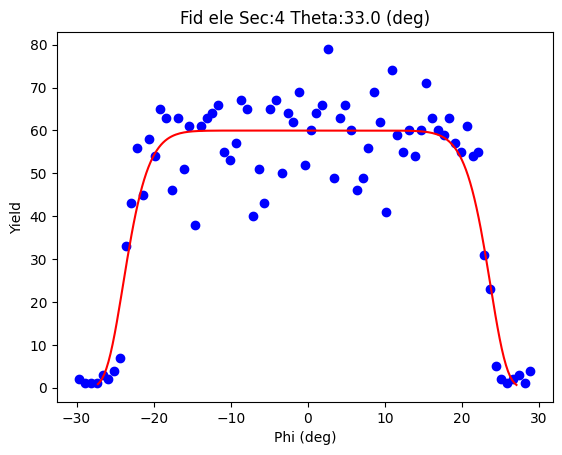

...........Theta: 34.2 ............
Binning| Sec: 3  Ybin: 28
Sum of plot 3649.0
Initial Bounds: [-27.402611646431886, 27.121845652062007]
Sum of initial fit area: 3642.0
max at  73.0
initial max 59.96283705454761
initial guesses: [73.0, -0.1403829971849381, 16.973675079559868, 11.999999999999998]
fit bounds [-27.402611646431886, 27.121845652062007]
(array([59.4235633 , -0.18136974, 17.01578868, 12.        ]), array([[ 1.19339725e+00,  7.12722838e-05, -3.51494360e-02,
        -6.72650889e-01],
       [ 7.12722838e-05,  4.69925711e-02,  2.76566606e-05,
        -4.93129376e-04],
       [-3.51494360e-02,  2.76566606e-05,  2.75696806e-02,
        -5.51499907e-02],
       [-6.72650889e-01, -4.93129376e-04, -5.51499907e-02,
         3.26556695e+00]]))
[59.4235633  -0.18136974 17.01578868 12.        ]
[59.4235633  -0.18136974 17.01578868 12.        ]
New Bounds for next fit: [-27.511239053774, 27.148499573777904]


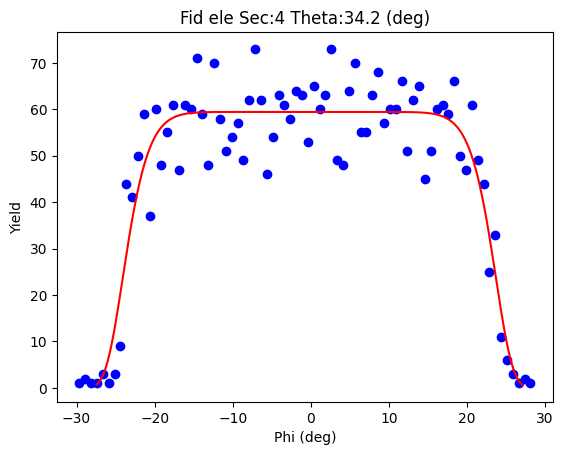

...........Theta: 35.4 ............
Binning| Sec: 3  Ybin: 29
Sum of plot 3625.0
Initial Bounds: [-27.511239053774, 27.148499573777904]
Sum of initial fit area: 3613.0
max at  81.0
initial max 59.42356330368468
initial guesses: [81.0, -0.18136973999804798, 17.015788682106905, 11.999999999999988]
fit bounds [-27.511239053774, 27.148499573777904]
(array([5.78792823e+01, 3.88439125e-02, 1.73606487e+01, 1.20000000e+01]), array([[ 1.28947601e+00,  1.39125996e-04, -3.78567078e-02,
        -7.72132650e-01],
       [ 1.39125996e-04,  5.61238613e-02,  7.50136870e-05,
        -1.08914592e-03],
       [-3.78567078e-02,  7.50136870e-05,  3.34744062e-02,
        -7.75774440e-02],
       [-7.72132650e-01, -1.08914592e-03, -7.75774440e-02,
         3.92055033e+00]]))
[5.78792823e+01 3.88439125e-02 1.73606487e+01 1.20000000e+01]
[5.78792823e+01 3.88439125e-02 1.73606487e+01 1.20000000e+01]
New Bounds for next fit: [-27.84492158320564, 27.922609408117808]


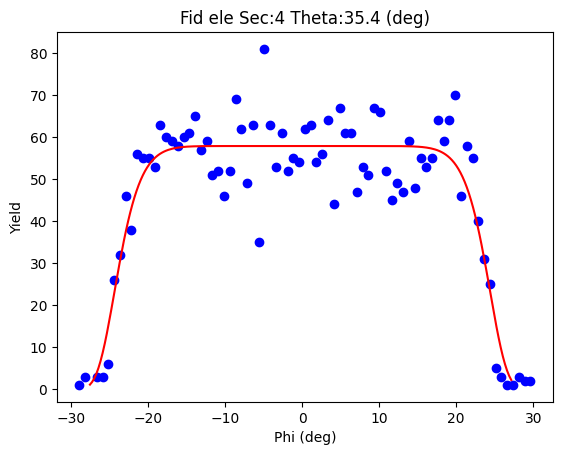

...........Theta: 36.6 ............
Binning| Sec: 3  Ybin: 30
Sum of plot 3467.0
Initial Bounds: [-27.84492158320564, 27.922609408117808]
Sum of initial fit area: 3464.0
max at  70.0
initial max 57.87928234208142
initial guesses: [70.0, 0.038843912456083825, 17.360648742525978, 11.999999999999998]
fit bounds [-27.84492158320564, 27.922609408117808]
(array([55.7141456 , -0.09481859, 17.23376714, 12.        ]), array([[ 9.42619462e-01, -2.63149741e-05, -3.00189219e-02,
        -5.66269126e-01],
       [-2.63149741e-05,  4.33090227e-02, -1.08752510e-05,
         1.93300647e-04],
       [-3.00189219e-02, -1.08752510e-05,  2.54013271e-02,
        -4.99969412e-02],
       [-5.66269126e-01,  1.93300647e-04, -4.99969412e-02,
         2.93110962e+00]]))
[55.7141456  -0.09481859 17.23376714 12.        ]
[55.7141456  -0.09481859 17.23376714 12.        ]
New Bounds for next fit: [-27.774793496220447, 27.585156324386794]


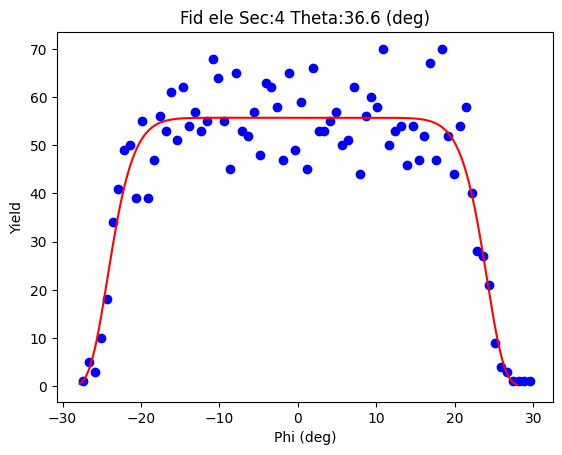

...........Theta: 37.8 ............
Binning| Sec: 3  Ybin: 31
Sum of plot 3238.0
Initial Bounds: [-27.774793496220447, 27.585156324386794]
Sum of initial fit area: 3228.0
max at  66.0
initial max 55.714145602503756
initial guesses: [66.0, -0.0948185859168275, 17.233767142908754, 11.999999999998947]
fit bounds [-27.774793496220447, 27.585156324386794]
(array([5.18437129e+01, 1.65727662e-03, 1.73529262e+01, 1.20000000e+01]), array([[ 1.18672111e+00,  8.69237054e-04, -3.38509985e-02,
        -8.48962192e-01],
       [ 8.69237054e-04,  6.64859310e-02,  5.04264667e-04,
        -7.49070794e-03],
       [-3.38509985e-02,  5.04264667e-04,  4.18481100e-02,
        -1.34644390e-01],
       [-8.48962192e-01, -7.49070794e-03, -1.34644390e-01,
         5.04818085e+00]]))
[5.18437129e+01 1.65727662e-03 1.73529262e+01 1.20000000e+01]
[5.18437129e+01 1.65727662e-03 1.73529262e+01 1.20000000e+01]
New Bounds for next fit: [-27.86970475505253, 27.873019308297273]


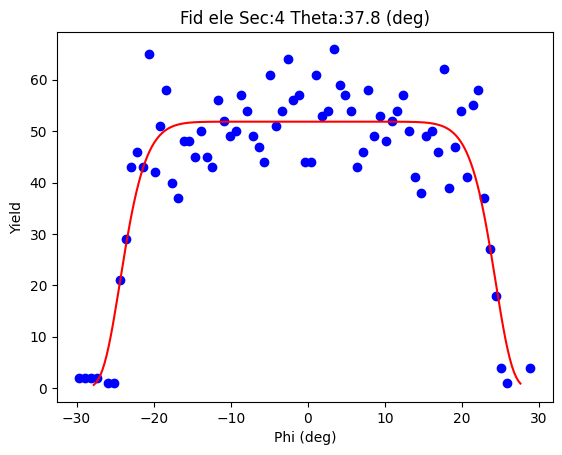

...........Theta: 39.0 ............
Binning| Sec: 3  Ybin: 32
Sum of plot 3081.0
Initial Bounds: [-27.86970475505253, 27.873019308297273]
Sum of initial fit area: 3077.0
max at  67.0
initial max 51.843712884899695
initial guesses: [67.0, 0.001657276622370469, 17.352926249611624, 11.999999999999998]
fit bounds [-27.86970475505253, 27.873019308297273]
(array([48.82919257,  0.23971087, 17.50431558, 12.        ]), array([[ 1.21700930e+00,  3.38910384e-04, -4.43251832e-02,
        -8.42469515e-01],
       [ 3.38910384e-04,  7.52252558e-02,  1.85957433e-04,
        -2.97192179e-03],
       [-4.43251832e-02,  1.85957433e-04,  4.43053570e-02,
        -9.00910029e-02],
       [-8.42469515e-01, -2.97192179e-03, -9.00910029e-02,
         5.00068619e+00]]))
[48.82919257  0.23971087 17.50431558 12.        ]
[48.82919257  0.23971087 17.50431558 12.        ]
New Bounds for next fit: [-27.87480477582227, 28.354226513945477]


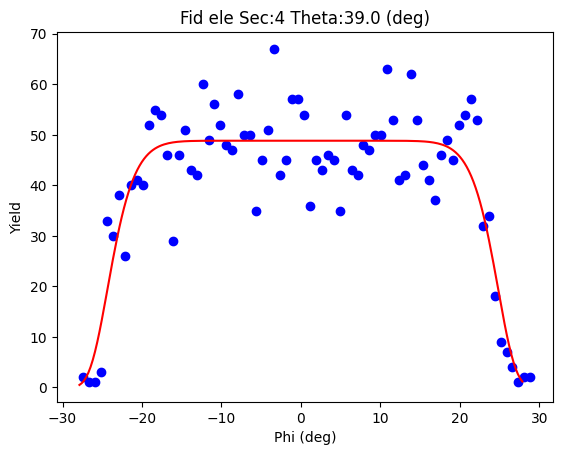

...........Theta: 40.2 ............
Binning| Sec: 3  Ybin: 33
Sum of plot 2872.0
Initial Bounds: [-27.87480477582227, 28.354226513945477]
Sum of initial fit area: 2869.0
max at  67.0
initial max 48.82919256595881
initial guesses: [67.0, 0.2397108690616021, 17.504315575778985, 11.999999999999998]
fit bounds [-27.87480477582227, 28.354226513945477]
(array([45.4312787 ,  0.21371967, 17.5859632 , 12.        ]), array([[ 1.18878253e+00,  4.46525095e-03, -4.21789653e-02,
        -9.29185679e-01],
       [ 4.46525095e-03,  9.00987958e-02,  4.98568080e-03,
        -5.35979153e-02],
       [-4.21789653e-02,  4.98568080e-03,  5.53069836e-02,
        -1.55214001e-01],
       [-9.29185679e-01, -5.35979153e-02, -1.55214001e-01,
         6.19696264e+00]]))
[45.4312787   0.21371967 17.5859632  12.        ]
[45.4312787   0.21371967 17.5859632  12.        ]
New Bounds for next fit: [-28.03193412432939, 28.459373457681245]


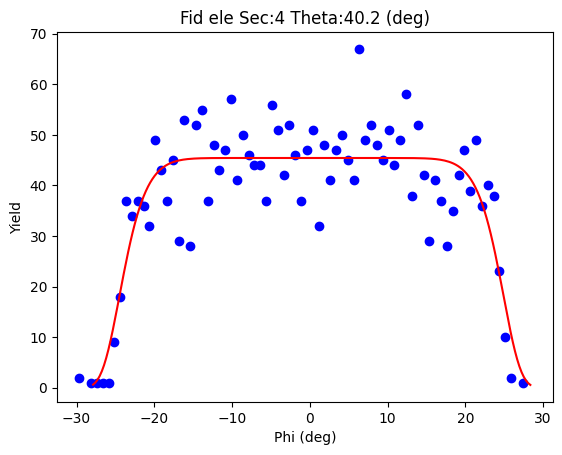

...........Theta: 41.4 ............
Binning| Sec: 3  Ybin: 34
Sum of plot 2734.0
Initial Bounds: [-28.03193412432939, 28.459373457681245]
Sum of initial fit area: 2730.0
max at  53.0
initial max 45.43127870466396
initial guesses: [53.0, 0.21371966667592932, 17.585963203030563, 11.999999999999964]
fit bounds [-28.03193412432939, 28.459373457681245]
(array([4.27250251e+01, 1.90387839e-02, 1.78404768e+01, 1.20000000e+01]), array([[ 7.23632050e-01, -3.23314271e-03, -2.03241473e-02,
        -6.72027294e-01],
       [-3.23314271e-03,  6.87462138e-02, -3.02544234e-03,
         3.71849998e-02],
       [-2.03241473e-02, -3.02544234e-03,  4.78612991e-02,
        -2.00401933e-01],
       [-6.72027294e-01,  3.71849998e-02, -2.00401933e-01,
         5.20172152e+00]]))
[4.27250251e+01 1.90387839e-02 1.78404768e+01 1.20000000e+01]
[4.27250251e+01 1.90387839e-02 1.78404768e+01 1.20000000e+01]
New Bounds for next fit: [-28.635401370943992, 28.67347893867525]


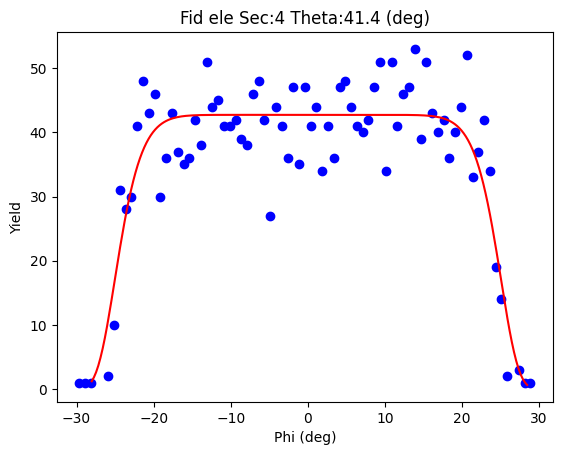

...........Theta: 42.6 ............
Binning| Sec: 3  Ybin: 35
Sum of plot 2425.0
Initial Bounds: [-28.635401370943992, 28.67347893867525]
Sum of initial fit area: 2422.0
max at  54.0
initial max 42.72502508594093
initial guesses: [54.0, 0.019038783865627646, 17.840476764832154, 11.999999999999998]
fit bounds [-28.635401370943992, 28.67347893867525]
(array([37.68533724,  0.07703983, 17.99208512, 12.        ]), array([[ 6.68528168e-01,  1.85178932e-03, -2.51762692e-02,
        -6.63470505e-01],
       [ 1.85178932e-03,  8.71347559e-02, -8.97901962e-04,
        -1.29019265e-02],
       [-2.51762692e-02, -8.97901962e-04,  5.89342643e-02,
        -2.12711772e-01],
       [-6.63470505e-01, -1.29019265e-02, -2.12711772e-01,
         5.69949561e+00]]))
[37.68533724  0.07703983 17.99208512 12.        ]
[37.68533724  0.07703983 17.99208512 12.        ]
New Bounds for next fit: [-28.820905724197324, 28.974985391329504]


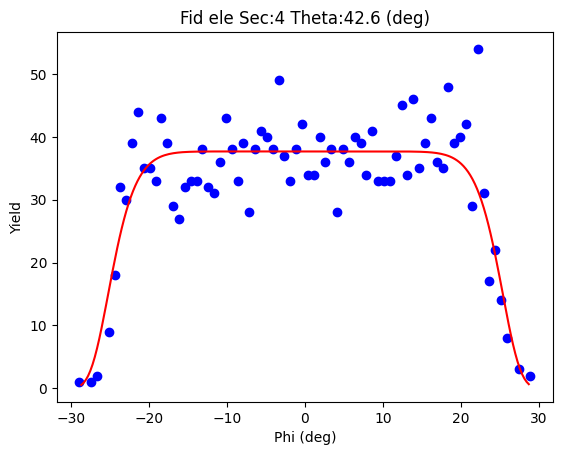

...........Theta: 43.8 ............
Binning| Sec: 3  Ybin: 36
Sum of plot 2191.0
Initial Bounds: [-28.820905724197324, 28.974985391329504]
Sum of initial fit area: 2190.0
max at  47.0
initial max 37.68533724223654
initial guesses: [47.0, 0.0770398335660883, 17.992085118024114, 11.999999999999998]
fit bounds [-28.820905724197324, 28.974985391329504]
(array([34.1995862 ,  0.1376875 , 17.82612647, 12.        ]), array([[ 6.03515762e-01, -5.26645628e-03, -2.62770743e-02,
        -6.55264707e-01],
       [-5.26645628e-03,  8.48988637e-02, -7.08283447e-03,
         8.00472184e-02],
       [-2.62770743e-02, -7.08283447e-03,  5.34966978e-02,
        -1.75237636e-01],
       [-6.55264707e-01,  8.00472184e-02, -1.75237636e-01,
         5.96946162e+00]]))
[34.1995862   0.1376875  17.82612647 12.        ]
[34.1995862   0.1376875  17.82612647 12.        ]
New Bounds for next fit: [-28.493703961437287, 28.769078967450223]


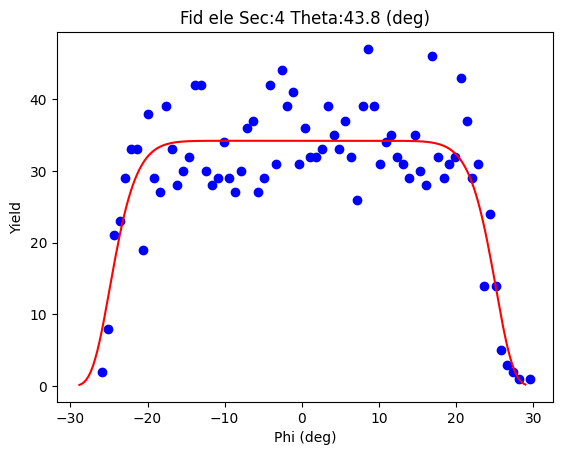

...........Theta: 45.0 ............
Binning| Sec: 3  Ybin: 37
Sum of plot 1972.0
Initial Bounds: [-28.493703961437287, 28.769078967450223]
Sum of initial fit area: 1970.0
max at  46.0
initial max 34.19958619580837
initial guesses: [46.0, 0.13768750300646818, 17.826126471379883, 11.999999999999998]
fit bounds [-28.493703961437287, 28.769078967450223]
(array([30.37058075,  0.65884972, 18.01288456, 12.        ]), array([[ 6.42194678e-01,  3.83543770e-03, -3.48157968e-02,
        -7.56952618e-01],
       [ 3.83543770e-03,  1.12365587e-01,  4.92656453e-03,
        -6.12664004e-02],
       [-3.48157968e-02,  4.92656453e-03,  6.86728536e-02,
        -1.86154968e-01],
       [-7.56952618e-01, -6.12664004e-02, -1.86154968e-01,
         7.52562344e+00]]))
[30.37058075  0.65884972 18.01288456 12.        ]
[30.37058075  0.65884972 18.01288456 12.        ]
New Bounds for next fit: [-28.272502815773304, 29.590202248927636]


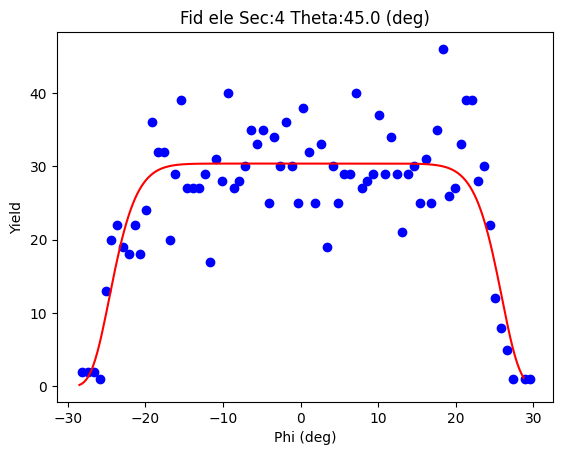

...........Theta: 46.2 ............
Binning| Sec: 3  Ybin: 38
Sum of plot 1809.0
Initial Bounds: [-28.272502815773304, 29.590202248927636]
Sum of initial fit area: 1808.0
max at  39.0
initial max 30.370580748040883
initial guesses: [39.0, 0.6588497165771654, 18.01288455960049, 11.999999999999998]
fit bounds [-28.272502815773304, 29.590202248927636]
(array([27.81912322, -0.04186868, 18.12654161, 12.        ]), array([[ 6.57331435e-01, -5.83164206e-03, -3.70566071e-02,
        -8.57897447e-01],
       [-5.83164206e-03,  1.49132865e-01, -1.51219949e-02,
         1.31676270e-01],
       [-3.70566071e-02, -1.51219949e-02,  9.39039293e-02,
        -2.91229190e-01],
       [-8.57897447e-01,  1.31676270e-01, -2.91229190e-01,
         9.58642427e+00]]))
[27.81912322 -0.04186868 18.12654161 12.        ]
[27.81912322 -0.04186868 18.12654161 12.        ]
New Bounds for next fit: [-29.155771215992374, 29.072033849370165]


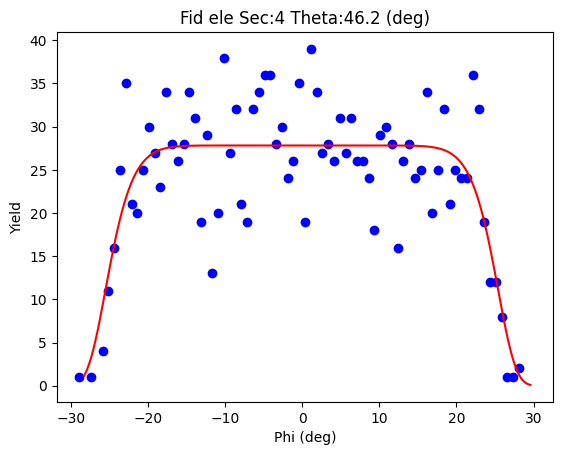

...........Theta: 47.4 ............
Binning| Sec: 3  Ybin: 39
Sum of plot 1517.0
Initial Bounds: [-29.155771215992374, 29.072033849370165]
Sum of initial fit area: 1517.0
max at  32.0
initial max 27.819123220133843
initial guesses: [32.0, -0.041868683311105756, 18.126541606177792, 11.999999999999998]
fit bounds [-29.155771215992374, 29.072033849370165]
(array([23.05971455, -0.06942991, 18.42059827, 12.        ]), array([[ 4.16214874e-01, -8.06900916e-04, -3.12618781e-02,
        -6.39190031e-01],
       [-8.06900916e-04,  1.56534602e-01, -2.40465888e-02,
         1.02518507e-01],
       [-3.12618781e-02, -2.40465888e-02,  9.78245675e-02,
        -2.66028990e-01],
       [-6.39190031e-01,  1.02518507e-01, -2.66028990e-01,
         8.56531507e+00]]))
[23.05971455 -0.06942991 18.42059827 12.        ]
[23.05971455 -0.06942991 18.42059827 12.        ]
New Bounds for next fit: [-29.655630863178263, 29.516771040607484]


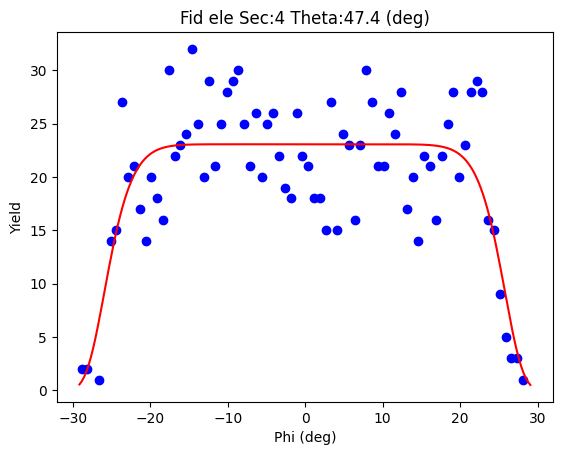

...........Theta: 48.6 ............
Binning| Sec: 3  Ybin: 40
Sum of plot 1400.0
Initial Bounds: [-29.655630863178263, 29.516771040607484]
Sum of initial fit area: 1399.0
max at  33.0
initial max 23.059714549457482
initial guesses: [33.0, -0.06942991128539111, 18.42059826645413, 11.999999999999998]
fit bounds [-29.655630863178263, 29.516771040607484]
(array([21.32849054,  0.44183835, 18.28302489, 12.        ]), array([[ 4.07878298e-01, -2.75534536e-04, -2.91328359e-02,
        -7.03285821e-01],
       [-2.75534536e-04,  1.57981382e-01, -4.22427788e-03,
         2.25595953e-02],
       [-2.91328359e-02, -4.22427788e-03,  1.02311266e-01,
        -3.33890675e-01],
       [-7.03285821e-01,  2.25595953e-02, -3.33890675e-01,
         1.03682286e+01]]))
[21.32849054  0.44183835 18.28302489 12.        ]
[21.32849054  0.44183835 18.28302489 12.        ]
New Bounds for next fit: [-28.923399449270118, 29.807076153763926]


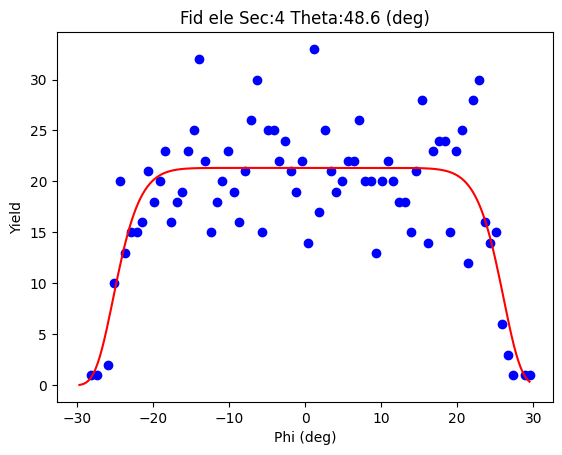

...........Theta: 49.8 ............
Binning| Sec: 3  Ybin: 41
Sum of plot 1216.0
Initial Bounds: [-28.923399449270118, 29.807076153763926]
Sum of initial fit area: 1215.0
max at  28.0
initial max 21.328490543696304
initial guesses: [28.0, 0.441838352246905, 18.283024894618325, 11.999999999999998]
fit bounds [-28.923399449270118, 29.807076153763926]
(array([18.65149103,  0.58760034, 18.08809103, 12.        ]), array([[ 3.43400862e-01, -2.44786128e-04, -3.35830934e-02,
        -6.25678804e-01],
       [-2.44786128e-04,  1.55502661e-01, -3.80620819e-04,
         5.71025062e-03],
       [-3.35830934e-02, -3.80620819e-04,  9.18093859e-02,
        -1.85425968e-01],
       [-6.25678804e-01,  5.71025062e-03, -1.85425968e-01,
         9.75017317e+00]]))
[18.65149103  0.58760034 18.08809103 12.        ]
[18.65149103  0.58760034 18.08809103 12.        ]
New Bounds for next fit: [-28.464544900181142, 29.639745573013908]


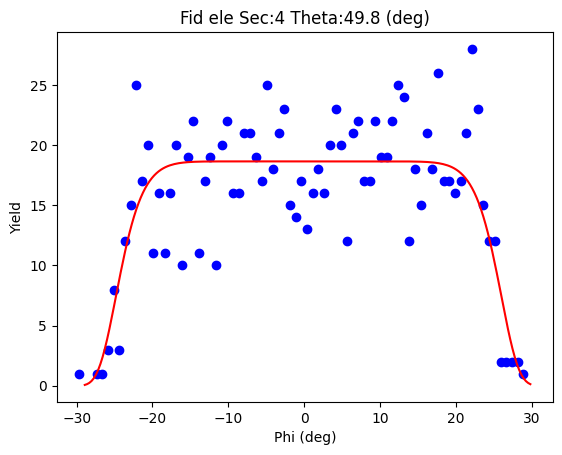

...........Theta: 51.0 ............
Binning| Sec: 3  Ybin: 42
Sum of plot 1242.0
Initial Bounds: [-28.464544900181142, 29.639745573013908]
Sum of initial fit area: 1242.0
max at  28.0
initial max 18.651491029647378
initial guesses: [28.0, 0.5876003364163814, 18.08809103447273, 11.999999999999998]
fit bounds [-28.464544900181142, 29.639745573013908]
(array([19.07201791,  0.84847474, 18.18583269, 12.        ]), array([[ 3.60376065e-01,  1.12787740e-02, -2.27303059e-02,
        -7.47640641e-01],
       [ 1.12787740e-02,  1.96524788e-01,  4.01521018e-02,
        -3.60326306e-01],
       [-2.27303059e-02,  4.01521018e-02,  1.32341337e-01,
        -5.50206141e-01],
       [-7.47640641e-01, -3.60326306e-01, -5.50206141e-01,
         1.31198366e+01]]))
[19.07201791  0.84847474 18.18583269 12.        ]
[19.07201791  0.84847474 18.18583269 12.        ]
New Bounds for next fit: [-28.3606580258881, 30.0576075102762]


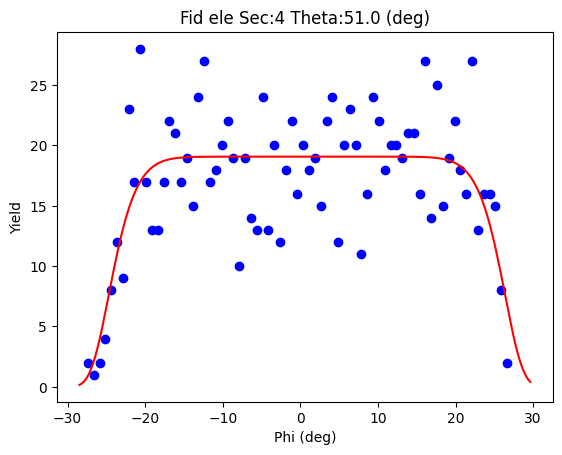

...........Theta: 52.2 ............
Binning| Sec: 3  Ybin: 43
Sum of plot 1177.0
Initial Bounds: [-28.3606580258881, 30.0576075102762]
Sum of initial fit area: 1176.0
max at  27.0
initial max 19.07201790954929
initial guesses: [27.0, 0.848474742194049, 18.185832689611985, 11.999999999999998]
fit bounds [-28.3606580258881, 30.0576075102762]
(array([18.40255454,  0.55609387, 17.71130337, 12.        ]), array([[ 2.58174555e-01, -3.62164795e-04, -2.26764851e-02,
        -5.03498090e-01],
       [-3.62164795e-04,  1.18006789e-01, -1.13366759e-03,
         1.14661525e-02],
       [-2.26764851e-02, -1.13366759e-03,  7.23973210e-02,
        -1.99509011e-01],
       [-5.03498090e-01,  1.14661525e-02, -1.99509011e-01,
         8.25734726e+00]]))
[18.40255454  0.55609387 17.71130337 12.        ]
[18.40255454  0.55609387 17.71130337 12.        ]
New Bounds for next fit: [-27.890874740955898, 29.003062481772584]


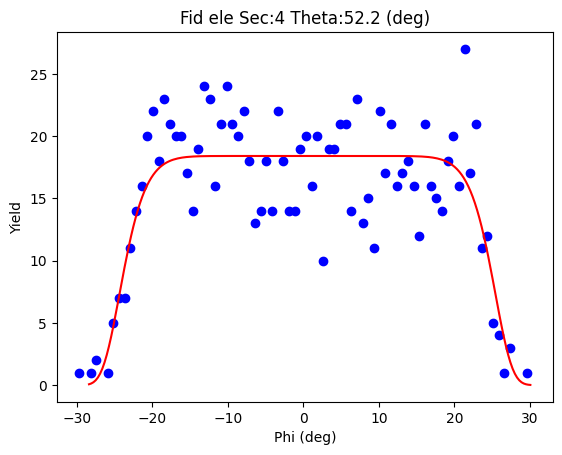

...........Theta: 53.4 ............
Binning| Sec: 3  Ybin: 44
Sum of plot 1160.0
Initial Bounds: [-27.890874740955898, 29.003062481772584]
Sum of initial fit area: 1157.0
max at  31.0
initial max 18.40255453500462
initial guesses: [31.0, 0.5560938704083447, 17.711303372150116, 11.999999999999998]
fit bounds [-27.890874740955898, 29.003062481772584]
(array([17.99129879,  0.50686747, 18.05451477, 11.13355374]), array([[ 3.72527572e-01,  1.07869983e-04, -1.67554777e-02,
        -8.33908121e-01],
       [ 1.07869983e-04,  2.34085168e-01, -8.88668163e-03,
         3.12666392e-02],
       [-1.67554777e-02, -8.88668163e-03,  1.91278210e-01,
        -8.40938934e-01],
       [-8.33908121e-01,  3.12666392e-02, -8.40938934e-01,
         1.43393454e+01]]))
[17.99129879  0.50686747 18.05451477 11.13355374]
[17.99129879  0.50686747 18.05451477 11.13355374]
New Bounds for next fit: [-28.779978623777847, 29.793713565435905]


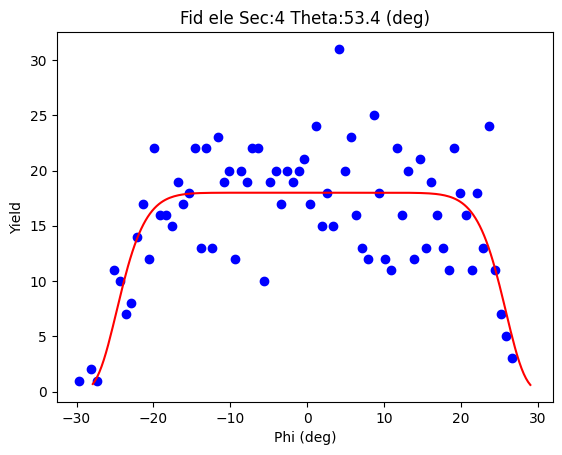

...........Theta: 54.6 ............
Binning| Sec: 3  Ybin: 45
Sum of plot 1136.0
Initial Bounds: [-28.779978623777847, 29.793713565435905]
Sum of initial fit area: 1135.0
max at  28.0
initial max 17.991298789386736
initial guesses: [28.0, 0.506867470829028, 18.054514766443315, 11.133553741452467]
fit bounds [-28.779978623777847, 29.793713565435905]
(array([18.12610227,  0.25783099, 17.43986902, 11.24470571]), array([[ 3.65603086e-01, -5.88633840e-03, -2.79306220e-02,
        -7.31247038e-01],
       [-5.88633840e-03,  1.86737050e-01, -1.60082710e-02,
         1.54640750e-01],
       [-2.79306220e-02, -1.60082710e-02,  1.23808492e-01,
        -4.19562902e-01],
       [-7.31247038e-01,  1.54640750e-01, -4.19562902e-01,
         1.13998899e+01]]))
[18.12610227  0.25783099 17.43986902 11.24470571]
[18.12610227  0.25783099 17.43986902 11.24470571]
New Bounds for next fit: [-27.993645243769272, 28.50930723165007]


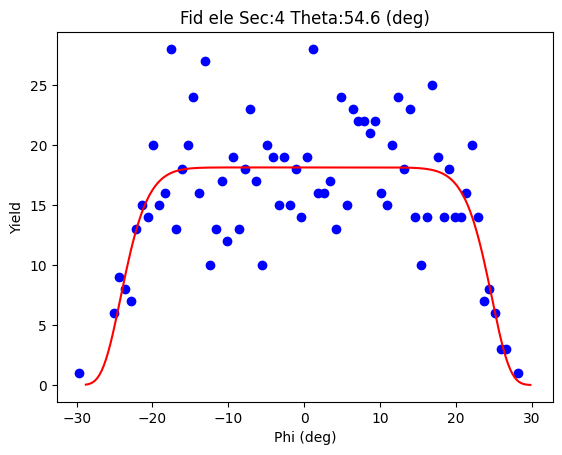

...........Theta: 55.8 ............
Binning| Sec: 3  Ybin: 46
Sum of plot 963.0
Initial Bounds: [-27.993645243769272, 28.50930723165007]
Sum of initial fit area: 962.0
max at  28.0
initial max 18.126102265380236
initial guesses: [28.0, 0.25783099394040027, 17.43986901616883, 11.244705711316609]
fit bounds [-27.993645243769272, 28.50930723165007]
(array([15.30496839,  0.50978597, 17.44278396, 12.        ]), array([[ 3.28310364e-01, -1.03751304e-03, -3.57903699e-02,
        -7.53340881e-01],
       [-1.03751304e-03,  2.07413810e-01, -2.26654627e-03,
         3.14413861e-02],
       [-3.57903699e-02, -2.26654627e-03,  1.24727299e-01,
        -3.07980032e-01],
       [-7.53340881e-01,  3.14413861e-02, -3.07980032e-01,
         1.45900412e+01]]))
[15.30496839  0.50978597 17.44278396 12.        ]
[15.30496839  0.50978597 17.44278396 12.        ]
New Bounds for next fit: [-27.50590080607496, 28.525472754354002]


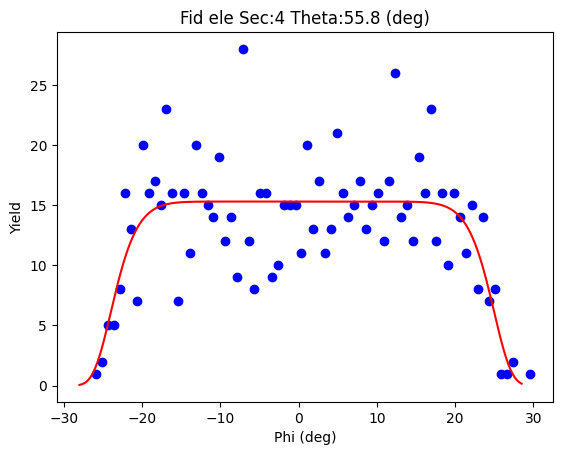

...........Theta: 57.0 ............
Binning| Sec: 3  Ybin: 47
Sum of plot 967.0
Initial Bounds: [-27.50590080607496, 28.525472754354002]
Sum of initial fit area: 967.0
max at  23.0
initial max 15.30496839058804
initial guesses: [23.0, 0.5097859741395214, 17.442783957841122, 11.999999999999996]
fit bounds [-27.50590080607496, 28.525472754354002]
(array([14.80102433,  0.39778285, 18.19682985, 12.        ]), array([[ 2.96252999e-01,  2.38431909e-04, -2.77918718e-02,
        -7.77741153e-01],
       [ 2.38431909e-04,  2.27716317e-01,  7.74879261e-04,
        -8.47323906e-03],
       [-2.77918718e-02,  7.74879261e-04,  1.49030132e-01,
        -5.34598055e-01],
       [-7.77741153e-01, -8.47323906e-03, -5.34598055e-01,
         1.66639869e+01]]))
[14.80102433  0.39778285 18.19682985 12.        ]
[14.80102433  0.39778285 18.19682985 12.        ]
New Bounds for next fit: [-28.82901298695579, 29.624578688723936]


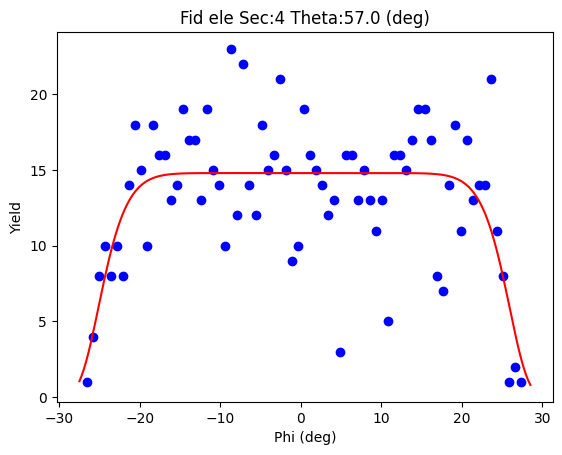

...........Theta: 58.2 ............
Binning| Sec: 3  Ybin: 48
Sum of plot 869.0
Initial Bounds: [-28.82901298695579, 29.624578688723936]
Sum of initial fit area: 869.0
max at  22.0
initial max 14.801024328921617
initial guesses: [22.0, 0.39778285088407306, 18.196829853887593, 11.999999999999998]
fit bounds [-28.82901298695579, 29.624578688723936]
(array([13.42806671,  0.61692541, 18.15542527, 12.        ]), array([[ 3.54393032e-01, -4.15751730e-03, -1.49412642e-03,
        -1.31726426e+00],
       [-4.15751730e-03,  4.00865359e-01, -2.61196734e-02,
         2.09906595e-01],
       [-1.49412642e-03, -2.61196734e-02,  3.85096386e-01,
        -2.32283040e+00],
       [-1.31726426e+00,  2.09906595e-01, -2.32283040e+00,
         3.78722496e+01]]))
[13.42806671  0.61692541 18.15542527 12.        ]
[13.42806671  0.61692541 18.15542527 12.        ]
New Bounds for next fit: [-28.54336854781039, 29.777219370003095]


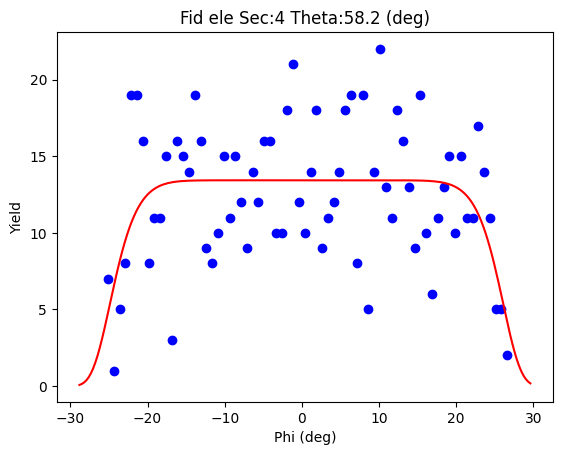

...........Theta: 59.4 ............
Binning| Sec: 3  Ybin: 49
Sum of plot 843.0
Initial Bounds: [-28.54336854781039, 29.777219370003095]
Sum of initial fit area: 843.0
max at  22.0
initial max 13.428066712402883
initial guesses: [22.0, 0.6169254110963547, 18.155425268088177, 11.999999999999984]
fit bounds [-28.54336854781039, 29.777219370003095]
(array([13.13435095,  0.18707328, 17.93554134, 12.        ]), array([[ 3.12371095e-01, -1.00416439e-03, -3.81375460e-02,
        -8.68765343e-01],
       [-1.00416439e-03,  3.25483711e-01, -3.62049745e-02,
         1.63970801e-01],
       [-3.81375460e-02, -3.62049745e-02,  2.04853224e-01,
        -6.06042631e-01],
       [-8.68765343e-01,  1.63970801e-01, -6.06042631e-01,
         2.04718505e+01]]))
[13.13435095  0.18707328 17.93554134 12.        ]
[13.13435095  0.18707328 17.93554134 12.        ]
New Bounds for next fit: [-28.62005461524442, 28.994201183580728]


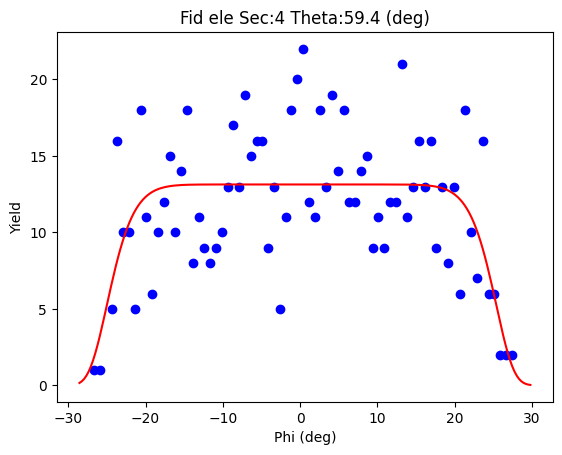

==========Sec  5 ===============
...........Theta: 11.4 ............
Binning| Sec: 4  Ybin: 9
Sum of plot 1117.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 911.0
max at  53.0
initial max 13.134350946729299
initial guesses: [53.0, 0.18707328416815236, 17.93554133929763, 11.999999999999954]
fit bounds [-10.0, 10.0]
(array([40.62367816,  1.85028823,  7.45675891,  4.27278638]), array([[ 3.28572195, -0.01818083, -0.07285294, -1.28623227],
       [-0.01818083,  0.38900986,  0.29648496, -0.25610041],
       [-0.07285294,  0.29648496,  0.39119694, -0.43421866],
       [-1.28623227, -0.25610041, -0.43421866,  1.8693431 ]]))
[40.62367816  1.85028823  7.45675891  4.27278638]
[40.62367816  1.85028823  7.45675891  4.27278638]
New Bounds for next fit: [-13.225869258477621, 16.926445719434227]


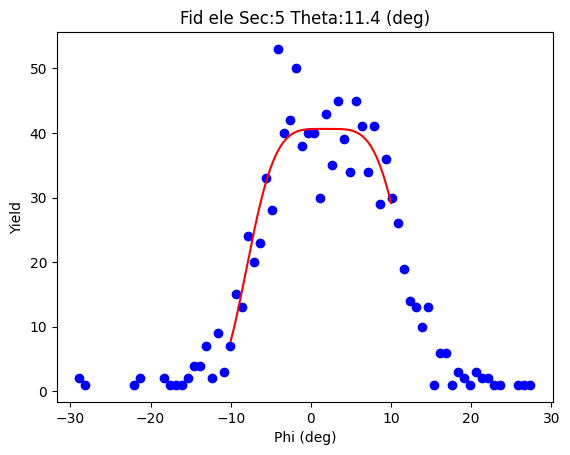

...........Theta: 12.6 ............
Binning| Sec: 4  Ybin: 10
Sum of plot 1304.0
Initial Bounds: [-13.225869258477621, 16.926445719434227]
Sum of initial fit area: 1236.0
max at  58.0
initial max 40.62367816245611
initial guesses: [58.0, 1.8502882304783033, 7.4567589059701636, 4.272786377493016]
fit bounds [-13.225869258477621, 16.926445719434227]
(array([41.64556137,  1.95426412,  8.63788683,  4.47087056]), array([[ 2.41469556e+00,  6.98253335e-04, -1.36672878e-01,
        -6.57299566e-01],
       [ 6.98253335e-04,  8.09250026e-02,  1.93155171e-04,
        -1.07938298e-03],
       [-1.36672878e-01,  1.93155171e-04,  5.71602684e-02,
        -3.26798195e-04],
       [-6.57299566e-01, -1.07938298e-03, -3.26798195e-04,
         6.58077038e-01]]))
[41.64556137  1.95426412  8.63788683  4.47087056]
[41.64556137  1.95426412  8.63788683  4.47087056]
New Bounds for next fit: [-15.23553202491776, 19.144060262544755]


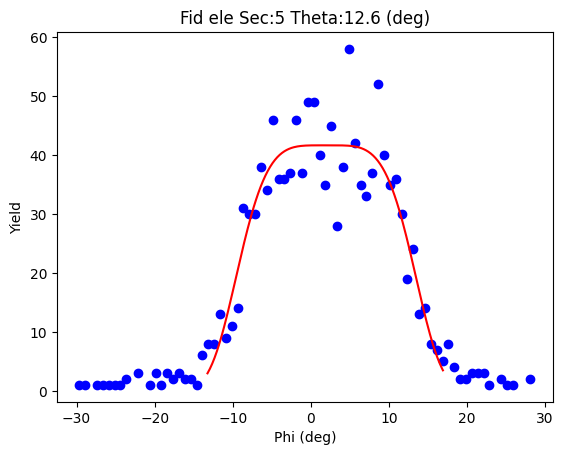

...........Theta: 13.8 ............
Binning| Sec: 4  Ybin: 11
Sum of plot 1544.0
Initial Bounds: [-15.23553202491776, 19.144060262544755]
Sum of initial fit area: 1480.0
max at  56.0
initial max 41.64556137119973
initial guesses: [56.0, 1.9542641188134988, 8.637886826455226, 4.470870559025889]
fit bounds [-15.23553202491776, 19.144060262544755]
(array([43.53088768,  1.33013202,  9.67196921,  5.8088168 ]), array([[ 1.43913732e+00, -1.87265949e-03, -6.85810121e-02,
        -4.96362568e-01],
       [-1.87265949e-03,  5.10900605e-02, -5.49625996e-04,
         4.46076930e-03],
       [-6.85810121e-02, -5.49625996e-04,  3.32375536e-02,
        -9.14679189e-03],
       [-4.96362568e-01,  4.46076930e-03, -9.14679189e-03,
         7.84607756e-01]]))
[43.53088768  1.33013202  9.67196921  5.8088168 ]
[43.53088768  1.33013202  9.67196921  5.8088168 ]
New Bounds for next fit: [-16.461223549745913, 19.121487594641504]


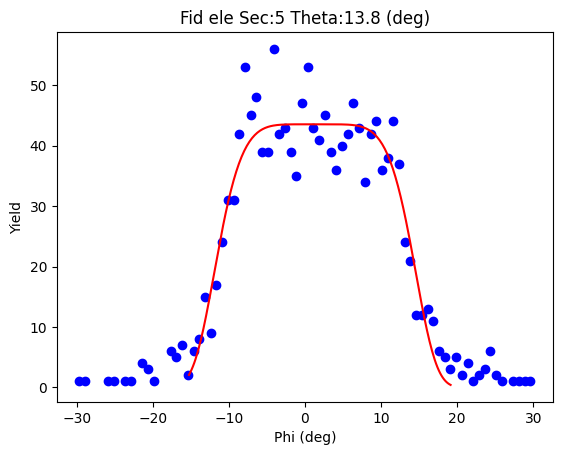

...........Theta: 15.0 ............
Binning| Sec: 4  Ybin: 12
Sum of plot 1852.0
Initial Bounds: [-16.461223549745913, 19.121487594641504]
Sum of initial fit area: 1774.0
max at  62.0
initial max 43.53088767886484
initial guesses: [62.0, 1.3301320224477948, 9.6719692106515, 5.808816795105797]
fit bounds [-16.461223549745913, 19.121487594641504]
(array([46.529538  ,  1.53212747, 10.94021808,  6.04969731]), array([[ 2.2385712 ,  0.00704536, -0.08983212, -0.84797929],
       [ 0.00704536,  0.09077118,  0.0035676 , -0.01991463],
       [-0.08983212,  0.0035676 ,  0.06262111, -0.06138402],
       [-0.84797929, -0.01991463, -0.06138402,  1.46787469]]))
[46.529538    1.53212747 10.94021808  6.04969731]
[46.529538    1.53212747 10.94021808  6.04969731]
New Bounds for next fit: [-18.382576177453878, 21.446831109516708]


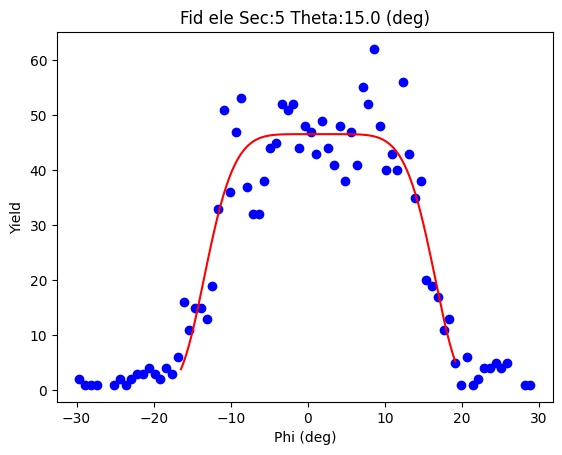

...........Theta: 16.2 ............
Binning| Sec: 4  Ybin: 13
Sum of plot 2367.0
Initial Bounds: [-18.382576177453878, 21.446831109516708]
Sum of initial fit area: 2316.0
max at  68.0
initial max 46.529537998541294
initial guesses: [68.0, 1.5321274660314141, 10.94021808098299, 6.0496973149957025]
fit bounds [-18.382576177453878, 21.446831109516708]
(array([53.76939171,  1.0607007 , 12.02079878,  8.58972384]), array([[ 1.28425109e+00, -2.71916647e-04, -4.17942910e-02,
        -5.52507561e-01],
       [-2.71916647e-04,  3.80570142e-02, -7.85830798e-05,
         1.08335708e-03],
       [-4.17942910e-02, -7.85830798e-05,  2.30454162e-02,
        -2.44072602e-02],
       [-5.52507561e-01,  1.08335708e-03, -2.44072602e-02,
         1.52276657e+00]]))
[53.76939171  1.0607007  12.02079878  8.58972384]
[53.76939171  1.0607007  12.02079878  8.58972384]
New Bounds for next fit: [-19.247066656896884, 21.368468052875997]


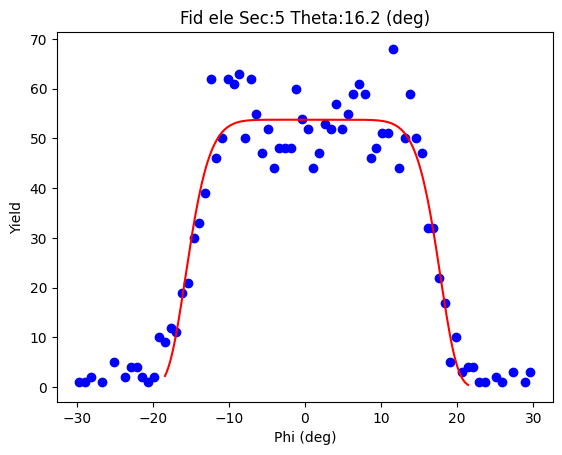

...........Theta: 17.4 ............
Binning| Sec: 4  Ybin: 14
Sum of plot 2397.0
Initial Bounds: [-19.247066656896884, 21.368468052875997]
Sum of initial fit area: 2332.0
max at  66.0
initial max 53.76939170704402
initial guesses: [66.0, 1.060700697989558, 12.020798780283373, 8.58972383802739]
fit bounds [-19.247066656896884, 21.368468052875997]
(array([51.36146041,  0.54035374, 12.78782405,  8.41305659]), array([[ 1.41174491e+00, -1.57485608e-03, -4.65740421e-02,
        -6.70126536e-01],
       [-1.57485608e-03,  5.35424860e-02, -7.71936807e-04,
         7.27577312e-03],
       [-4.65740421e-02, -7.71936807e-04,  3.38401779e-02,
        -5.24094307e-02],
       [-6.70126536e-01,  7.27577312e-03, -5.24094307e-02,
         1.94324381e+00]]))
[51.36146041  0.54035374 12.78782405  8.41305659]
[51.36146041  0.54035374 12.78782405  8.41305659]
New Bounds for next fit: [-21.144022367612177, 22.224729854253642]


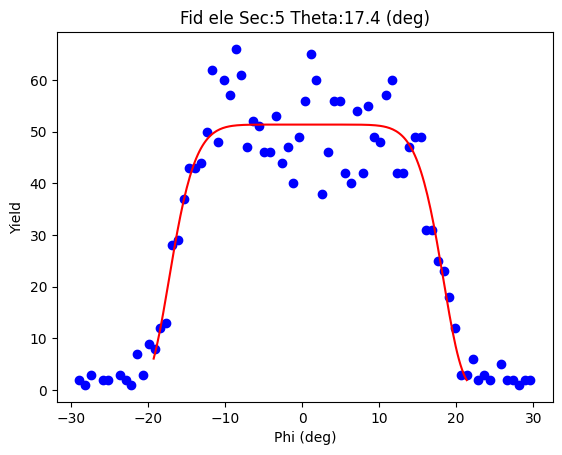

...........Theta: 18.6 ............
Binning| Sec: 4  Ybin: 15
Sum of plot 2321.0
Initial Bounds: [-21.144022367612177, 22.224729854253642]
Sum of initial fit area: 2267.0
max at  56.0
initial max 51.361460409170896
initial guesses: [56.0, 0.5403537433207334, 12.787824049994342, 8.413056589318243]
fit bounds [-21.144022367612177, 22.224729854253642]
(array([45.79151836,  0.25170675, 13.68684966, 11.21221769]), array([[ 1.03731756e+00, -9.84464723e-04, -3.30576121e-02,
        -7.21261293e-01],
       [-9.84464723e-04,  4.68852844e-02, -4.90433237e-04,
         8.31917879e-03],
       [-3.30576121e-02, -4.90433237e-04,  2.79668136e-02,
        -6.60190116e-02],
       [-7.21261293e-01,  8.31917879e-03, -6.60190116e-02,
         4.02328300e+00]]))
[45.79151836  0.25170675 13.68684966 11.21221769]
[45.79151836  0.25170675 13.68684966 11.21221769]
New Bounds for next fit: [-21.928844257053456, 22.432257749740835]


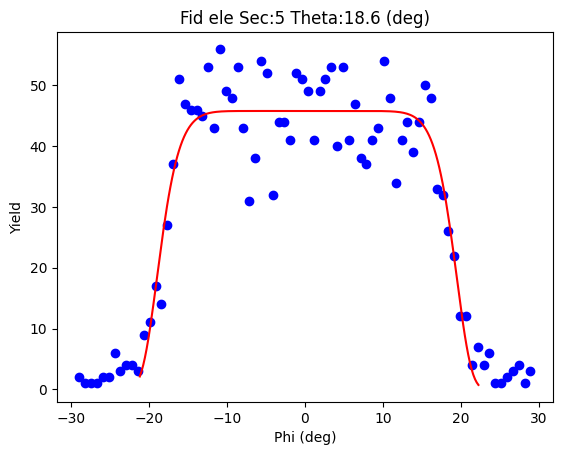

...........Theta: 19.8 ............
Binning| Sec: 4  Ybin: 16
Sum of plot 2634.0
Initial Bounds: [-21.928844257053456, 22.432257749740835]
Sum of initial fit area: 2566.0
max at  63.0
initial max 45.79151836072071
initial guesses: [63.0, 0.25170674634369117, 13.686849660978067, 11.2122176859008]
fit bounds [-21.928844257053456, 22.432257749740835]
(array([49.77764097,  0.76483922, 14.452845  ,  9.63753747]), array([[ 1.26724637,  0.004608  , -0.03615732, -0.77164014],
       [ 0.004608  ,  0.06303152,  0.00343117, -0.03150701],
       [-0.03615732,  0.00343117,  0.04162061, -0.11267975],
       [-0.77164014, -0.03150701, -0.11267975,  3.17691764]]))
[49.77764097  0.76483922 14.452845    9.63753747]
[49.77764097  0.76483922 14.452845    9.63753747]
New Bounds for next fit: [-23.184158484625566, 24.713836920429014]


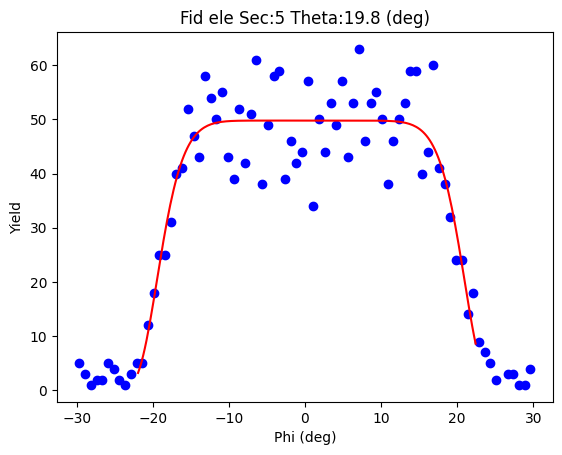

...........Theta: 21.0 ............
Binning| Sec: 4  Ybin: 17
Sum of plot 2842.0
Initial Bounds: [-23.184158484625566, 24.713836920429014]
Sum of initial fit area: 2769.0
max at  66.0
initial max 49.77764096751405
initial guesses: [66.0, 0.7648392179017233, 14.452845003607083, 9.637537470949228]
fit bounds [-23.184158484625566, 24.713836920429014]
(array([5.22409969e+01, 4.30155817e-02, 1.47659280e+01, 9.69627734e+00]), array([[ 1.10146476e+00, -1.09800885e-03, -3.87900583e-02,
        -5.70179605e-01],
       [-1.09800885e-03,  4.88205481e-02, -4.97991913e-04,
         6.07846185e-03],
       [-3.87900583e-02, -4.97991913e-04,  2.94550011e-02,
        -4.26918283e-02],
       [-5.70179605e-01,  6.07846185e-03, -4.26918283e-02,
         2.08447608e+00]]))
[5.22409969e+01 4.30155817e-02 1.47659280e+01 9.69627734e+00]
[5.22409969e+01 4.30155817e-02 1.47659280e+01 9.69627734e+00]
New Bounds for next fit: [-24.401297584094127, 24.487328747524703]


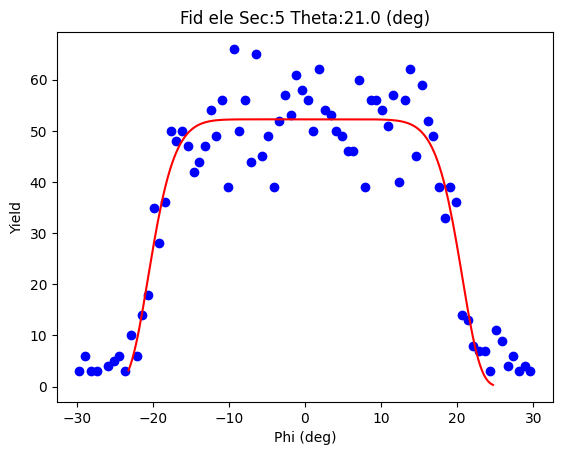

...........Theta: 22.2 ............
Binning| Sec: 4  Ybin: 18
Sum of plot 2858.0
Initial Bounds: [-24.401297584094127, 24.487328747524703]
Sum of initial fit area: 2816.0
max at  65.0
initial max 52.24099689921384
initial guesses: [65.0, 0.04301558171528779, 14.765927988599072, 9.696277338446837]
fit bounds [-24.401297584094127, 24.487328747524703]
(array([50.60516589,  0.29195154, 15.42996662, 12.        ]), array([[ 1.21471240e+00,  1.71858264e-04, -3.79848301e-02,
        -8.05763483e-01],
       [ 1.71858264e-04,  5.42531184e-02,  7.33762219e-05,
        -1.41133178e-03],
       [-3.79848301e-02,  7.33762219e-05,  3.18583839e-02,
        -7.10446365e-02],
       [-8.05763483e-01, -1.41133178e-03, -7.10446365e-02,
         4.59858945e+00]]))
[50.60516589  0.29195154 15.42996662 12.        ]
[50.60516589  0.29195154 15.42996662 12.        ]
New Bounds for next fit: [-24.490853361565495, 25.074756447131453]


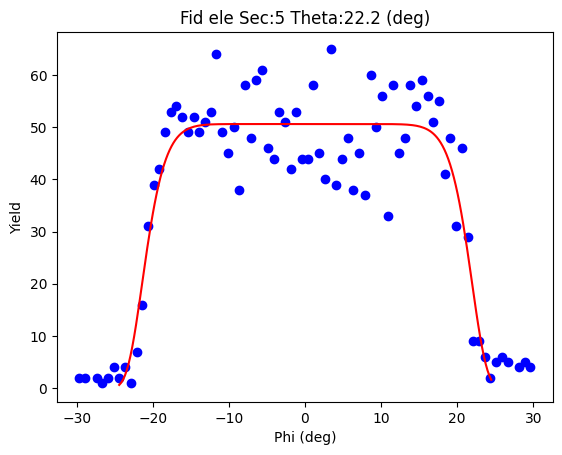

...........Theta: 23.4 ............
Binning| Sec: 4  Ybin: 19
Sum of plot 2643.0
Initial Bounds: [-24.490853361565495, 25.074756447131453]
Sum of initial fit area: 2608.0
max at  65.0
initial max 50.605165892427024
initial guesses: [65.0, 0.29195154278297963, 15.429966618600469, 11.999999999999998]
fit bounds [-24.490853361565495, 25.074756447131453]
(array([45.93463898,  0.2154645 , 15.78893487, 12.        ]), array([[ 1.55740756e+00,  7.97667060e-04, -5.33647226e-02,
        -1.16108586e+00],
       [ 7.97667060e-04,  8.87729743e-02,  4.59973821e-04,
        -7.67611748e-03],
       [-5.33647226e-02,  4.59973821e-04,  5.26146562e-02,
        -1.26594244e-01],
       [-1.16108586e+00, -7.67611748e-03, -1.26594244e-01,
         7.37908021e+00]]))
[45.93463898  0.2154645  15.78893487 12.        ]
[45.93463898  0.2154645  15.78893487 12.        ]
New Bounds for next fit: [-25.143896427448485, 25.574825426872945]


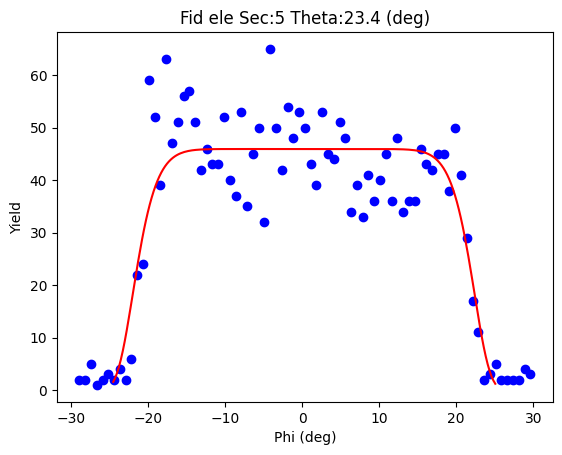

...........Theta: 24.6 ............
Binning| Sec: 4  Ybin: 20
Sum of plot 2675.0
Initial Bounds: [-25.143896427448485, 25.574825426872945]
Sum of initial fit area: 2643.0
max at  60.0
initial max 45.93463897748653
initial guesses: [60.0, 0.21546449971223122, 15.788934871793835, 11.999999999999998]
fit bounds [-25.143896427448485, 25.574825426872945]
(array([ 4.52446770e+01, -2.97362162e-02,  1.62367773e+01,  1.20000000e+01]), array([[ 1.41994647e+00, -8.98450208e-05, -5.11878949e-02,
        -1.06951004e+00],
       [-8.98450208e-05,  8.80829580e-02, -5.24624506e-05,
         8.68454507e-04],
       [-5.11878949e-02, -5.24624506e-05,  5.20690965e-02,
        -1.18668305e-01],
       [-1.06951004e+00,  8.68454507e-04, -1.18668305e-01,
         6.88015421e+00]]))
[ 4.52446770e+01 -2.97362162e-02  1.62367773e+01  1.20000000e+01]
[ 4.52446770e+01 -2.97362162e-02  1.62367773e+01  1.20000000e+01]
New Bounds for next fit: [-26.108398137349482, 26.048925705013936]


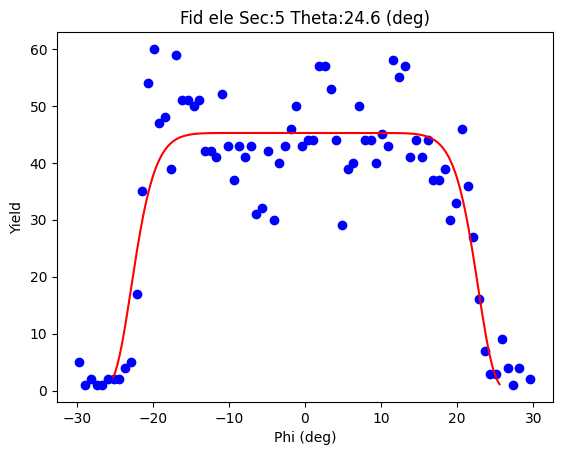

...........Theta: 25.8 ............
Binning| Sec: 4  Ybin: 21
Sum of plot 2790.0
Initial Bounds: [-26.108398137349482, 26.048925705013936]
Sum of initial fit area: 2767.0
max at  62.0
initial max 45.24467701783772
initial guesses: [62.0, -0.029736216167772205, 16.23677725159333, 11.999999999999998]
fit bounds [-26.108398137349482, 26.048925705013936]
(array([46.53165953,  0.14417519, 16.49486766, 12.        ]), array([[ 1.10278078e+00,  1.43464292e-04, -3.99486314e-02,
        -7.97765175e-01],
       [ 1.43464292e-04,  6.65966677e-02,  7.43807073e-05,
        -1.30006163e-03],
       [-3.99486314e-02,  7.43807073e-05,  3.91495874e-02,
        -8.27204732e-02],
       [-7.97765175e-01, -1.30006163e-03, -8.27204732e-02,
         4.95804889e+00]]))
[46.53165953  0.14417519 16.49486766 12.        ]
[46.53165953  0.14417519 16.49486766 12.        ]
New Bounds for next fit: [-26.3490180421269, 26.63736842987634]


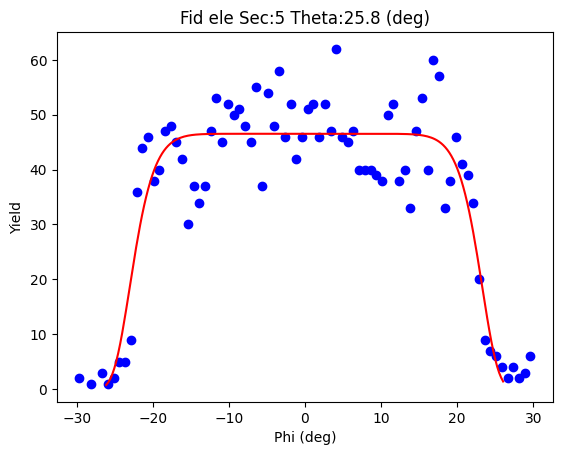

...........Theta: 27.0 ............
Binning| Sec: 4  Ybin: 22
Sum of plot 2861.0
Initial Bounds: [-26.3490180421269, 26.63736842987634]
Sum of initial fit area: 2829.0
max at  60.0
initial max 46.53165953443241
initial guesses: [60.0, 0.1441751938747194, 16.494867664471233, 11.999999999999998]
fit bounds [-26.3490180421269, 26.63736842987634]
(array([47.52983518,  0.25021535, 16.50421146, 12.        ]), array([[ 8.60598245e-01, -3.11160313e-05, -3.07836691e-02,
        -6.05739991e-01],
       [-3.11160313e-05,  4.98253000e-02, -1.42329319e-05,
         2.66700786e-04],
       [-3.07836691e-02, -1.42329319e-05,  2.92182794e-02,
        -5.99276244e-02],
       [-6.05739991e-01,  2.66700786e-04, -5.99276244e-02,
         3.67455019e+00]]))
[47.52983518  0.25021535 16.50421146 12.        ]
[47.52983518  0.25021535 16.50421146 12.        ]
New Bounds for next fit: [-26.2579854097736, 26.758416109079686]


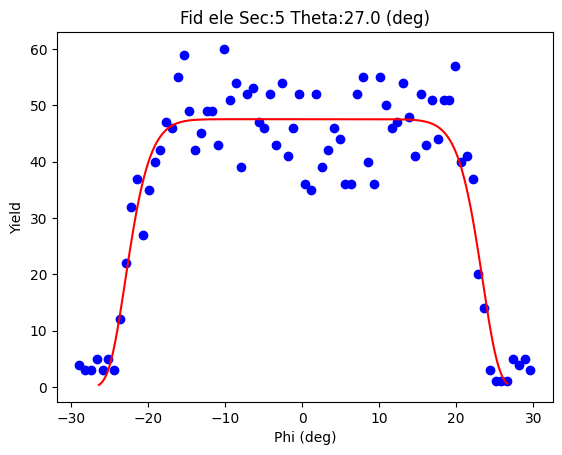

...........Theta: 28.2 ............
Binning| Sec: 4  Ybin: 23
Sum of plot 2788.0
Initial Bounds: [-26.2579854097736, 26.758416109079686]
Sum of initial fit area: 2759.0
max at  57.0
initial max 47.52983517786649
initial guesses: [57.0, 0.25021534965304154, 16.504211464996065, 11.999999999999087]
fit bounds [-26.2579854097736, 26.758416109079686]
(array([45.46287502,  0.11171313, 16.86054814, 12.        ]), array([[ 9.14038874e-01, -3.86016253e-04, -3.42258152e-02,
        -6.82562263e-01],
       [-3.86016253e-04,  6.05294880e-02, -2.26995240e-04,
         3.67989344e-03],
       [-3.42258152e-02, -2.26995240e-04,  3.57233319e-02,
        -7.71006747e-02],
       [-6.82562263e-01,  3.67989344e-03, -7.71006747e-02,
         4.36196372e+00]]))
[45.46287502  0.11171313 16.86054814 12.        ]
[45.46287502  0.11171313 16.86054814 12.        ]
New Bounds for next fit: [-26.968816951762697, 27.19224321459243]


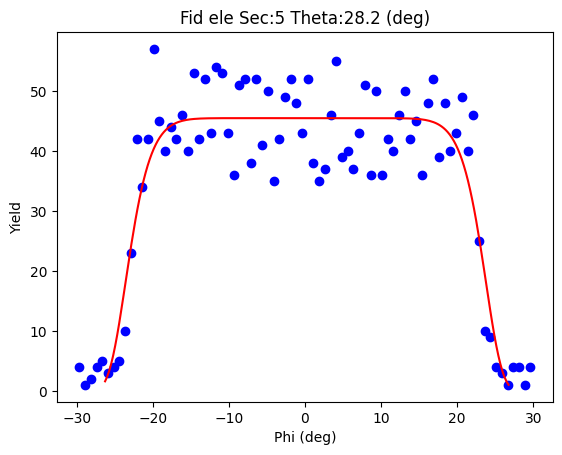

...........Theta: 29.4 ............
Binning| Sec: 4  Ybin: 24
Sum of plot 2908.0
Initial Bounds: [-26.968816951762697, 27.19224321459243]
Sum of initial fit area: 2886.0
max at  69.0
initial max 45.46287502426577
initial guesses: [69.0, 0.1117131314148674, 16.860548142559843, 11.999999999999998]
fit bounds [-26.968816951762697, 27.19224321459243]
(array([4.73372141e+01, 4.41228861e-02, 1.69725026e+01, 1.20000000e+01]), array([[ 1.40408939e+00, -3.29003293e-03, -4.76650794e-02,
        -1.04104964e+00],
       [-3.29003293e-03,  8.90462394e-02, -2.77467543e-03,
         3.48762188e-02],
       [-4.76650794e-02, -2.77467543e-03,  5.38764483e-02,
        -1.42709207e-01],
       [-1.04104964e+00,  3.48762188e-02, -1.42709207e-01,
         6.56398891e+00]]))
[4.73372141e+01 4.41228861e-02 1.69725026e+01 1.20000000e+01]
[4.73372141e+01 4.41228861e-02 1.69725026e+01 1.20000000e+01]
New Bounds for next fit: [-27.216222575129855, 27.30446834737897]


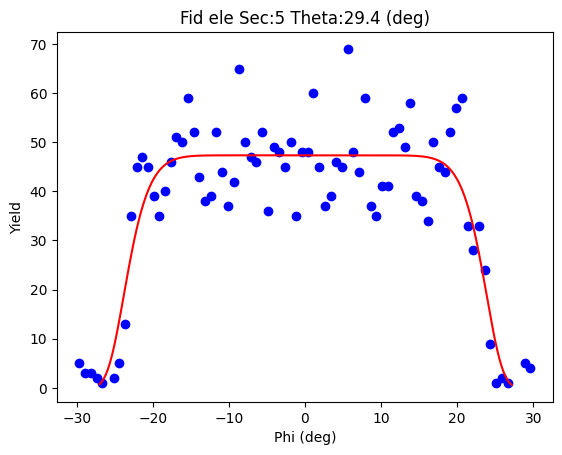

...........Theta: 30.6 ............
Binning| Sec: 4  Ybin: 25
Sum of plot 2898.0
Initial Bounds: [-27.216222575129855, 27.30446834737897]
Sum of initial fit area: 2881.0
max at  66.0
initial max 47.33721409556549
initial guesses: [66.0, 0.04412288612455933, 16.972502592104412, 11.999999999999998]
fit bounds [-27.216222575129855, 27.30446834737897]
(array([46.84764853,  0.26086293, 17.09303343, 12.        ]), array([[ 9.95948530e-01,  3.97390861e-04, -3.67105482e-02,
        -7.21462703e-01],
       [ 3.97390861e-04,  6.38307091e-02,  2.29353353e-04,
        -3.67328979e-03],
       [-3.67105482e-02,  2.29353353e-04,  3.76645277e-02,
        -8.00239453e-02],
       [-7.21462703e-01, -3.67328979e-03, -8.00239453e-02,
         4.47329122e+00]]))
[46.84764853  0.26086293 17.09303343 12.        ]
[46.84764853  0.26086293 17.09303343 12.        ]
New Bounds for next fit: [-27.19307285453962, 27.714798706182588]


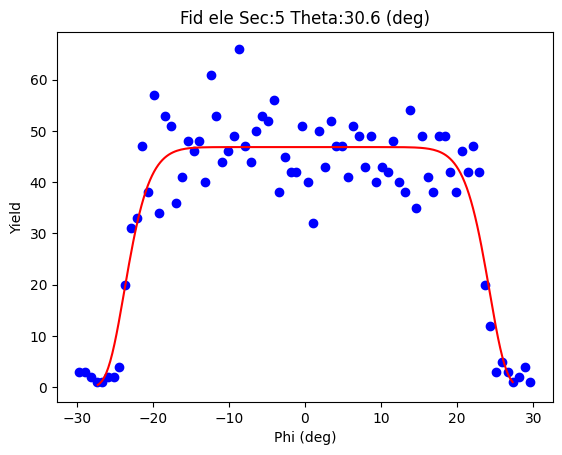

...........Theta: 31.8 ............
Binning| Sec: 4  Ybin: 26
Sum of plot 2717.0
Initial Bounds: [-27.19307285453962, 27.714798706182588]
Sum of initial fit area: 2705.0
max at  61.0
initial max 46.84764853433148
initial guesses: [61.0, 0.26086292582148485, 17.093033426811356, 11.999999999999998]
fit bounds [-27.19307285453962, 27.714798706182588]
(array([44.23603546, -0.06054247, 16.97774924, 12.        ]), array([[ 1.09527136e+00, -1.98415931e-04, -4.31460744e-02,
        -8.30595503e-01],
       [-1.98415931e-04,  7.75026644e-02, -1.05790917e-04,
         1.85907532e-03],
       [-4.31460744e-02, -1.05790917e-04,  4.55002795e-02,
        -9.19547806e-02],
       [-8.30595503e-01,  1.85907532e-03, -9.19547806e-02,
         5.42127051e+00]]))
[44.23603546 -0.06054247 16.97774924 12.        ]
[44.23603546 -0.06054247 16.97774924 12.        ]
New Bounds for next fit: [-27.329314823242406, 27.20822987380668]


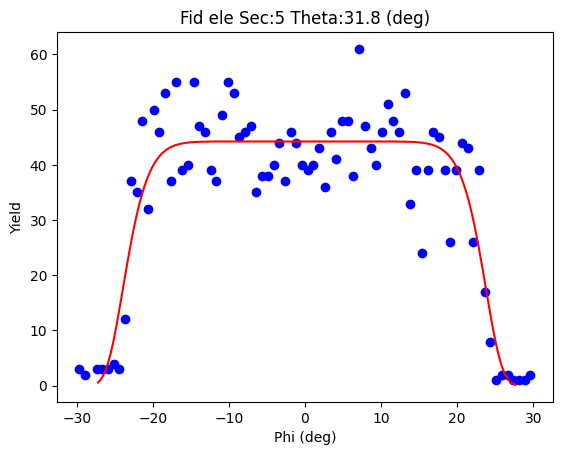

...........Theta: 33.0 ............
Binning| Sec: 4  Ybin: 27
Sum of plot 2718.0
Initial Bounds: [-27.329314823242406, 27.20822987380668]
Sum of initial fit area: 2699.0
max at  55.0
initial max 44.23603545765085
initial guesses: [55.0, -0.06054247471786286, 16.97774923750144, 11.999999999999998]
fit bounds [-27.329314823242406, 27.20822987380668]
(array([43.30665423, -0.07655367, 17.30857324, 12.        ]), array([[ 9.81591020e-01, -2.41525901e-04, -3.87423579e-02,
        -7.81145361e-01],
       [-2.41525901e-04,  7.57424703e-02, -1.68589761e-04,
         2.50090231e-03],
       [-3.87423579e-02, -1.68589761e-04,  4.50359549e-02,
        -1.01841372e-01],
       [-7.81145361e-01,  2.50090231e-03, -1.01841372e-01,
         5.28370402e+00]]))
[43.30665423 -0.07655367 17.30857324 12.        ]
[43.30665423 -0.07655367 17.30857324 12.        ]
New Bounds for next fit: [-27.876678216525903, 27.72357088548395]


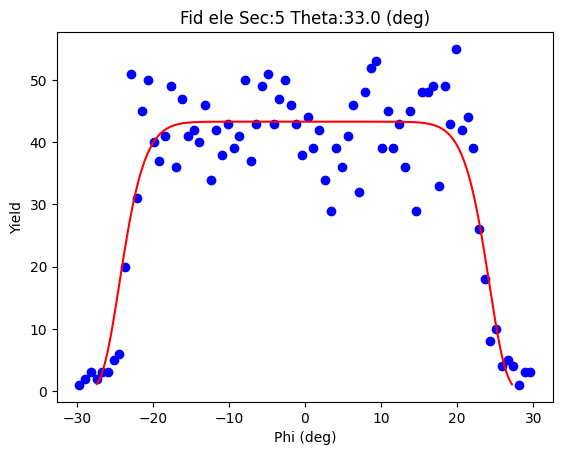

...........Theta: 34.2 ............
Binning| Sec: 4  Ybin: 28
Sum of plot 2723.0
Initial Bounds: [-27.876678216525903, 27.72357088548395]
Sum of initial fit area: 2712.0
max at  55.0
initial max 43.306654231071235
initial guesses: [55.0, -0.07655366552097698, 17.308573241428192, 11.999999999999998]
fit bounds [-27.876678216525903, 27.72357088548395]
(array([43.43460499, -0.31249318, 17.35388368, 12.        ]), array([[ 9.56908732e-01, -2.20282957e-04, -3.91209315e-02,
        -7.40800130e-01],
       [-2.20282957e-04,  7.34058549e-02, -1.27006988e-04,
         2.12875521e-03],
       [-3.91209315e-02, -1.27006988e-04,  4.31362195e-02,
        -8.62474832e-02],
       [-7.40800130e-01,  2.12875521e-03, -8.62474832e-02,
         4.93008214e+00]]))
[43.43460499 -0.31249318 17.35388368 12.        ]
[43.43460499 -0.31249318 17.35388368 12.        ]
New Bounds for next fit: [-28.18539299625733, 27.56040663173599]


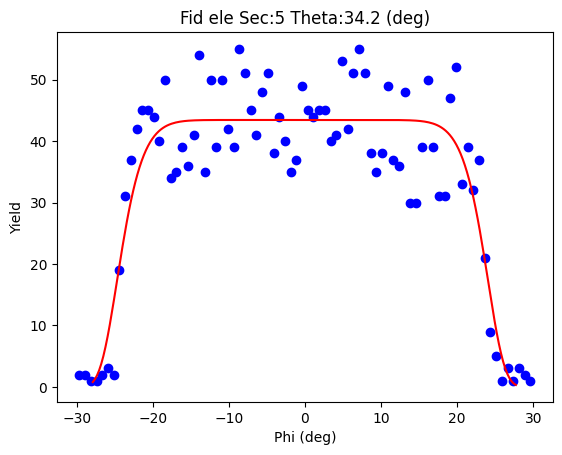

...........Theta: 35.4 ............
Binning| Sec: 4  Ybin: 29
Sum of plot 2569.0
Initial Bounds: [-28.18539299625733, 27.56040663173599]
Sum of initial fit area: 2557.0
max at  51.0
initial max 43.43460499175424
initial guesses: [51.0, -0.3124931822606689, 17.353883684816516, 11.999999999999998]
fit bounds [-28.18539299625733, 27.56040663173599]
(array([39.85657359, -0.08240918, 17.849986  , 12.        ]), array([[ 8.15612847e-01, -2.74990920e-03, -3.27582001e-02,
        -7.42014066e-01],
       [-2.74990920e-03,  8.11099078e-02, -2.71737411e-03,
         3.37394616e-02],
       [-3.27582001e-02, -2.71737411e-03,  4.99216624e-02,
        -1.41465144e-01],
       [-7.42014066e-01,  3.37394616e-02, -1.41465144e-01,
         5.64687936e+00]]))
[39.85657359 -0.08240918 17.849986   12.        ]
[39.85657359 -0.08240918 17.849986   12.        ]
New Bounds for next fit: [-28.75212257063808, 28.587304218908166]


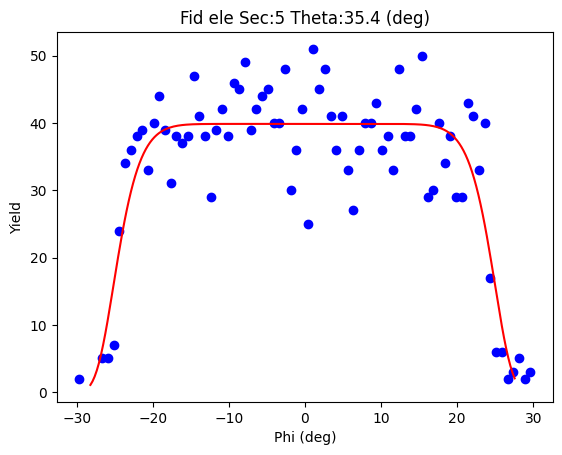

...........Theta: 36.6 ............
Binning| Sec: 4  Ybin: 30
Sum of plot 2473.0
Initial Bounds: [-28.75212257063808, 28.587304218908166]
Sum of initial fit area: 2468.0
max at  54.0
initial max 39.85657359214545
initial guesses: [54.0, -0.08240917586495698, 17.849986002535648, 11.999999999999998]
fit bounds [-28.75212257063808, 28.587304218908166]
(array([38.54680408, -0.07099049, 17.72736887, 12.        ]), array([[ 7.84008638e-01, -2.72844563e-05, -3.70995680e-02,
        -6.81060758e-01],
       [-2.72844563e-05,  7.96281831e-02, -1.69737447e-05,
         2.90839617e-04],
       [-3.70995680e-02, -1.69737447e-05,  4.67110931e-02,
        -8.95694973e-02],
       [-6.81060758e-01,  2.90839617e-04, -8.95694973e-02,
         5.09641333e+00]]))
[38.54680408 -0.07099049 17.72736887 12.        ]
[38.54680408 -0.07099049 17.72736887 12.        ]
New Bounds for next fit: [-28.5437626637761, 28.401781688422396]


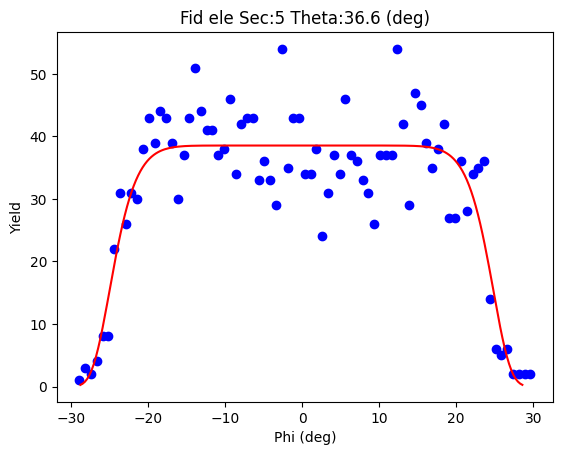

...........Theta: 37.8 ............
Binning| Sec: 4  Ybin: 31
Sum of plot 2297.0
Initial Bounds: [-28.5437626637761, 28.401781688422396]
Sum of initial fit area: 2295.0
max at  51.0
initial max 38.546804076683244
initial guesses: [51.0, -0.07099048767685022, 17.727368871759165, 11.999999999999975]
fit bounds [-28.5437626637761, 28.401781688422396]
(array([35.6485198 ,  0.34802664, 17.88813044, 12.        ]), array([[ 7.92151512e-01,  3.45612078e-03, -3.71334797e-02,
        -7.82606381e-01],
       [ 3.45612078e-03,  9.97497780e-02,  4.54837759e-03,
        -5.07924164e-02],
       [-3.71334797e-02,  4.54837759e-03,  6.07416894e-02,
        -1.59548319e-01],
       [-7.82606381e-01, -5.07924164e-02, -1.59548319e-01,
         6.59934251e+00]]))
[35.6485198   0.34802664 17.88813044 12.        ]
[35.6485198   0.34802664 17.88813044 12.        ]
New Bounds for next fit: [-28.382952357991805, 29.07900563194962]


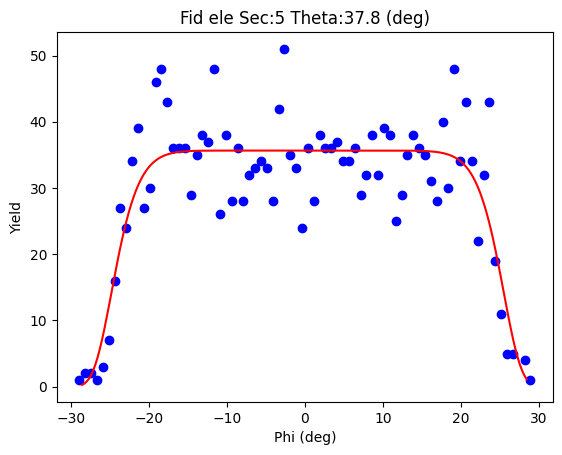

...........Theta: 39.0 ............
Binning| Sec: 4  Ybin: 32
Sum of plot 2114.0
Initial Bounds: [-28.382952357991805, 29.07900563194962]
Sum of initial fit area: 2111.0
max at  46.0
initial max 35.6485197994784
initial guesses: [46.0, 0.3480266369789074, 17.88813044056701, 11.999999999999998]
fit bounds [-28.382952357991805, 29.07900563194962]
(array([32.65006124,  0.4819781 , 18.04847756, 12.        ]), array([[ 8.75018129e-01,  3.39269250e-03, -4.62963215e-02,
        -9.27053382e-01],
       [ 3.39269250e-03,  1.42770447e-01,  1.33289242e-02,
        -8.93562333e-02],
       [-4.62963215e-02,  1.33289242e-02,  8.73997830e-02,
        -2.26040481e-01],
       [-9.27053382e-01, -8.93562333e-02, -2.26040481e-01,
         8.57358933e+00]]))
[32.65006124  0.4819781  18.04847756 12.        ]
[32.65006124  0.4819781  18.04847756 12.        ]
New Bounds for next fit: [-28.506542041973685, 29.47049824113154]


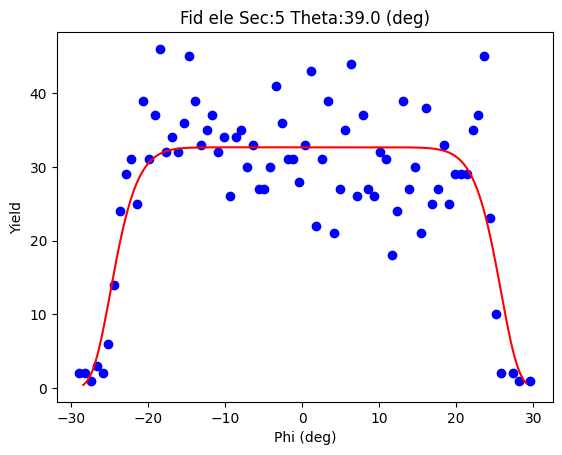

...........Theta: 40.2 ............
Binning| Sec: 4  Ybin: 33
Sum of plot 1906.0
Initial Bounds: [-28.506542041973685, 29.47049824113154]
Sum of initial fit area: 1900.0
max at  44.0
initial max 32.65006123594931
initial guesses: [44.0, 0.481978099578928, 18.048477556642542, 11.999999999999998]
fit bounds [-28.506542041973685, 29.47049824113154]
(array([29.41587818,  0.36070758, 18.01812064, 12.        ]), array([[ 5.27705060e-01,  3.71832774e-04, -2.94075122e-02,
        -6.34856870e-01],
       [ 3.71832774e-04,  1.05142306e-01,  6.26223338e-03,
        -3.10865720e-02],
       [-2.94075122e-02,  6.26223338e-03,  6.60271233e-02,
        -1.90197498e-01],
       [-6.34856870e-01, -3.10865720e-02, -1.90197498e-01,
         6.62871393e+00]]))
[29.41587818  0.36070758 18.01812064 12.        ]
[29.41587818  0.36070758 18.01812064 12.        ]
New Bounds for next fit: [-28.579054875250723, 29.30047002971411]


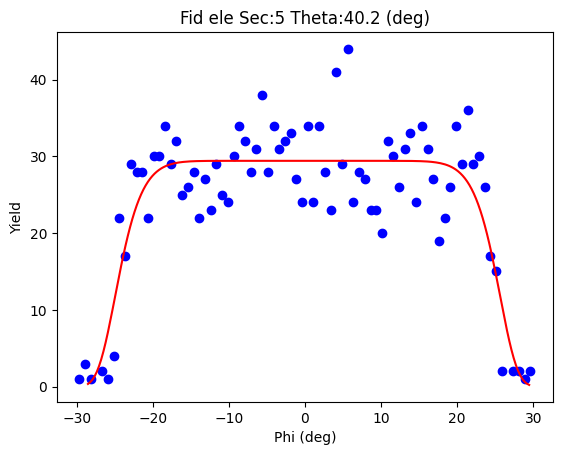

...........Theta: 41.4 ............
Binning| Sec: 4  Ybin: 34
Sum of plot 1932.0
Initial Bounds: [-28.579054875250723, 29.30047002971411]
Sum of initial fit area: 1932.0
max at  44.0
initial max 29.415878177649617
initial guesses: [44.0, 0.3607075772316921, 18.018120641125638, 11.999999999999998]
fit bounds [-28.579054875250723, 29.30047002971411]
(array([29.75555874,  0.29223226, 18.00400287, 12.        ]), array([[ 7.70272277e-01, -4.99226706e-05, -4.78987453e-02,
        -8.67627183e-01],
       [-4.99226706e-05,  1.35434598e-01, -4.16556051e-05,
         6.93780481e-04],
       [-4.78987453e-02, -4.16556051e-05,  7.94764166e-02,
        -1.50705463e-01],
       [-8.67627183e-01,  6.93780481e-04, -1.50705463e-01,
         8.41439118e+00]]))
[29.75555874  0.29223226 18.00400287 12.        ]
[29.75555874  0.29223226 18.00400287 12.        ]
New Bounds for next fit: [-28.624854964761727, 29.209319492628058]


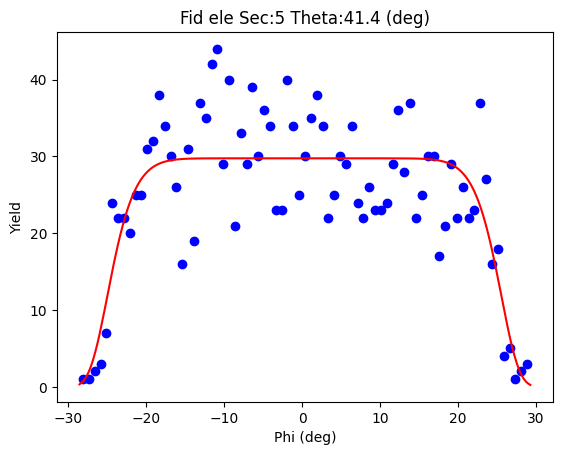

...........Theta: 42.6 ............
Binning| Sec: 4  Ybin: 35
Sum of plot 1815.0
Initial Bounds: [-28.624854964761727, 29.209319492628058]
Sum of initial fit area: 1813.0
max at  40.0
initial max 29.755558739395067
initial guesses: [40.0, 0.292232263933166, 18.0040028708627, 11.999999999999998]
fit bounds [-28.624854964761727, 29.209319492628058]
(array([28.13715444,  0.65628586, 17.90576841, 12.        ]), array([[ 6.49444024e-01, -3.93496667e-03, -3.78498346e-02,
        -8.24764496e-01],
       [-3.93496667e-03,  1.30889727e-01, -5.62929393e-03,
         6.88770661e-02],
       [-3.78498346e-02, -5.62929393e-03,  8.00117569e-02,
        -2.17613128e-01],
       [-8.24764496e-01,  6.88770661e-02, -2.17613128e-01,
         8.84897548e+00]]))
[28.13715444  0.65628586 17.90576841 12.        ]
[28.13715444  0.65628586 17.90576841 12.        ]
New Bounds for next fit: [-28.103022327248265, 29.415594040238187]


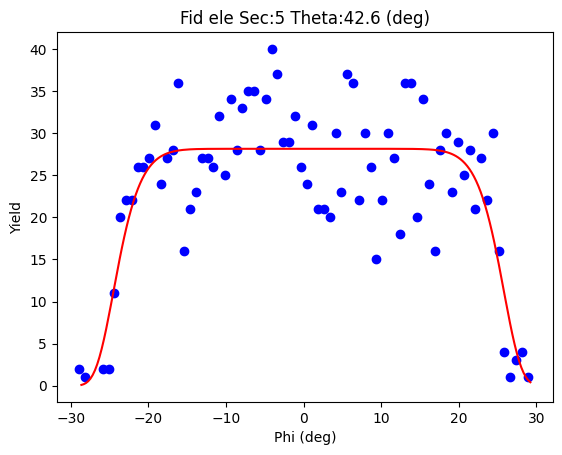

...........Theta: 43.8 ............
Binning| Sec: 4  Ybin: 36
Sum of plot 1904.0
Initial Bounds: [-28.103022327248265, 29.415594040238187]
Sum of initial fit area: 1901.0
max at  42.0
initial max 28.137154444500673
initial guesses: [42.0, 0.6562858564949612, 17.90576841329766, 11.999999999999998]
fit bounds [-28.103022327248265, 29.415594040238187]
(array([29.81485131,  0.65646256, 17.70669548, 12.        ]), array([[ 7.01492736e-01, -2.06297927e-03, -4.05209796e-02,
        -8.14713674e-01],
       [-2.06297927e-03,  1.20764380e-01, -2.54444783e-03,
         3.30666580e-02],
       [-4.05209796e-02, -2.54444783e-03,  7.23028942e-02,
        -1.69434461e-01],
       [-8.14713674e-01,  3.30666580e-02, -1.69434461e-01,
         8.06740584e+00]]))
[29.81485131  0.65646256 17.70669548 12.        ]
[29.81485131  0.65646256 17.70669548 12.        ]
New Bounds for next fit: [-27.783105104399827, 29.096030222094047]


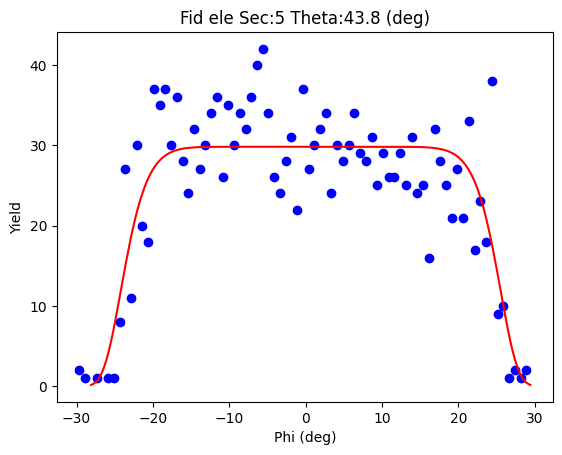

...........Theta: 45.0 ............
Binning| Sec: 4  Ybin: 37
Sum of plot 1873.0
Initial Bounds: [-27.783105104399827, 29.096030222094047]
Sum of initial fit area: 1872.0
max at  42.0
initial max 29.81485130724831
initial guesses: [42.0, 0.6564625588471116, 17.70669548442966, 11.999999999999714]
fit bounds [-27.783105104399827, 29.096030222094047]
(array([28.9011098 ,  0.13852707, 18.16757038, 12.        ]), array([[ 5.27828439e-01,  4.94046610e-04, -2.86716231e-02,
        -6.60005981e-01],
       [ 4.94046610e-04,  1.21474021e-01, -2.56732302e-03,
         3.16266853e-03],
       [-2.86716231e-02, -2.56732302e-03,  7.99792978e-02,
        -2.56882960e-01],
       [-6.60005981e-01,  3.16266853e-03, -2.56882960e-01,
         7.25245811e+00]]))
[28.9011098   0.13852707 18.16757038 12.        ]
[28.9011098   0.13852707 18.16757038 12.        ]
New Bounds for next fit: [-29.04127373749282, 29.318327880947297]


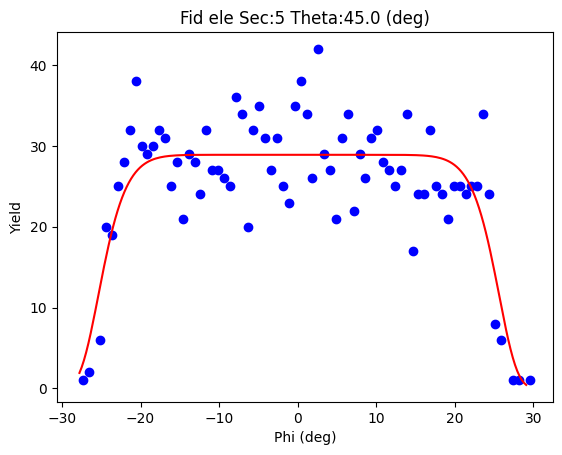

...........Theta: 46.2 ............
Binning| Sec: 4  Ybin: 38
Sum of plot 1794.0
Initial Bounds: [-29.04127373749282, 29.318327880947297]
Sum of initial fit area: 1793.0
max at  42.0
initial max 28.901109798242157
initial guesses: [42.0, 0.13852707172724055, 18.16757038444326, 11.999999999999998]
fit bounds [-29.04127373749282, 29.318327880947297]
(array([27.50816361,  0.21814896, 18.27766594, 12.        ]), array([[ 6.85048525e-01, -5.65870643e-03, -2.90450272e-02,
        -1.00811308e+00],
       [-5.65870643e-03,  1.78531631e-01, -2.61449091e-02,
         1.71910132e-01],
       [-2.90450272e-02, -2.61449091e-02,  1.26203121e-01,
        -5.28469062e-01],
       [-1.00811308e+00,  1.71910132e-01, -5.28469062e-01,
         1.23206238e+01]]))
[27.50816361  0.21814896 18.27766594 12.        ]
[27.50816361  0.21814896 18.27766594 12.        ]
New Bounds for next fit: [-29.138481574420624, 29.57477949837851]


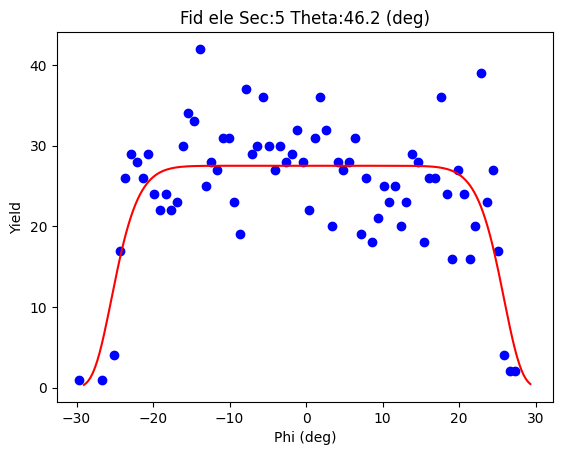

...........Theta: 47.4 ............
Binning| Sec: 4  Ybin: 39
Sum of plot 1740.0
Initial Bounds: [-29.138481574420624, 29.57477949837851]
Sum of initial fit area: 1739.0
max at  40.0
initial max 27.50816361119041
initial guesses: [40.0, 0.218148961978943, 18.277665944574036, 11.999999999999998]
fit bounds [-29.138481574420624, 29.57477949837851]
(array([26.90112032, -0.2513252 , 18.05546069, 12.        ]), array([[ 0.56251798, -0.01217346, -0.02587935, -0.81831107],
       [-0.01217346,  0.1506951 , -0.02985595,  0.27301864],
       [-0.02587935, -0.02985595,  0.10042998, -0.4101168 ],
       [-0.81831107,  0.27301864, -0.4101168 , 10.10819949]]))
[26.90112032 -0.2513252  18.05546069 12.        ]
[26.90112032 -0.2513252  18.05546069 12.        ]
New Bounds for next fit: [-29.25106129583381, 28.7484108874016]


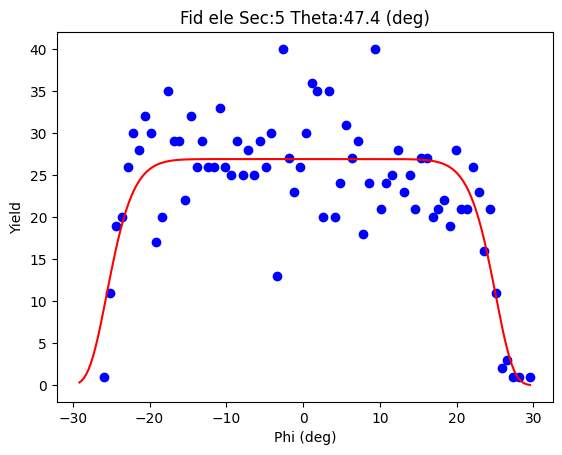

...........Theta: 48.6 ............
Binning| Sec: 4  Ybin: 40
Sum of plot 1671.0
Initial Bounds: [-29.25106129583381, 28.7484108874016]
Sum of initial fit area: 1671.0
max at  36.0
initial max 26.901120315448246
initial guesses: [36.0, -0.2513252042161036, 18.05546069417553, 11.999999999999986]
fit bounds [-29.25106129583381, 28.7484108874016]
(array([25.57822042,  0.52512286, 18.21925986, 12.        ]), array([[ 4.13792053e-01,  1.31014271e-03, -2.20467572e-02,
        -6.32587974e-01],
       [ 1.31014271e-03,  1.07409493e-01,  2.52123159e-03,
        -2.71837842e-02],
       [-2.20467572e-02,  2.52123159e-03,  7.07823065e-02,
        -2.59693406e-01],
       [-6.32587974e-01, -2.71837842e-02, -2.59693406e-01,
         7.88435411e+00]]))
[25.57822042  0.52512286 18.21925986 12.        ]
[25.57822042  0.52512286 18.21925986 12.        ]
New Bounds for next fit: [-28.73769888204707, 29.78794460007]


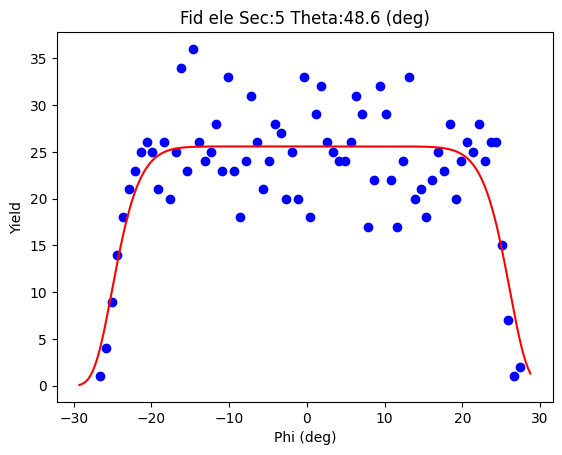

...........Theta: 49.8 ............
Binning| Sec: 4  Ybin: 41
Sum of plot 1472.0
Initial Bounds: [-28.73769888204707, 29.78794460007]
Sum of initial fit area: 1472.0
max at  33.0
initial max 25.578220424135893
initial guesses: [33.0, 0.5251228590114646, 18.21925986074979, 11.999999999999998]
fit bounds [-28.73769888204707, 29.78794460007]
(array([22.50805664,  0.07228403, 18.17544639, 12.        ]), array([[ 3.99203536e-01, -4.54630874e-03, -2.81555658e-02,
        -6.46756674e-01],
       [-4.54630874e-03,  1.32338343e-01, -8.78721463e-03,
         1.01865029e-01],
       [-2.81555658e-02, -8.78721463e-03,  8.21566612e-02,
        -2.43941669e-01],
       [-6.46756674e-01,  1.01865029e-01, -2.43941669e-01,
         8.82335690e+00]]))
[22.50805664  0.07228403 18.17544639 12.        ]
[22.50805664  0.07228403 18.17544639 12.        ]
New Bounds for next fit: [-29.120166801530555, 29.264734863428647]


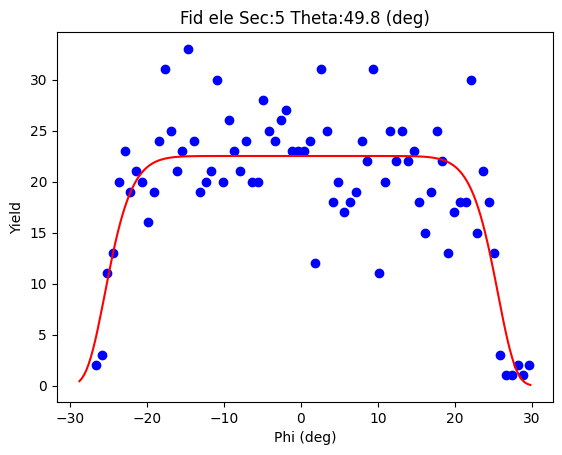

...........Theta: 51.0 ............
Binning| Sec: 4  Ybin: 42
Sum of plot 1404.0
Initial Bounds: [-29.120166801530555, 29.264734863428647]
Sum of initial fit area: 1404.0
max at  36.0
initial max 22.50805664226916
initial guesses: [36.0, 0.07228403094904579, 18.175446387072874, 11.999999999995103]
fit bounds [-29.120166801530555, 29.264734863428647]
(array([21.34117648, -0.02527258, 18.50400583, 12.        ]), array([[ 4.35458659e-01,  8.52406725e-04, -2.76364722e-02,
        -7.91436279e-01],
       [ 8.52406725e-04,  2.05053569e-01, -2.26538959e-02,
         6.73473780e-02],
       [-2.76364722e-02, -2.26538959e-02,  1.43864070e-01,
        -5.37201495e-01],
       [-7.91436279e-01,  6.73473780e-02, -5.37201495e-01,
         1.23754036e+01]]))
[21.34117648 -0.02527258 18.50400583 12.        ]
[21.34117648 -0.02527258 18.50400583 12.        ]
New Bounds for next fit: [-29.74543839007188, 29.694893234236684]


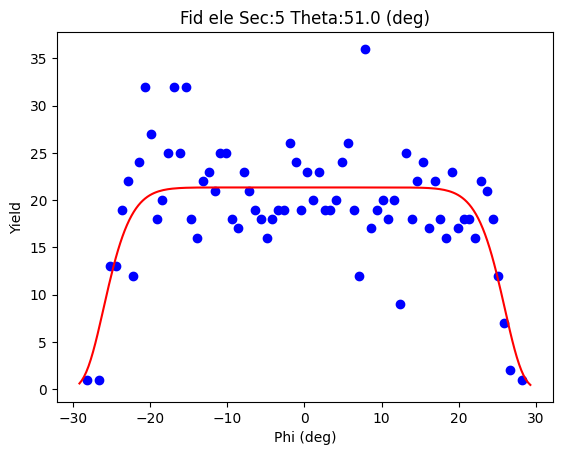

...........Theta: 52.2 ............
Binning| Sec: 4  Ybin: 43
Sum of plot 1183.0
Initial Bounds: [-29.74543839007188, 29.694893234236684]
Sum of initial fit area: 1183.0
max at  26.0
initial max 21.34117648359307
initial guesses: [26.0, -0.02527257791759835, 18.504005827861207, 11.999999999999998]
fit bounds [-29.74543839007188, 29.694893234236684]
(array([17.93559884,  0.68983385, 18.46997024, 12.        ]), array([[ 3.50628545e-01,  4.69457464e-03, -2.17352265e-02,
        -7.92629303e-01],
       [ 4.69457464e-03,  2.22605504e-01,  3.33398717e-02,
        -2.22447947e-01],
       [-2.17352265e-02,  3.33398717e-02,  1.62014949e-01,
        -7.00011925e-01],
       [-7.92629303e-01, -2.22447947e-01, -7.00011925e-01,
         1.51215967e+01]]))
[17.93559884  0.68983385 18.46997024 12.        ]
[17.93559884  0.68983385 18.46997024 12.        ]
New Bounds for next fit: [-28.975665783008704, 30.355333478654625]


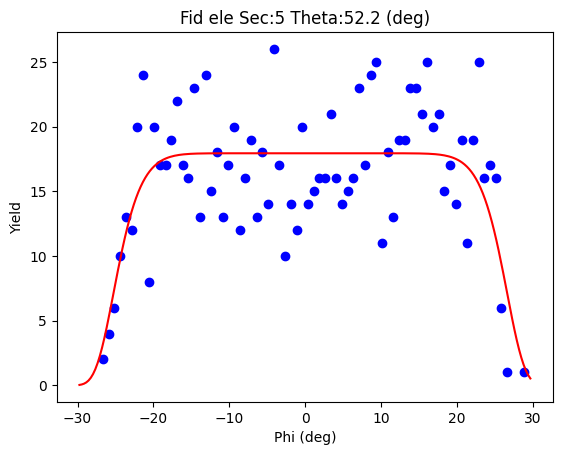

...........Theta: 53.4 ............
Binning| Sec: 4  Ybin: 44
Sum of plot 1119.0
Initial Bounds: [-28.975665783008704, 30.355333478654625]
Sum of initial fit area: 1119.0
max at  27.0
initial max 17.93559884447453
initial guesses: [27.0, 0.6898338478229615, 18.469970239225056, 11.999999999999998]
fit bounds [-28.975665783008704, 30.355333478654625]
(array([17.27520869,  0.2997333 , 17.97491463, 12.        ]), array([[ 3.32969899e-01, -9.97824974e-05, -3.45914210e-02,
        -6.59292043e-01],
       [-9.97824974e-05,  1.73871992e-01, -2.05430357e-04,
         2.71999381e-03],
       [-3.45914210e-02, -2.05430357e-04,  1.03011058e-01,
        -2.16637789e-01],
       [-6.59292043e-01,  2.71999381e-03, -2.16637789e-01,
         1.11352160e+01]]))
[17.27520869  0.2997333  17.97491463 12.        ]
[17.27520869  0.2997333  17.97491463 12.        ]
New Bounds for next fit: [-28.570633925140754, 29.170100516045665]


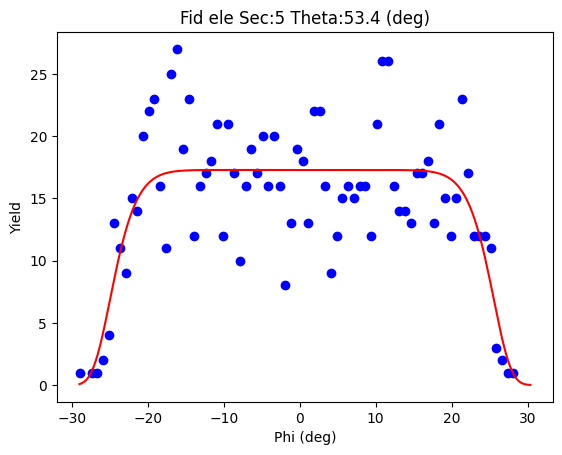

...........Theta: 54.6 ............
Binning| Sec: 4  Ybin: 45
Sum of plot 1040.0
Initial Bounds: [-28.570633925140754, 29.170100516045665]
Sum of initial fit area: 1040.0
max at  26.0
initial max 17.275208690119264
initial guesses: [26.0, 0.2997332954524552, 17.97491463132677, 11.999999999999943]
fit bounds [-28.570633925140754, 29.170100516045665]
(array([15.82851001,  0.10571815, 18.30764345, 12.        ]), array([[ 3.49994179e-01,  9.88777658e-04, -3.37473869e-02,
        -8.30565180e-01],
       [ 9.88777658e-04,  2.34080715e-01,  2.75817191e-03,
        -3.16542772e-02],
       [-3.37473869e-02,  2.75817191e-03,  1.48190670e-01,
        -4.66820073e-01],
       [-8.30565180e-01, -3.16542772e-02, -4.66820073e-01,
         1.62518532e+01]]))
[15.82851001  0.10571815 18.30764345 12.        ]
[15.82851001  0.10571815 18.30764345 12.        ]
New Bounds for next fit: [-29.29906069192005, 29.510496986645304]


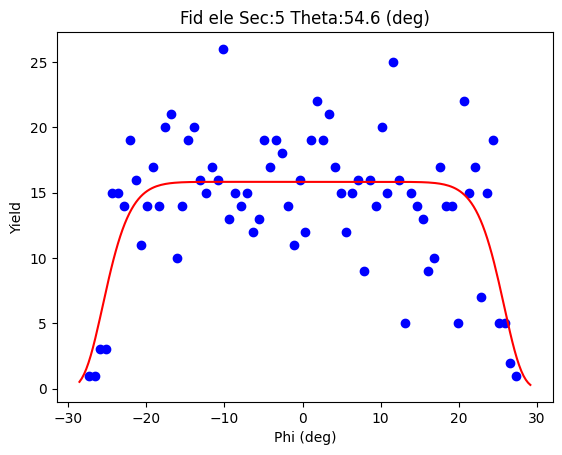

...........Theta: 55.8 ............
Binning| Sec: 4  Ybin: 46
Sum of plot 956.0
Initial Bounds: [-29.29906069192005, 29.510496986645304]
Sum of initial fit area: 956.0
max at  24.0
initial max 15.828510014437926
initial guesses: [24.0, 0.10571814736262754, 18.307643451522747, 11.999999999999998]
fit bounds [-29.29906069192005, 29.510496986645304]
(array([14.84599204,  0.4576612 , 18.13191199, 12.        ]), array([[ 3.03782978e-01,  2.46905689e-03,  1.49368528e-02,
        -1.13495331e+00],
       [ 2.46905689e-03,  3.09790568e-01,  1.70524723e-02,
        -1.24382921e-01],
       [ 1.49368528e-02,  1.70524723e-02,  3.68541251e-01,
        -2.38678790e+00],
       [-1.13495331e+00, -1.24382921e-01, -2.38678790e+00,
         3.22244135e+01]]))
[14.84599204  0.4576612  18.13191199 12.        ]
[14.84599204  0.4576612  18.13191199 12.        ]
New Bounds for next fit: [-28.66486696044301, 29.580189351474825]


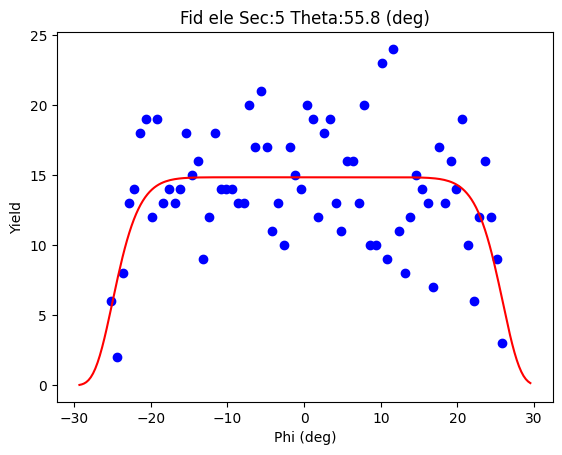

...........Theta: 57.0 ............
Binning| Sec: 4  Ybin: 47
Sum of plot 899.0
Initial Bounds: [-28.66486696044301, 29.580189351474825]
Sum of initial fit area: 898.0
max at  23.0
initial max 14.845992038136842
initial guesses: [23.0, 0.4576611955159088, 18.131911986140437, 11.999999999923974]
fit bounds [-28.66486696044301, 29.580189351474825]
(array([13.72390319,  0.48595831, 18.35991499, 12.        ]), array([[ 1.97936783e-01,  6.11904088e-04, -1.23466685e-02,
        -6.15472116e-01],
       [ 6.11904088e-04,  2.20924138e-01,  1.63991576e-02,
        -7.63273194e-02],
       [-1.23466685e-02,  1.63991576e-02,  1.76160762e-01,
        -8.41108432e-01],
       [-6.15472116e-01, -7.63273194e-02, -8.41108432e-01,
         1.60053686e+01]]))
[13.72390319  0.48595831 18.35991499 12.        ]
[13.72390319  0.48595831 18.35991499 12.        ]
New Bounds for next fit: [-29.002776343121855, 29.974692967552603]


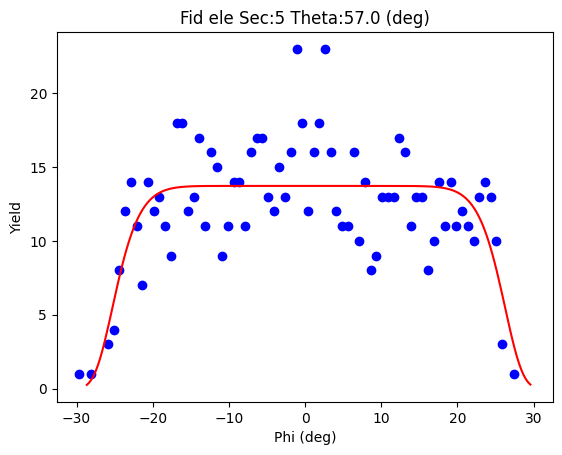

...........Theta: 58.2 ............
Binning| Sec: 4  Ybin: 48
Sum of plot 811.0
Initial Bounds: [-29.002776343121855, 29.974692967552603]
Sum of initial fit area: 811.0
max at  19.0
initial max 13.72390318871239
initial guesses: [19.0, 0.4859583122153754, 18.359914993995798, 11.999999999999968]
fit bounds [-29.002776343121855, 29.974692967552603]
(array([12.29825538,  0.0992032 , 18.46384522, 12.        ]), array([[ 1.97494030e-01, -9.39916589e-03, -9.93403588e-03,
        -7.24031573e-01],
       [-9.39916589e-03,  2.81293036e-01, -6.21634187e-02,
         5.03939321e-01],
       [-9.93403588e-03, -6.21634187e-02,  2.24519326e-01,
        -1.16784792e+00],
       [-7.24031573e-01,  5.03939321e-01, -1.16784792e+00,
         2.14128307e+01]]))
[12.29825538  0.0992032  18.46384522 12.        ]
[12.29825538  0.0992032  18.46384522 12.        ]
New Bounds for next fit: [-29.55645874738591, 29.754865140720227]


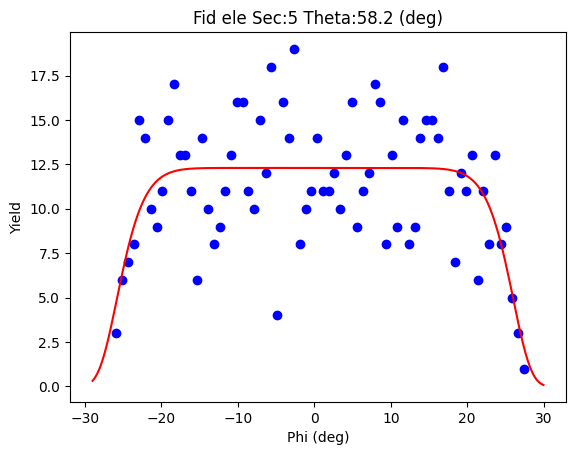

...........Theta: 59.4 ............
Binning| Sec: 4  Ybin: 49
Sum of plot 809.0
Initial Bounds: [-29.55645874738591, 29.754865140720227]
Sum of initial fit area: 808.0
max at  21.0
initial max 12.298255384182653
initial guesses: [21.0, 0.09920319666715702, 18.463845219105437, 11.99999999998726]
fit bounds [-29.55645874738591, 29.754865140720227]
(array([12.63194834,  0.67843057, 17.96251261,  9.98928934]), array([[ 2.87027245e-01, -6.92413323e-04, -3.24014487e-02,
        -7.58112314e-01],
       [-6.92413323e-04,  3.43363015e-01, -3.60773264e-03,
         2.35395240e-02],
       [-3.24014487e-02, -3.60773264e-03,  2.42208305e-01,
        -6.94887887e-01],
       [-7.58112314e-01,  2.35395240e-02, -6.94887887e-01,
         1.37588976e+01]]))
[12.63194834  0.67843057 17.96251261  9.98928934]
[12.63194834  0.67843057 17.96251261  9.98928934]
New Bounds for next fit: [-28.920619027239667, 30.277480167231722]


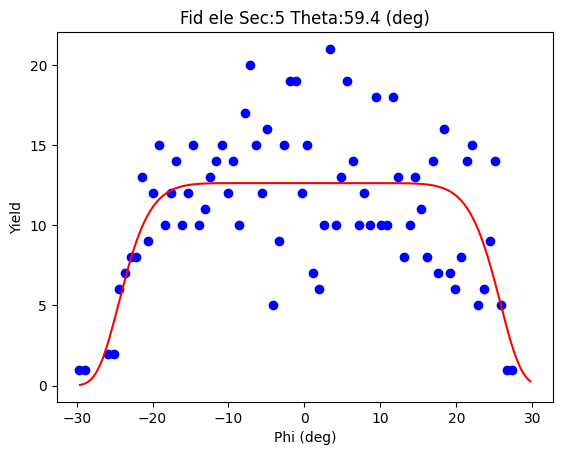

==========Sec  6 ===============
...........Theta: 10.2 ............
Binning| Sec: 5  Ybin: 8
Sum of plot 1302.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 1102.0
max at  62.0
initial max 12.631948339222365
initial guesses: [62.0, 0.6784305699960294, 17.96251260897933, 9.989289340941152]
fit bounds [-10.0, 10.0]
(array([54.68752805,  1.76192931,  6.97004735,  2.57459486]), array([[ 2.86859378,  0.03092916, -0.05602379, -0.44168172],
       [ 0.03092916,  0.06331531,  0.03752144, -0.03020236],
       [-0.05602379,  0.03752144,  0.09325577, -0.05658316],
       [-0.44168172, -0.03020236, -0.05658316,  0.16769294]]))
[54.68752805  1.76192931  6.97004735  2.57459486]
[54.68752805  1.76192931  6.97004735  2.57459486]
New Bounds for next fit: [-16.07673765301668, 19.600596272499352]


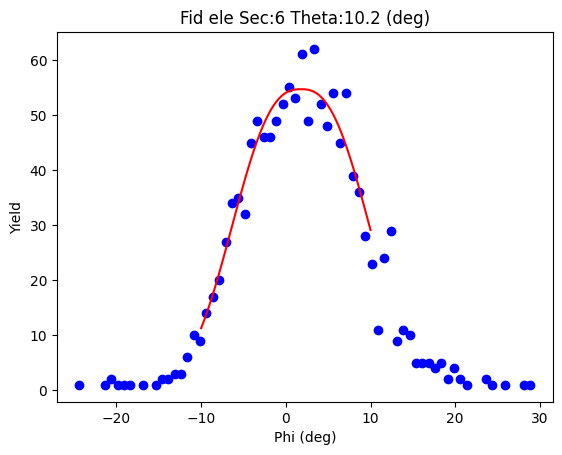

...........Theta: 11.4 ............
Binning| Sec: 5  Ybin: 9
Sum of plot 1585.0
Initial Bounds: [-16.07673765301668, 19.600596272499352]
Sum of initial fit area: 1546.0
max at  65.0
initial max 54.687528052847554
initial guesses: [65.0, 1.7619293097413367, 6.970047349147483, 2.5745948577756432]
fit bounds [-16.07673765301668, 19.600596272499352]
(array([56.49233286,  0.95446767,  8.05815088,  3.14144577]), array([[ 2.68693488e+00, -1.23245682e-03, -1.60741098e-01,
        -3.27220397e-01],
       [-1.23245682e-03,  4.40821525e-02, -1.08999753e-04,
         6.32775758e-04],
       [-1.60741098e-01, -1.08999753e-04,  3.65301357e-02,
         1.36104531e-02],
       [-3.27220397e-01,  6.32775758e-04,  1.36104531e-02,
         1.15762531e-01]]))
[56.49233286  0.95446767  8.05815088  3.14144577]
[56.49233286  0.95446767  8.05815088  3.14144577]
New Bounds for next fit: [-17.575639110858024, 19.484574446159623]


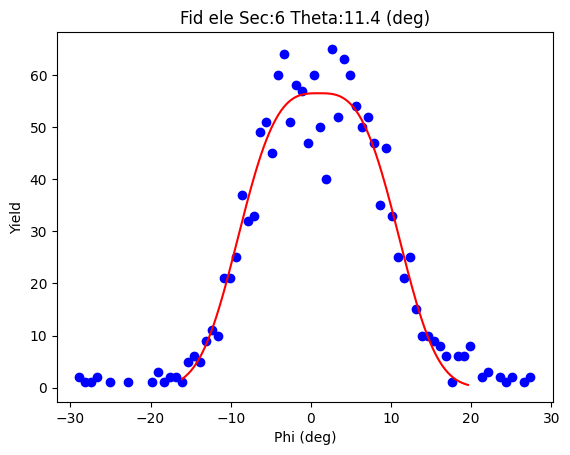

...........Theta: 12.6 ............
Binning| Sec: 5  Ybin: 10
Sum of plot 1876.0
Initial Bounds: [-17.575639110858024, 19.484574446159623]
Sum of initial fit area: 1824.0
max at  78.0
initial max 56.492332856307364
initial guesses: [78.0, 0.9544676676507998, 8.058150876228526, 3.1414457698109]
fit bounds [-17.575639110858024, 19.484574446159623]
(array([56.1495751 ,  0.31208027,  9.4984321 ,  4.04294422]), array([[ 3.80730122e+00, -3.27053271e-03, -2.04254648e-01,
        -6.52988477e-01],
       [-3.27053271e-03,  8.64131516e-02, -5.49509499e-04,
         2.89265870e-03],
       [-2.04254648e-01, -5.49509499e-04,  6.27364071e-02,
         1.21046891e-02],
       [-6.52988477e-01,  2.89265870e-03,  1.21046891e-02,
         3.87665221e-01]]))
[56.1495751   0.31208027  9.4984321   4.04294422]
[56.1495751   0.31208027  9.4984321   4.04294422]
New Bounds for next fit: [-19.286160538667733, 19.910321081688497]


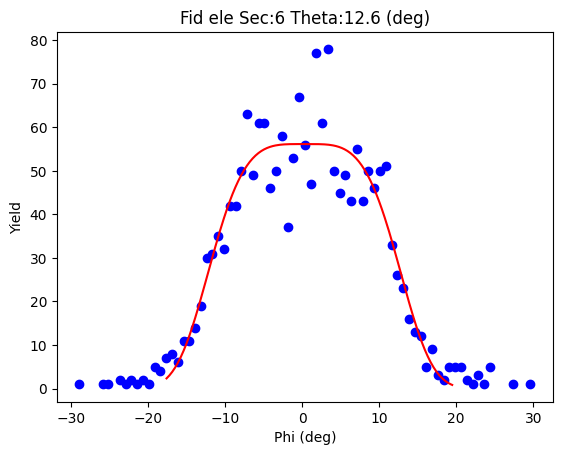

...........Theta: 13.8 ............
Binning| Sec: 5  Ybin: 11
Sum of plot 2063.0
Initial Bounds: [-19.286160538667733, 19.910321081688497]
Sum of initial fit area: 2022.0
max at  67.0
initial max 56.149575104436245
initial guesses: [67.0, 0.31208027151038126, 9.4984320993879, 4.042944221567534]
fit bounds [-19.286160538667733, 19.910321081688497]
(array([50.70704177,  0.31803602, 11.28494602,  6.41022328]), array([[ 1.47819631e+00, -5.93101892e-05, -6.52764771e-02,
        -4.81186533e-01],
       [-5.93101892e-05,  5.03292697e-02, -1.52338200e-05,
         1.40058978e-04],
       [-6.52764771e-02, -1.52338200e-05,  3.18417591e-02,
        -9.71591208e-03],
       [-4.81186533e-01,  1.40058978e-04, -9.71591208e-03,
         7.83861306e-01]]))
[50.70704177  0.31803602 11.28494602  6.41022328]
[50.70704177  0.31803602 11.28494602  6.41022328]
New Bounds for next fit: [-19.934590095105758, 20.57066213405952]


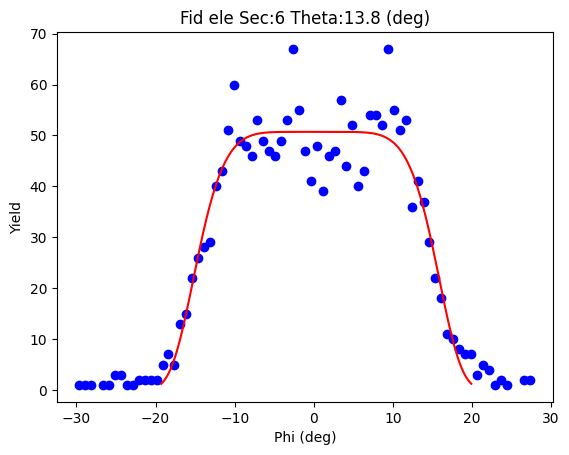

...........Theta: 15.0 ............
Binning| Sec: 5  Ybin: 12
Sum of plot 2437.0
Initial Bounds: [-19.934590095105758, 20.57066213405952]
Sum of initial fit area: 2363.0
max at  73.0
initial max 50.70704176826111
initial guesses: [73.0, 0.3180360194768833, 11.284946015427838, 6.410223277585336]
fit bounds [-19.934590095105758, 20.57066213405952]
(array([56.99845579,  0.05978364, 11.90160004,  5.57631304]), array([[ 1.94146954e+00,  3.54726920e-04, -8.70925726e-02,
        -5.04012046e-01],
       [ 3.54726920e-04,  6.19423115e-02,  1.13523826e-04,
        -6.26527796e-04],
       [-8.70925726e-02,  1.13523826e-04,  4.11959091e-02,
        -1.18665480e-02],
       [-5.04012046e-01, -6.26527796e-04, -1.18665480e-02,
         5.72028973e-01]]))
[56.99845579  0.05978364 11.90160004  5.57631304]
[56.99845579  0.05978364 11.90160004  5.57631304]
New Bounds for next fit: [-22.074229952650697, 22.193797223452798]


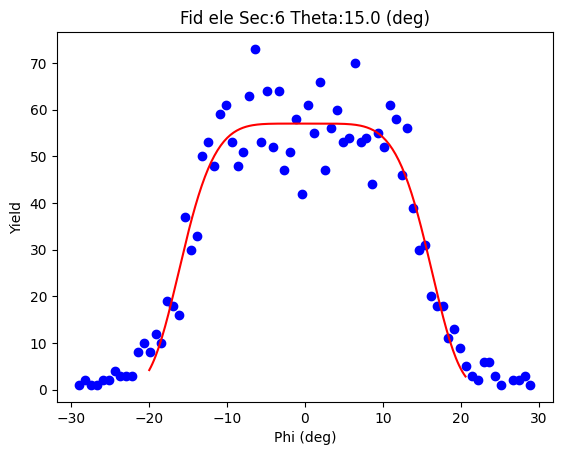

...........Theta: 16.2 ............
Binning| Sec: 5  Ybin: 13
Sum of plot 2691.0
Initial Bounds: [-22.074229952650697, 22.193797223452798]
Sum of initial fit area: 2621.0
max at  73.0
initial max 56.998455790245686
initial guesses: [73.0, 0.05978363540105, 11.901600043100991, 5.576313035115093]
fit bounds [-22.074229952650697, 22.193797223452798]
(array([58.3722171 , -0.32518762, 12.75521831,  6.30493183]), array([[ 1.80037816e+00, -1.59898318e-03, -7.76469639e-02,
        -5.08680783e-01],
       [-1.59898318e-03,  5.97111577e-02, -4.73680101e-04,
         3.33335955e-03],
       [-7.76469639e-02, -4.73680101e-04,  3.81508007e-02,
        -1.24343283e-02],
       [-5.08680783e-01,  3.33335955e-03, -1.24343283e-02,
         7.04391469e-01]]))
[58.3722171  -0.32518762 12.75521831  6.30493183]
[58.3722171  -0.32518762 12.75521831  6.30493183]
New Bounds for next fit: [-23.307707115094313, 22.657331873886765]


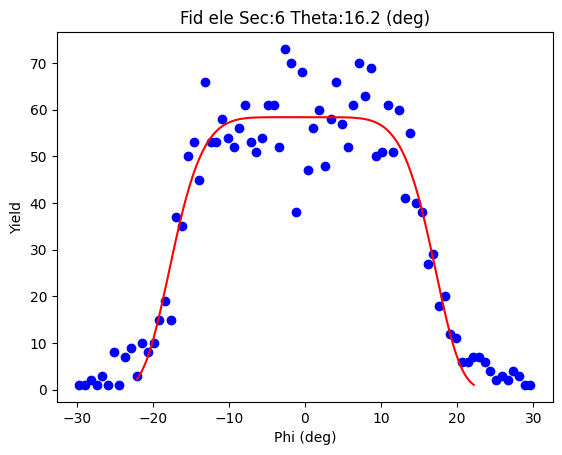

...........Theta: 17.4 ............
Binning| Sec: 5  Ybin: 14
Sum of plot 2873.0
Initial Bounds: [-23.307707115094313, 22.657331873886765]
Sum of initial fit area: 2805.0
max at  91.0
initial max 58.372217098293135
initial guesses: [91.0, -0.3251876206037726, 12.755218314729767, 6.304931834269282]
fit bounds [-23.307707115094313, 22.657331873886765]
(array([59.52566441, -0.10419583, 13.28463678,  7.24955135]), array([[ 2.75241728e+00,  4.37378899e-04, -1.06939586e-01,
        -8.81156122e-01],
       [ 4.37378899e-04,  8.89740176e-02,  1.20150541e-04,
        -1.12734030e-03],
       [-1.06939586e-01,  1.20150541e-04,  5.51252151e-02,
        -2.74015516e-02],
       [-8.81156122e-01, -1.12734030e-03, -2.74015516e-02,
         1.56363511e+00]]))
[59.52566441 -0.10419583 13.28463678  7.24955135]
[59.52566441 -0.10419583 13.28463678  7.24955135]
New Bounds for next fit: [-23.296959752632887, 23.08856810154102]


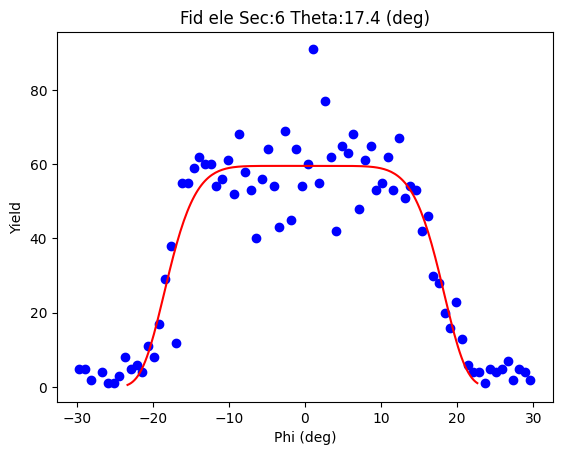

...........Theta: 18.6 ............
Binning| Sec: 5  Ybin: 15
Sum of plot 2912.0
Initial Bounds: [-23.296959752632887, 23.08856810154102]
Sum of initial fit area: 2861.0
max at  75.0
initial max 59.52566440597744
initial guesses: [75.0, -0.10419582554593139, 13.284636781714788, 7.2495513523518325]
fit bounds [-23.296959752632887, 23.08856810154102]
(array([57.22650465, -0.3196313 , 13.90433619,  9.30784421]), array([[ 1.33953903e+00, -1.25749944e-04, -4.37335525e-02,
        -5.90726367e-01],
       [-1.25749944e-04,  4.47156467e-02, -3.84401369e-05,
         5.43474219e-04],
       [-4.37335525e-02, -3.84401369e-05,  2.68028259e-02,
        -3.12379617e-02],
       [-5.90726367e-01,  5.43474219e-04, -3.12379617e-02,
         1.79232931e+00]]))
[57.22650465 -0.3196313  13.90433619  9.30784421]
[57.22650465 -0.3196313  13.90433619  9.30784421]
New Bounds for next fit: [-23.489410516011386, 22.850147924199323]


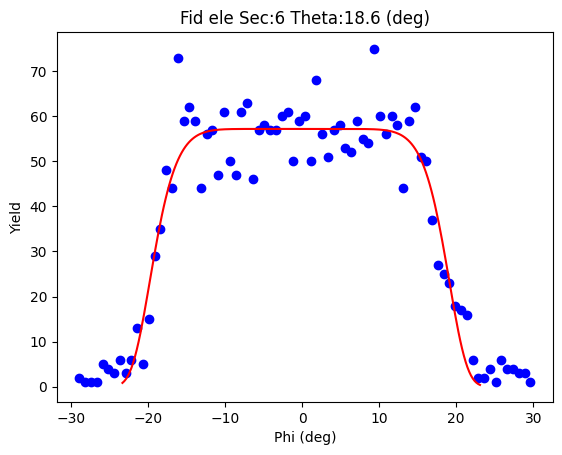

...........Theta: 19.8 ............
Binning| Sec: 5  Ybin: 16
Sum of plot 3018.0
Initial Bounds: [-23.489410516011386, 22.850147924199323]
Sum of initial fit area: 2940.0
max at  76.0
initial max 57.22650464863334
initial guesses: [76.0, -0.31963129590603145, 13.904336185513975, 9.307844211680026]
fit bounds [-23.489410516011386, 22.850147924199323]
(array([56.3562248 , -0.09864353, 14.39178868, 11.86963147]), array([[ 1.47284400e+00,  3.72125091e-04, -3.86642831e-02,
        -8.72638224e-01],
       [ 3.72125091e-04,  4.65458003e-02,  1.43194717e-04,
        -2.75390645e-03],
       [-3.86642831e-02,  1.43194717e-04,  2.74325967e-02,
        -6.58503683e-02],
       [-8.72638224e-01, -2.75390645e-03, -6.58503683e-02,
         4.39073571e+00]]))
[56.3562248  -0.09864353 14.39178868 11.86963147]
[56.3562248  -0.09864353 14.39178868 11.86963147]
New Bounds for next fit: [-23.2463145230552, 23.049027461268683]


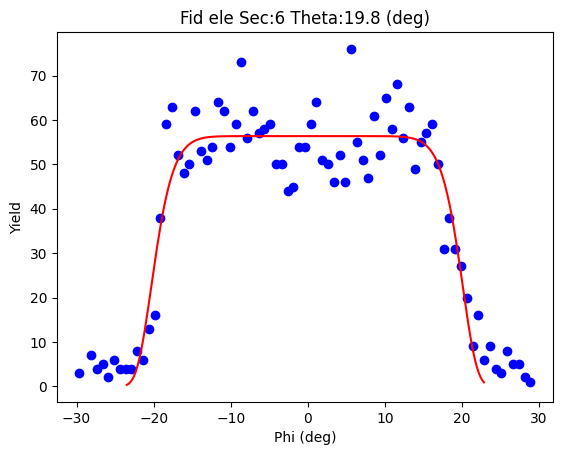

...........Theta: 21.0 ............
Binning| Sec: 5  Ybin: 17
Sum of plot 3051.0
Initial Bounds: [-23.2463145230552, 23.049027461268683]
Sum of initial fit area: 2964.0
max at  71.0
initial max 56.35622479909174
initial guesses: [71.0, -0.09864353089325906, 14.39178867957396, 11.869631474696428]
fit bounds [-23.2463145230552, 23.049027461268683]
(array([ 5.48912065e+01, -2.72437827e-02,  1.49338675e+01,  1.20000000e+01]), array([[ 1.25710345e+00, -9.43047631e-05, -3.36373227e-02,
        -7.91431808e-01],
       [-9.43047631e-05,  4.49700983e-02, -4.50513613e-05,
         7.71962497e-04],
       [-3.36373227e-02, -4.50513613e-05,  2.67749530e-02,
        -7.10498736e-02],
       [-7.91431808e-01,  7.71962497e-04, -7.10498736e-02,
         4.22956267e+00]]))
[ 5.48912065e+01 -2.72437827e-02  1.49338675e+01  1.20000000e+01]
[ 5.48912065e+01 -2.72437827e-02  1.49338675e+01  1.20000000e+01]
New Bounds for next fit: [-24.013240199473167, 23.958752634068674]


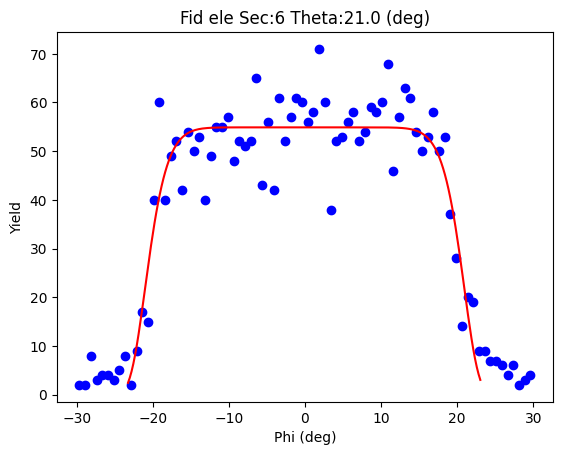

...........Theta: 22.2 ............
Binning| Sec: 5  Ybin: 18
Sum of plot 2908.0
Initial Bounds: [-24.013240199473167, 23.958752634068674]
Sum of initial fit area: 2851.0
max at  65.0
initial max 54.891206521161465
initial guesses: [65.0, -0.027243782702248056, 14.933867470659749, 11.999999991875567]
fit bounds [-24.013240199473167, 23.958752634068674]
(array([ 5.13158307e+01, -2.86384098e-02,  1.53665668e+01,  1.20000000e+01]), array([[ 9.86336167e-01, -7.10833331e-05, -2.93073877e-02,
        -6.60444340e-01],
       [-7.10833331e-05,  4.26832803e-02, -3.63208386e-05,
         6.16081512e-04],
       [-2.93073877e-02, -3.63208386e-05,  2.53362590e-02,
        -6.35373853e-02],
       [-6.60444340e-01,  6.16081512e-04, -6.35373853e-02,
         3.76316665e+00]]))
[ 5.13158307e+01 -2.86384098e-02  1.53665668e+01  1.20000000e+01]
[ 5.13158307e+01 -2.86384098e-02  1.53665668e+01  1.20000000e+01]
New Bounds for next fit: [-24.709613817435155, 24.652336997763776]


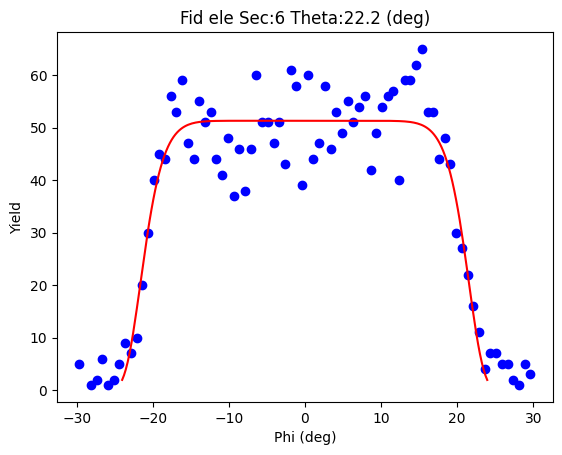

...........Theta: 23.4 ............
Binning| Sec: 5  Ybin: 19
Sum of plot 2842.0
Initial Bounds: [-24.709613817435155, 24.652336997763776]
Sum of initial fit area: 2795.0
max at  65.0
initial max 51.31583073661651
initial guesses: [65.0, -0.028638409835688744, 15.366566783848496, 11.999999999999996]
fit bounds [-24.709613817435155, 24.652336997763776]
(array([ 4.86975798e+01, -2.57652000e-02,  1.59322006e+01,  1.10982686e+01]), array([[ 1.20108042e+00, -1.42849802e-04, -4.04478064e-02,
        -7.99656576e-01],
       [-1.42849802e-04,  6.59083452e-02, -8.97807336e-05,
         1.17174223e-03],
       [-4.04478064e-02, -8.97807336e-05,  3.99837058e-02,
        -9.09870297e-02],
       [-7.99656576e-01,  1.17174223e-03, -9.09870297e-02,
         4.17811459e+00]]))
[ 4.86975798e+01 -2.57652000e-02  1.59322006e+01  1.10982686e+01]
[ 4.86975798e+01 -2.57652000e-02  1.59322006e+01  1.10982686e+01]
New Bounds for next fit: [-25.88120616634882, 25.82967576628543]


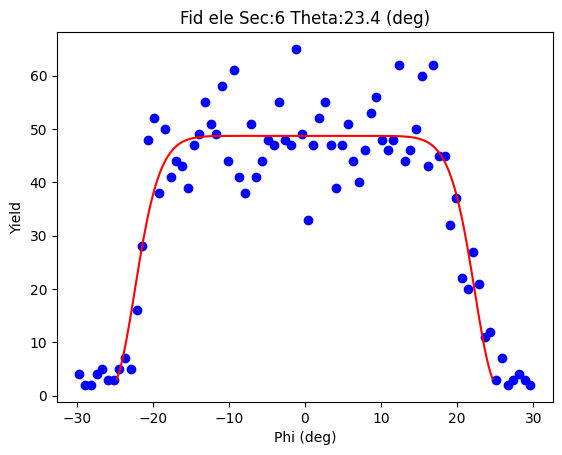

...........Theta: 24.6 ............
Binning| Sec: 5  Ybin: 20
Sum of plot 2751.0
Initial Bounds: [-25.88120616634882, 25.82967576628543]
Sum of initial fit area: 2710.0
max at  57.0
initial max 48.69757982648142
initial guesses: [57.0, -0.025765200031695953, 15.932200607490547, 11.098268595702343]
fit bounds [-25.88120616634882, 25.82967576628543]
(array([45.82682171,  0.17061603, 16.35661127, 12.        ]), array([[ 1.03911687e+00,  9.35994171e-04, -3.70416799e-02,
        -7.74987155e-01],
       [ 9.35994171e-04,  6.39078528e-02,  5.55121306e-04,
        -8.99524236e-03],
       [-3.70416799e-02,  5.55121306e-04,  3.78597746e-02,
        -8.75479502e-02],
       [-7.74987155e-01, -8.99524236e-03, -8.75479502e-02,
         4.93495502e+00]]))
[45.82682171  0.17061603 16.35661127 12.        ]
[45.82682171  0.17061603 16.35661127 12.        ]
New Bounds for next fit: [-26.100517024981624, 26.441749075221107]


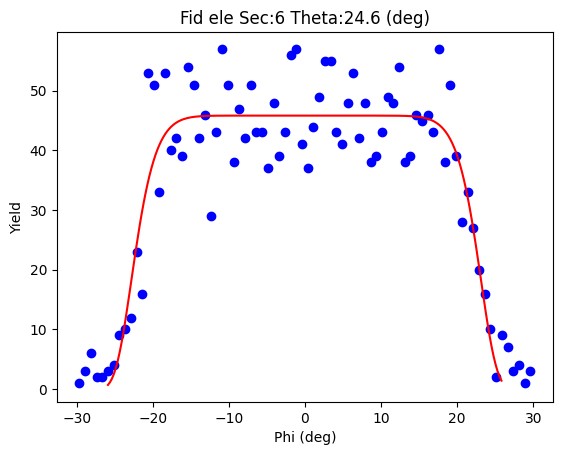

...........Theta: 25.8 ............
Binning| Sec: 5  Ybin: 21
Sum of plot 2858.0
Initial Bounds: [-26.100517024981624, 26.441749075221107]
Sum of initial fit area: 2825.0
max at  64.0
initial max 45.82682170781329
initial guesses: [64.0, 0.17061602511974291, 16.35661126980624, 11.999999999999998]
fit bounds [-26.100517024981624, 26.441749075221107]
(array([48.36596156, -0.22689573, 16.08783092, 12.        ]), array([[ 1.13581637e+00, -2.50167798e-05, -3.89956466e-02,
        -7.84356916e-01],
       [-2.50167798e-05,  6.03329230e-02, -1.02670357e-05,
         2.06357550e-04],
       [-3.89956466e-02, -1.02670357e-05,  3.53597556e-02,
        -7.38688514e-02],
       [-7.84356916e-01,  2.06357550e-04, -7.38688514e-02,
         4.67248163e+00]]))
[48.36596156 -0.22689573 16.08783092 12.        ]
[48.36596156 -0.22689573 16.08783092 12.        ]
New Bounds for next fit: [-26.066327858919735, 25.612536392857763]


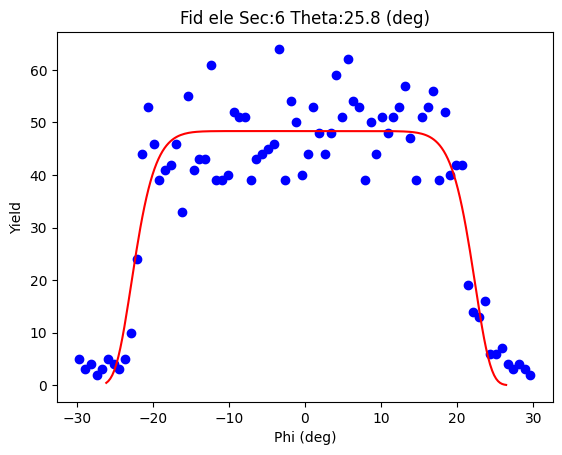

...........Theta: 27.0 ............
Binning| Sec: 5  Ybin: 22
Sum of plot 2907.0
Initial Bounds: [-26.066327858919735, 25.612536392857763]
Sum of initial fit area: 2865.0
max at  58.0
initial max 48.36596155595739
initial guesses: [58.0, -0.22689573303098584, 16.087830924904647, 11.999999999999998]
fit bounds [-26.066327858919735, 25.612536392857763]
(array([48.04372129,  0.24068517, 16.55302553, 11.37668617]), array([[ 8.56036239e-01,  1.92667778e-03, -2.95563998e-02,
        -5.92149369e-01],
       [ 1.92667778e-03,  5.15681131e-02,  1.29807490e-03,
        -1.68993651e-02],
       [-2.95563998e-02,  1.29807490e-03,  3.12343563e-02,
        -7.34686780e-02],
       [-5.92149369e-01, -1.68993651e-02, -7.34686780e-02,
         3.29999469e+00]]))
[48.04372129  0.24068517 16.55302553 11.37668617]
[48.04372129  0.24068517 16.55302553 11.37668617]
New Bounds for next fit: [-26.531945918493534, 27.013316250117704]


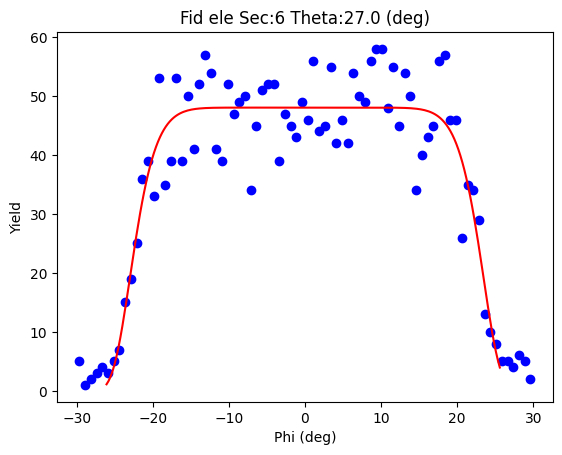

...........Theta: 28.2 ............
Binning| Sec: 5  Ybin: 23
Sum of plot 2786.0
Initial Bounds: [-26.531945918493534, 27.013316250117704]
Sum of initial fit area: 2760.0
max at  65.0
initial max 48.043721294980955
initial guesses: [65.0, 0.24068516581208635, 16.55302552693437, 11.37668617169905]
fit bounds [-26.531945918493534, 27.013316250117704]
(array([45.63263276,  0.33489128, 16.76640492, 12.        ]), array([[ 1.43185617e+00, -6.06585760e-05, -5.36943286e-02,
        -1.05726608e+00],
       [-6.06585760e-05,  9.29048109e-02, -3.30093947e-05,
         5.62917228e-04],
       [-5.36943286e-02, -3.30093947e-05,  5.46362201e-02,
        -1.14077842e-01],
       [-1.05726608e+00,  5.62917228e-04, -1.14077842e-01,
         6.70335281e+00]]))
[45.63263276  0.33489128 16.76640492 12.        ]
[45.63263276  0.33489128 16.76640492 12.        ]
New Bounds for next fit: [-26.59443088407133, 27.2642134434465]


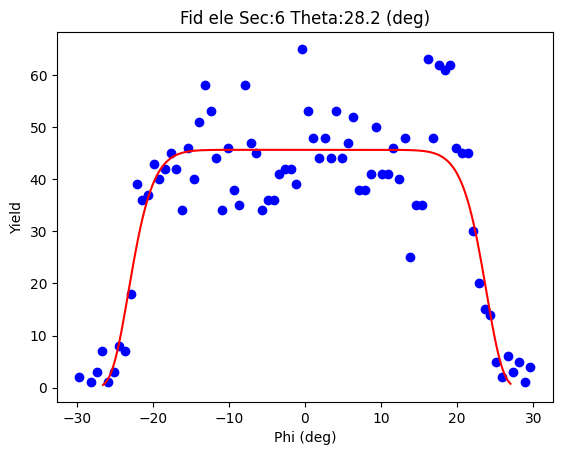

...........Theta: 29.4 ............
Binning| Sec: 5  Ybin: 24
Sum of plot 2785.0
Initial Bounds: [-26.59443088407133, 27.2642134434465]
Sum of initial fit area: 2757.0
max at  64.0
initial max 45.63263275678645
initial guesses: [64.0, 0.33489127968758436, 16.766404918735795, 11.999999999999998]
fit bounds [-26.59443088407133, 27.2642134434465]
(array([44.86145084,  0.43475739, 17.08963278, 12.        ]), array([[ 1.07960506e+00,  2.12567615e-04, -4.04752623e-02,
        -8.31191710e-01],
       [ 2.12567615e-04,  7.57216996e-02,  1.42960266e-04,
        -2.13304335e-03],
       [-4.04752623e-02,  1.42960266e-04,  4.50767213e-02,
        -1.04347068e-01],
       [-8.31191710e-01, -2.13304335e-03, -1.04347068e-01,
         5.43416553e+00]]))
[44.86145084  0.43475739 17.08963278 12.        ]
[44.86145084  0.43475739 17.08963278 12.        ]
New Bounds for next fit: [-27.01371644858931, 27.88323123222177]


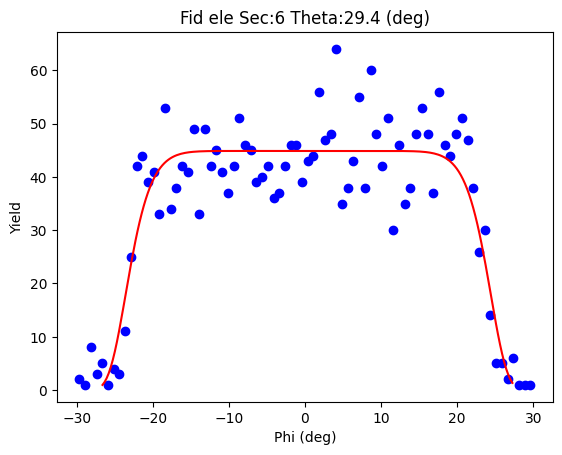

...........Theta: 30.6 ............
Binning| Sec: 5  Ybin: 25
Sum of plot 2782.0
Initial Bounds: [-27.01371644858931, 27.88323123222177]
Sum of initial fit area: 2769.0
max at  67.0
initial max 44.861450837591356
initial guesses: [67.0, 0.4347573918162318, 17.08963278061685, 11.999999999999998]
fit bounds [-27.01371644858931, 27.88323123222177]
(array([45.60728103,  0.37064435, 16.83808315, 12.        ]), array([[ 1.06567574e+00,  1.26506495e-03, -3.90633912e-02,
        -8.00526162e-01],
       [ 1.26506495e-03,  7.03370725e-02,  8.54933449e-04,
        -1.26485983e-02],
       [-3.90633912e-02,  8.54933449e-04,  4.17773876e-02,
        -9.60462382e-02],
       [-8.00526162e-01, -1.26485983e-02, -9.60462382e-02,
         5.13694853e+00]]))
[45.60728103  0.37064435 16.83808315 12.        ]
[45.60728103  0.37064435 16.83808315 12.        ]
New Bounds for next fit: [-26.67380364113767, 27.415092341687117]


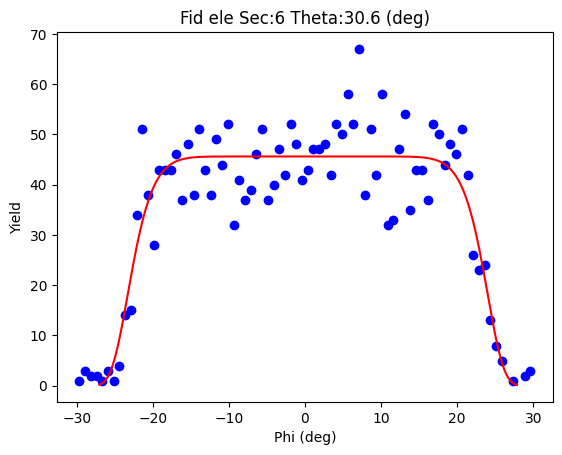

...........Theta: 31.8 ............
Binning| Sec: 5  Ybin: 26
Sum of plot 2751.0
Initial Bounds: [-26.67380364113767, 27.415092341687117]
Sum of initial fit area: 2734.0
max at  61.0
initial max 45.60728103140323
initial guesses: [61.0, 0.37064435027472376, 16.838083152272638, 11.999999999999995]
fit bounds [-26.67380364113767, 27.415092341687117]
(array([44.97507837,  0.34968014, 16.90552446, 10.69045987]), array([[ 8.77663565e-01, -1.67867490e-05, -3.81720555e-02,
        -5.76824383e-01],
       [-1.67867490e-05,  6.43336296e-02, -8.76732023e-06,
         1.24023684e-04],
       [-3.81720555e-02, -8.76732023e-06,  3.81152480e-02,
        -5.64728843e-02],
       [-5.76824383e-01,  1.24023684e-04, -5.64728843e-02,
         2.94107543e+00]]))
[44.97507837  0.34968014 16.90552446 10.69045987]
[44.97507837  0.34968014 16.90552446 10.69045987]
New Bounds for next fit: [-27.229702471711192, 27.929062760052254]


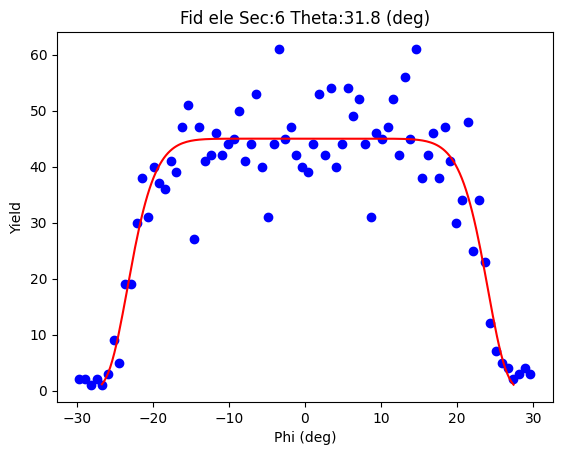

...........Theta: 33.0 ............
Binning| Sec: 5  Ybin: 27
Sum of plot 2718.0
Initial Bounds: [-27.229702471711192, 27.929062760052254]
Sum of initial fit area: 2705.0
max at  59.0
initial max 44.975078369067816
initial guesses: [59.0, 0.3496801441705315, 16.905524461010444, 10.690459874053122]
fit bounds [-27.229702471711192, 27.929062760052254]
(array([4.34345433e+01, 3.30097458e-02, 1.72767468e+01, 1.20000000e+01]), array([[ 1.02347108e+00, -4.91409277e-04, -4.12139690e-02,
        -7.98394372e-01],
       [-4.91409277e-04,  7.79417927e-02, -3.05181546e-04,
         4.87706274e-03],
       [-4.12139690e-02, -3.05181546e-04,  4.59604016e-02,
        -9.59237922e-02],
       [-7.98394372e-01,  4.87706274e-03, -9.59237922e-02,
         5.33521856e+00]]))
[4.34345433e+01 3.30097458e-02 1.72767468e+01 1.20000000e+01]
[4.34345433e+01 3.30097458e-02 1.72767468e+01 1.20000000e+01]
New Bounds for next fit: [-27.715996831187226, 27.7820163227557]


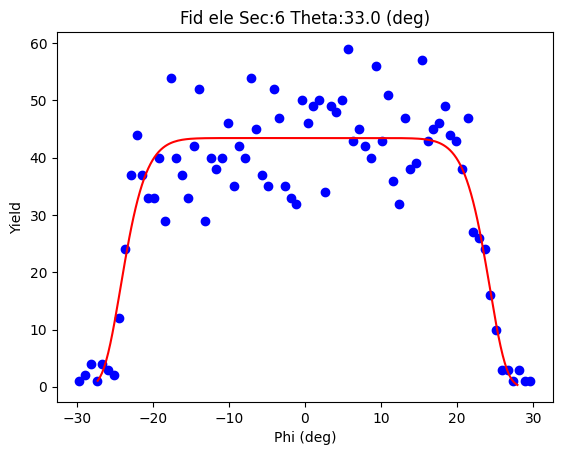

...........Theta: 34.2 ............
Binning| Sec: 5  Ybin: 28
Sum of plot 2583.0
Initial Bounds: [-27.715996831187226, 27.7820163227557]
Sum of initial fit area: 2570.0
max at  52.0
initial max 43.43454331406072
initial guesses: [52.0, 0.033009745784237605, 17.2767467941801, 11.999999999999716]
fit bounds [-27.715996831187226, 27.7820163227557]
(array([41.38782512,  0.19224948, 17.25585225, 12.        ]), array([[ 7.20395658e-01, -2.09593015e-03, -2.36880753e-02,
        -6.62689426e-01],
       [-2.09593015e-03,  6.43410608e-02, -2.33298981e-03,
         2.67295747e-02],
       [-2.36880753e-02, -2.33298981e-03,  4.18013856e-02,
        -1.52992616e-01],
       [-6.62689426e-01,  2.67295747e-02, -1.52992616e-01,
         5.05985875e+00]]))
[41.38782512  0.19224948 17.25585225 12.        ]
[41.38782512  0.19224948 17.25585225 12.        ]
New Bounds for next fit: [-27.523197372486305, 27.907696327997964]


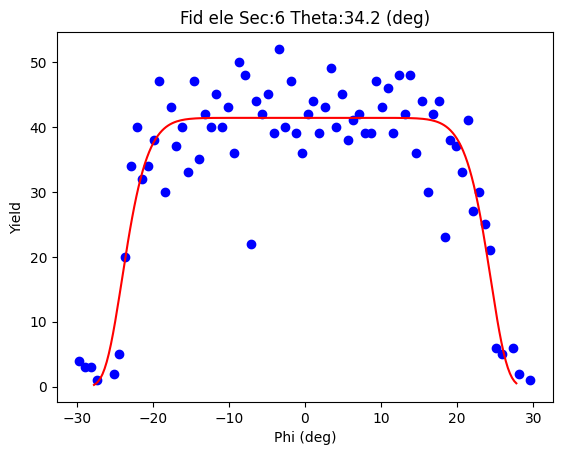

...........Theta: 35.4 ............
Binning| Sec: 5  Ybin: 29
Sum of plot 2534.0
Initial Bounds: [-27.523197372486305, 27.907696327997964]
Sum of initial fit area: 2524.0
max at  56.0
initial max 41.38782511649129
initial guesses: [56.0, 0.19224947775582862, 17.255852247934772, 11.999999999999744]
fit bounds [-27.523197372486305, 27.907696327997964]
(array([4.06286302e+01, 1.11407652e-02, 1.72060133e+01, 1.20000000e+01]), array([[ 8.80396600e-01,  3.38520469e-06, -3.84131612e-02,
        -7.24856044e-01],
       [ 3.38520469e-06,  7.58156457e-02,  1.88800597e-06,
        -3.38941083e-05],
       [-3.84131612e-02,  1.88800597e-06,  4.44573886e-02,
        -8.74168856e-02],
       [-7.24856044e-01, -3.38941083e-05, -8.74168856e-02,
         5.14374728e+00]]))
[4.06286302e+01 1.11407652e-02 1.72060133e+01 1.20000000e+01]
[4.06286302e+01 1.11407652e-02 1.72060133e+01 1.20000000e+01]
New Bounds for next fit: [-27.624257385446008, 27.646538915816414]


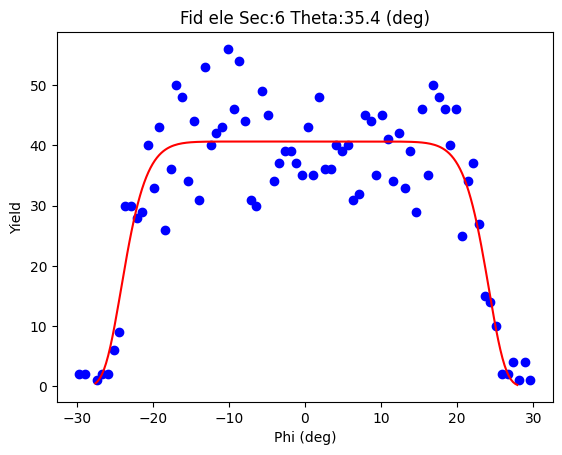

...........Theta: 36.6 ............
Binning| Sec: 5  Ybin: 30
Sum of plot 2362.0
Initial Bounds: [-27.624257385446008, 27.646538915816414]
Sum of initial fit area: 2354.0
max at  49.0
initial max 40.62863022471851
initial guesses: [49.0, 0.011140765185203667, 17.206013306474144, 11.999999999999966]
fit bounds [-27.624257385446008, 27.646538915816414]
(array([37.70553214,  0.27288212, 17.33370176, 12.        ]), array([[ 6.33663506e-01,  1.31290159e-04, -2.98535656e-02,
        -5.64450072e-01],
       [ 1.31290159e-04,  6.43392271e-02,  8.57907079e-05,
        -1.45423274e-03],
       [-2.98535656e-02,  8.57907079e-05,  3.77896067e-02,
        -7.52137831e-02],
       [-5.64450072e-01, -1.45423274e-03, -7.52137831e-02,
         4.32463983e+00]]))
[37.70553214  0.27288212 17.33370176 12.        ]
[37.70553214  0.27288212 17.33370176 12.        ]
New Bounds for next fit: [-27.567602538041196, 28.11336678447886]


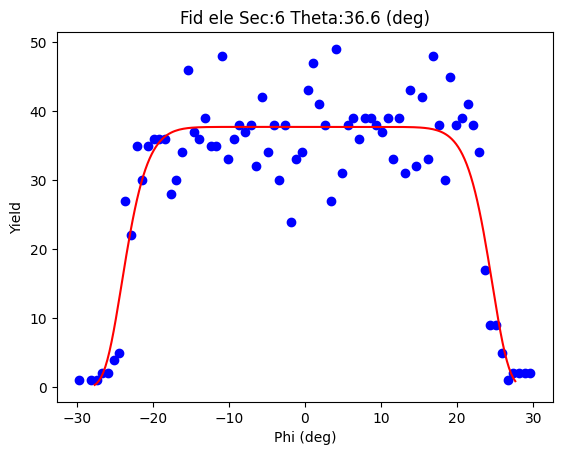

...........Theta: 37.8 ............
Binning| Sec: 5  Ybin: 31
Sum of plot 2192.0
Initial Bounds: [-27.567602538041196, 28.11336678447886]
Sum of initial fit area: 2182.0
max at  49.0
initial max 37.70553214107823
initial guesses: [49.0, 0.27288212321883004, 17.333701759219572, 11.999999999999998]
fit bounds [-27.567602538041196, 28.11336678447886]
(array([34.64900005, -0.25399688, 17.48221127, 11.10307703]), array([[ 7.36856577e-01,  4.22699375e-04, -3.93461041e-02,
        -6.78180340e-01],
       [ 4.22699375e-04,  9.56674534e-02,  3.82358727e-04,
        -4.75571443e-03],
       [-3.93461041e-02,  3.82358727e-04,  5.74525301e-02,
        -1.09512436e-01],
       [-6.78180340e-01, -4.75571443e-03, -1.09512436e-01,
         4.93367111e+00]]))
[34.64900005 -0.25399688 17.48221127 11.10307703]
[34.64900005 -0.25399688 17.48221127 11.10307703]
New Bounds for next fit: [-28.62316926928348, 28.115175505351317]


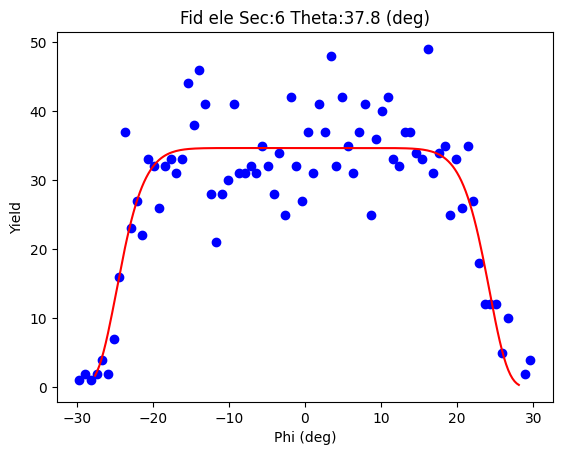

...........Theta: 39.0 ............
Binning| Sec: 5  Ybin: 32
Sum of plot 2292.0
Initial Bounds: [-28.62316926928348, 28.115175505351317]
Sum of initial fit area: 2289.0
max at  52.0
initial max 34.649000052177186
initial guesses: [52.0, -0.25399688196608283, 17.48221126732874, 11.103077029170565]
fit bounds [-28.62316926928348, 28.115175505351317]
(array([ 3.62254263e+01, -2.03101204e-02,  1.75585105e+01,  1.20000000e+01]), array([[ 6.71517681e-01, -2.28563054e-03, -3.09146815e-02,
        -6.41285160e-01],
       [-2.28563054e-03,  8.20177592e-02, -5.88912657e-03,
         4.65963558e-02],
       [-3.09146815e-02, -5.88912657e-03,  5.02161842e-02,
        -1.34235282e-01],
       [-6.41285160e-01,  4.65963558e-02, -1.34235282e-01,
         5.34047603e+00]]))
[ 3.62254263e+01 -2.03101204e-02  1.75585105e+01  1.20000000e+01]
[ 3.62254263e+01 -2.03101204e-02  1.75585105e+01  1.20000000e+01]
New Bounds for next fit: [-28.221870758338117, 28.181250517535926]


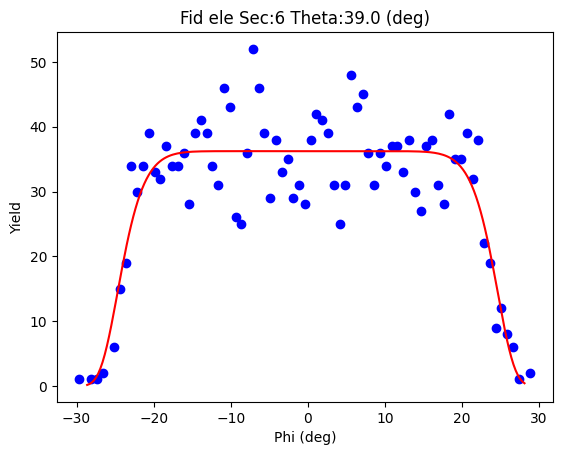

...........Theta: 40.2 ............
Binning| Sec: 5  Ybin: 33
Sum of plot 2189.0
Initial Bounds: [-28.221870758338117, 28.181250517535926]
Sum of initial fit area: 2182.0
max at  46.0
initial max 36.22542630599463
initial guesses: [46.0, -0.020310120401097188, 17.558510463819708, 11.999999999999954]
fit bounds [-28.221870758338117, 28.181250517535926]
(array([ 3.46681695e+01, -6.21084792e-05,  1.74982673e+01,  1.20000000e+01]), array([[ 6.58463727e-01, -1.89586956e-03, -3.03767893e-02,
        -6.71174248e-01],
       [-1.89586956e-03,  8.69274499e-02, -5.25251051e-03,
         4.13379065e-02],
       [-3.03767893e-02, -5.25251051e-03,  5.39924933e-02,
        -1.56471897e-01],
       [-6.71174248e-01,  4.13379065e-02, -1.56471897e-01,
         5.90764797e+00]]))
[ 3.46681695e+01 -6.21084792e-05  1.74982673e+01  1.20000000e+01]
[ 3.46681695e+01 -6.21084792e-05  1.74982673e+01  1.20000000e+01]
New Bounds for next fit: [-28.104863353630286, 28.104739136671867]


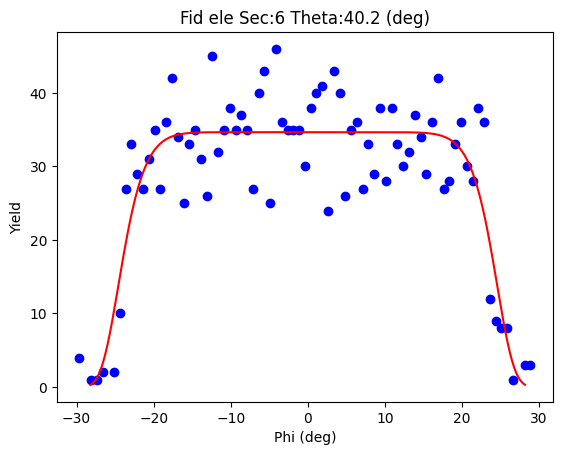

...........Theta: 41.4 ............
Binning| Sec: 5  Ybin: 34
Sum of plot 2049.0
Initial Bounds: [-28.104863353630286, 28.104739136671867]
Sum of initial fit area: 2046.0
max at  43.0
initial max 34.66816948831434
initial guesses: [43.0, -6.210847920824701e-05, 17.49826731513312, 11.999999999999922]
fit bounds [-28.104863353630286, 28.104739136671867]
(array([32.82704078,  0.26139562, 17.41426015, 10.76045219]), array([[ 0.72471636, -0.00772065, -0.03396686, -0.74579395],
       [-0.00772065,  0.11551644, -0.01123666,  0.10159181],
       [-0.03396686, -0.01123666,  0.07492872, -0.2147787 ],
       [-0.74579395,  0.10159181, -0.2147787 ,  5.80087046]]))
[32.82704078  0.26139562 17.41426015 10.76045219]
[32.82704078  0.26139562 17.41426015 10.76045219]
New Bounds for next fit: [-28.121543712331363, 28.64433496187674]


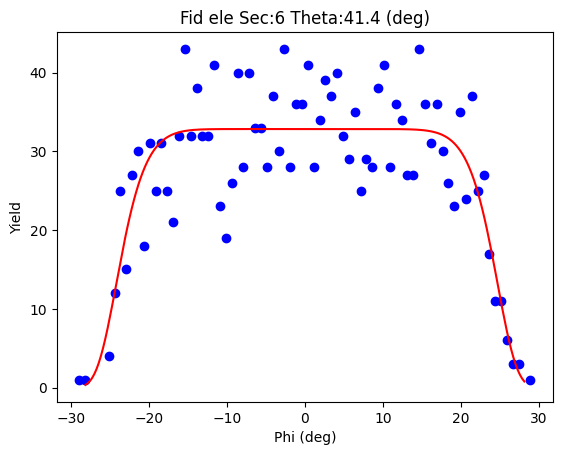

...........Theta: 42.6 ............
Binning| Sec: 5  Ybin: 35
Sum of plot 2115.0
Initial Bounds: [-28.121543712331363, 28.64433496187674]
Sum of initial fit area: 2109.0
max at  44.0
initial max 32.82704078314434
initial guesses: [44.0, 0.26139562477269057, 17.4142601468457, 10.760452190038883]
fit bounds [-28.121543712331363, 28.64433496187674]
(array([ 3.33537011e+01, -5.19343653e-03,  1.75817968e+01,  1.20000000e+01]), array([[ 7.29453963e-01,  1.89915359e-03, -3.40011435e-02,
        -7.86802514e-01],
       [ 1.89915359e-03,  1.06122673e-01,  6.69636948e-03,
        -4.83140756e-02],
       [-3.40011435e-02,  6.69636948e-03,  6.68233706e-02,
        -2.05348599e-01],
       [-7.86802514e-01, -4.83140756e-02, -2.05348599e-01,
         7.27639087e+00]]))
[ 3.33537011e+01 -5.19343653e-03  1.75817968e+01  1.20000000e+01]
[ 3.33537011e+01 -5.19343653e-03  1.75817968e+01  1.20000000e+01]
New Bounds for next fit: [-28.244155365412855, 28.233768492359534]


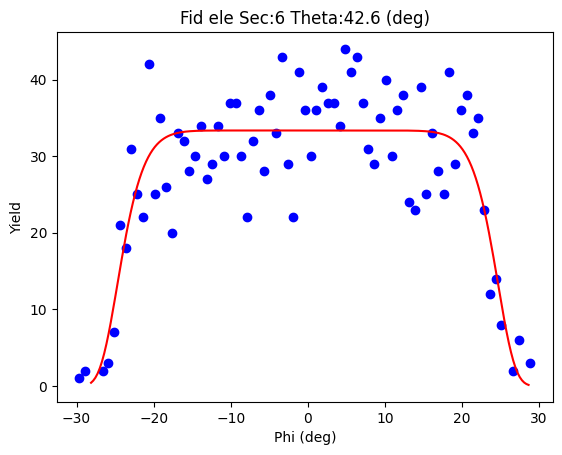

...........Theta: 43.8 ............
Binning| Sec: 5  Ybin: 36
Sum of plot 1909.0
Initial Bounds: [-28.244155365412855, 28.233768492359534]
Sum of initial fit area: 1905.0
max at  43.0
initial max 33.35370108026129
initial guesses: [43.0, -0.0051934365266609215, 17.581796797754297, 11.999999999999986]
fit bounds [-28.244155365412855, 28.233768492359534]
(array([30.09348864,  0.03165136, 17.60891145, 12.        ]), array([[ 5.68114619e-01, -4.31341396e-03, -2.89849784e-02,
        -6.83142995e-01],
       [-4.31341396e-03,  1.03178848e-01, -9.80245166e-03,
         8.91172381e-02],
       [-2.89849784e-02, -9.80245166e-03,  6.47835254e-02,
        -2.03841178e-01],
       [-6.83142995e-01,  8.91172381e-02, -2.03841178e-01,
         7.03461732e+00]]))
[30.09348864  0.03165136 17.60891145 12.        ]
[30.09348864  0.03165136 17.60891145 12.        ]
New Bounds for next fit: [-28.250860707842733, 28.31416342732907]


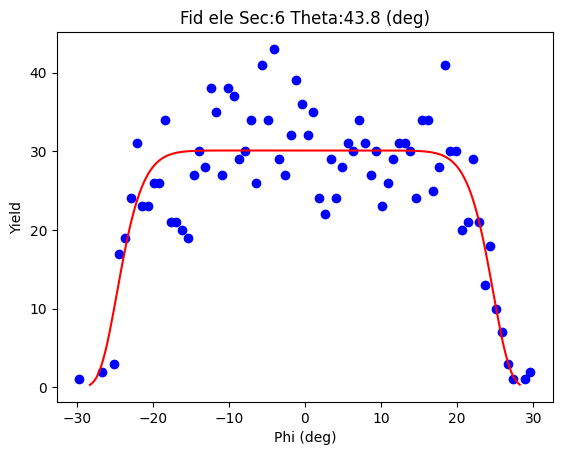

...........Theta: 45.0 ............
Binning| Sec: 5  Ybin: 37
Sum of plot 1856.0
Initial Bounds: [-28.250860707842733, 28.31416342732907]
Sum of initial fit area: 1856.0
max at  42.0
initial max 30.09348863940712
initial guesses: [42.0, 0.03165135974316772, 17.608911451950522, 11.999999999702249]
fit bounds [-28.250860707842733, 28.31416342732907]
(array([2.93151060e+01, 2.19800456e-02, 1.75677657e+01, 1.20000000e+01]), array([[ 6.92949300e-01,  4.17984648e-06, -4.28432097e-02,
        -7.89809274e-01],
       [ 4.17984648e-06,  1.19479072e-01,  3.17220352e-06,
        -5.73502520e-05],
       [-4.28432097e-02,  3.17220352e-06,  7.00327671e-02,
        -1.34193032e-01],
       [-7.89809274e-01, -5.73502520e-05, -1.34193032e-01,
         7.76377047e+00]]))
[2.93151060e+01 2.19800456e-02 1.75677657e+01 1.20000000e+01]
[2.93151060e+01 2.19800456e-02 1.75677657e+01 1.20000000e+01]
New Bounds for next fit: [-28.194445900369143, 28.23840599147213]


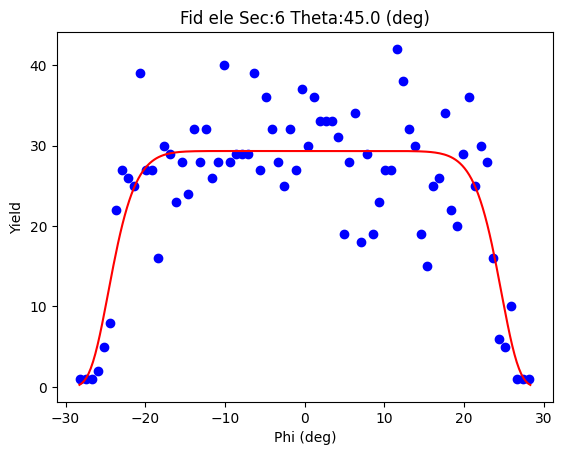

...........Theta: 46.2 ............
Binning| Sec: 5  Ybin: 38
Sum of plot 1716.0
Initial Bounds: [-28.194445900369143, 28.23840599147213]
Sum of initial fit area: 1714.0
max at  38.0
initial max 29.315105953045116
initial guesses: [38.0, 0.0219800455514925, 17.56776571990746, 11.999999999999998]
fit bounds [-28.194445900369143, 28.23840599147213]
(array([27.1958687 , -0.16219127, 17.48496485, 12.        ]), array([[ 6.36617271e-01,  2.08020169e-03, -3.90929113e-02,
        -8.18295335e-01],
       [ 2.08020169e-03,  1.29220862e-01,  3.15766505e-03,
        -3.84843474e-02],
       [-3.90929113e-02,  3.15766505e-03,  7.79386659e-02,
        -1.95312194e-01],
       [-8.18295335e-01, -3.84843474e-02, -1.95312194e-01,
         8.94789611e+00]]))
[27.1958687  -0.16219127 17.48496485 12.        ]
[27.1958687  -0.16219127 17.48496485 12.        ]
New Bounds for next fit: [-28.245626790886302, 27.92124425490478]


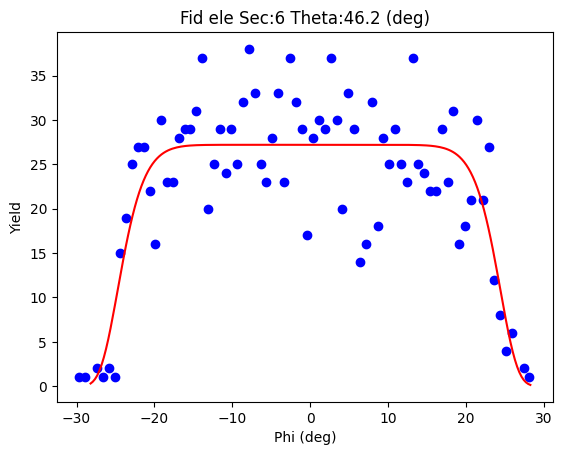

...........Theta: 47.4 ............
Binning| Sec: 5  Ybin: 39
Sum of plot 1624.0
Initial Bounds: [-28.245626790886302, 27.92124425490478]
Sum of initial fit area: 1622.0
max at  35.0
initial max 27.195868704515608
initial guesses: [35.0, -0.16219126799075975, 17.484964850684126, 11.999999999999654]
fit bounds [-28.245626790886302, 27.92124425490478]
(array([25.36373624,  0.13169858, 17.80871863, 12.        ]), array([[ 6.26205827e-01,  1.36702582e-03, -3.67187796e-02,
        -9.26625983e-01],
       [ 1.36702582e-03,  1.54336179e-01,  2.30878674e-03,
        -2.72823110e-02],
       [-3.67187796e-02,  2.30878674e-03,  9.76308426e-02,
        -3.15297832e-01],
       [-9.26625983e-01, -2.72823110e-02, -3.15297832e-01,
         1.13099509e+01]]))
[25.36373624  0.13169858 17.80871863 12.        ]
[25.36373624  0.13169858 17.80871863 12.        ]
New Bounds for next fit: [-28.471733311176937, 28.735130476598474]


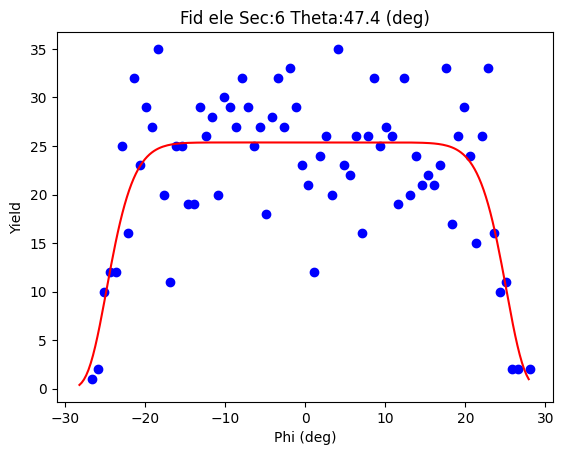

...........Theta: 48.6 ............
Binning| Sec: 5  Ybin: 40
Sum of plot 1435.0
Initial Bounds: [-28.471733311176937, 28.735130476598474]
Sum of initial fit area: 1434.0
max at  35.0
initial max 25.36373623552936
initial guesses: [35.0, 0.13169858271076906, 17.8087186258186, 11.999999999999968]
fit bounds [-28.471733311176937, 28.735130476598474]
(array([22.25868829, -0.13585543, 17.91621706, 12.        ]), array([[ 4.46218173e-01, -1.13629915e-03, -3.54272990e-02,
        -6.90603611e-01],
       [-1.13629915e-03,  1.39932588e-01, -1.60461438e-03,
         2.29200414e-02],
       [-3.54272990e-02, -1.60461438e-03,  8.32516601e-02,
        -1.83072057e-01],
       [-6.90603611e-01,  2.29200414e-02, -1.83072057e-01,
         9.09706130e+00]]))
[22.25868829 -0.13585543 17.91621706 12.        ]
[22.25868829 -0.13585543 17.91621706 12.        ]
New Bounds for next fit: [-28.911945691398138, 28.6402348257999]


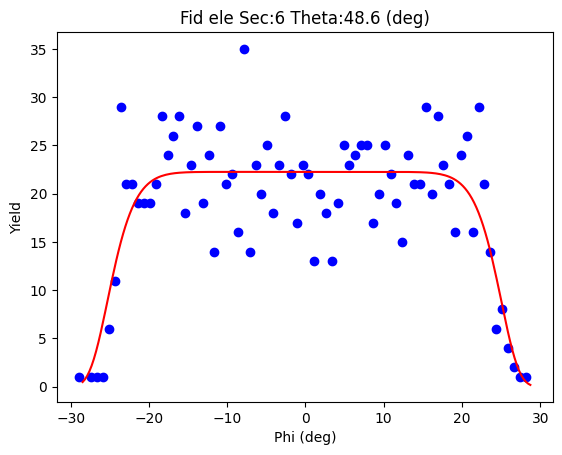

...........Theta: 49.8 ............
Binning| Sec: 5  Ybin: 41
Sum of plot 1194.0
Initial Bounds: [-28.911945691398138, 28.6402348257999]
Sum of initial fit area: 1193.0
max at  31.0
initial max 22.25868829206888
initial guesses: [31.0, -0.1358554327991185, 17.916217063311862, 11.999999999999998]
fit bounds [-28.911945691398138, 28.6402348257999]
(array([18.2655769 , -0.75813652, 18.28187056, 12.        ]), array([[ 4.31319836e-01, -7.28528149e-04, -3.78969510e-02,
        -8.65516107e-01],
       [-7.28528149e-04,  2.41407858e-01, -2.45058207e-02,
         1.05868262e-01],
       [-3.78969510e-02, -2.45058207e-02,  1.53490712e-01,
        -4.61486732e-01],
       [-8.65516107e-01,  1.05868262e-01, -4.61486732e-01,
         1.47609759e+01]]))
[18.2655769  -0.75813652 18.28187056 12.        ]
[18.2655769  -0.75813652 18.28187056 12.        ]
New Bounds for next fit: [-30.121520293522888, 28.605247261338963]


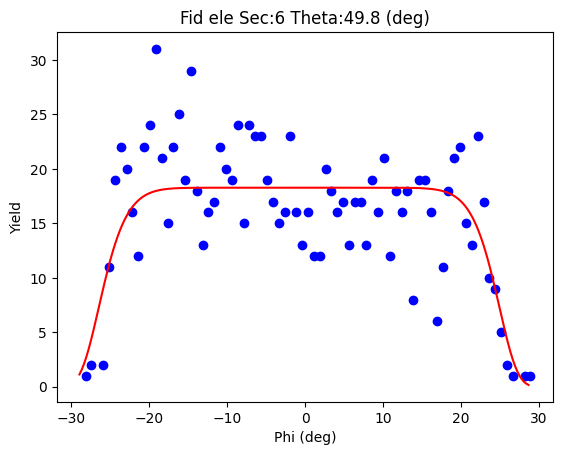

...........Theta: 51.0 ............
Binning| Sec: 5  Ybin: 42
Sum of plot 954.0
Initial Bounds: [-30.121520293522888, 28.605247261338963]
Sum of initial fit area: 954.0
max at  30.0
initial max 18.26557690309564
initial guesses: [30.0, -0.758136516091964, 18.281870564837295, 11.999999999999998]
fit bounds [-30.121520293522888, 28.605247261338963]
(array([14.67566847, -0.82136303, 18.08563843, 12.        ]), array([[ 3.65951565e-01,  3.77479826e-03, -3.75864463e-02,
        -9.32962113e-01],
       [ 3.77479826e-03,  2.80665125e-01,  1.11814692e-02,
        -1.30000937e-01],
       [-3.75864463e-02,  1.11814692e-02,  1.77747351e-01,
        -5.70211061e-01],
       [-9.32962113e-01, -1.30000937e-01, -5.70211061e-01,
         1.97359126e+01]]))
[14.67566847 -0.82136303 18.08563843 12.        ]
[14.67566847 -0.82136303 18.08563843 12.        ]
New Bounds for next fit: [-29.869569012478483, 28.226842955854334]


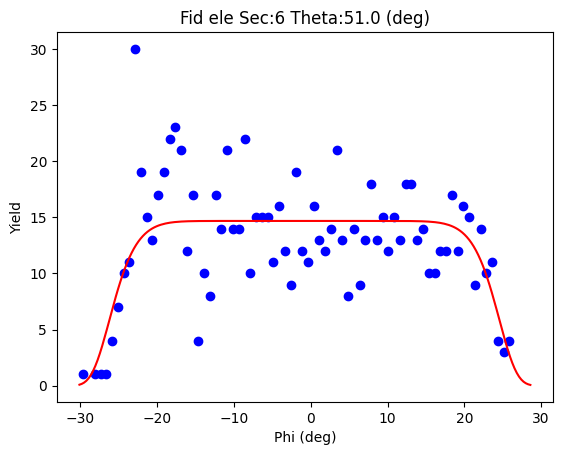

In [20]:
#Bounds Fitting Fun
a1=600.0
m1=0.0
s1=10.0
p1=2.0
ini_par1=[a1,m1,s1,p1]

fid_pip_fit_pars1=np.zeros((6,len(fid_pip_y),4))
fid_pip_fit_sig1=np.zeros((6,len(fid_pip_y),4))
fid_pip_pos_do=np.zeros((6,len(fid_pip_y)))
fid_pip_neg_do=np.zeros((6,len(fid_pip_y)))

front_bump_tolerance=7
back_bump_tolerance=3
low_frac = 0.16
top_frac= 0.12

ini_bounds1=[-10.0,10.0]

theta_max = 50.0
pmin = 0.8

expansion = False
last_par_pos = 0.0
last_par_neg = 0.0
enter_pos_vals = False
enter_neg_vals = False

min_integral = 800

sec_count =0
pbin_count = 0
tbin_count=0
for sec in range(6):
    ini_bounds1[0]=-10.0
    ini_bounds1[1]=10.0
    tbin_count=0
    for ybin in range(len(fid_pip_y)):
        if fid_pip_fit_y[sec][ybin].sum() >= min_integral: 
            if sec_count <= sec:
                print("==========Sec ",sec+1,"===============")
                sec_count+=1
            if tbin_count <= ybin:
                print("...........Theta:",round(fid_pip_y[ybin],3),"............")
                tbin_count+=1
            print("Binning| Sec:",sec," Ybin:",ybin)
            print("Sum of plot",fid_pip_fit_y[sec][ybin].sum())
            print("Initial Bounds:",ini_bounds1)
            print("Sum of initial fit area:",Bounds_on_X_From_Y(fid_pip_fit_y[sec][ybin],fid_pip_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1]).sum())
            print("max at ",np.amax(Bounds_on_X_From_Y(fid_pip_fit_y[sec][ybin],fid_pip_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1])))
            print("initial max",ini_par1[0])
            ini_par1[0] = np.amax(Bounds_on_X_From_Y(fid_pip_fit_y[sec][ybin],fid_pip_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1]))
            #if Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance):
            #    print("lower bump start @ ",Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance))
            #    print("lower found at:",Bounds_on_Y(fid_ele_fit_x[sec][pbin][ybin],Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance),0.0)[np.argmin(Bounds_on_X_From_Y(fid_ele_fit_y[sec][pbin][ybin],fid_ele_fit_x[sec][pbin][ybin],Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance),0.0))])
            #    if Check_Bump_Size(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance,low_frac,5.0):
            #        print("\tlower fraction found sufficient to cut it off")
                    #ini_bounds1[0] = Bounds_on_Y(fid_ele_fit_x[sec][pbin][ybin],Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance),0.0)[np.argmin(Bounds_on_X_From_Y(fid_ele_fit_y[sec][pbin][ybin],fid_ele_fit_x[sec][pbin][ybin],Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance),0.0))]
                    #ini_bounds1[0] = Bump_Safe(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance,0.0)
            #        ini_bounds1[0] = -15.0
            #        print("\tnew lower bound:",ini_bounds1[0])
            #if Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance):
            #    print("upper bump @ ",Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,5))
            #    print("upper found at:",Bounds_on_Y(fid_ele_fit_x[sec][pbin][ybin],0.0,Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance))[np.argmin(Bounds_on_X_From_Y(fid_ele_fit_y[sec][pbin][ybin],fid_ele_fit_x[sec][pbin][ybin],0.0,Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance)))])
            #    if Check_Bump_Size(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance,top_frac,-5.0):
            #        print("\ttop fraction found sufficient to cut it off")
                    #ini_bounds1[1] = Bounds_on_Y(fid_ele_fit_x[sec][pbin][ybin],0.0,Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance))[np.argmin(Bounds_on_X_From_Y(fid_ele_fit_y[sec][pbin][ybin],fid_ele_fit_x[sec][pbin][ybin],0.0,Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance)))]
                    #ini_bounds1[1] = Bump_Safe(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance,0.0)
            #        ini_bounds1[1] = 15.0
            #        print("\tnew upper bound:",ini_bounds1[1])
            print("initial guesses:",ini_par1)
            print("fit bounds",ini_bounds1)
            plt.scatter(fid_pip_fit_x[sec][ybin],fid_pip_fit_y[sec][ybin],label="data",color='b')
            try: 
                pars1=op.curve_fit(Super_Gaus,Bounds_on_Y(fid_pip_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1]),Bounds_on_X_From_Y(fid_pip_fit_y[sec][ybin],fid_pip_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1]),p0=ini_par1,bounds=((0.0,-20,0.0,2.0),(np.inf,20,30,12)),maxfev=5000)
                print(pars1)
                if ybin >0:
                    if pars1[0][1]+pars1[0][2] >= fid_pip_fit_pars1[sec][ybin-1][1]+fid_pip_fit_pars1[sec][ybin-1][2]:
                        enter_pos_vals = True
                    else:
                        enter_pos_vals = False
                    if pars1[0][1]-pars1[0][2] <= fid_pip_fit_pars1[sec][ybin-1][1]-fid_pip_fit_pars1[sec][ybin-1][2]:
                        enter_neg_vals = True
                    else:
                        enter_neg_vals = False
                else:
                    enter_pos_vals = True
                    enter_neg_vals = True
                for i in range(4):
                    fid_pip_fit_pars1[sec][ybin][i] += pars1[0][i]
                    if enter_pos_vals:
                        fid_pip_pos_do[sec][ybin] = 1
                    if enter_neg_vals:
                        fid_pip_neg_do[sec][ybin] = 1
                    fid_pip_fit_sig1[sec][ybin][i] += np.sqrt(pars1[1][i][i])
                    ini_par1[i]=pars1[0][i]
                print(pars1[0])
                print(fid_pip_fit_pars1[sec][ybin])
                cont_x1= np.linspace(ini_bounds1[0],ini_bounds1[1],200)
                plt.plot(cont_x1,Super_Gaus(cont_x1,*pars1[0]),color='r',label="fit")
                ini_bounds1[0] = Super_Gaus_Bound(pars1[0][0],pars1[0][1],pars1[0][2],pars1[0][3],0.01)[0]
                ini_bounds1[1] = Super_Gaus_Bound(pars1[0][0],pars1[0][1],pars1[0][2],pars1[0][3],0.01)[1]
                print("New Bounds for next fit:",ini_bounds1)
            except RuntimeError:
                print("Runtime Error\n\tJust skip it for now")
            #plow and ptop come from Momentum Bins
            plt.title("Fid ele Sec:{} Theta:{} (deg)".format(sec+1,round(fid_pip_y[ybin],3)))
            plt.xlabel("Phi (deg)")
            plt.ylabel("Yield")
            plt.show()

In [15]:
def fit_func(theta_, a0_, a1_, a2_, a3_):
    return a0_*(1-np.exp(-a1_*(theta_-a2_)))+a3_
def fit_func_pos(theta_, a0_, a1_, a2_, a3_):
    return a0_*(1-np.exp(-a1_*(theta_-a2_)))+a3_
def fit_func_neg(theta_, a0_, a1_, a2_, a3_):
    return -a0_*(1-np.exp(-a1_*(theta_-a2_)))+a3_

[-62, 0.18, 1.8, 41.6]
min neg pars [-61.24861423   0.1653854    2.9655679   39.54843422]
min pos pars [ 4.93500803e+02  1.20226452e-01 -1.70038478e+01 -4.70305825e+02]


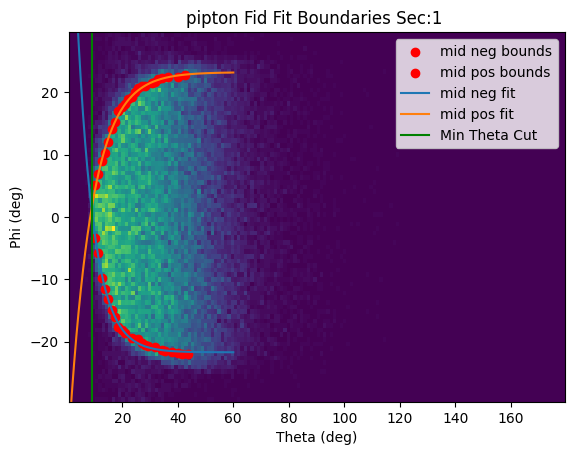

[-62, 0.18, 1.8, 41.6]
min neg pars [-60.16039848   0.13094425  -0.08838157  38.55334544]
min pos pars [ 2.55638491e+02  1.10608273e-01 -1.39110662e+01 -2.32630431e+02]


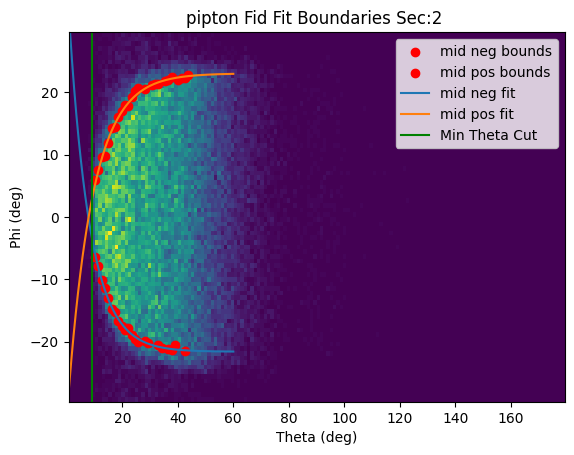

[-62, 0.18, 1.8, 41.6]
min neg pars [-72.53155393   0.17536318   1.06974301  51.36878897]
min pos pars [ 1.97613020e+02  1.07651990e-01 -1.28259154e+01 -1.74865455e+02]


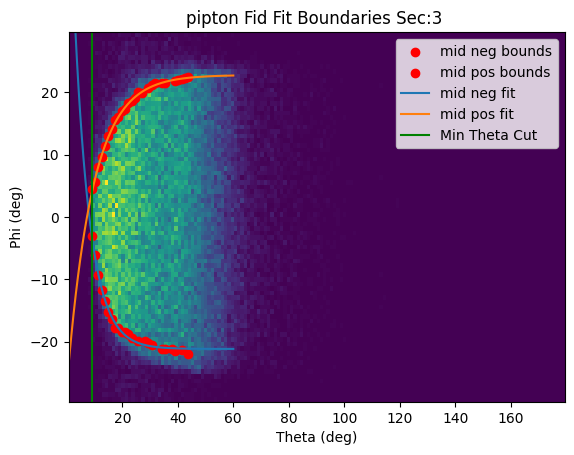

[-62, 0.18, 1.8, 41.6]
min neg pars [-85.54222673   0.1704146    0.50338825  63.69313392]
min pos pars [ 2.06044307e+02  1.12249695e-01 -1.26066137e+01 -1.83509968e+02]


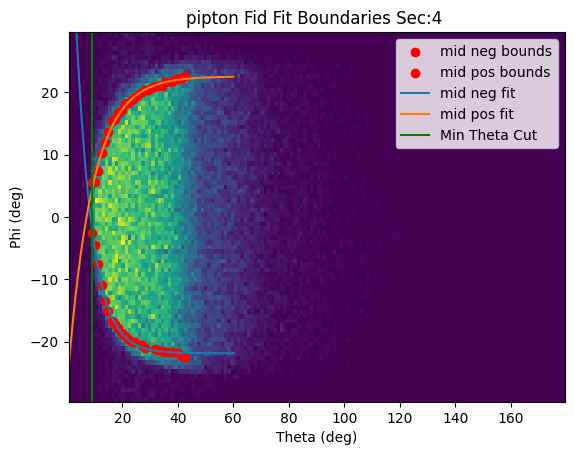

[-62, 0.18, 1.8, 41.6]
min neg pars [-66.07755497   0.13679086   1.96522646  43.35380376]
min pos pars [ 2.22648470e+02  1.17049616e-01 -1.20331229e+01 -1.99416613e+02]


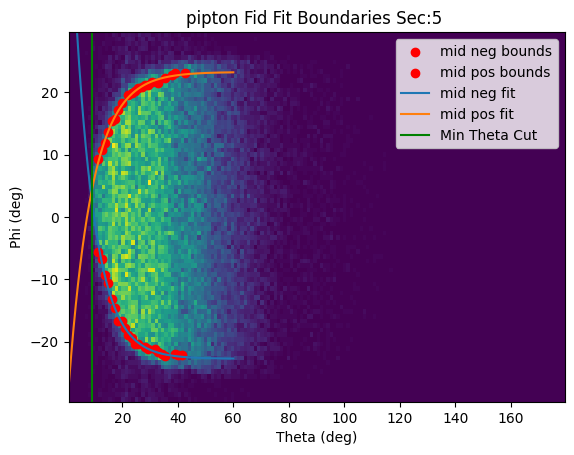

[-62, 0.18, 1.8, 41.6]
min neg pars [-72.84911044   0.15676514   1.43711567  50.96968885]
min pos pars [ 2.27500918e+02  1.21575517e-01 -1.14384035e+01 -2.04855956e+02]


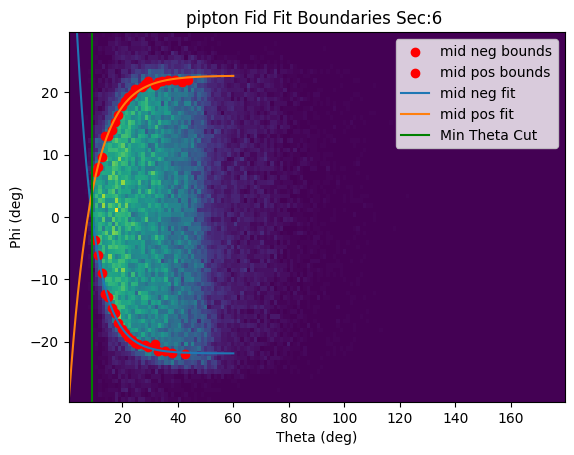

In [31]:
#Create the bounds for the fitting
bound_frac = 0.8
bound_frac_low = 0.5
bound_frac_top = 0.95

fit_bounds = np.zeros((6,2,len(fid_pip_y)))
fit_bounds_low = np.zeros((6,2,len(fid_pip_y)))
fit_bounds_top = np.zeros((6,2,len(fid_pip_y)))

for sec in range(6):
    for ybin in range(len(fid_pip_y)):
        #print(fid_ele_fit_pars1[sec][pbin][ybin][0])
        if fid_pip_fit_pars1[sec][ybin][0]>0 and fid_pip_y[ybin]<45.0:
            if fid_pip_neg_do[sec][ybin]:
                fit_bounds[sec][0][ybin] = Super_Gaus_Bound(fid_pip_fit_pars1[sec][ybin][0],fid_pip_fit_pars1[sec][ybin][1],fid_pip_fit_pars1[sec][ybin][2],fid_pip_fit_pars1[sec][ybin][3],bound_frac)[0]
            if fid_pip_pos_do[sec][ybin]:
                fit_bounds[sec][1][ybin] = Super_Gaus_Bound(fid_pip_fit_pars1[sec][ybin][0],fid_pip_fit_pars1[sec][ybin][1],fid_pip_fit_pars1[sec][ybin][2],fid_pip_fit_pars1[sec][ybin][3],bound_frac)[1]
            #print(fit_bounds[sec][pbin][0][ybin],fit_bounds[sec][pbin][1][ybin])
            fit_bounds_low[sec][0][ybin] = Super_Gaus_Bound(fid_pip_fit_pars1[sec][ybin][0],fid_pip_fit_pars1[sec][ybin][1],fid_pip_fit_pars1[sec][ybin][2],fid_pip_fit_pars1[sec][ybin][3],bound_frac_low)[0]
            fit_bounds_low[sec][1][ybin] = Super_Gaus_Bound(fid_pip_fit_pars1[sec][ybin][0],fid_pip_fit_pars1[sec][ybin][1],fid_pip_fit_pars1[sec][ybin][2],fid_pip_fit_pars1[sec][ybin][3],bound_frac_low)[1]
            fit_bounds_top[sec][0][ybin] = Super_Gaus_Bound(fid_pip_fit_pars1[sec][ybin][0],fid_pip_fit_pars1[sec][ybin][1],fid_pip_fit_pars1[sec][ybin][2],fid_pip_fit_pars1[sec][ybin][3],bound_frac_top)[0]
            fit_bounds_top[sec][1][ybin] = Super_Gaus_Bound(fid_pip_fit_pars1[sec][ybin][0],fid_pip_fit_pars1[sec][ybin][1],fid_pip_fit_pars1[sec][ybin][2],fid_pip_fit_pars1[sec][ybin][3],bound_frac_top)[1]
            #print(fit_bounds[sec][pbin][0][ybin],fit_bounds[sec][pbin][1][ybin])


                
                #Super_Gaus_Bound(a_,m_,s_,p_,frac_)
ini_a0n = -62
ini_a1n = 0.18
ini_a2n = 1.8
ini_a3n = 41.6

ini_a0p = 224
ini_a1p = 0.108
ini_a2p = -14.6
ini_a3p = -201


fit_bounds1 = [[-np.inf,-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf]]

a0_neg_par = np.zeros(6)
a1_neg_par = np.zeros(6)
a2_neg_par = np.zeros(6)
a3_neg_par = np.zeros(6)
a0_pos_par = np.zeros(6)
a1_pos_par = np.zeros(6)
a2_pos_par = np.zeros(6)
a3_pos_par = np.zeros(6)
                
for sec in range(6):
    ini_parsn = [ini_a0n, ini_a1n, ini_a2n, ini_a3n]
    ini_parsp = [ini_a0p, ini_a1p, ini_a2p, ini_a3p]
    if len(Remove_Zeros_Y(fit_bounds[sec][0]))>6:
        plt.hist2d(dumb2_x[sec], dumb2_y[sec], bins=(len(fid_pip_y), len(fid_pip_x)), weights=dense2[sec])
        #print("+",fit_bounds[sec][pbin][0],"+")
        xvals1 = Remove_Zeros_X(fid_pip_y,fit_bounds[sec][0])
        #print("-",xvals1,"-")
        yvals1 = Remove_Zeros_Y(fit_bounds[sec][0])
        plt.scatter(xvals1,yvals1,label="mid neg bounds",color='r')
        xvals2 = Remove_Zeros_X(fid_pip_y,fit_bounds[sec][1])
        yvals2 = Remove_Zeros_Y(fit_bounds[sec][1])
        plt.scatter(xvals2,yvals2,label="mid pos bounds",color='r')
        xvals1_low = Remove_Zeros_X(fid_pip_y,fit_bounds_low[sec][0])
        yvals1_low = Remove_Zeros_Y(fit_bounds_low[sec][0])
        #plt.scatter(xvals1_low,yvals1_low,label="low lower bounds")
        xvals2_low = Remove_Zeros_X(fid_pip_y,fit_bounds_low[sec][1])
        yvals2_low = Remove_Zeros_Y(fit_bounds_low[sec][1])
        #plt.scatter(xvals2_low,yvals2_low,label="low upper bounds")
        xvals1_top = Remove_Zeros_X(fid_pip_y,fit_bounds_top[sec][0])
        yvals1_top = Remove_Zeros_Y(fit_bounds_top[sec][0])
        #plt.scatter(xvals1_top,yvals1_top,label="top lower bounds")
        xvals2_top = Remove_Zeros_X(fid_pip_y,fit_bounds_top[sec][1])
        yvals2_top = Remove_Zeros_Y(fit_bounds_top[sec][1])
        cont_x = np.linspace(0,60,300)
        print(ini_parsn)
        #plt.plot(cont_x,fit_func(cont_x,*ini_parsn),label="ini neg fit",color='r')
        #plt.scatter(xvals2_top,yvals2_top,label="top upper bounds")
            #plt.scatter(Remove_Zeros_X(fid_ele_y,fit_bounds_low[sec][pbin][0]),Remove_Zeros_Y(fit_bounds_low[sec][pbin][0]),label="low lower bounds")
            #plt.scatter(Remove_Zeros_X(fid_ele_y,fit_bounds_low[sec][pbin][1]),Remove_Zeros_Y(fit_bounds_low[sec][pbin][1]),label="low upper bounds")
            #plt.scatter(Remove_Zeros_X(fid_ele_y,fit_bounds_top[sec][pbin][0]),Remove_Zeros_Y(fit_bounds_top[sec][pbin][0]),label="top lower bounds")
            #plt.scatter(Remove_Zeros_X(fid_ele_y,fit_bounds_top[sec][pbin][1]),Remove_Zeros_Y(fit_bounds_top[sec][pbin][1]),label="top upper bounds")
        try:
            pars1, pars_cov1 = op.curve_fit(fit_func,xvals1,yvals1,p0=ini_parsn,bounds=fit_bounds1,maxfev=5000)
            
            plt.plot(cont_x,fit_func(cont_x,*pars1),label="mid neg fit")
            a0_neg_par[sec] = pars1[0]
            a1_neg_par[sec] = pars1[1]
            a2_neg_par[sec] = pars1[2]
            a3_neg_par[sec] = pars1[3]
            print("min neg pars",pars1)
        except RuntimeError:
            print("Runtime Error")
        try:
            pars2, pars_cov2 = op.curve_fit(fit_func,xvals2,yvals2,p0=ini_parsp,bounds=fit_bounds1,maxfev=5000)
            cont_x = np.linspace(0,60,300)
            plt.plot(cont_x,fit_func(cont_x,*pars2),label="mid pos fit")
            a0_pos_par[sec] = pars2[0]
            a1_pos_par[sec] = pars2[1]
            a2_pos_par[sec] = pars2[2]
            a3_pos_par[sec] = pars2[3]
            print("min pos pars",pars2)
        except RuntimeError:
            print("Runtime Error")
            #plt.axvline(x = min_theta(pvals[pbin],c1_par[sec],c2_par[sec],pshift_par[sec]), color = 'g', label = 'Skew Max')
        plt.axvline(x = min_theta_vals[sec], color = 'g', label = 'Min Theta Cut')
        plt.title("pipton Fid Fit Boundaries Sec:{} ".format(sec+1))
        plt.xlabel("Theta (deg)")
        plt.ylabel("Phi (deg)")
        plt.legend()
        plt.show()
        

In [23]:
#Print Minimum Theta Parameters for Pi+ Fiducial Cut
print("Minimum Theta Parameters for Pi+ Fiducial Cut [sec]")
print("Standard")
for sec in range(6):
    if sec==0:
        print("{",min_theta_vals[sec],end=",")
    else:
        if sec ==5:
            print(min_theta_vals[sec],"}")
        else:
            print(min_theta_vals[sec],end=",")
print("Loose")
for sec in range(6):
    if sec==0:
        print("{",min_theta_vals_low[sec],end=",")
    else:
        if sec ==5:
            print(min_theta_vals_low[sec],"}")
        else:
            print(min_theta_vals_low[sec],end=",")
print("Tight")
for sec in range(6):
    if sec==0:
        print("{",min_theta_vals_top[sec],end=",")
    else:
        if sec ==5:
            print(min_theta_vals_top[sec],"}")
        else:
            print(min_theta_vals_top[sec],end=",")

Minimum Theta Parameters for Pi+ Fiducial Cut [sec]
Standard
{ 9.0,9.0,9.0,9.0,7.8,9.0 }
Loose
{ 8.4,8.4,8.4,8.4,7.199999999999999,8.4 }
Tight
{ 9.6,9.6,9.6,9.6,8.4,9.6 }


In [24]:
print("Positive Phi Cut Parameters for Pi+ Fiducial Cut [sec]")
print("a0")
for sec in range(6):
    if sec==0:
        print("{",a0_pos_par[sec],end=",")
    else:
        if sec ==5:
            print(a0_pos_par[sec],"}")
        else:
            print(a0_pos_par[sec],end=",")
print("a1")
for sec in range(6):
    if sec==0:
        print("{",a1_pos_par[sec],end=",")
    else:
        if sec ==5:
            print(a1_pos_par[sec],"}")
        else:
            print(a1_pos_par[sec],end=",")
print("a2")
for sec in range(6):
    if sec==0:
        print("{",a2_pos_par[sec],end=",")
    else:
        if sec ==5:
            print(a2_pos_par[sec],"}")
        else:
            print(a2_pos_par[sec],end=",")
print("a3")
for sec in range(6):
    if sec==0:
        print("{",a3_pos_par[sec],end=",")
    else:
        if sec ==5:
            print(a3_pos_par[sec],"}")
        else:
            print(a3_pos_par[sec],end=",")

Positive Phi Cut Parameters for Pi+ Fiducial Cut [sec]
a0
{ 493.5008028882392,255.63849087351872,197.61301972139347,206.04430743676153,222.64847018236728,227.50091766198494 }
a1
{ 0.12022645219137838,0.11060827332502345,0.10765198994160302,0.11224969517768793,0.11704961600768687,0.1215755169519248 }
a2
{ -17.00384782119747,-13.911066164275203,-12.825915364307882,-12.60661372977583,-12.033122855251356,-11.438403539725368 }
a3
{ -470.30582536747767,-232.6304308032229,-174.8654549559775,-183.5099675199486,-199.4166133596229,-204.85595571680489 }


In [25]:
print("Negative Phi Cut Parameters for Pi+ Fiducial Cut [sec]")
print("a0")
for sec in range(6):
    if sec==0:
        print("{",a0_neg_par[sec],end=",")
    else:
        if sec ==5:
            print(a0_neg_par[sec],"}")
        else:
            print(a0_neg_par[sec],end=",")
print("a1")
for sec in range(6):
    if sec==0:
        print("{",a1_neg_par[sec],end=",")
    else:
        if sec ==5:
            print(a1_neg_par[sec],"}")
        else:
            print(a1_neg_par[sec],end=",")
print("a2")
for sec in range(6):
    if sec==0:
        print("{",a2_neg_par[sec],end=",")
    else:
        if sec ==5:
            print(a2_neg_par[sec],"}")
        else:
            print(a2_neg_par[sec],end=",")
print("a3")
for sec in range(6):
    if sec==0:
        print("{",a3_neg_par[sec],end=",")
    else:
        if sec ==5:
            print(a3_neg_par[sec],"}")
        else:
            print(a3_neg_par[sec],end=",")

Negative Phi Cut Parameters for Pi+ Fiducial Cut [sec]
a0
{ -61.24861422770867,-60.16039847639102,-72.53155393253667,-85.54222673141943,-66.07755496581636,-72.84911043527194 }
a1
{ 0.1653854035244359,0.13094425433992815,0.17536318140488005,0.17041459694931194,0.13679085750795605,0.15676514153149143 }
a2
{ 2.965567900076577,-0.08838157307637298,1.069743010678403,0.5033882522277233,1.9652264616116661,1.4371156657512434 }
a3
{ 39.54843421722501,38.55334544445276,51.368788966203894,63.693133920032885,43.35380376049559,50.96968884989372 }
